In [63]:
import os
import openai
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file
import logging
import sys
import re
from tqdm import tqdm
from IPython.display import HTML
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchmetrics
from torch.utils.data import DataLoader, Subset
from torch.nn import functional as F
import clip
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import json
from datasets import _transform, get_full_class_labels, fix_class_names, idx_to_label, CUBDataset
openai.api_key  = os.getenv('OPENAI_API_KEY')

# Dataset

In [64]:
CUB_DIR = '/home/kush/Desktop/CLIP/CUB/CUB_200_2011' # REPLACE THIS WITH YOUR OWN PATH
# load CUB dataset
data_dir = pathlib.Path(CUB_DIR)
cub_dataset = CUBDataset(data_dir, train=True, transform=_transform(224))

/home/kush/anaconda3/envs/kush/lib/python3.7/site-packages/torchvision/transforms/transforms.py:330: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "


# Load model

In [32]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device=device, jit=False)
model = model.eval()
model = model.requires_grad_(False)

# Function for computing Label text emebddings

In [33]:
def compute_encodings(model, labels):
    label_encodings = F.normalize(model.encode_text(clip.tokenize(labels).to(device)))
    return label_encodings

# Function for index to label

In [34]:
def idx_to_label(label_to_idx):
    dataset_items = list(label_to_idx.items())
    return dict(map(lambda x: x[::-1], dataset_items))

In [35]:
def initialize_counter_dict(labels):
    dict_ = dict()
    for label1 in labels:
        dict_[label1] = dict()
        for label2 in labels:
            dict_[label1][label2] = 0
    return dict_

In [36]:
def increase_count(counter_dict, actual_class, top_classes):
    for class_ in top_classes:
        counter_dict[actual_class][class_] += 1
    return counter_dict

In [37]:
def add_to_counter_dict(counter_dict, index_to_class_dict, actual_index_list, 
                        pred_index_list):
    for idx, actual_class_index in enumerate(actual_index_list):
        actual_class = index_to_class_dict[int(actual_class_index)]
        top_classes = list(map(lambda x: index_to_class_dict[int(x)], 
                               pred_index_list[idx].squeeze()))
        counter_dict = increase_count(counter_dict, actual_class, top_classes)
    return counter_dict

# Calculate CLIP accuracy

In [38]:
def calc_acc(model, dataset, descriptions, batch_size = 64*10, count_classes = False, 
             topK = 5):
    
    count_classes_dict = initialize_counter_dict(dataset.classes)
    index_to_class_dict = idx_to_label(dataset.class_to_idx)
    
    
    encodings = compute_encodings(model, descriptions)
    clip_accuracy_metric = torchmetrics.Accuracy(task="multiclass", num_classes=len(dataset.classes)).to(device)
    clip_accuracy_metric_top5 = torchmetrics.Accuracy(top_k=5, task="multiclass", num_classes=len(dataset.classes)).to(device)
    dataloader = DataLoader(dataset, batch_size, shuffle=True, num_workers=16, pin_memory=True)
    for batch_number, batch in enumerate(tqdm(dataloader)):
        images, labels = batch

        images = images.to(device)
        labels = labels.to(device)

        image_encodings = model.encode_image(images)
        image_encodings = F.normalize(image_encodings)

        image_labels_similarity = image_encodings @ encodings.T
        top5_values, top5_indices = image_labels_similarity.topk(5, dim=1)
        clip_predictions = image_labels_similarity.argmax(dim=1)


        clip_acc = clip_accuracy_metric(image_labels_similarity, labels)
        clip_acc_top5 = clip_accuracy_metric_top5(image_labels_similarity, labels)
        
        
        if count_classes == True:
            count_classes_dict = add_to_counter_dict(count_classes_dict, index_to_class_dict,
                                                 labels, top5_indices)


    accuracy_logs = {}
    accuracy_logs["Total CLIP-Standard Top-1 Accuracy: "] = 100*clip_accuracy_metric.compute().item()
    accuracy_logs["Total CLIP-Standard Top-5 Accuracy: "] = 100*clip_accuracy_metric_top5.compute().item()
    
    if count_classes == True:
        for actual_key in count_classes_dict.keys():
            count_classes_dict[actual_key] = sorted(count_classes_dict[actual_key].items(),
                                                key=lambda x: x[1], reverse=True)

        json_string = json.dumps(count_classes_dict, indent=4)  # indent for pretty formatting

        # Write JSON string to a text file
        with open(f'top{topK}.txt', 'w') as file:
            file.write(json_string)

    
    return accuracy_logs

In [39]:
calc_acc(model, cub_dataset, cub_dataset.classes,
         count_classes = True)

100%|███████████████████████████████████████████| 10/10 [00:22<00:00,  2.29s/it]


{'Total CLIP-Standard Top-1 Accuracy: ': 49.582916498184204,
 'Total CLIP-Standard Top-5 Accuracy: ': 81.6316306591034}

In [40]:
def create_graph(actual_label, top5_pred):
    top5labels = list(map(lambda x: x[0], top5_pred))
    top5counts = list(map(lambda x: x[1], top5_pred))
    colors = ['royalblue' if label == actual_label else 'lightsteelblue' for label in top5labels]
    plt.barh(top5labels, top5counts, color=colors)

    num_ticks = 6  # Adjust the number of ticks as needed
    tick_positions = np.linspace(0, max(top5counts), num_ticks)
    plt.xticks(tick_positions, rotation=45, ha='right')  # Set the rotation and horizontal alignment

    plt.xlabel('Top-5 counts')
    plt.ylabel('Classes')
    plt.title('Score-wise Diagram')
    
    # Show the plot
    plt.show()


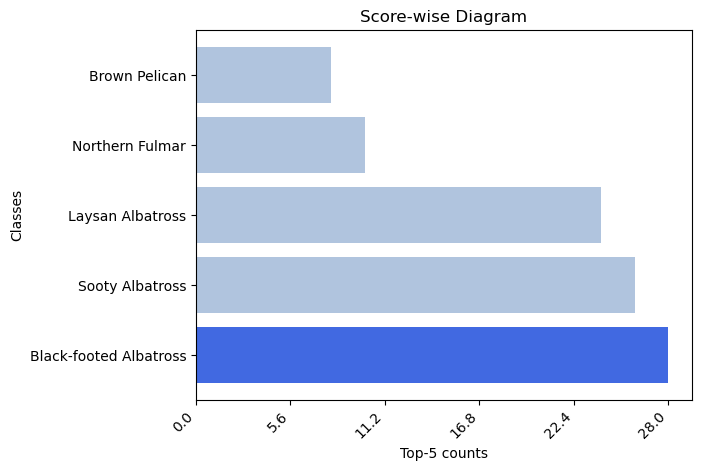

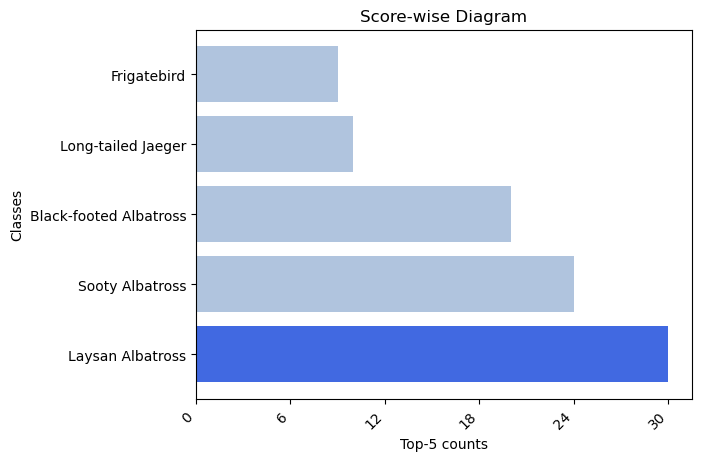

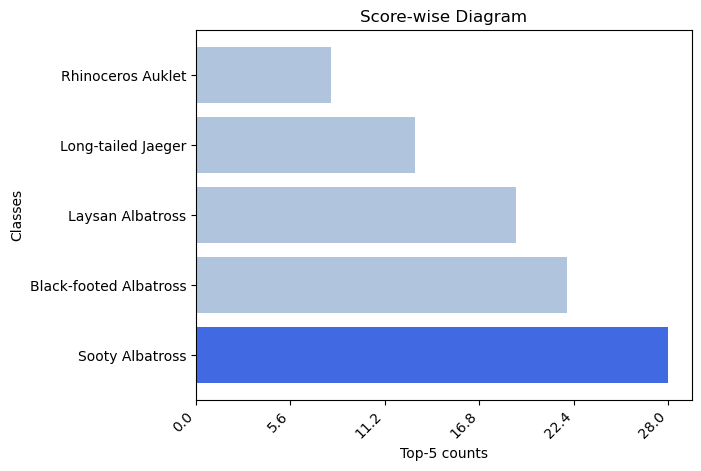

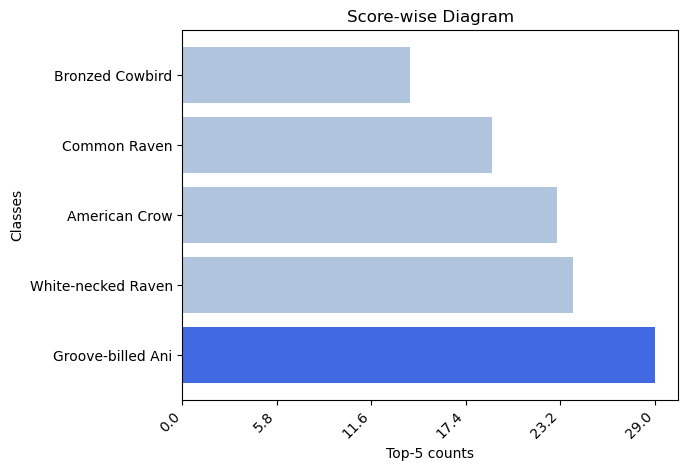

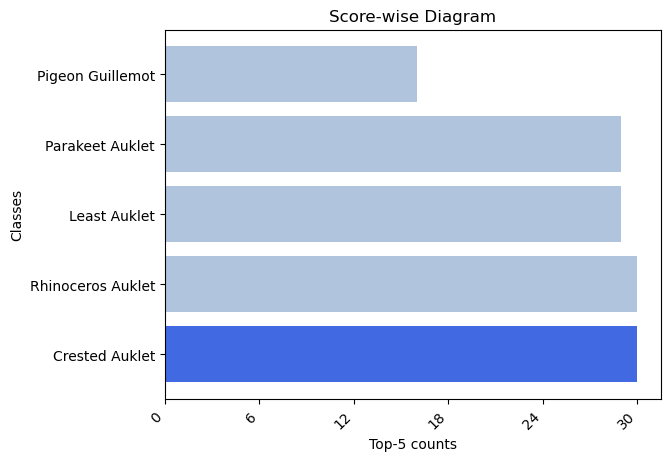

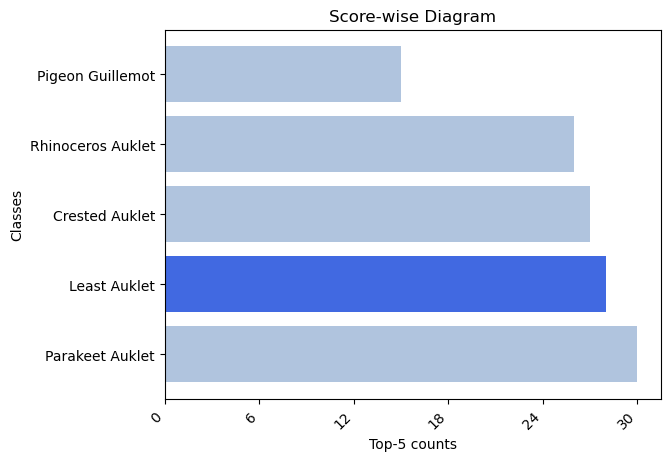

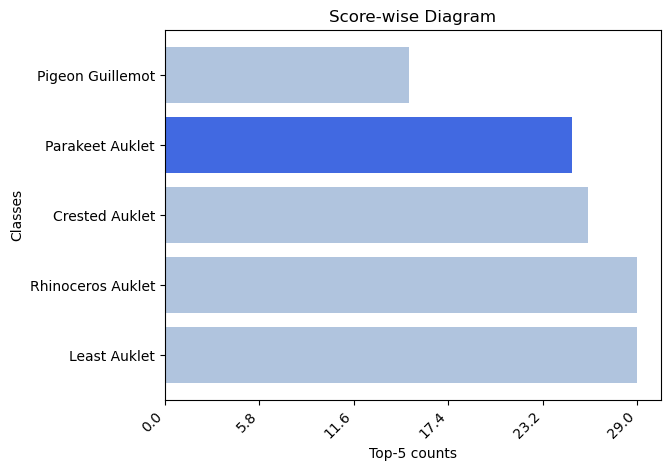

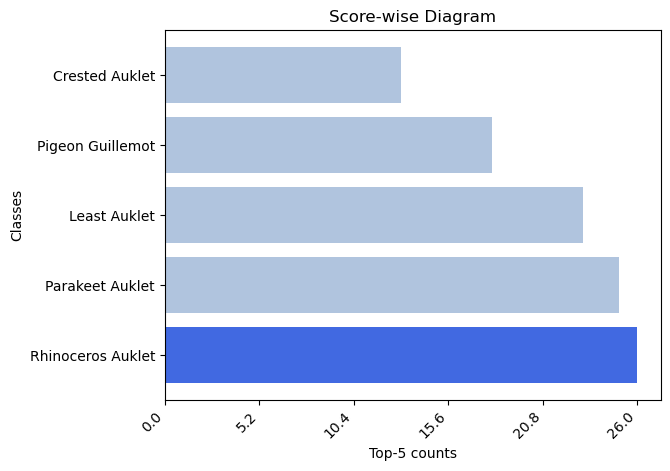

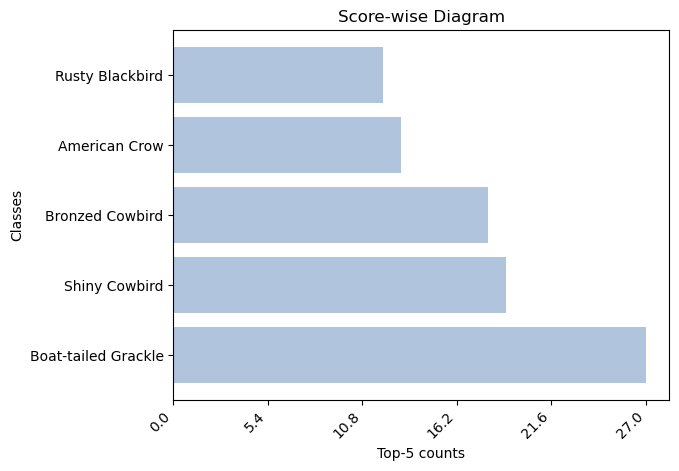

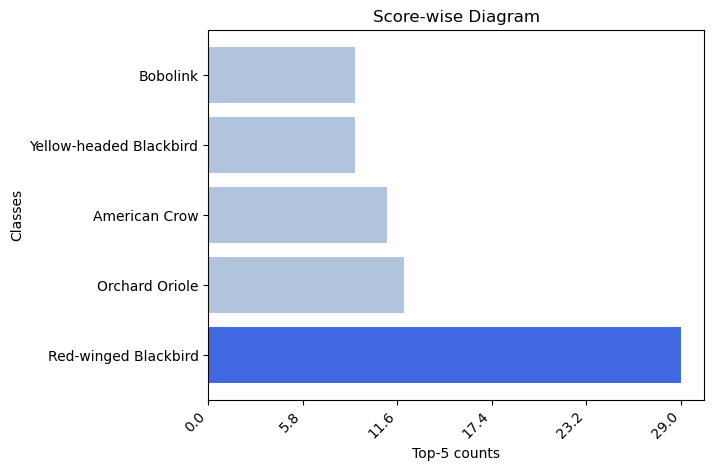

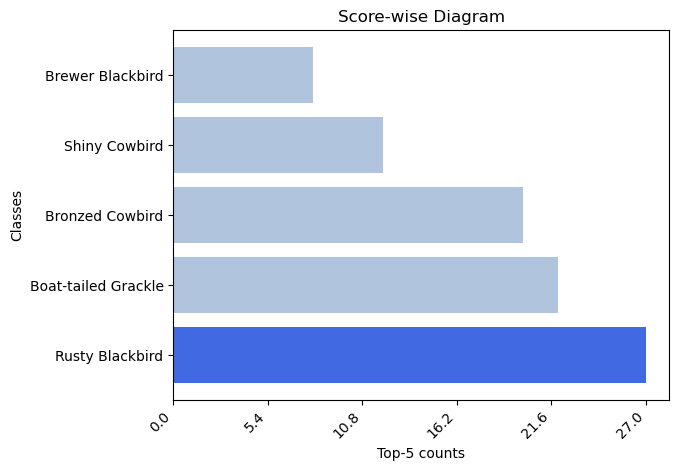

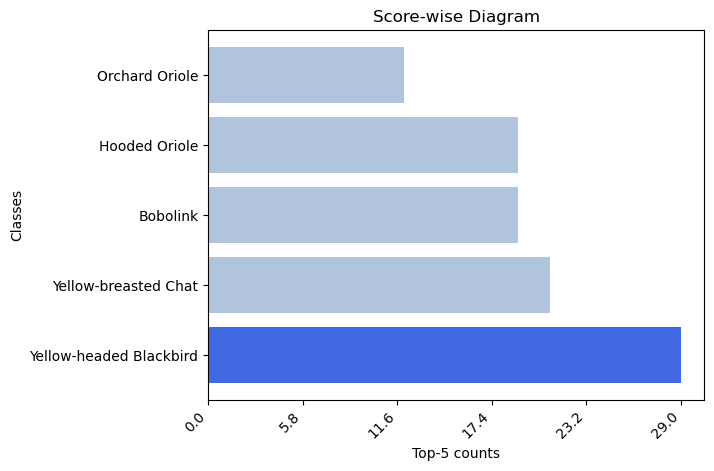

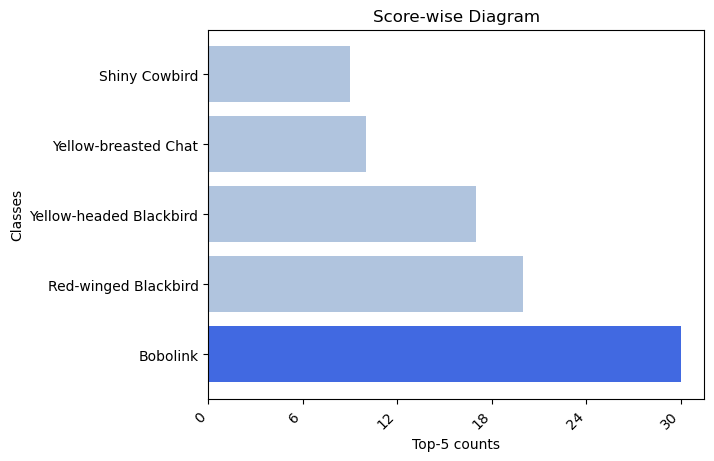

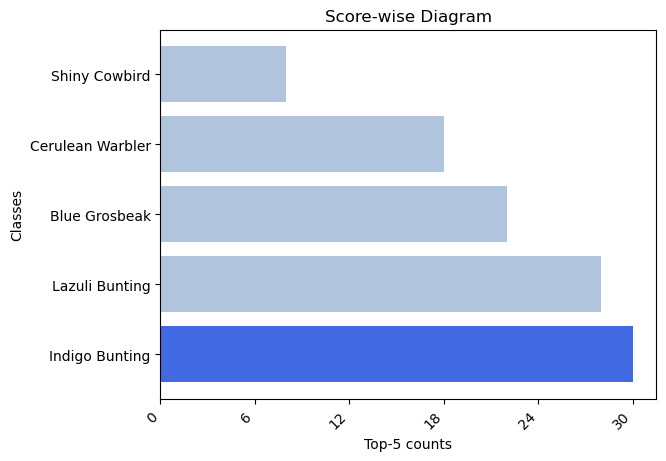

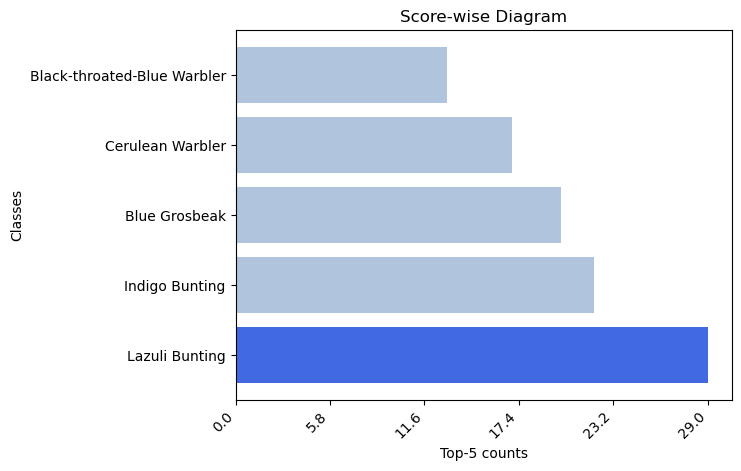

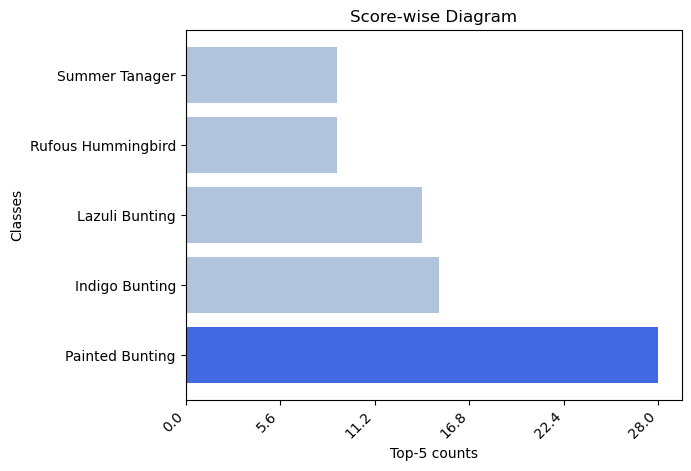

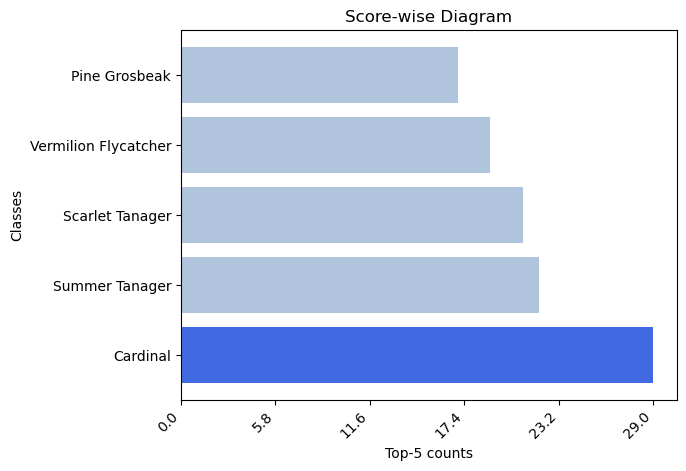

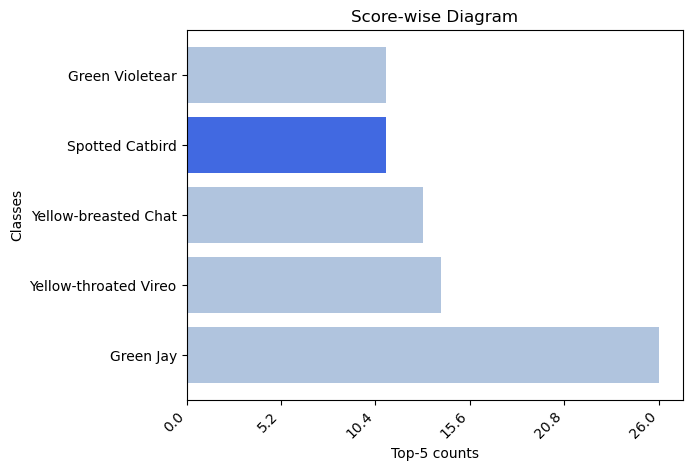

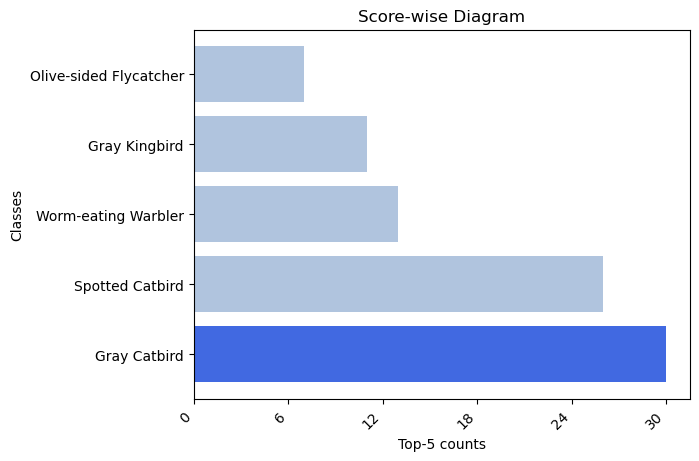

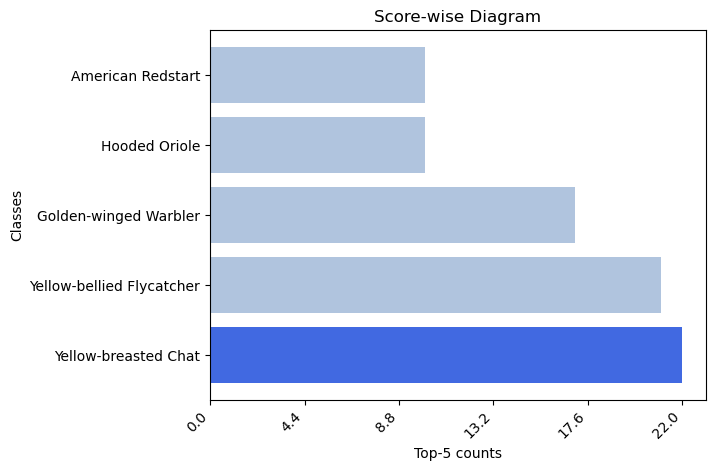

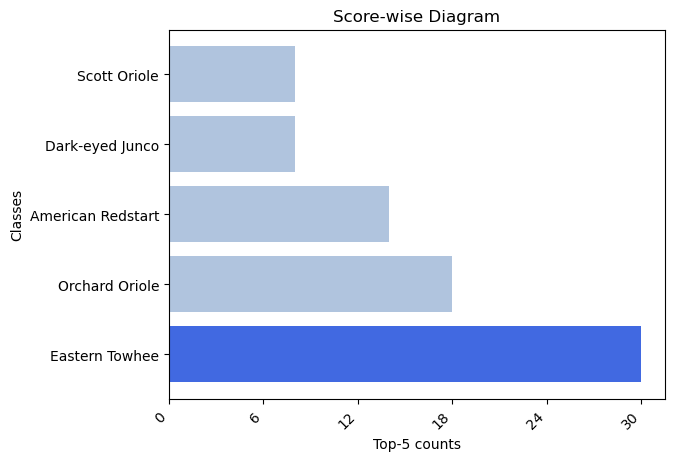

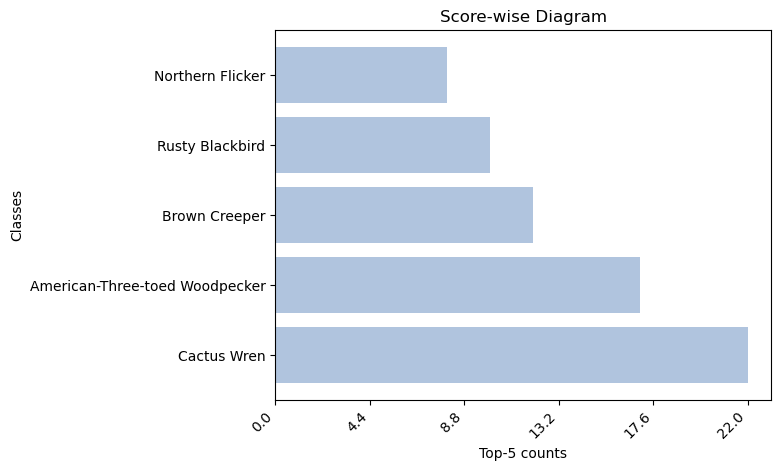

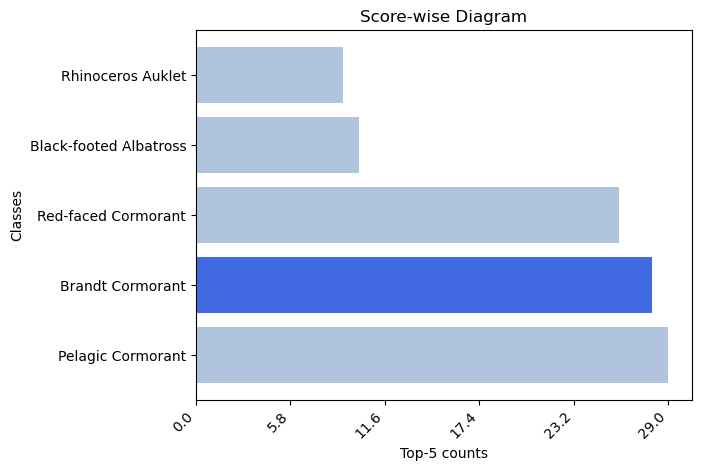

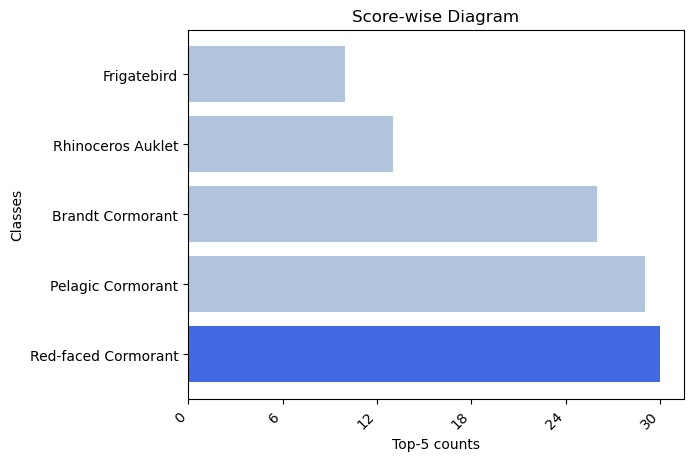

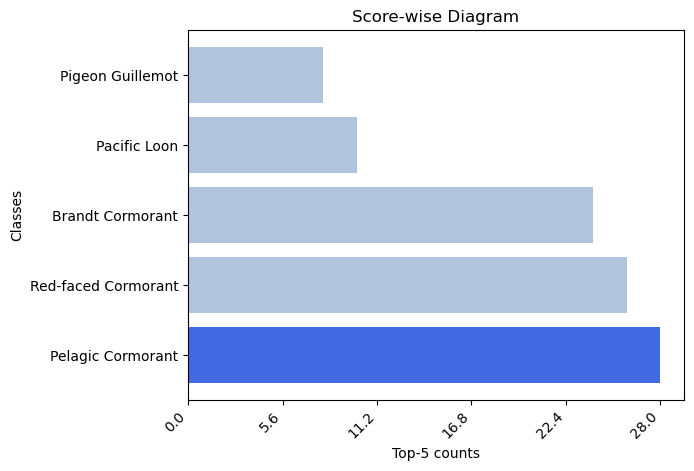

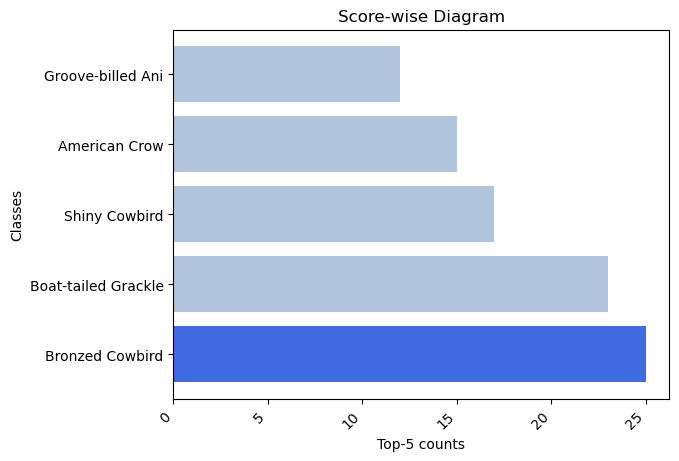

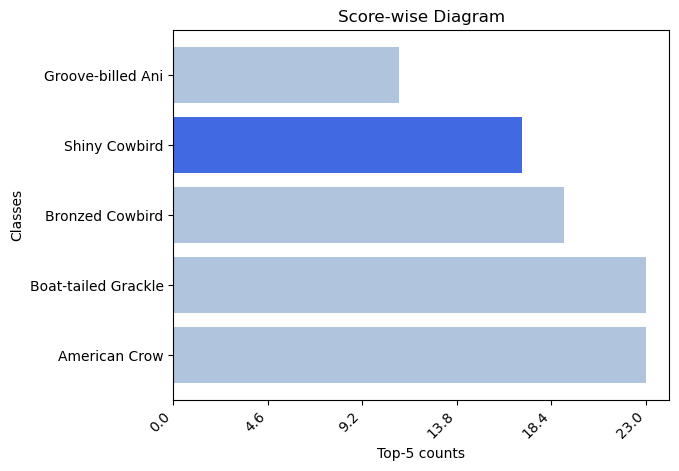

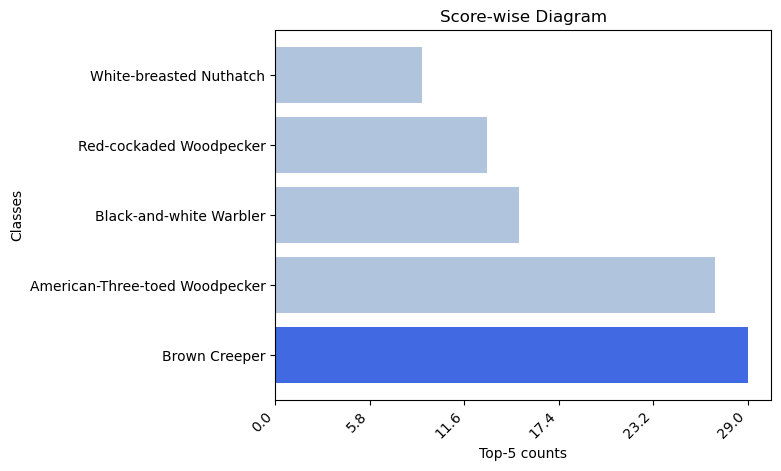

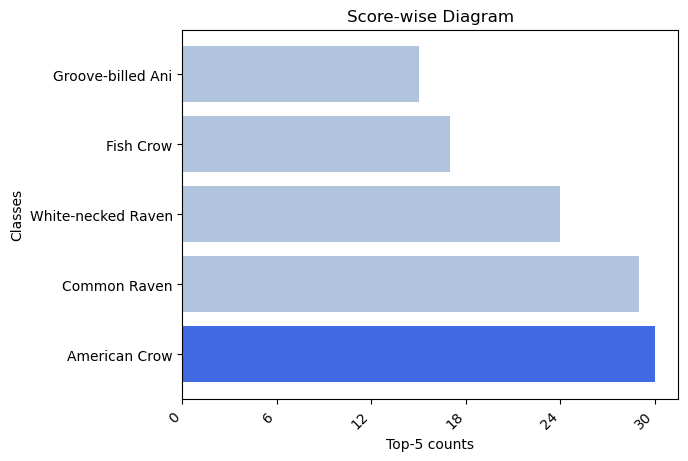

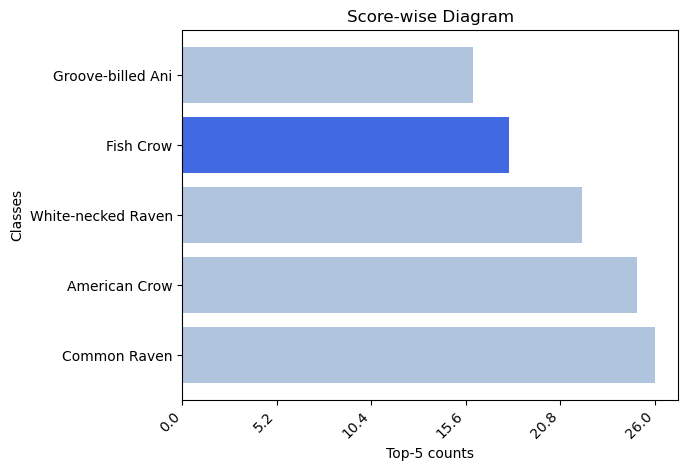

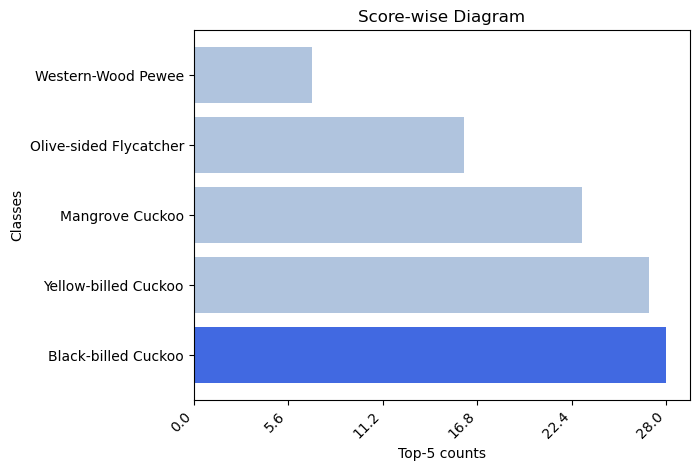

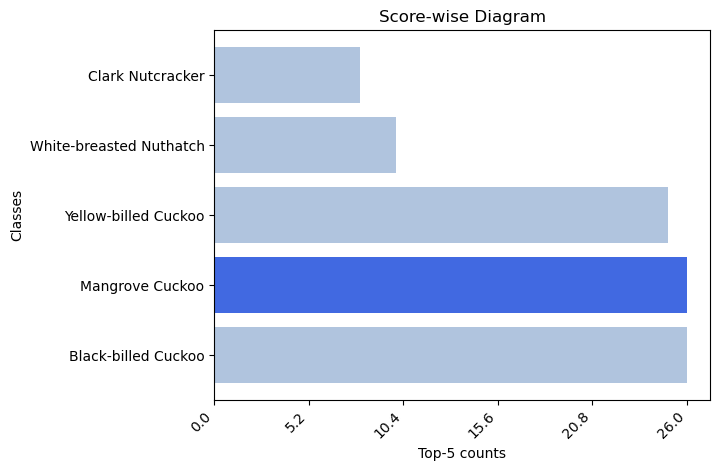

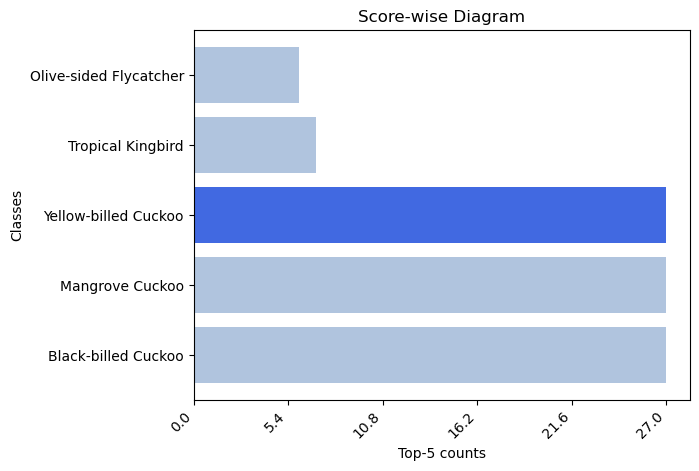

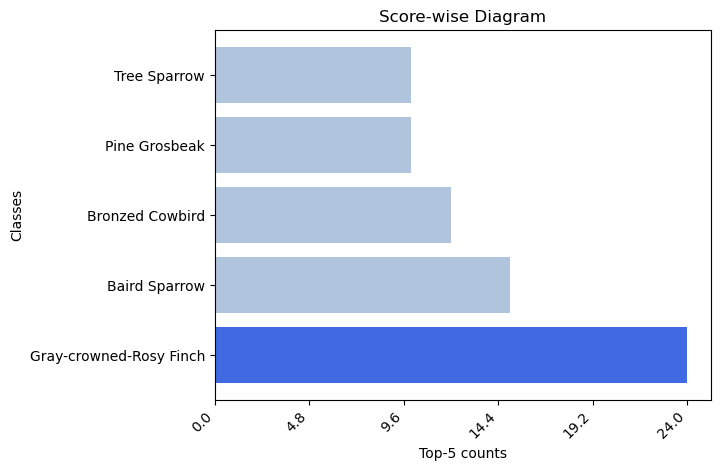

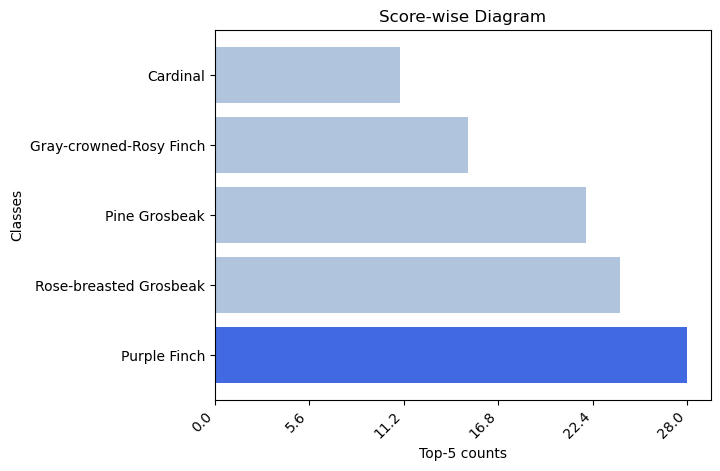

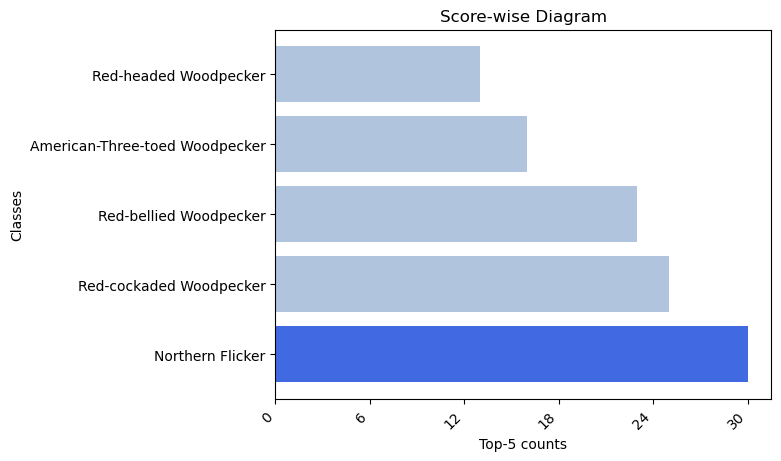

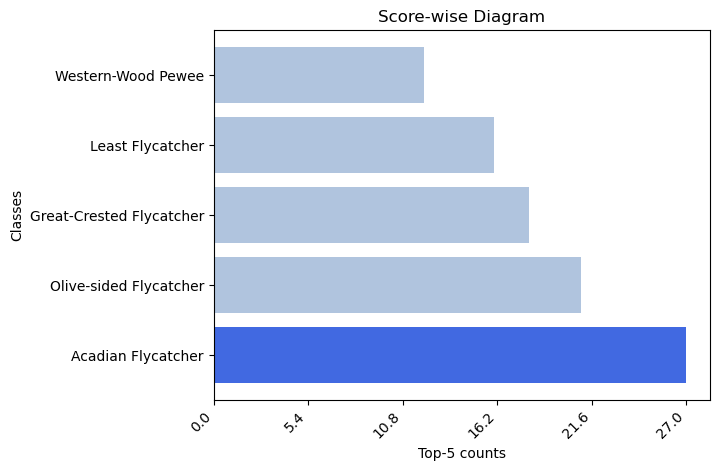

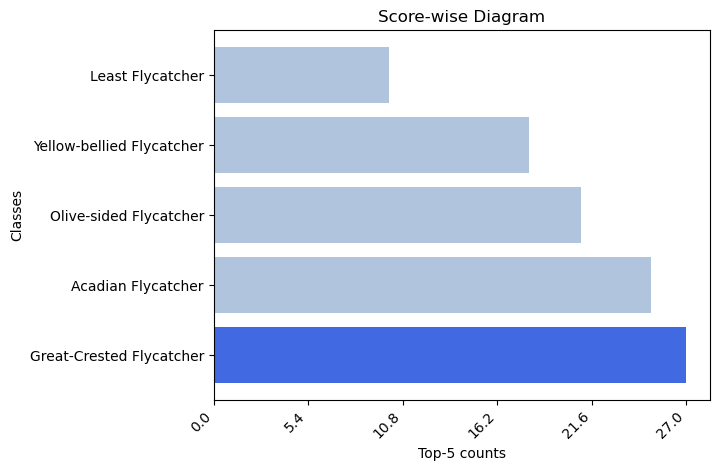

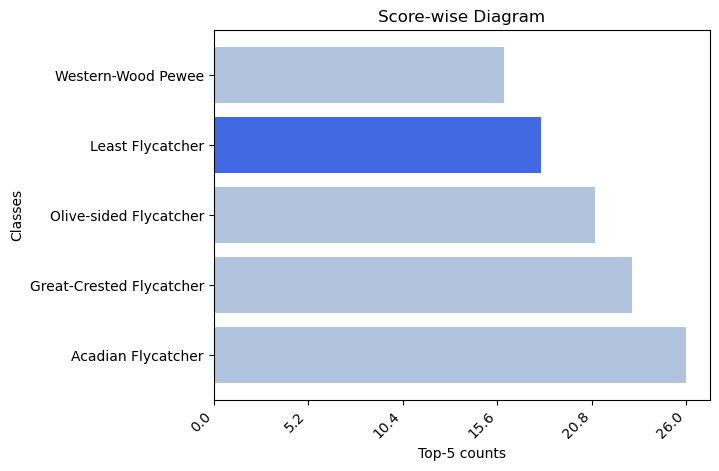

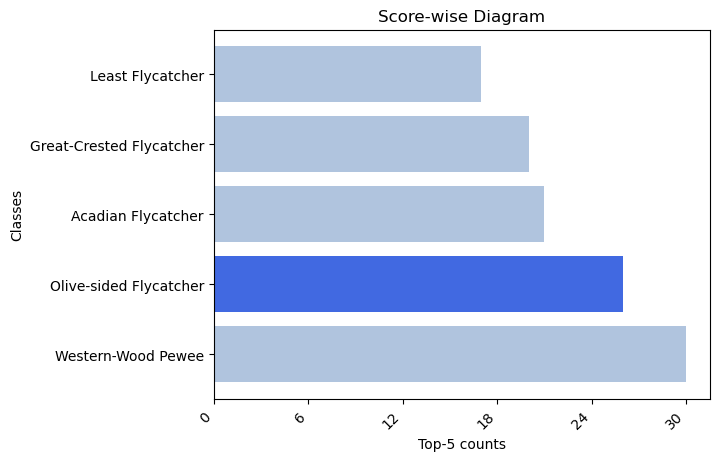

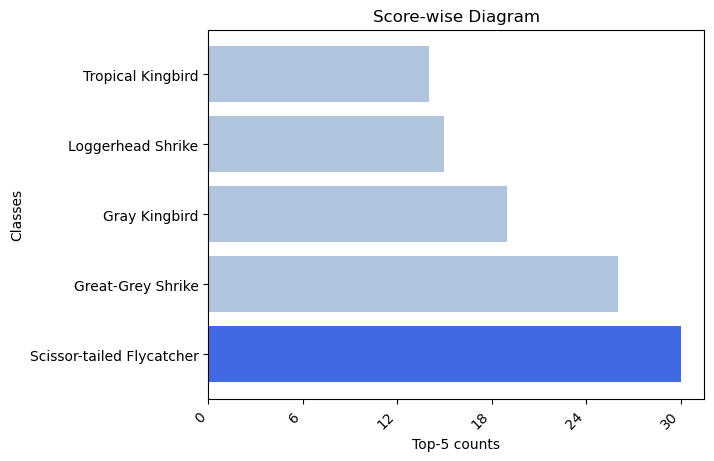

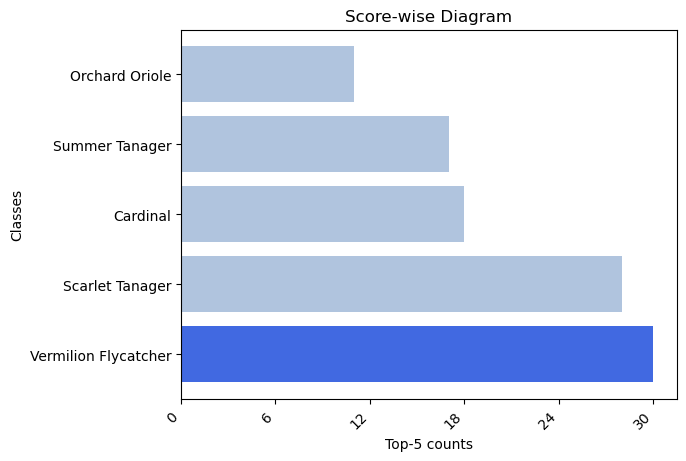

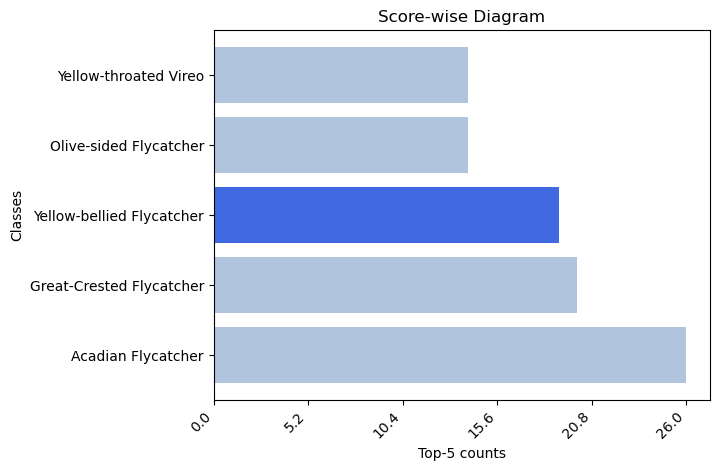

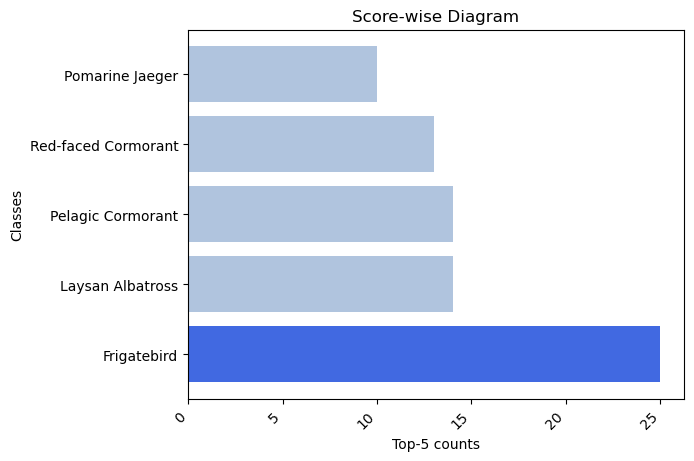

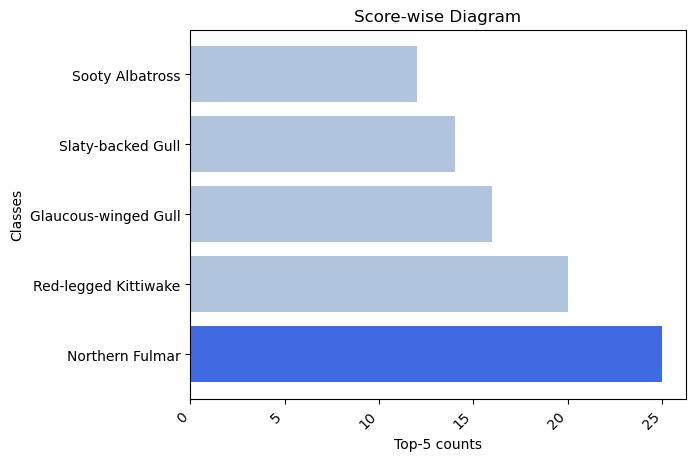

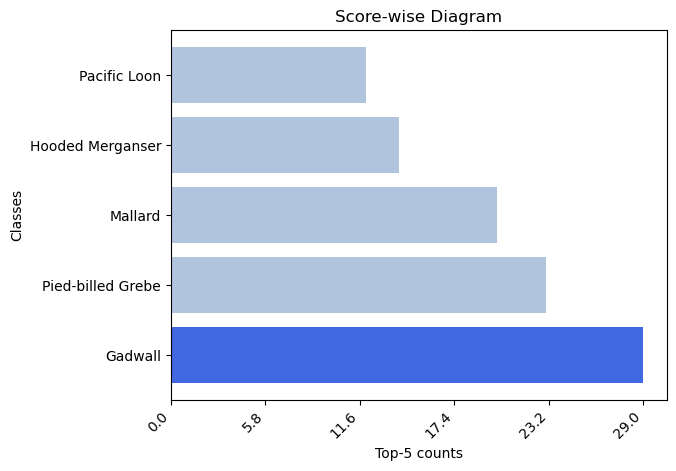

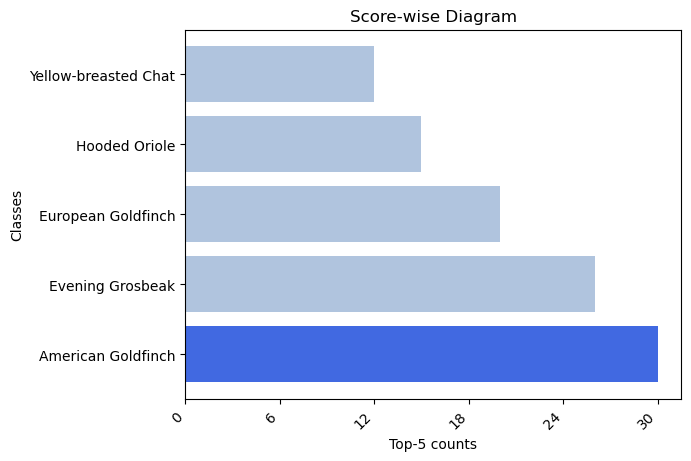

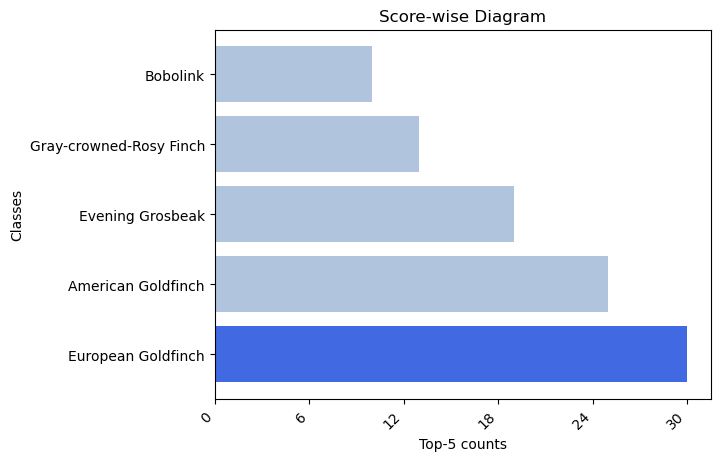

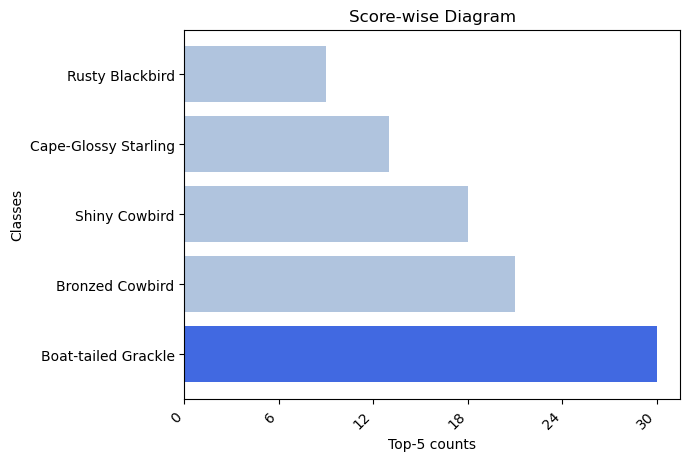

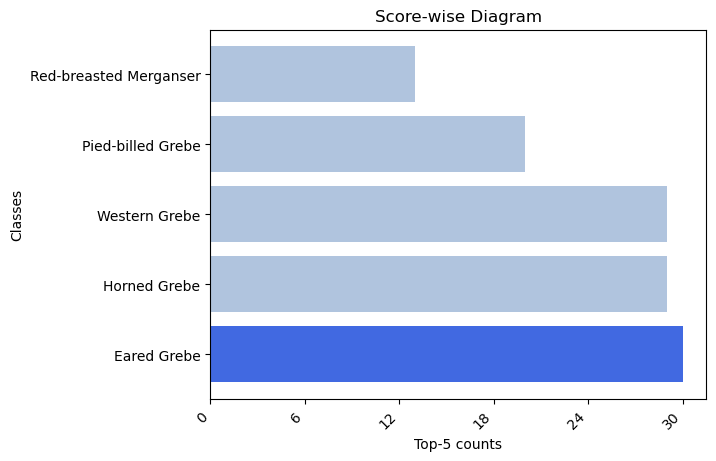

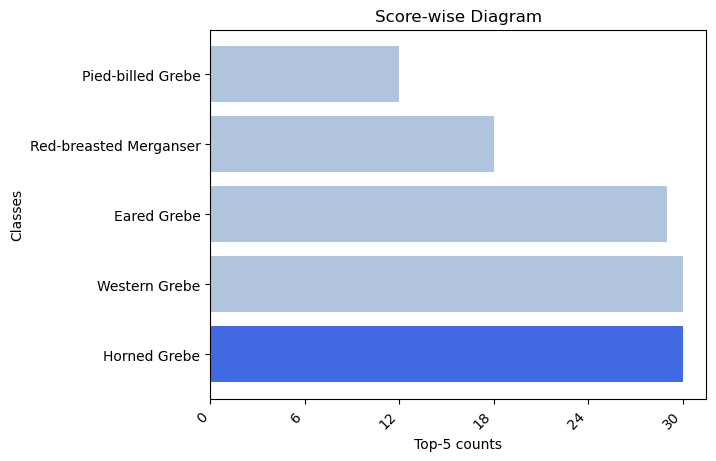

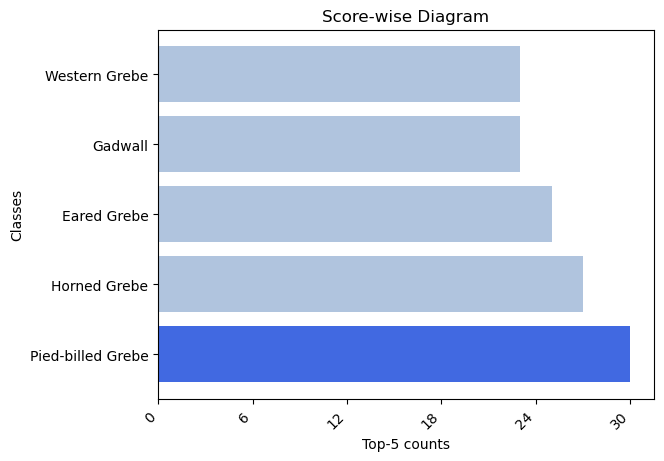

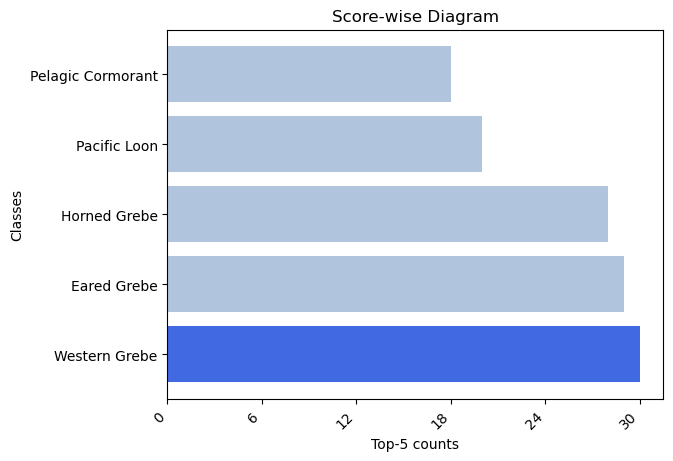

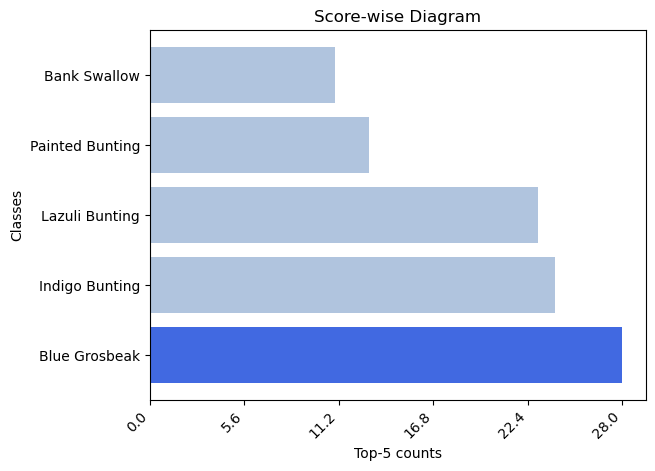

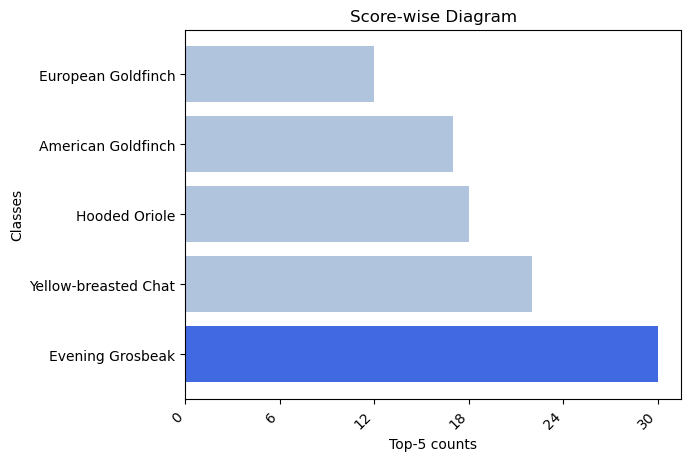

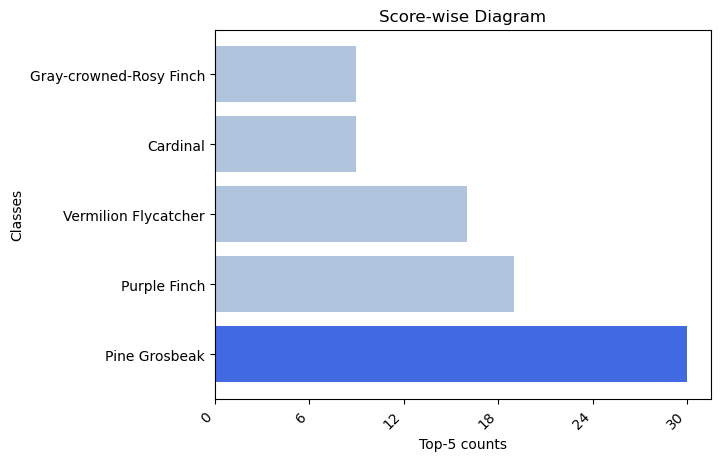

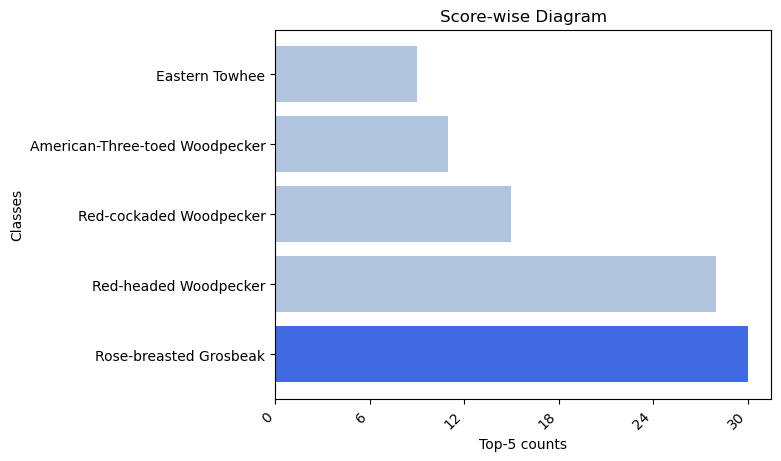

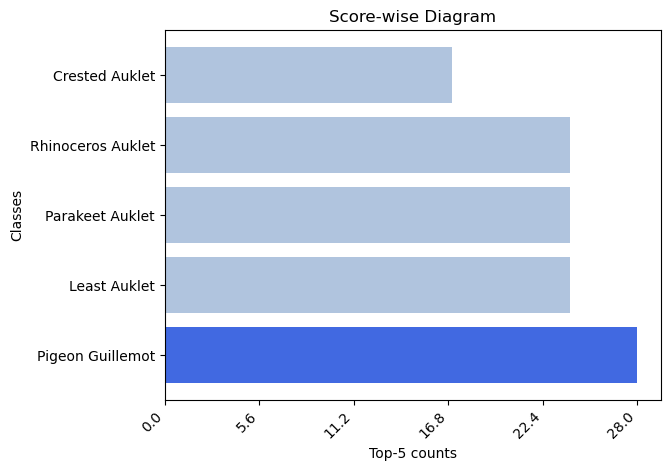

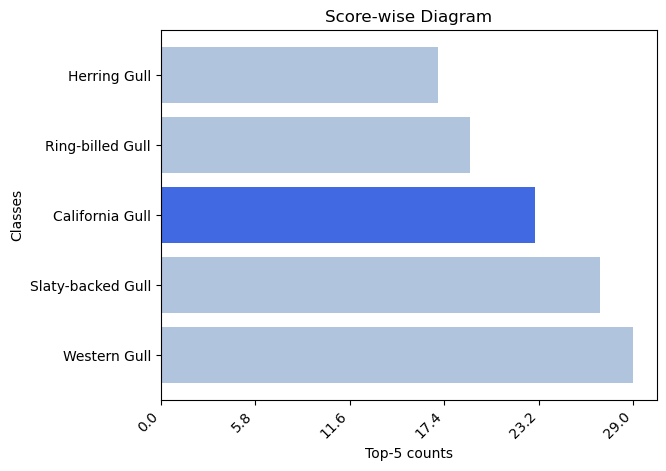

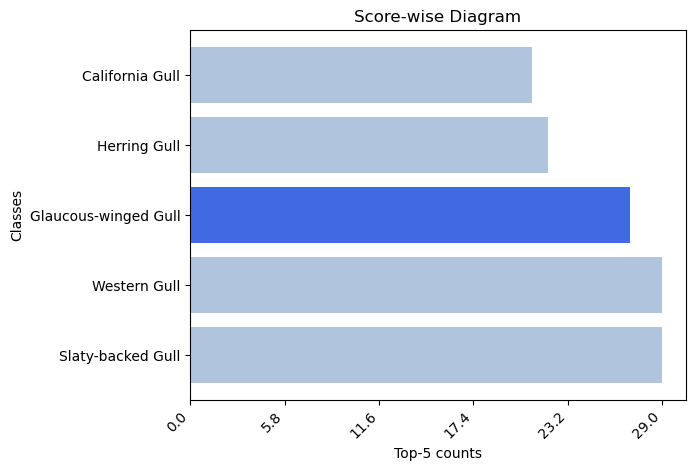

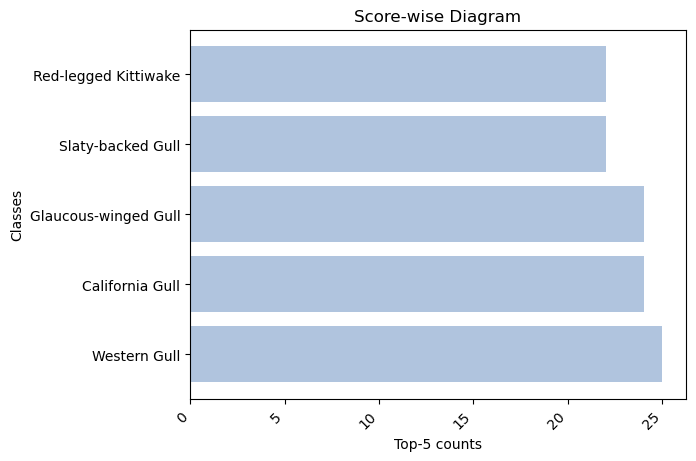

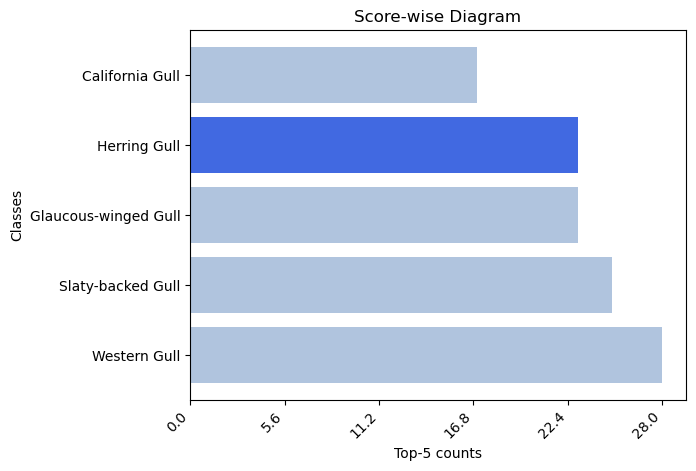

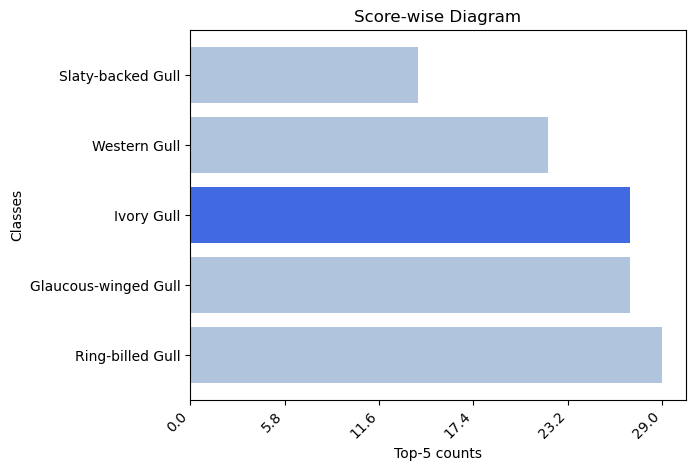

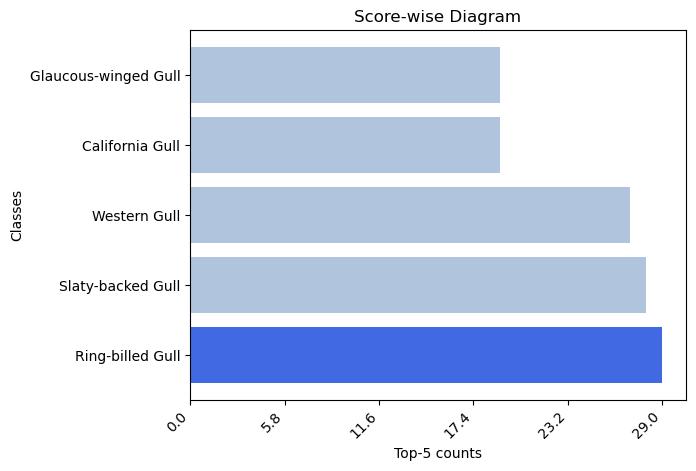

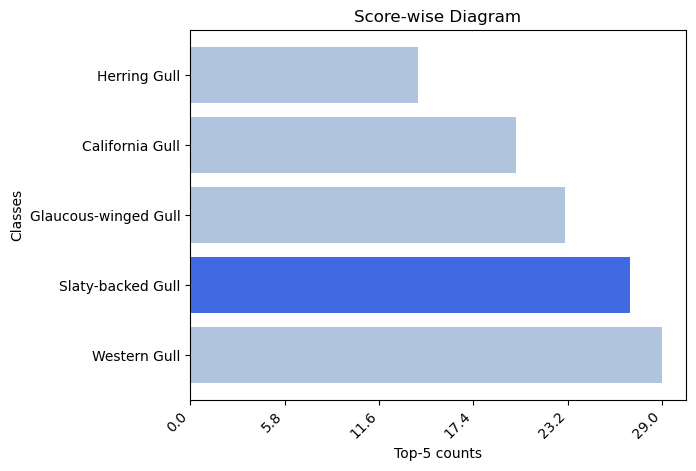

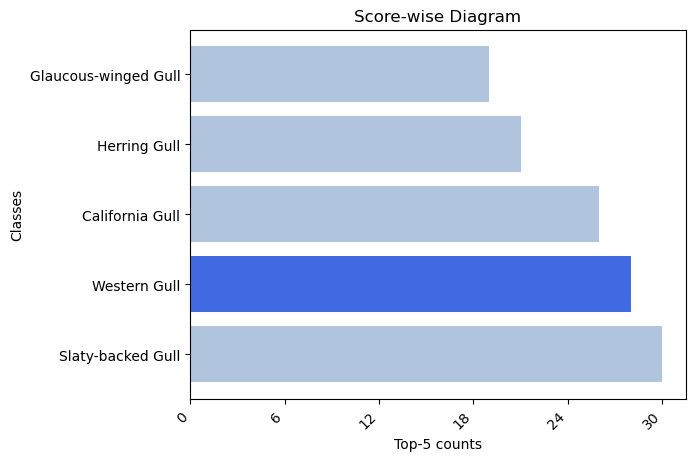

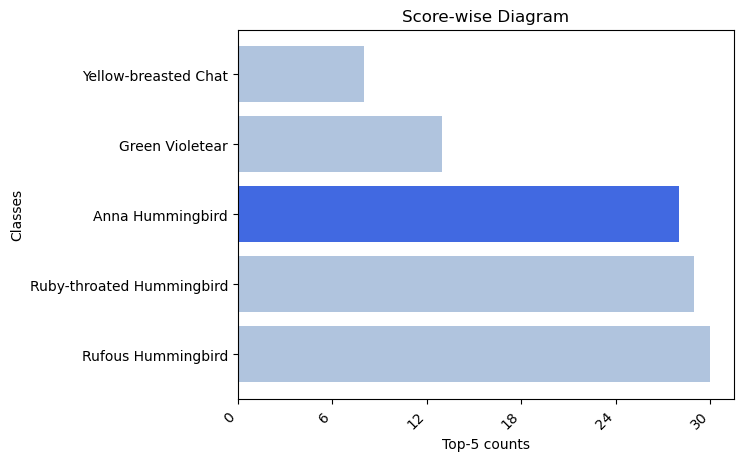

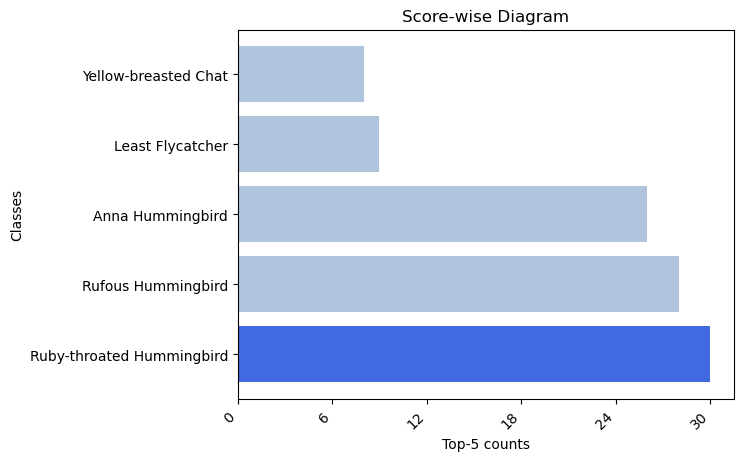

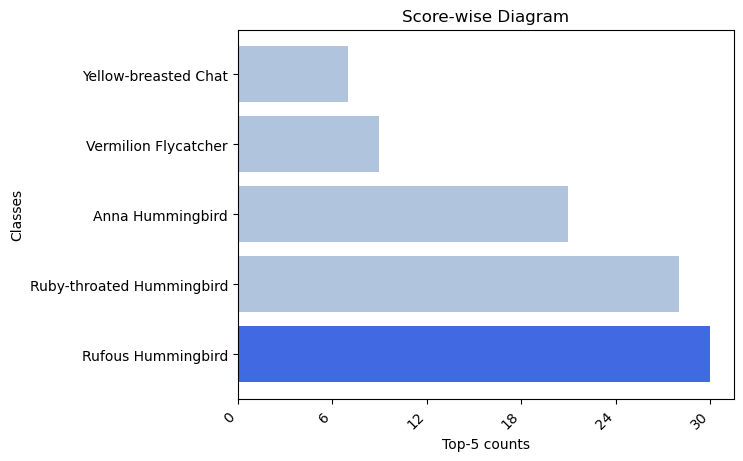

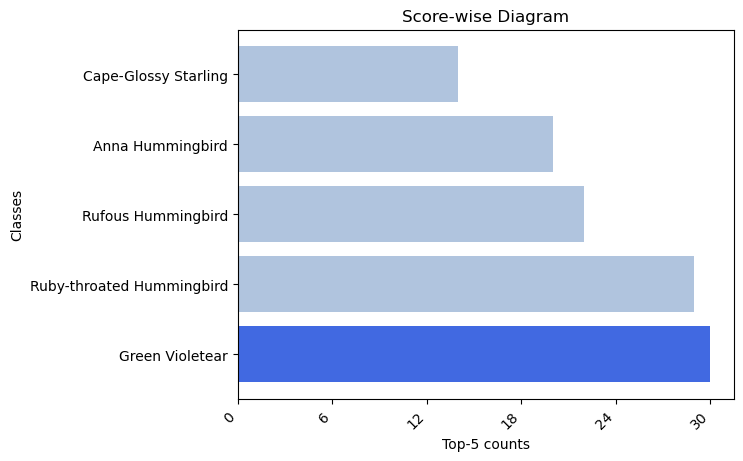

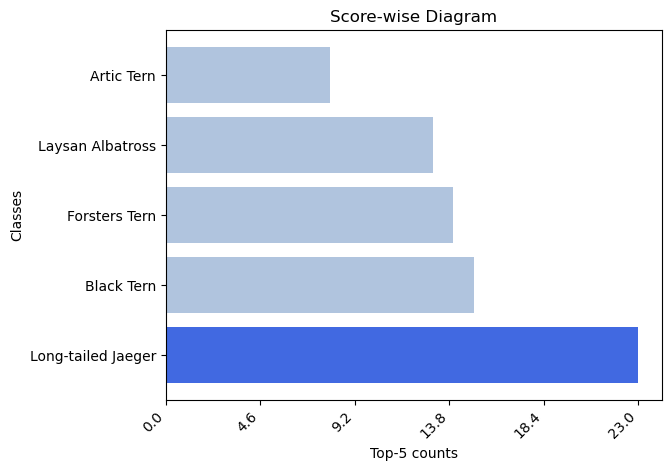

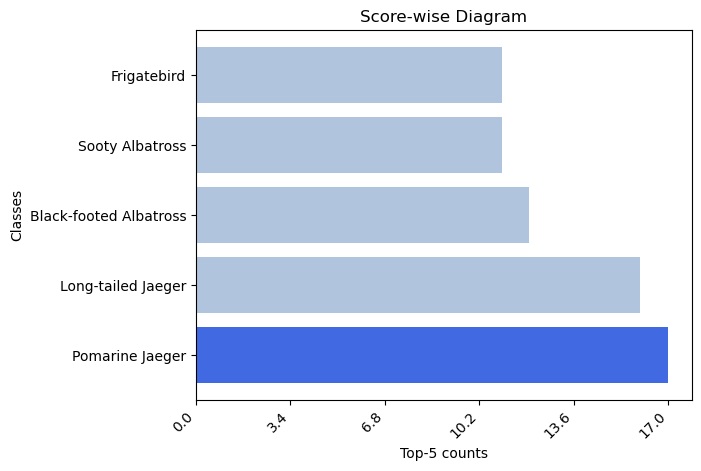

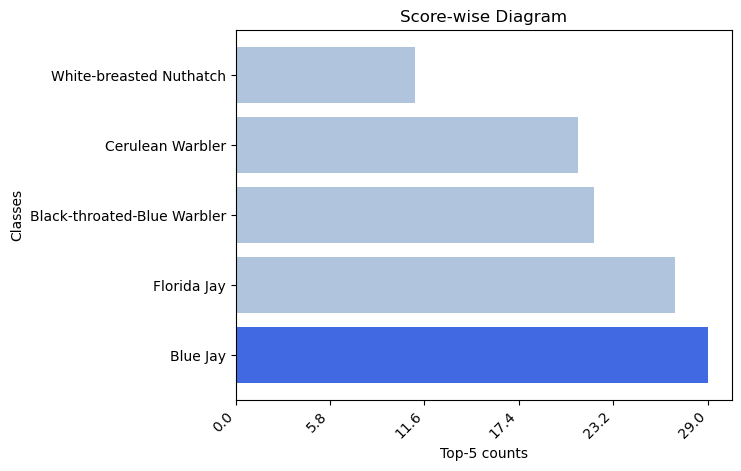

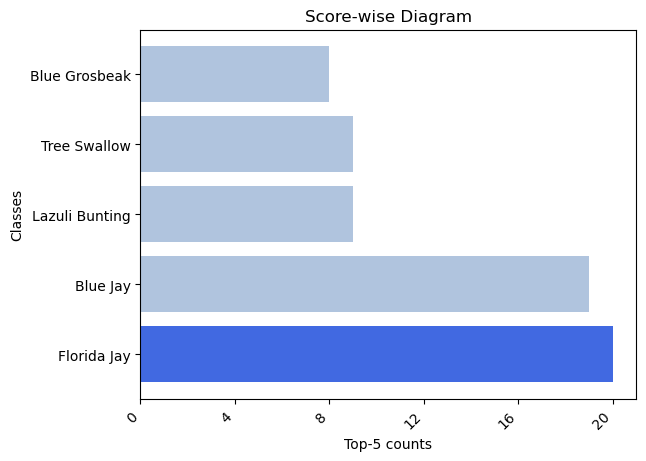

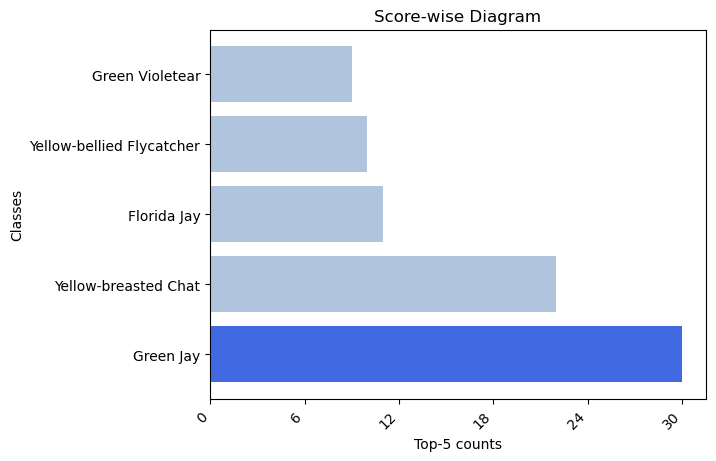

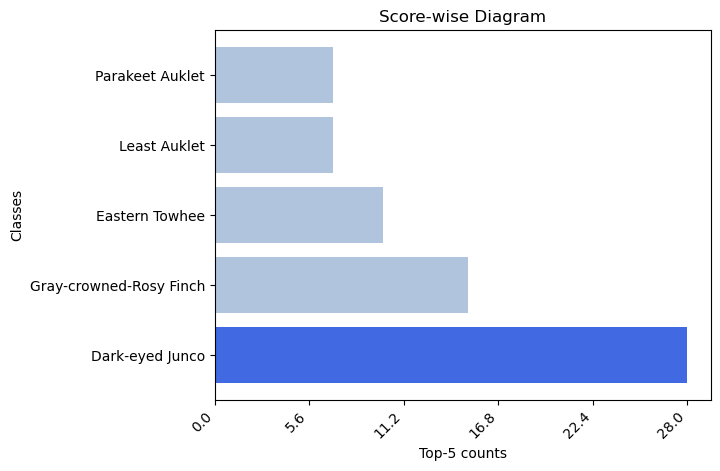

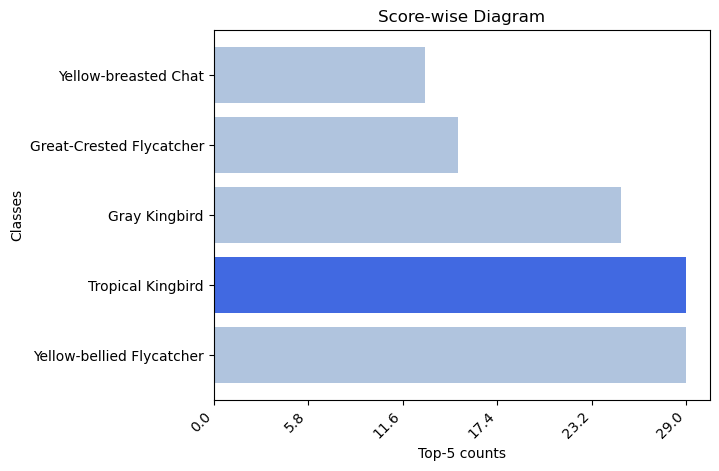

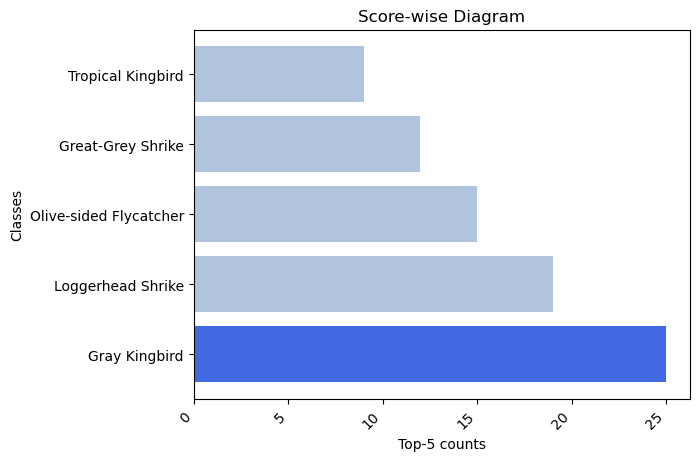

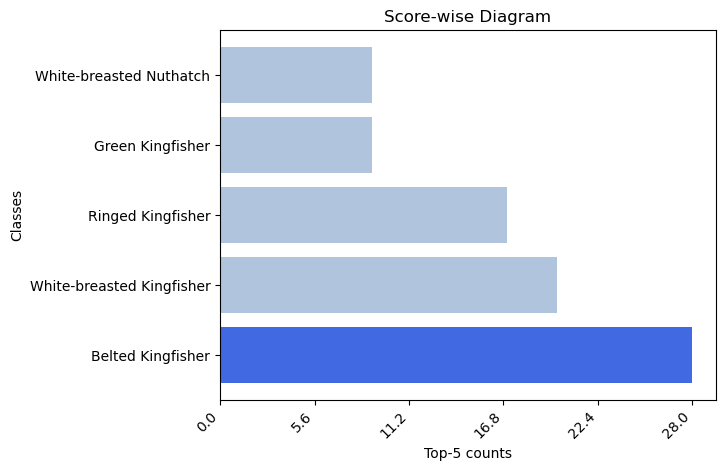

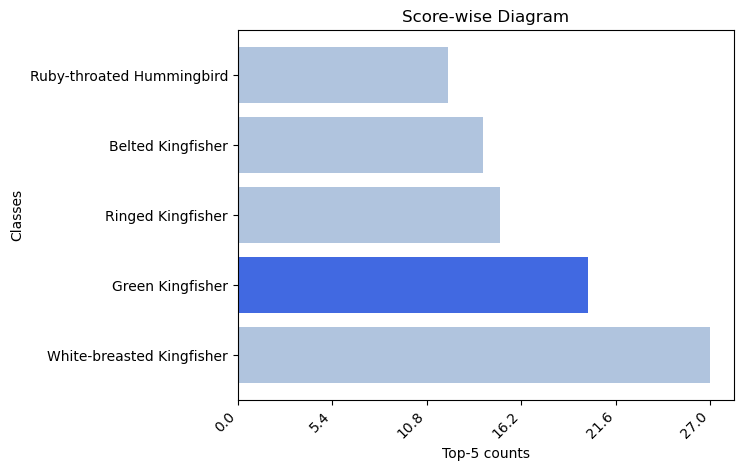

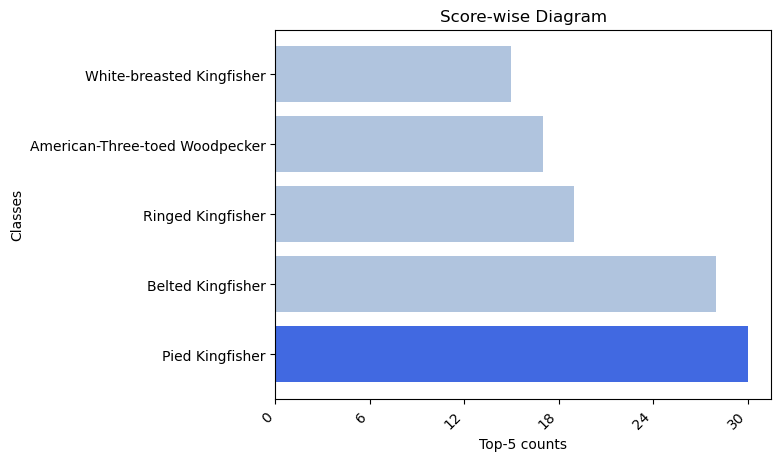

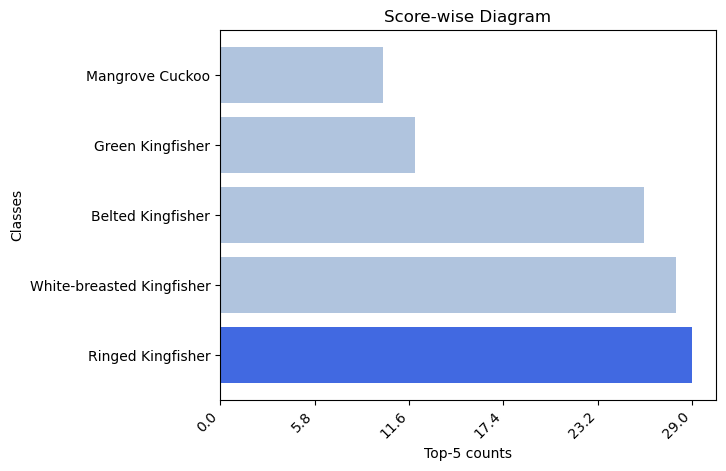

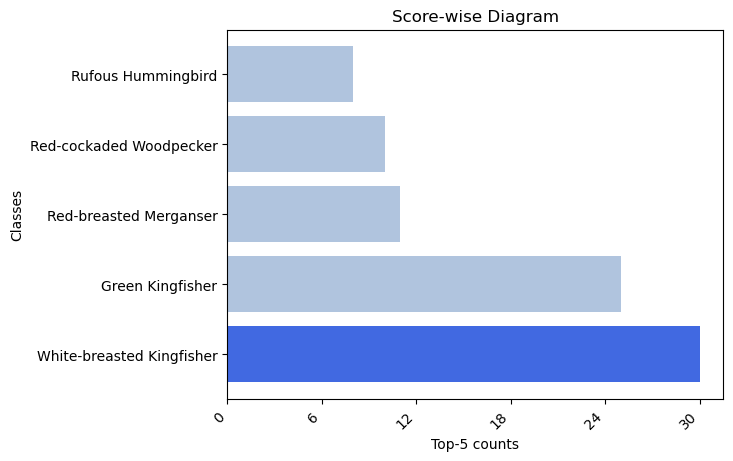

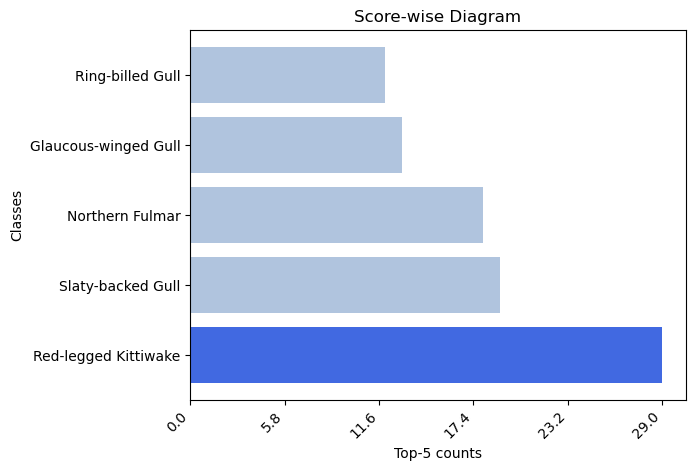

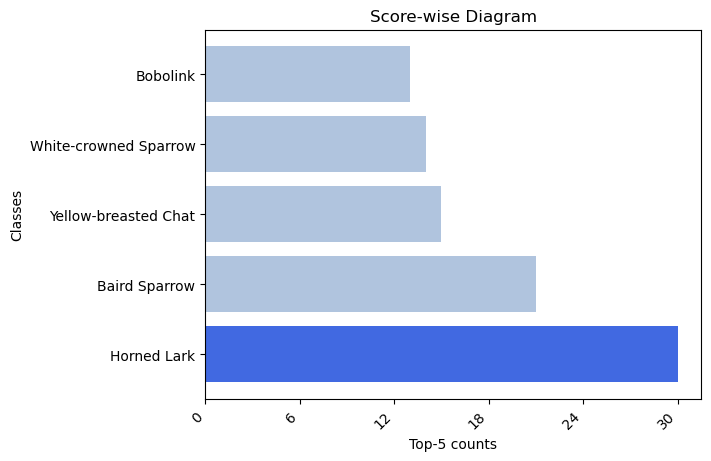

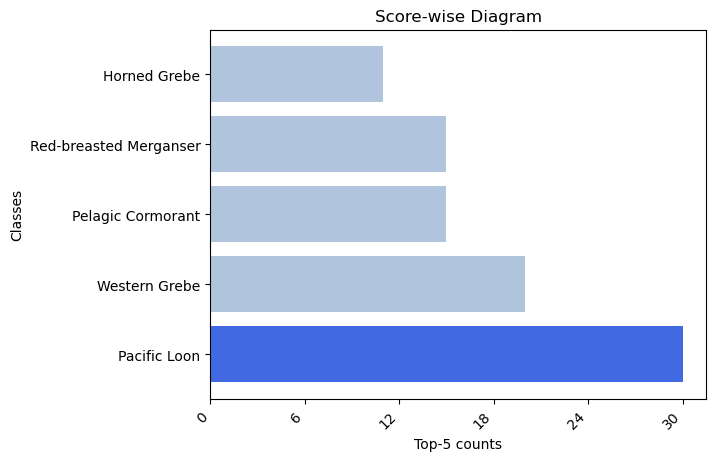

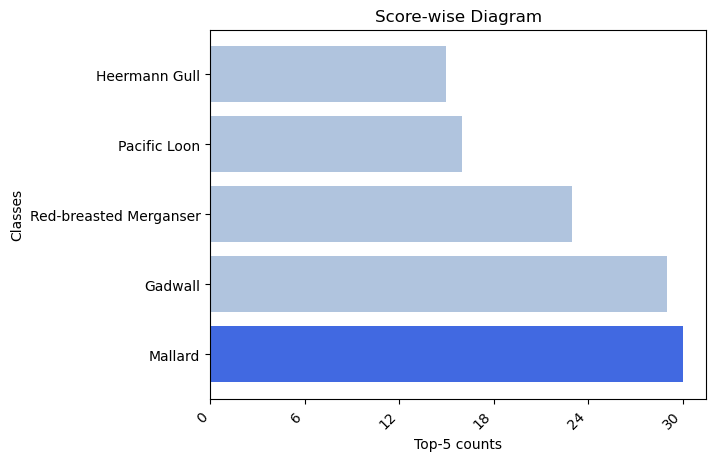

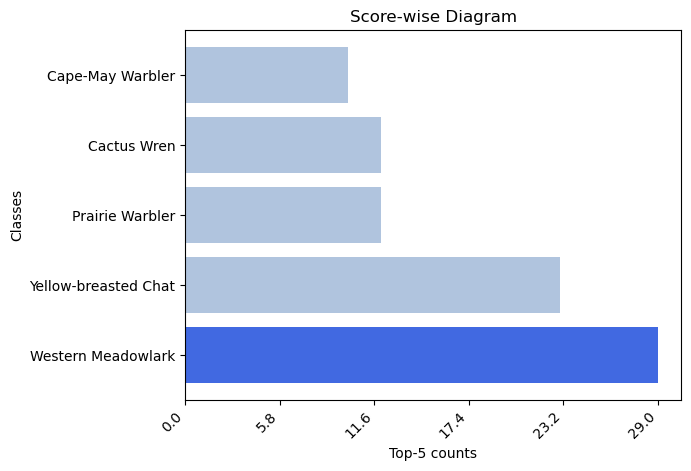

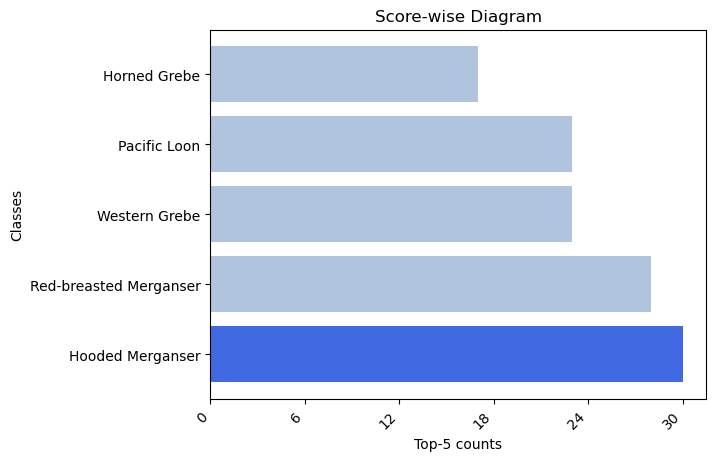

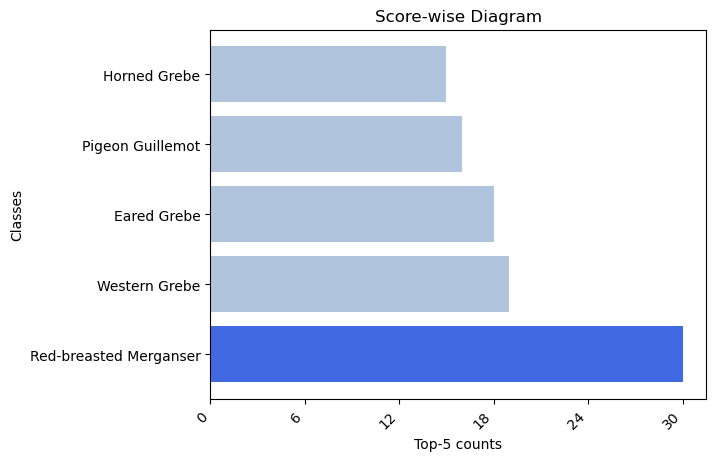

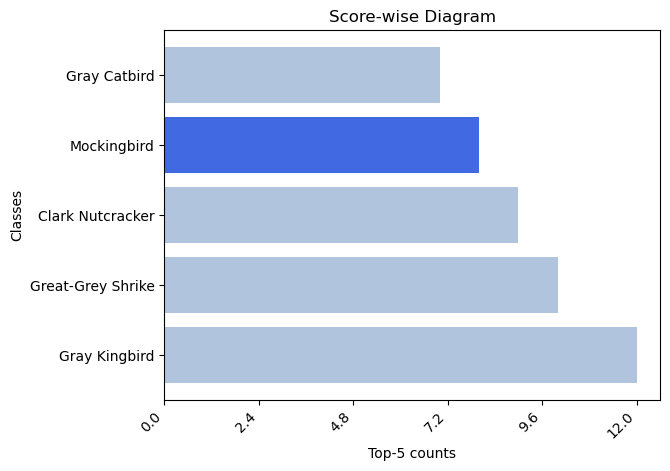

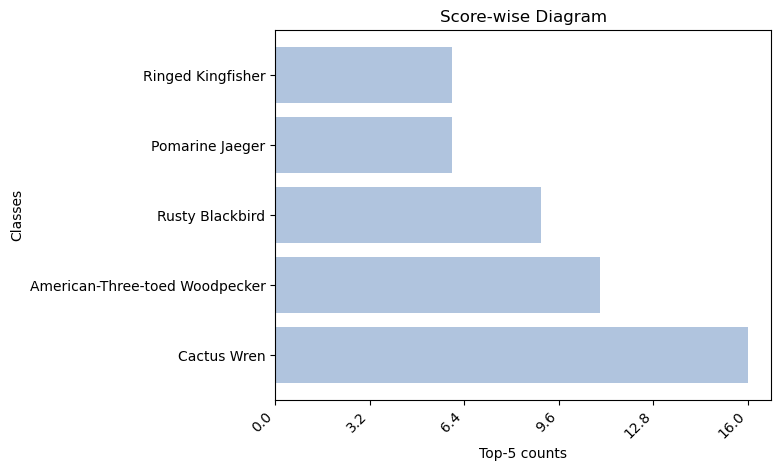

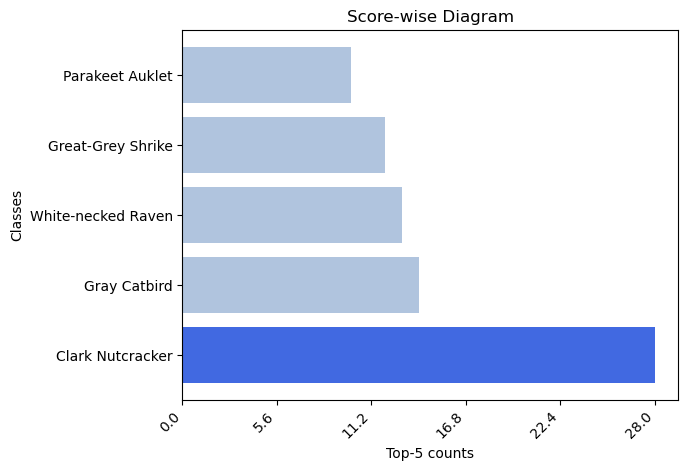

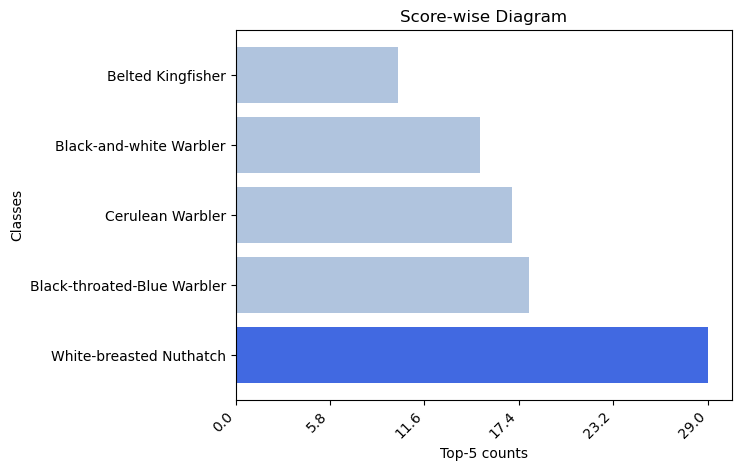

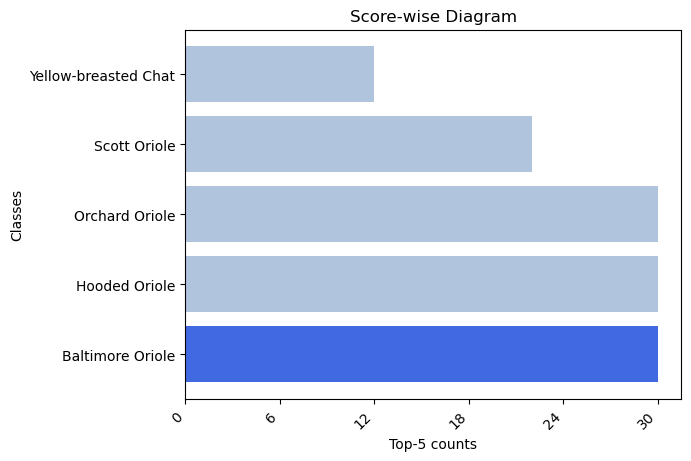

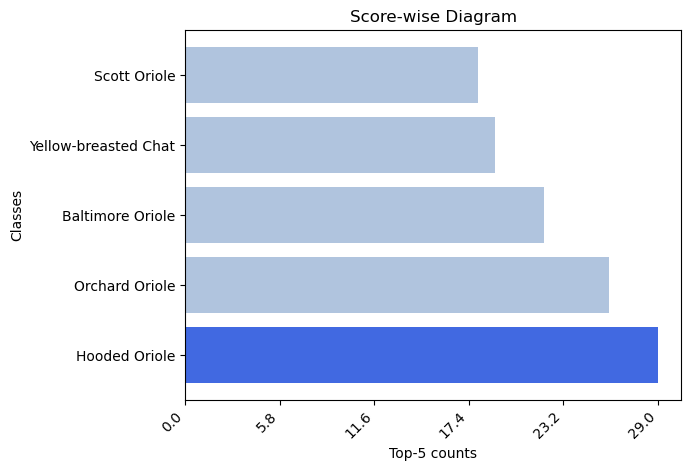

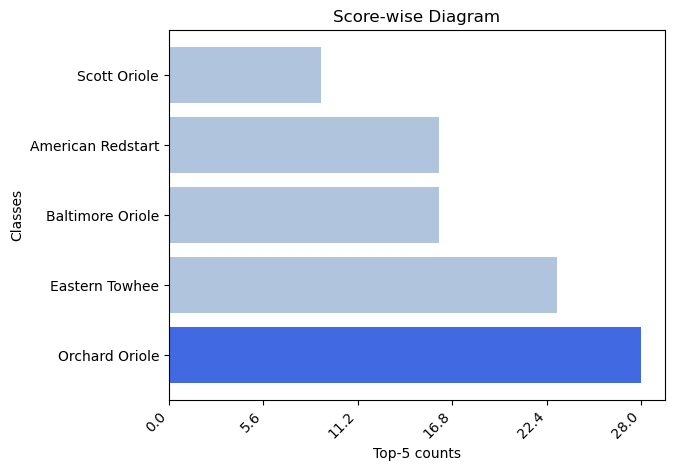

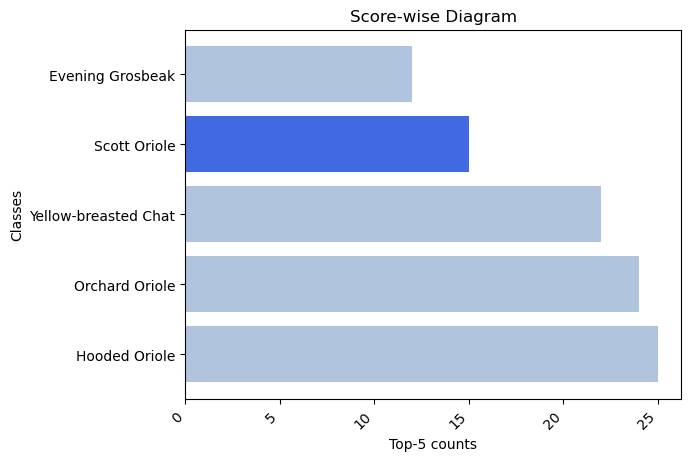

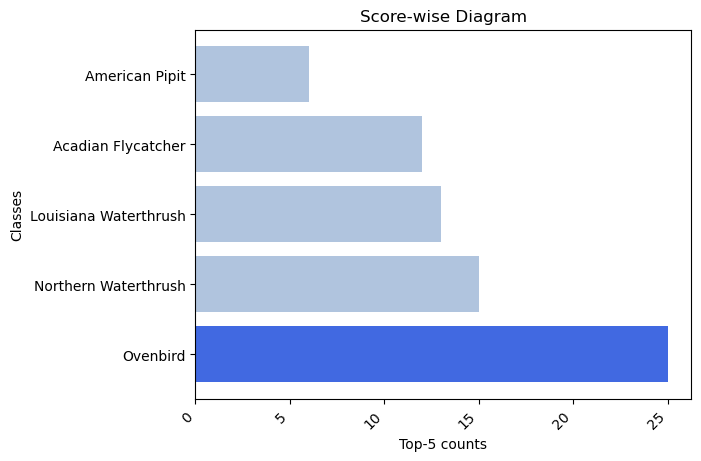

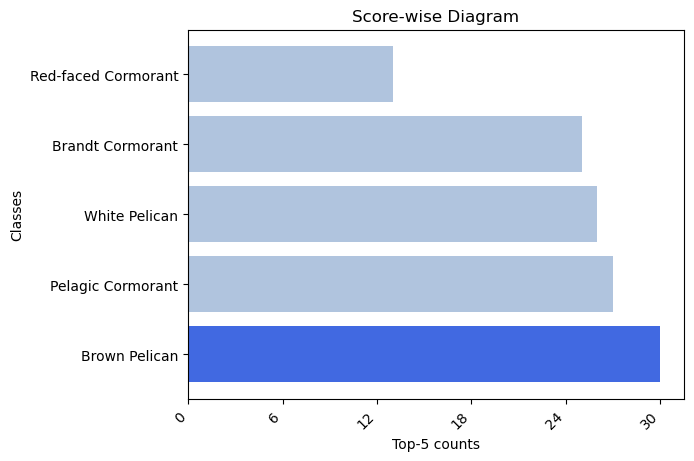

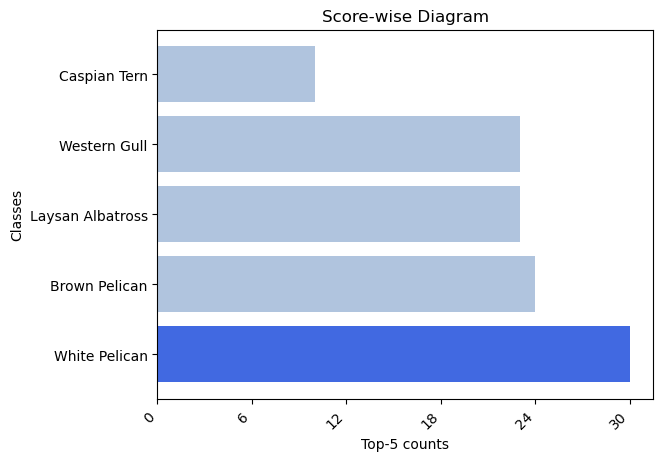

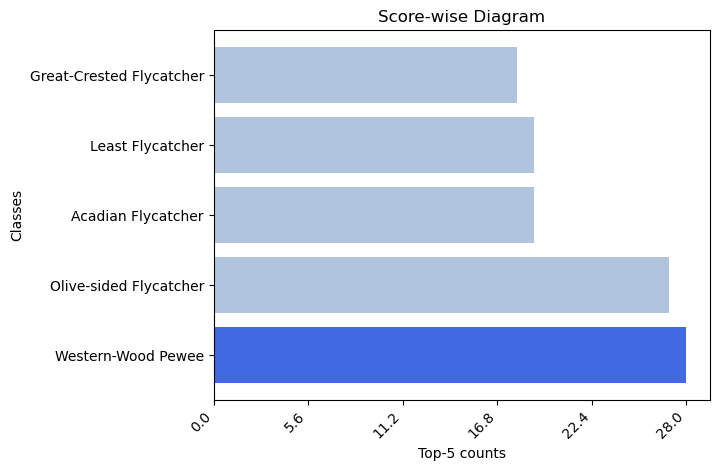

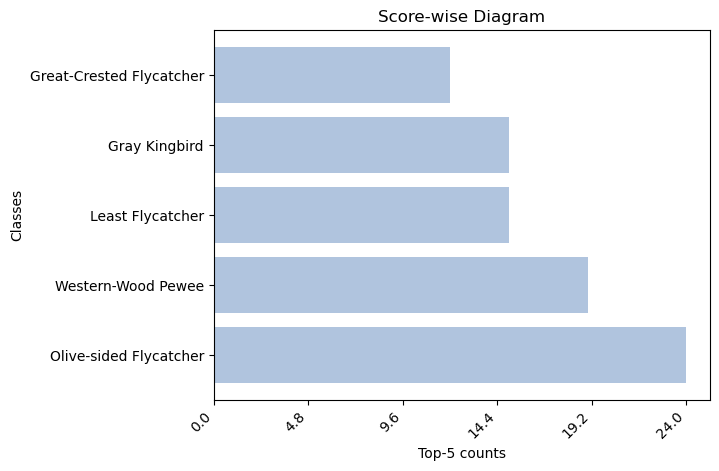

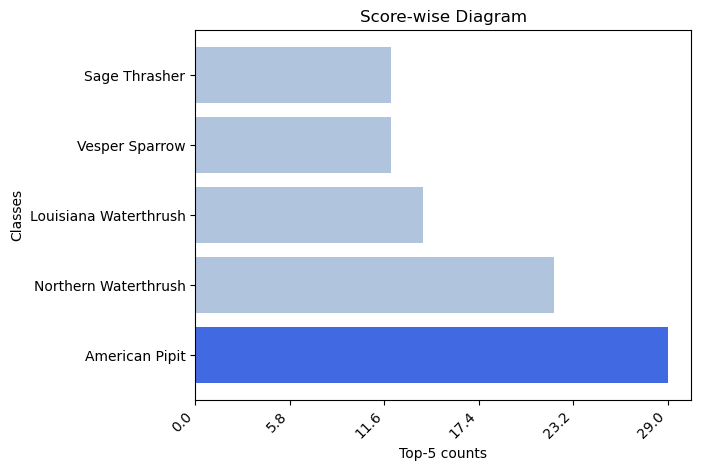

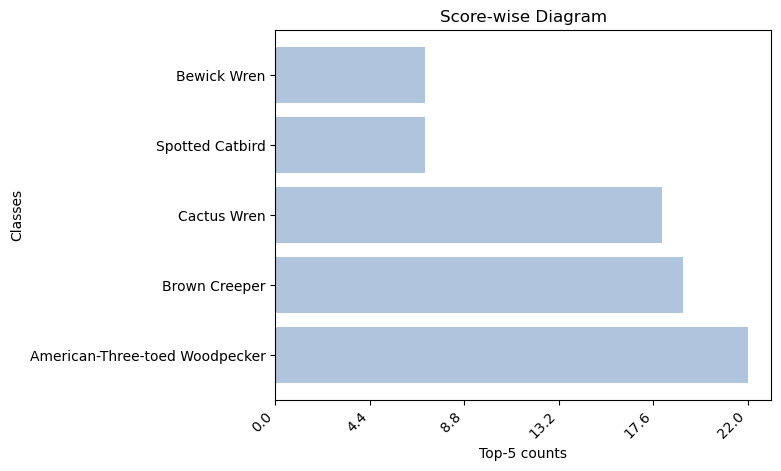

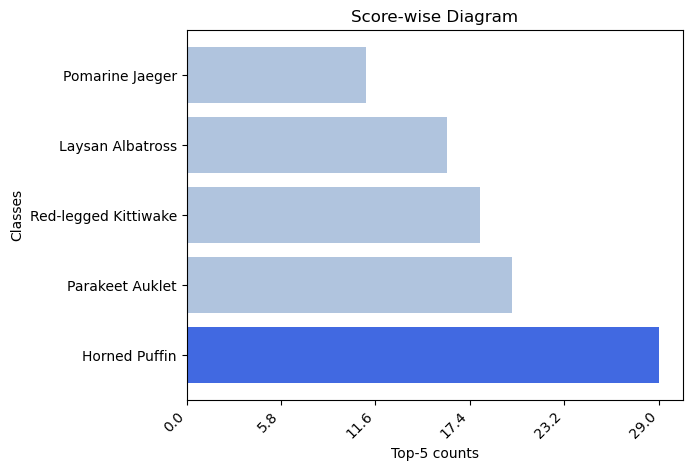

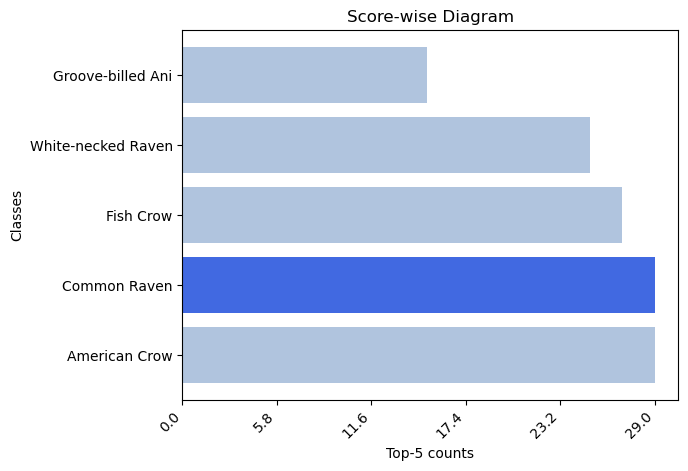

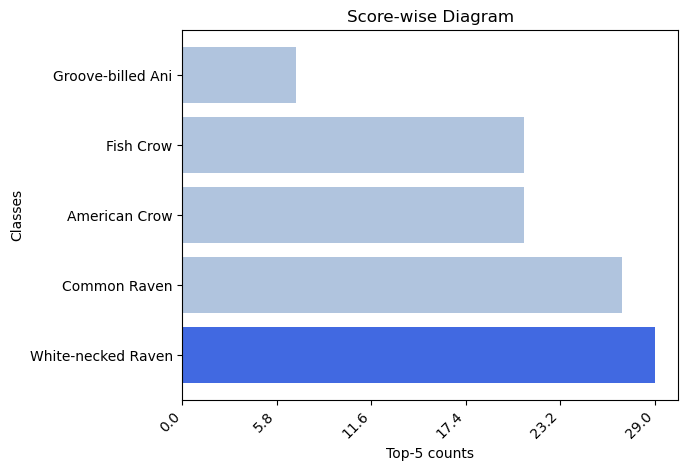

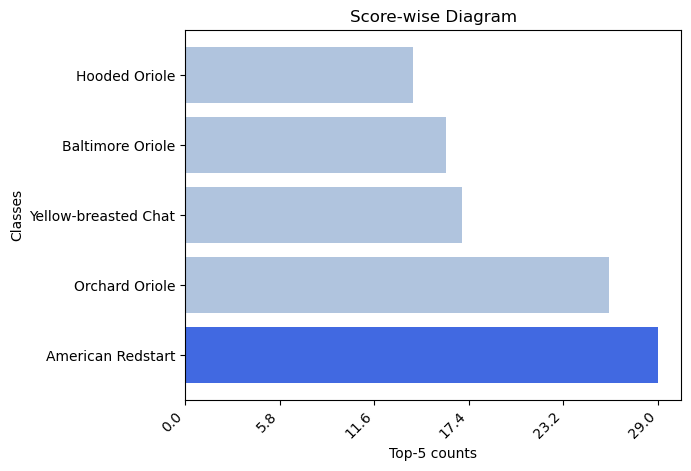

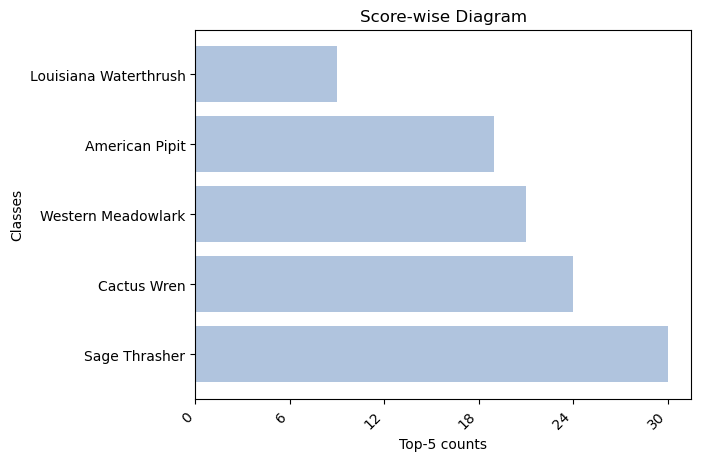

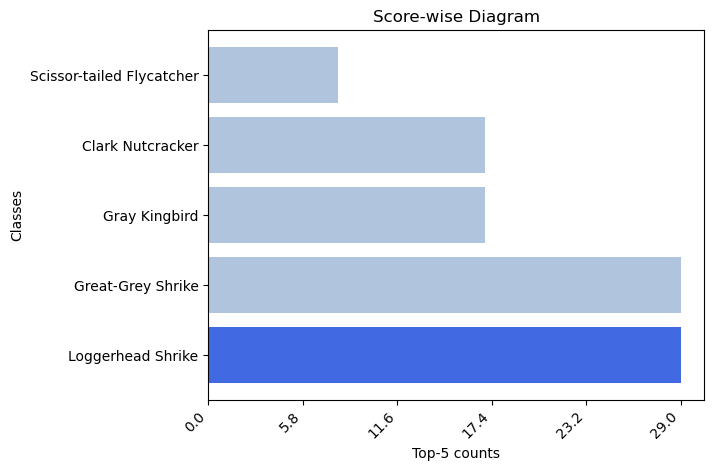

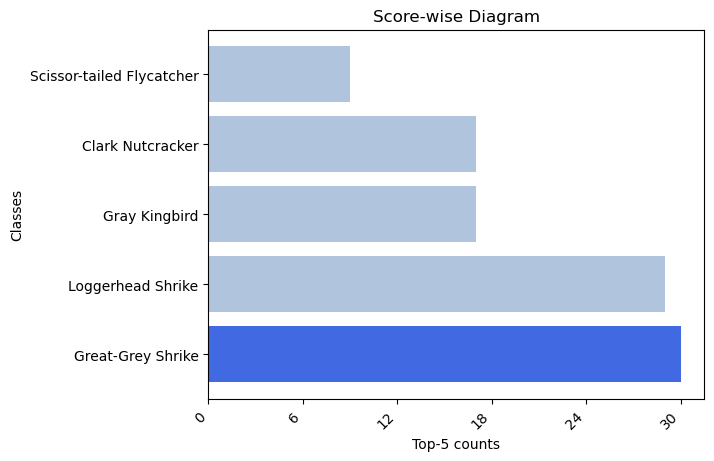

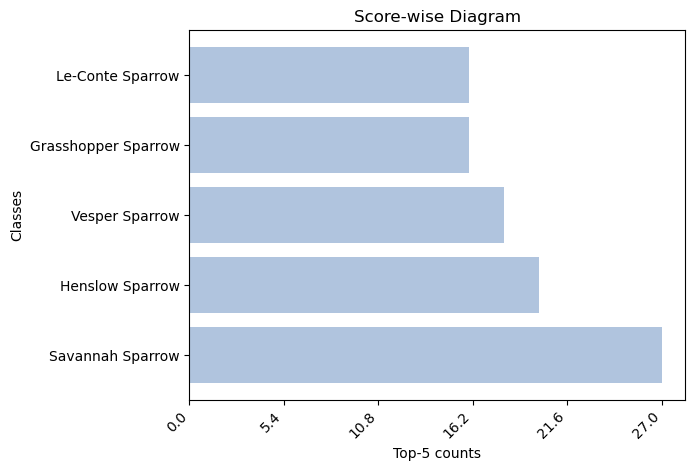

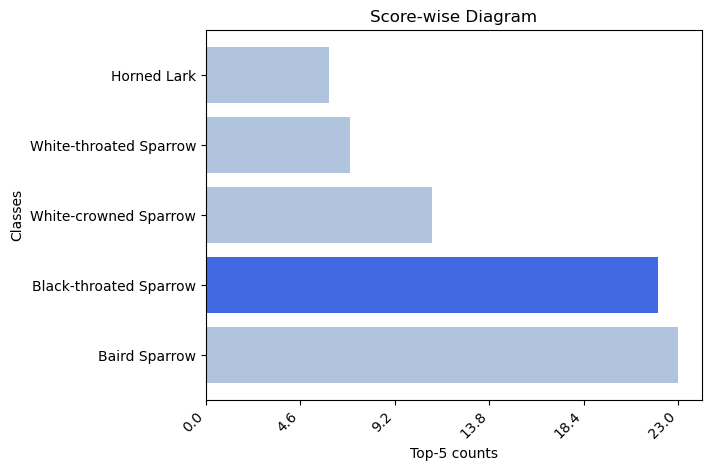

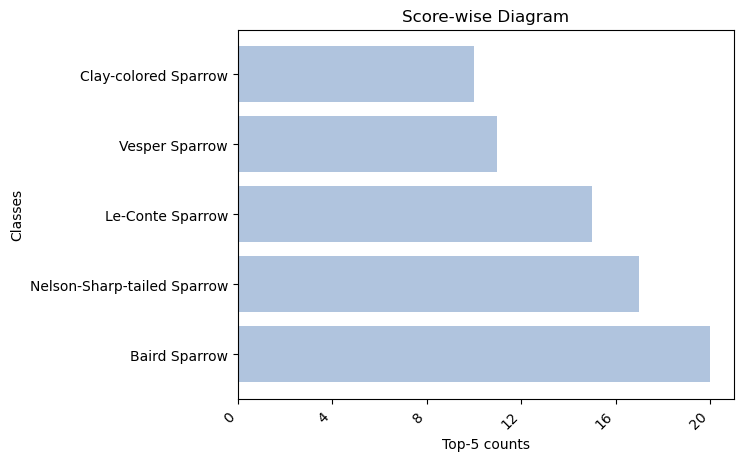

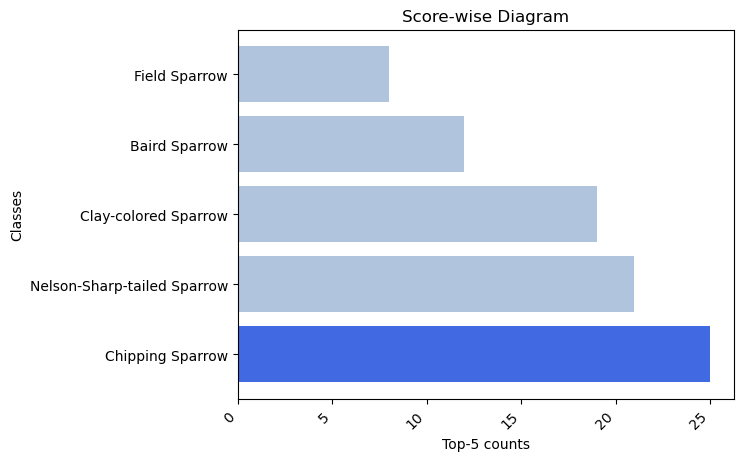

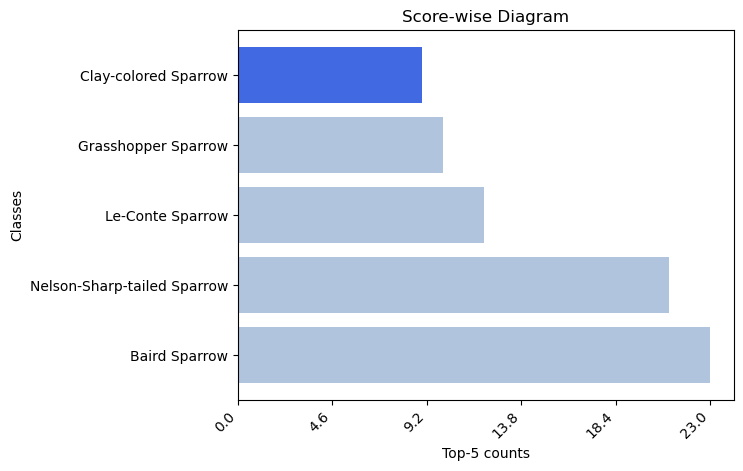

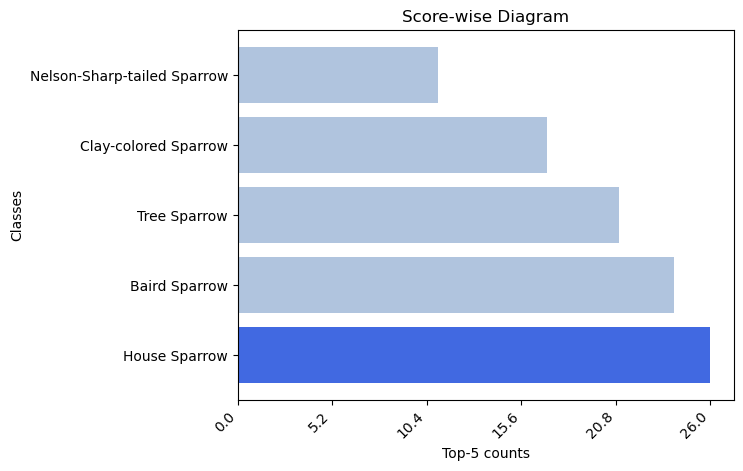

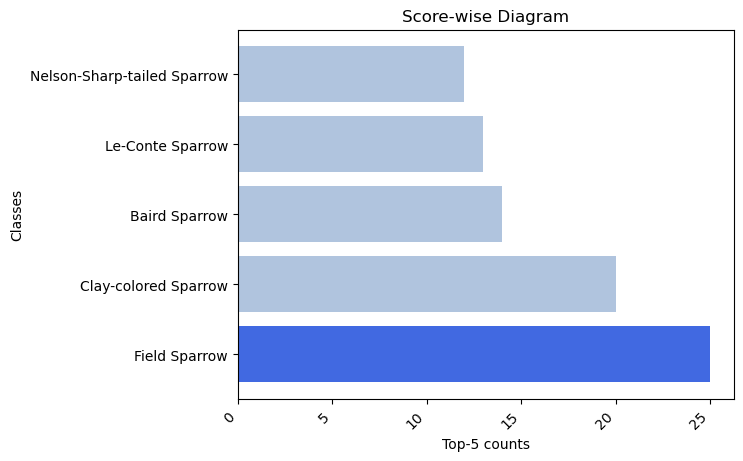

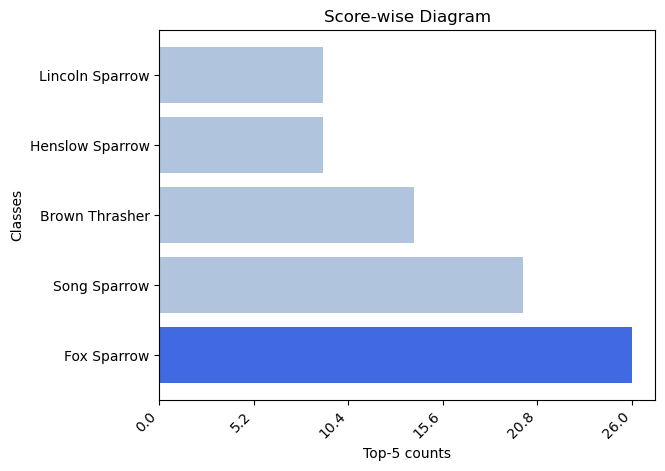

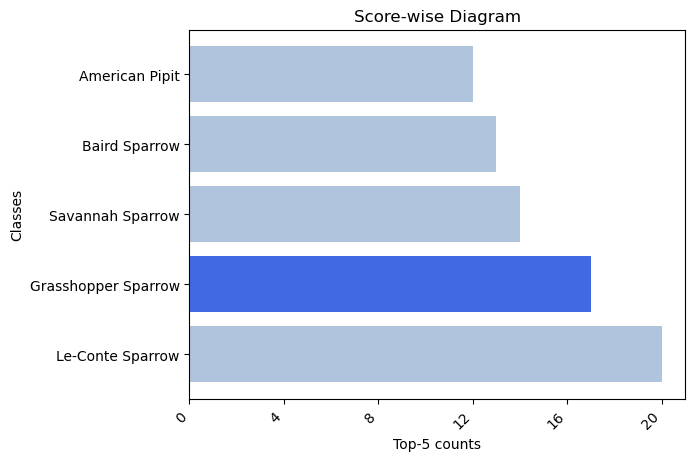

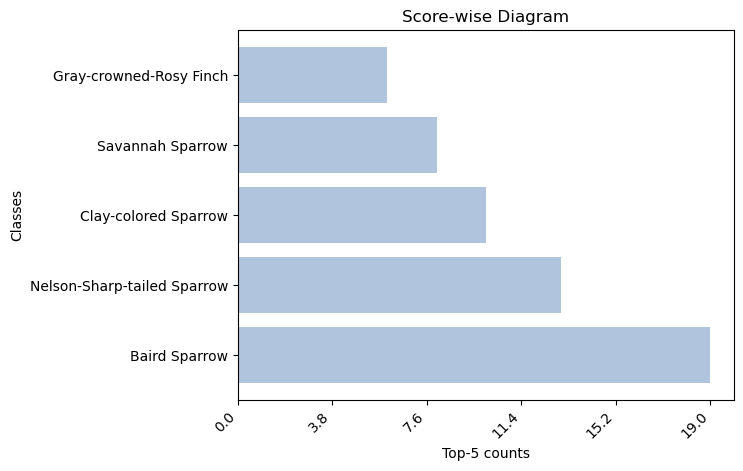

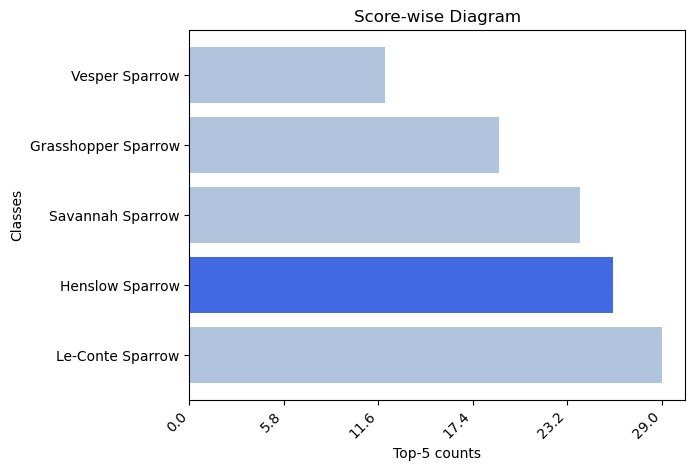

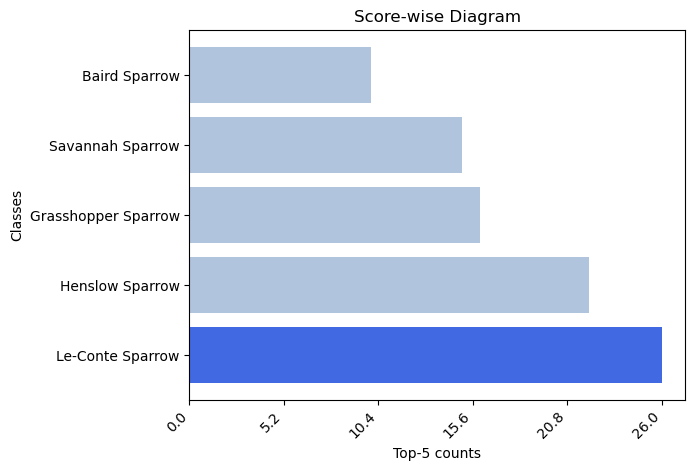

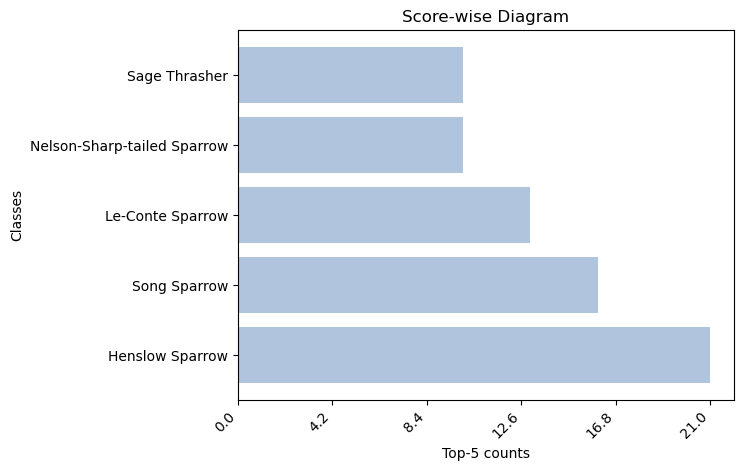

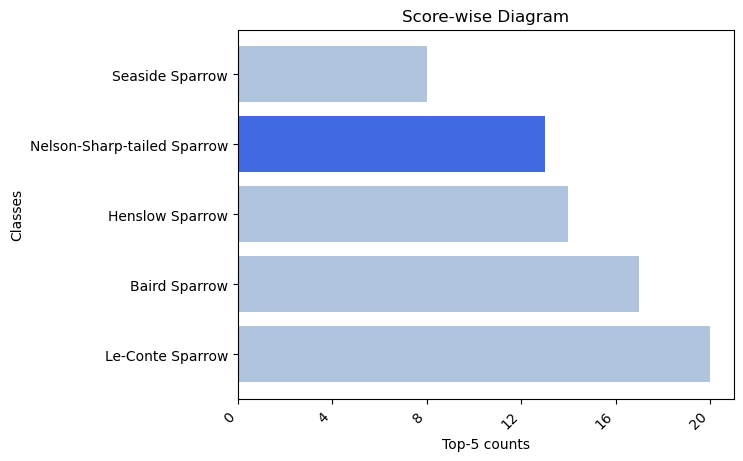

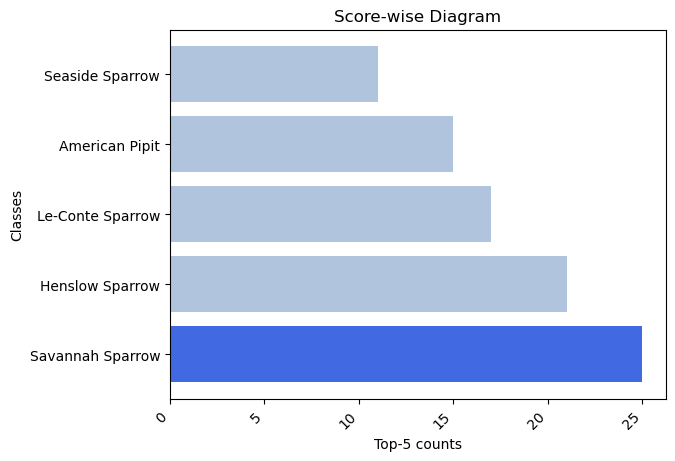

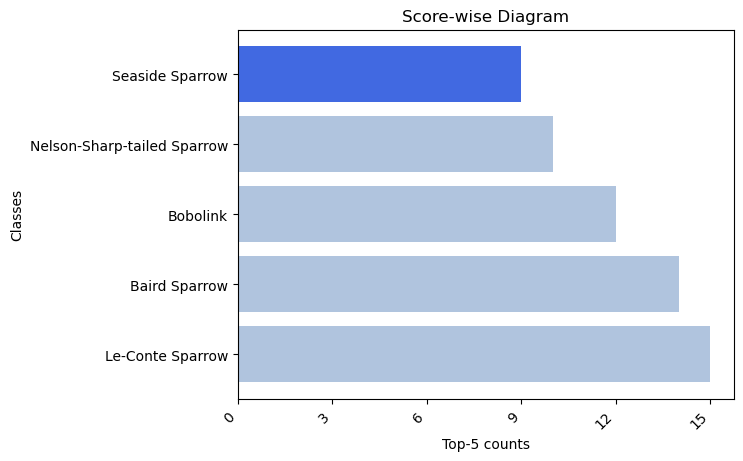

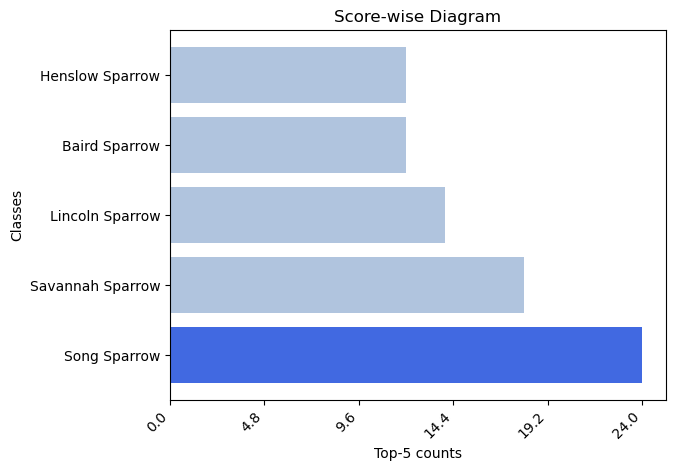

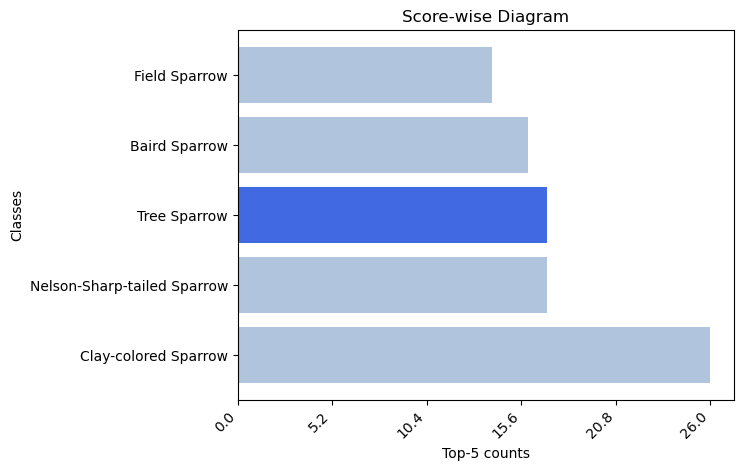

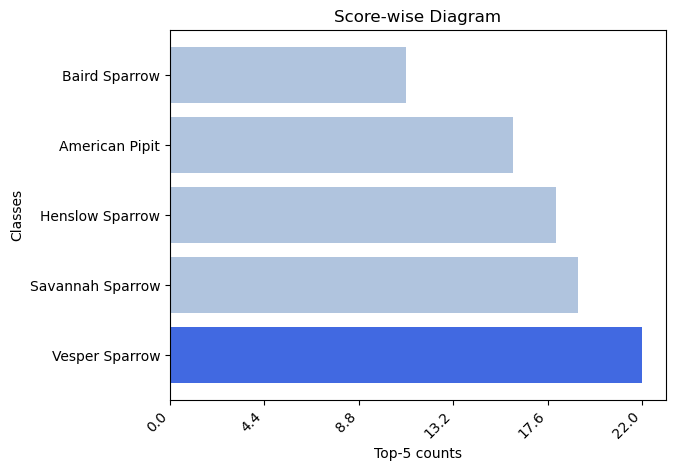

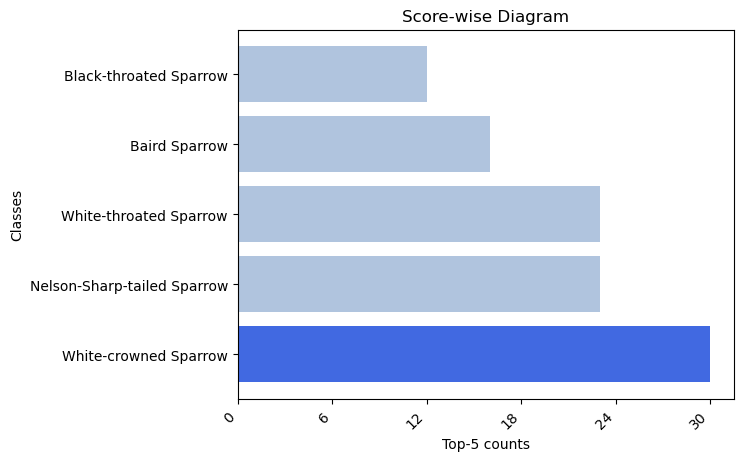

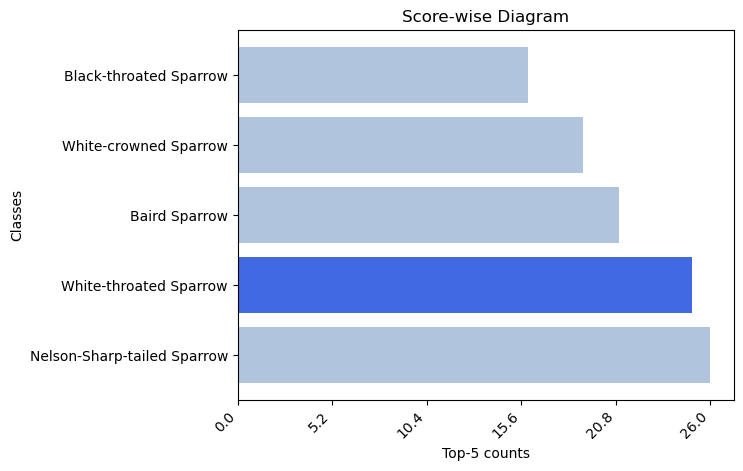

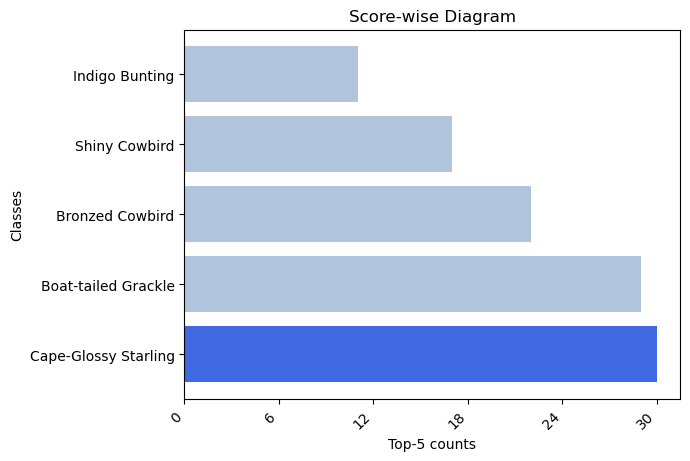

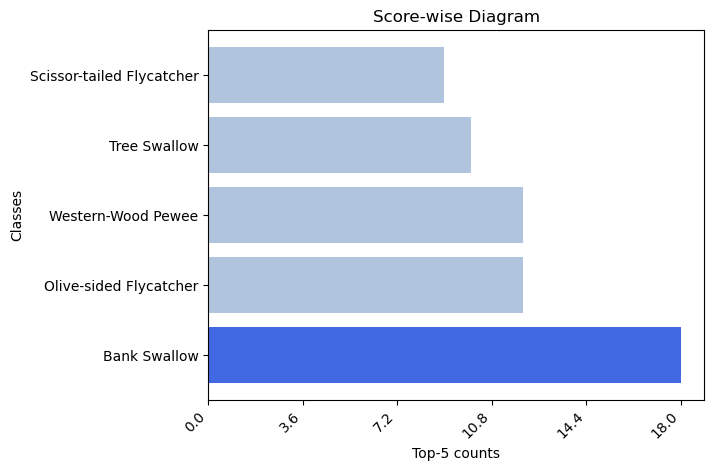

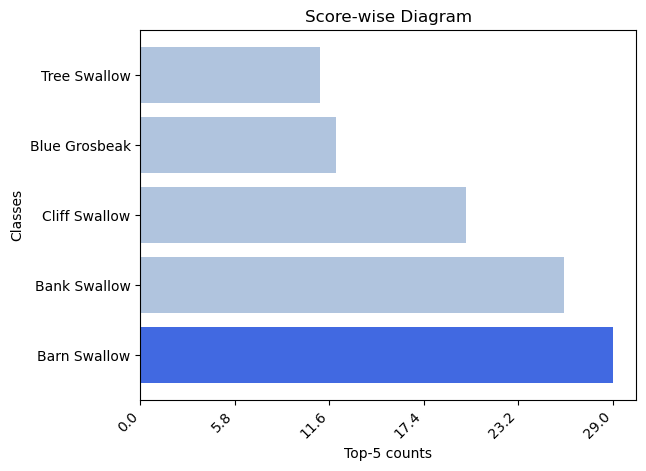

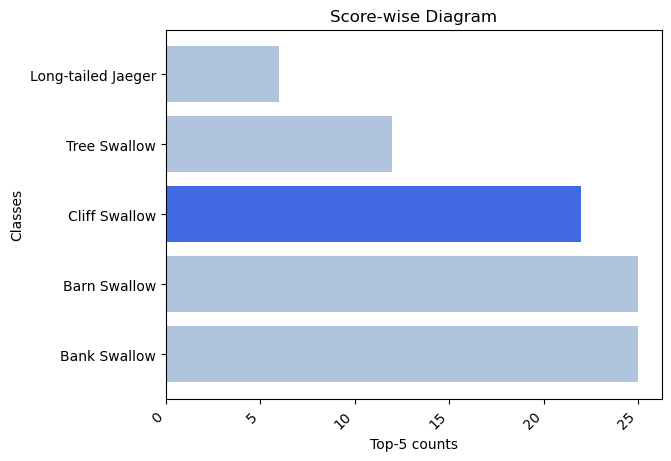

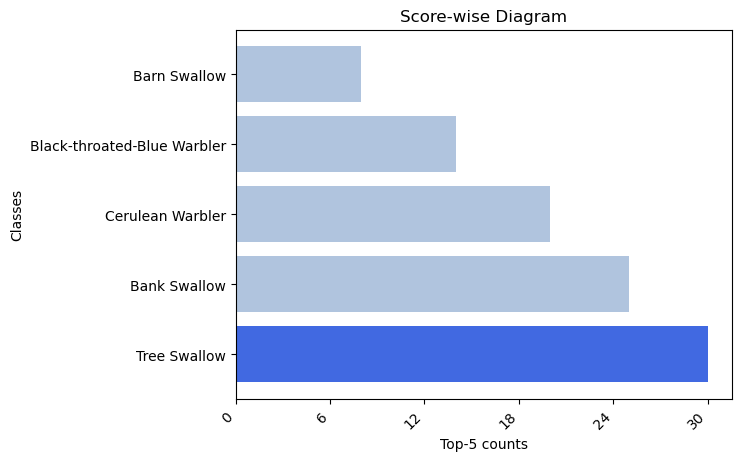

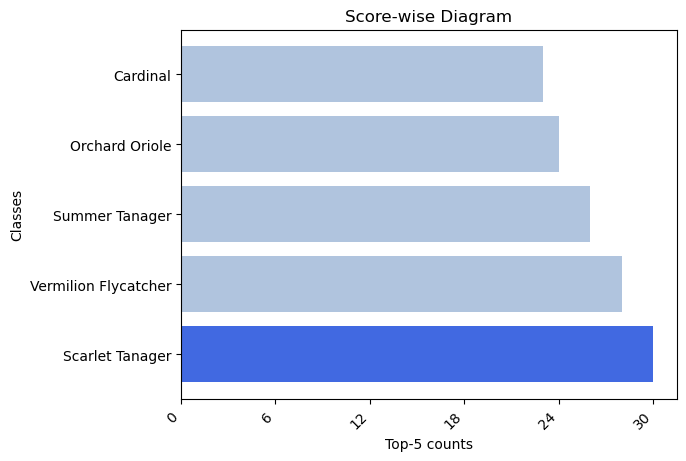

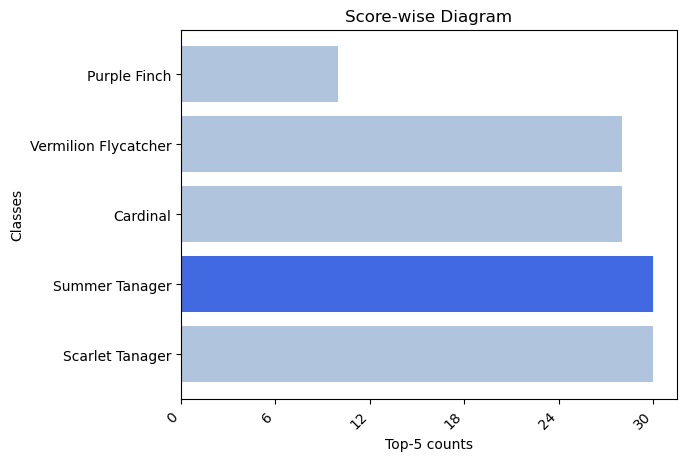

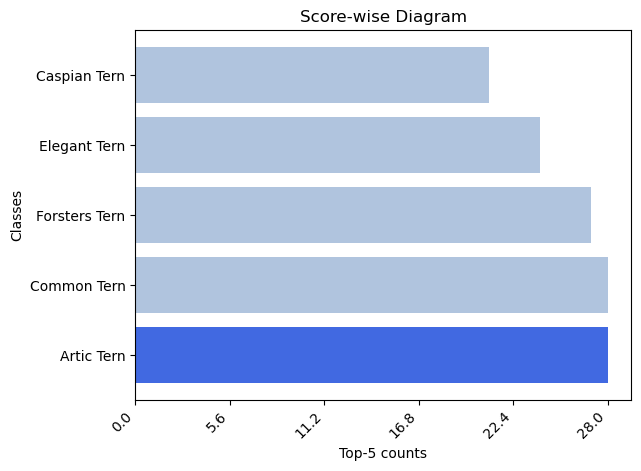

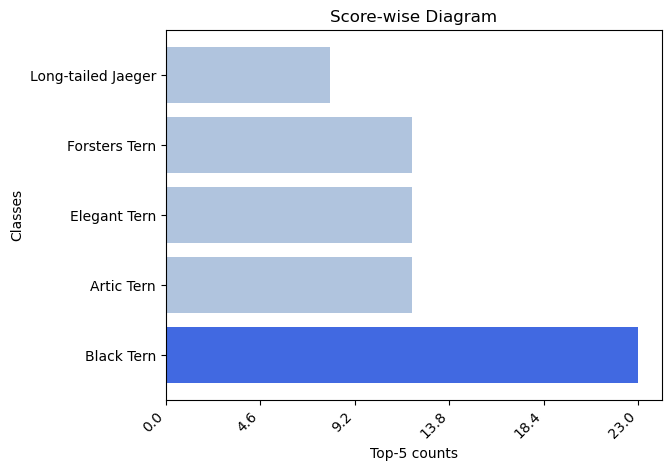

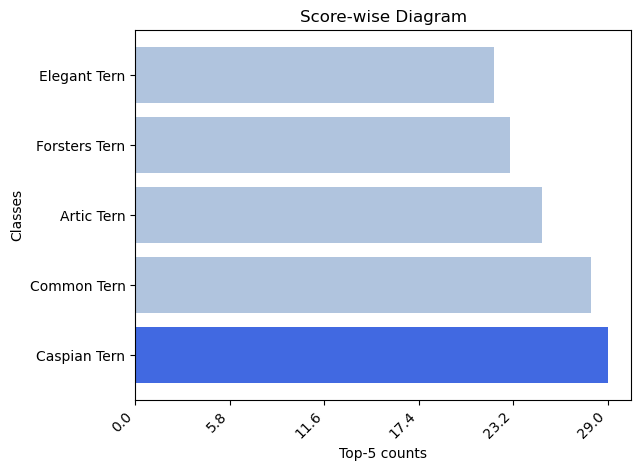

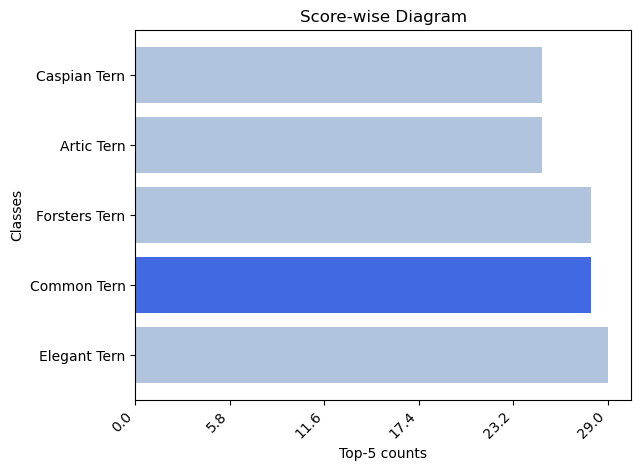

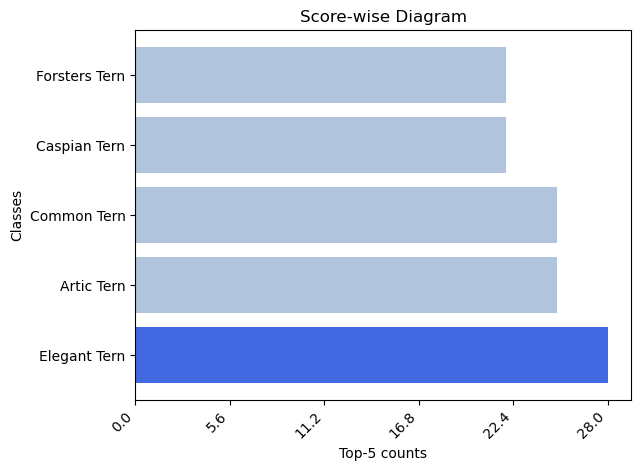

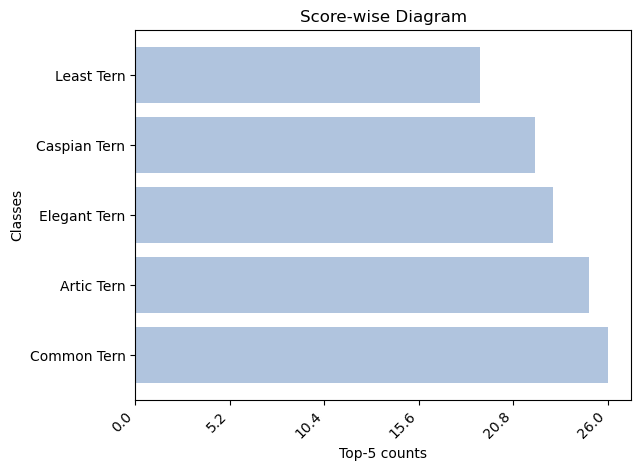

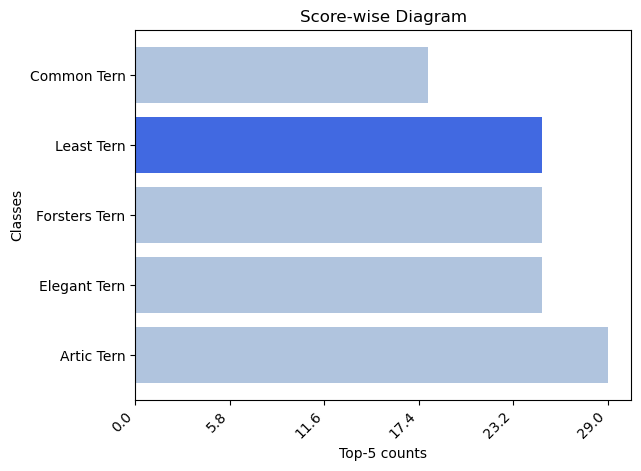

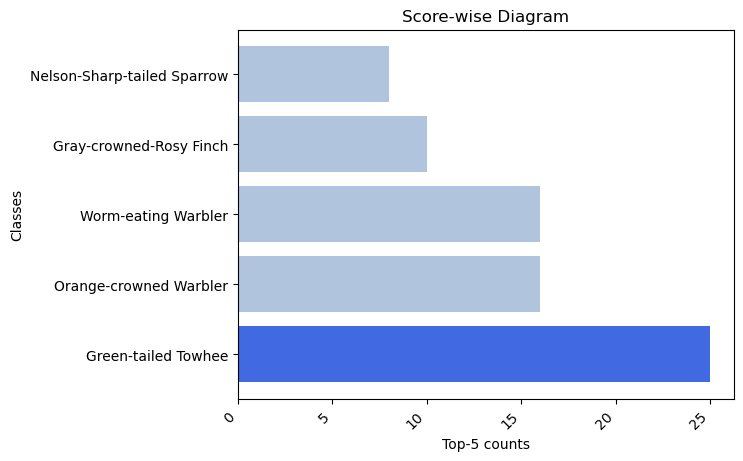

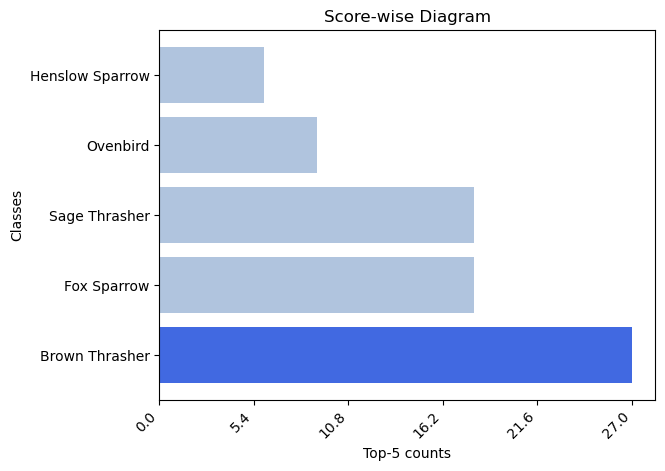

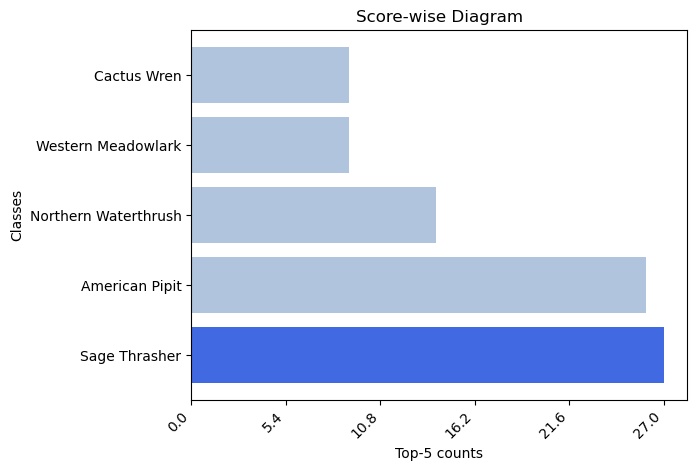

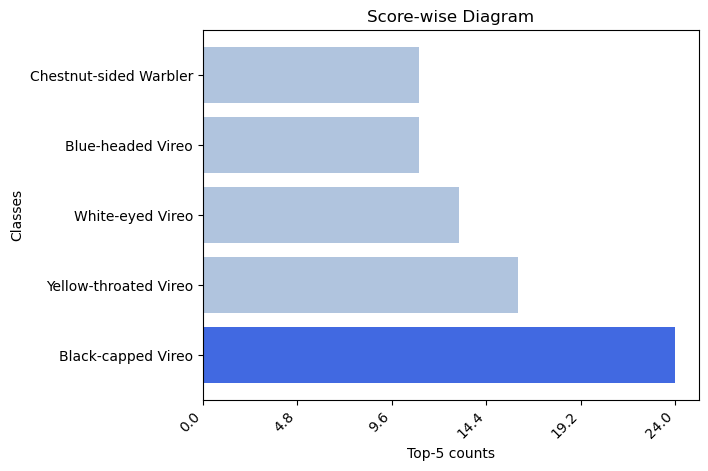

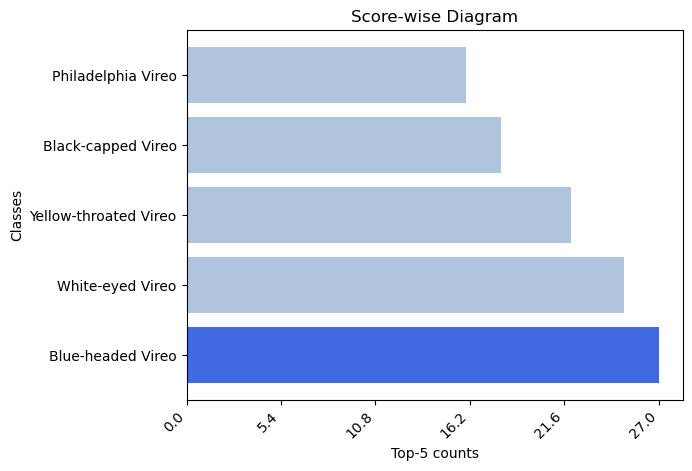

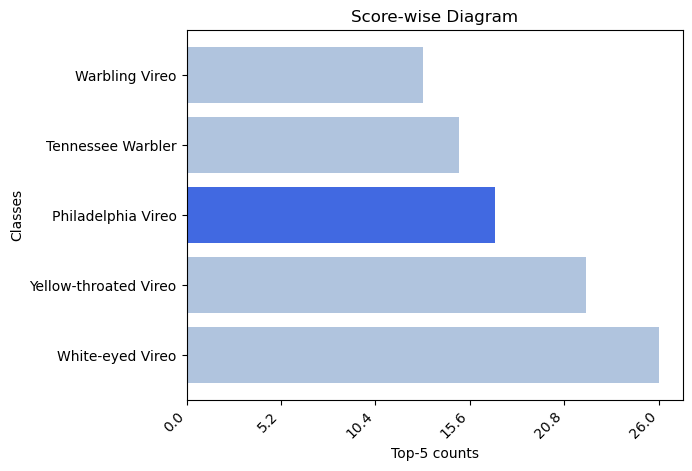

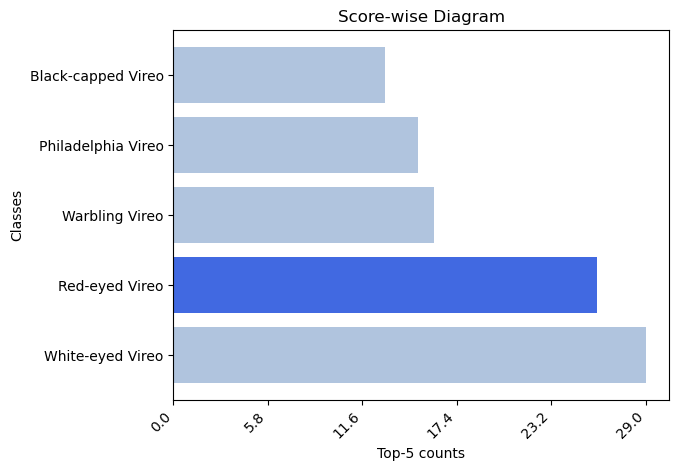

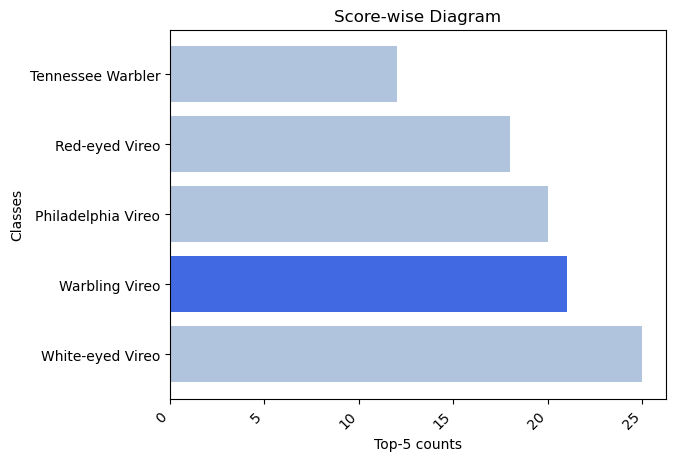

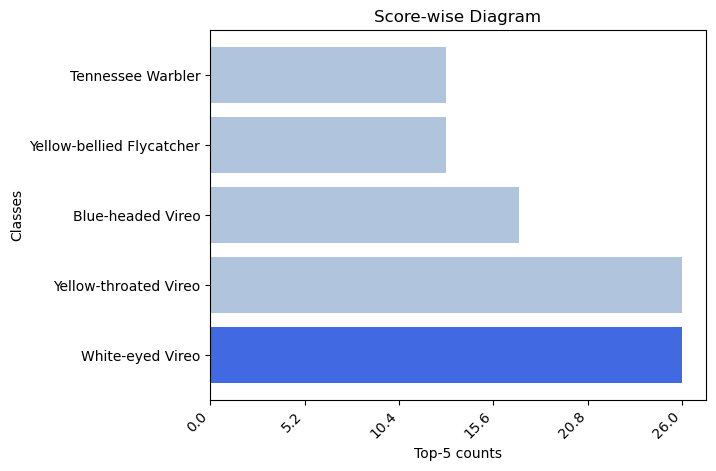

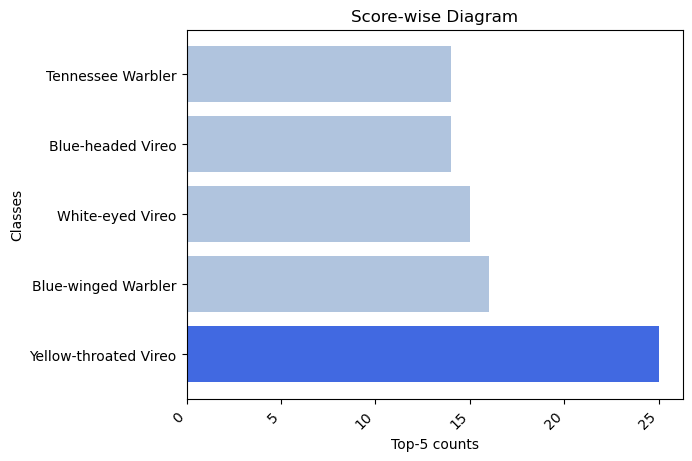

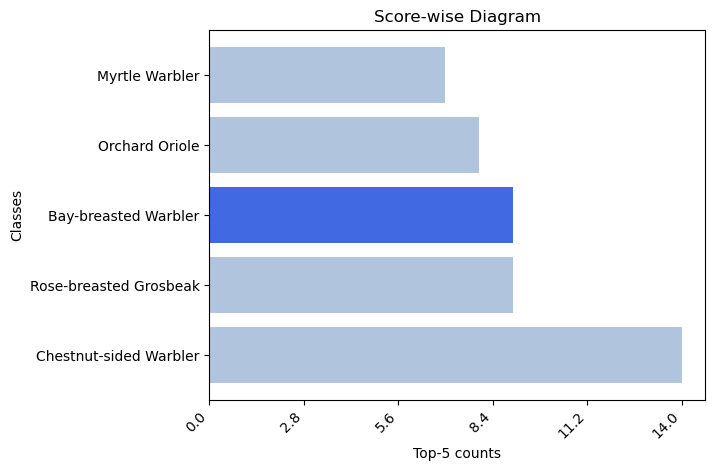

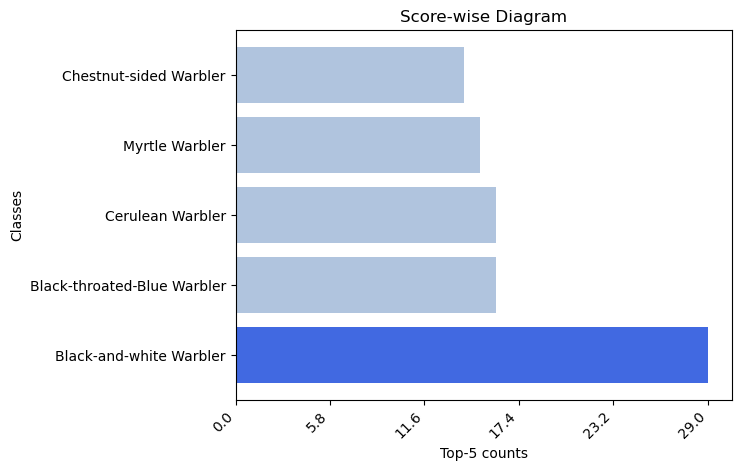

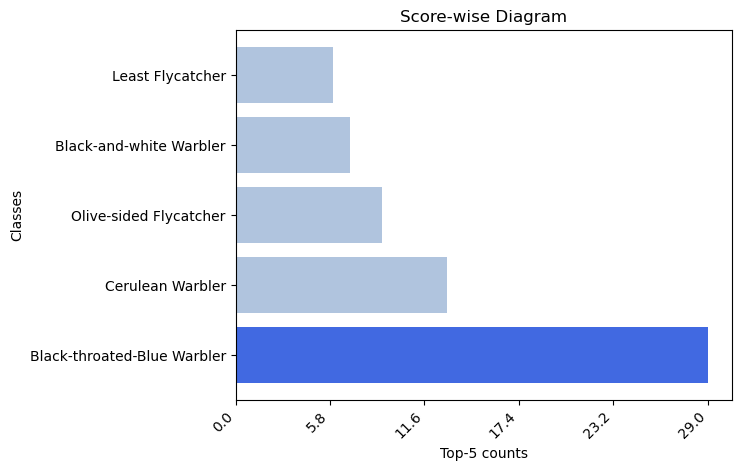

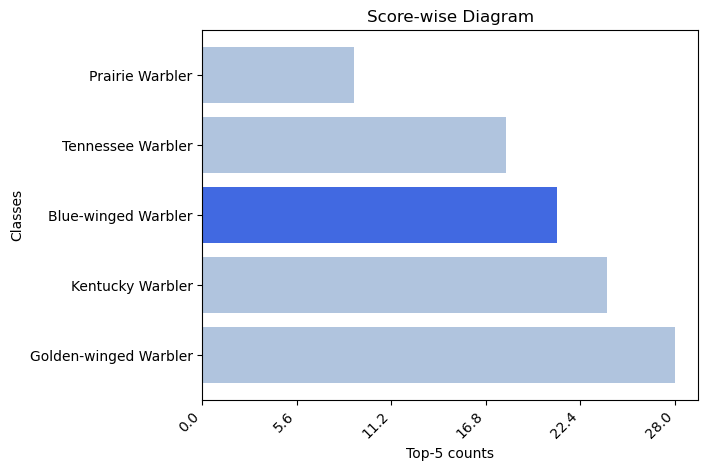

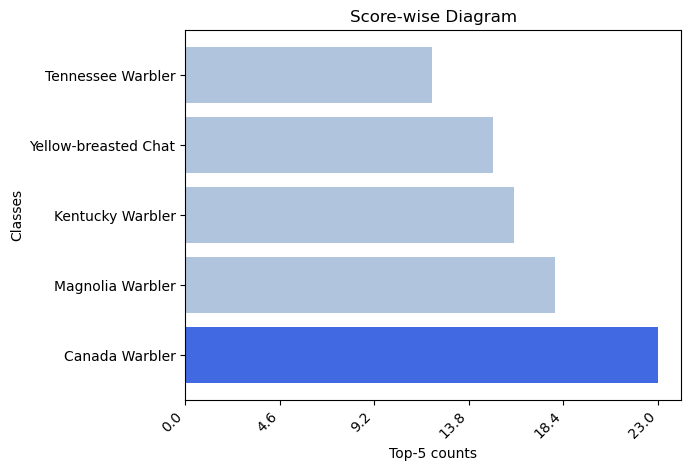

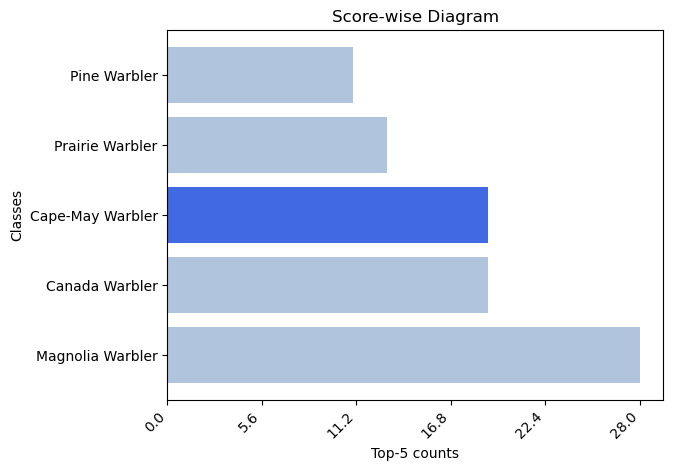

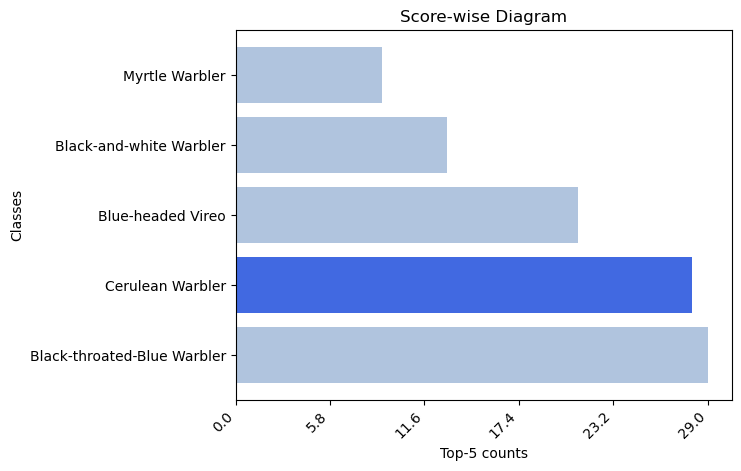

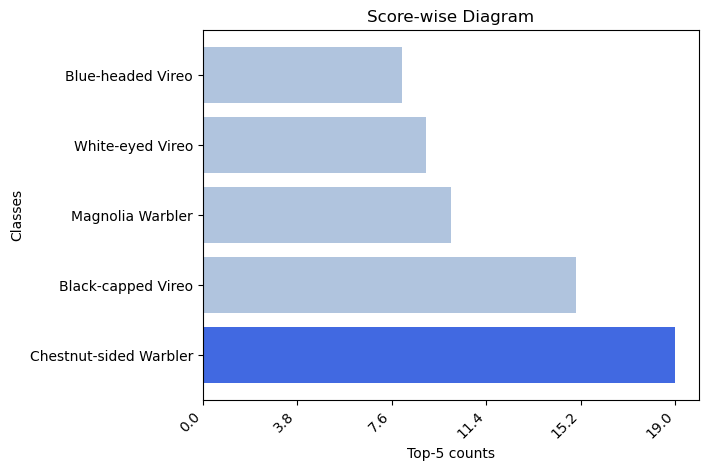

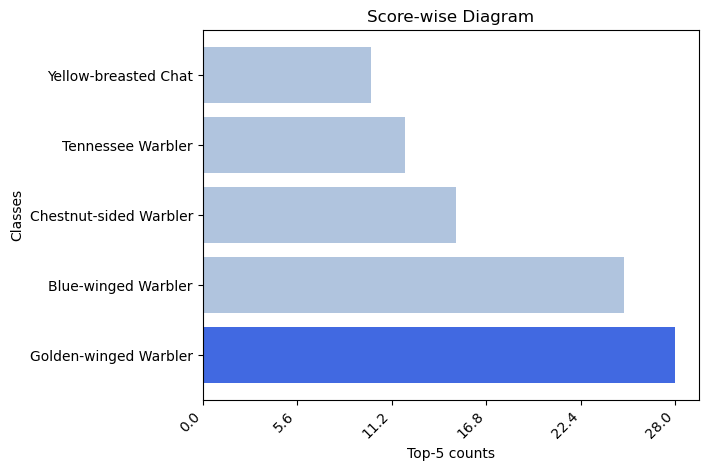

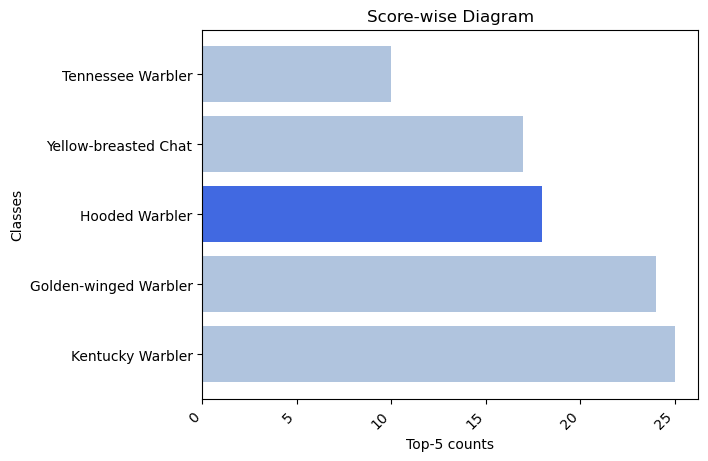

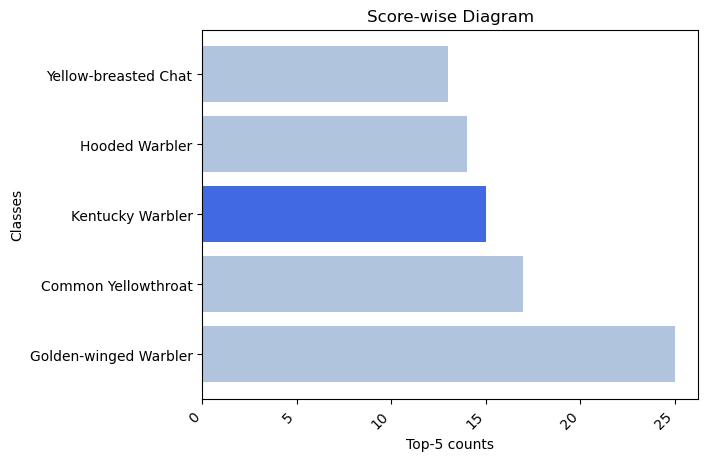

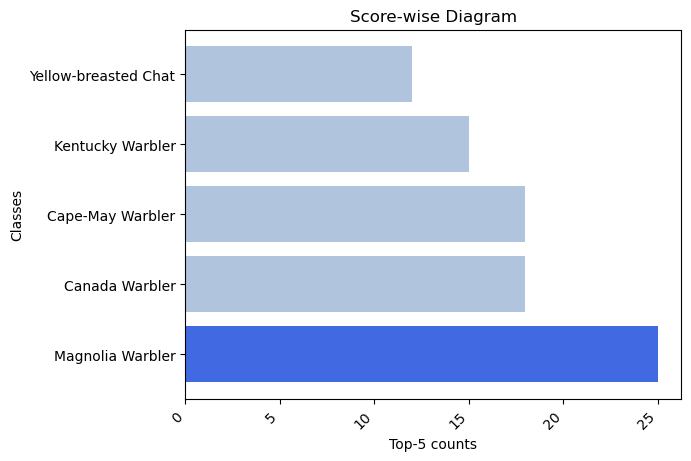

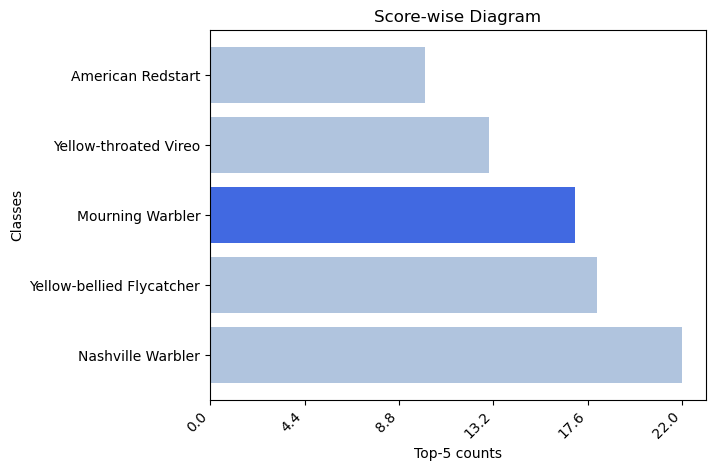

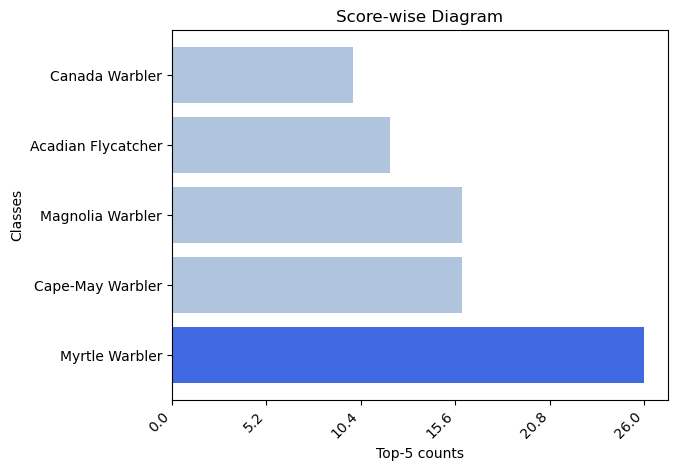

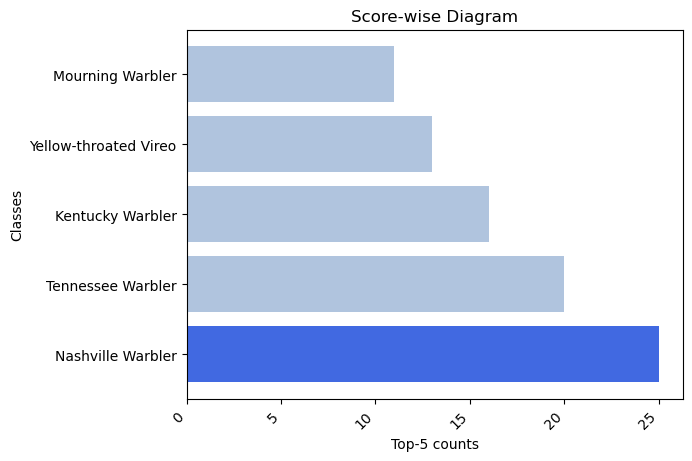

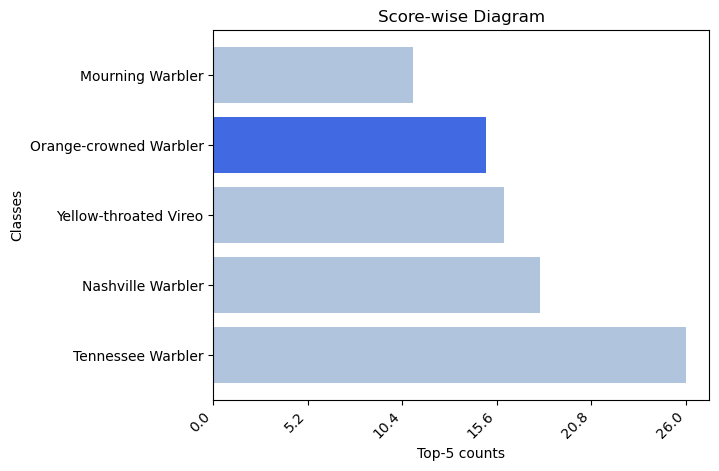

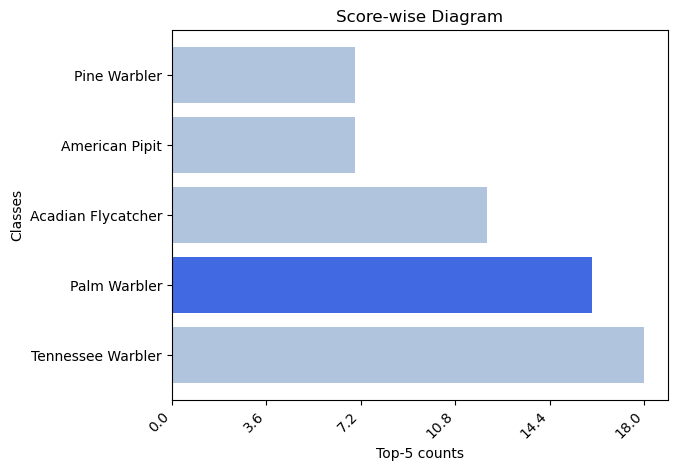

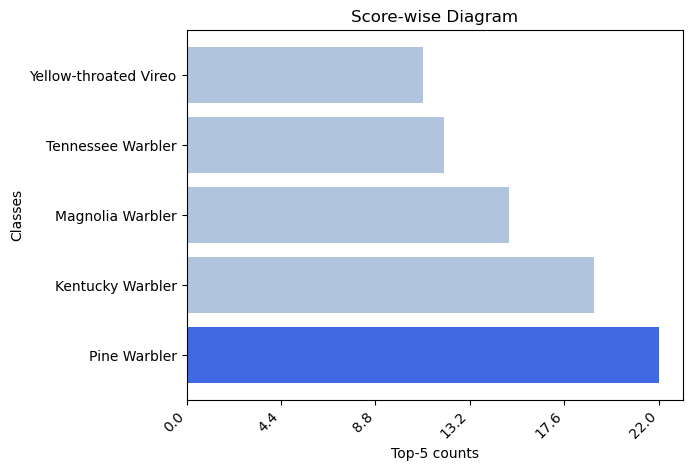

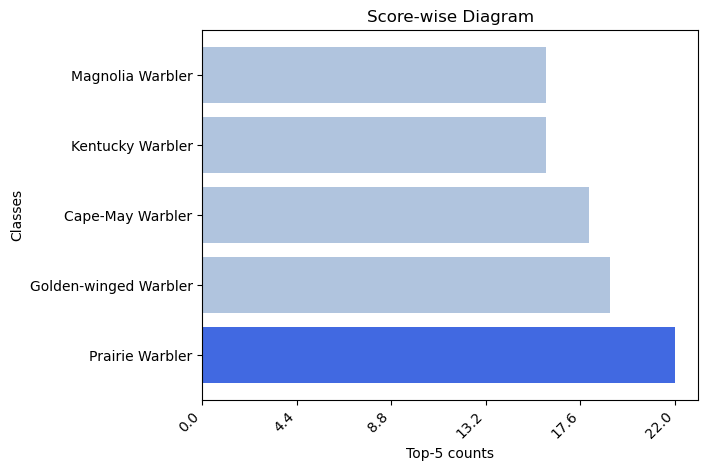

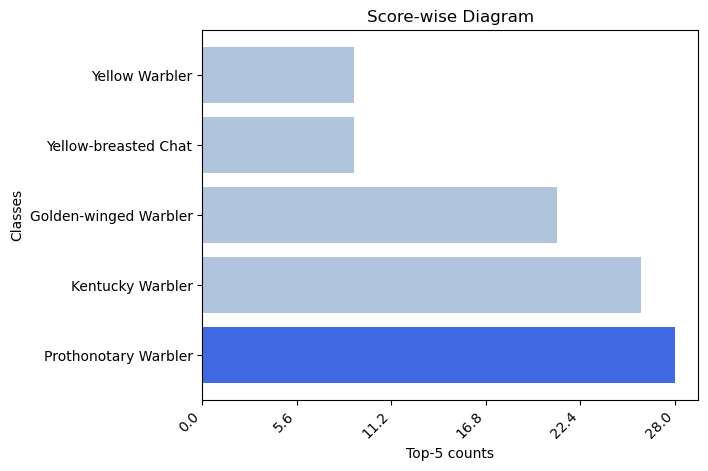

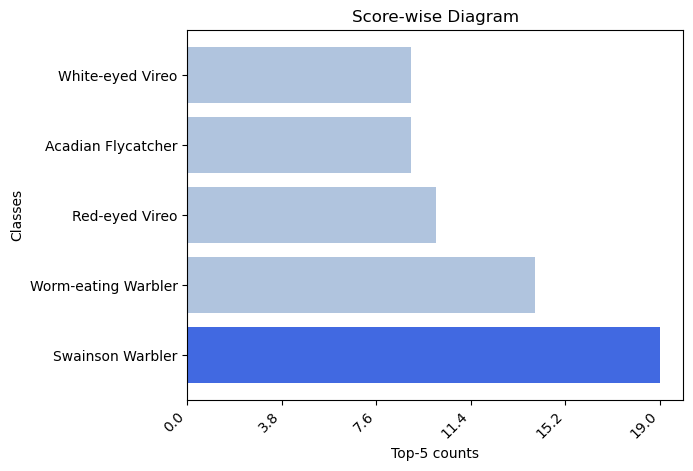

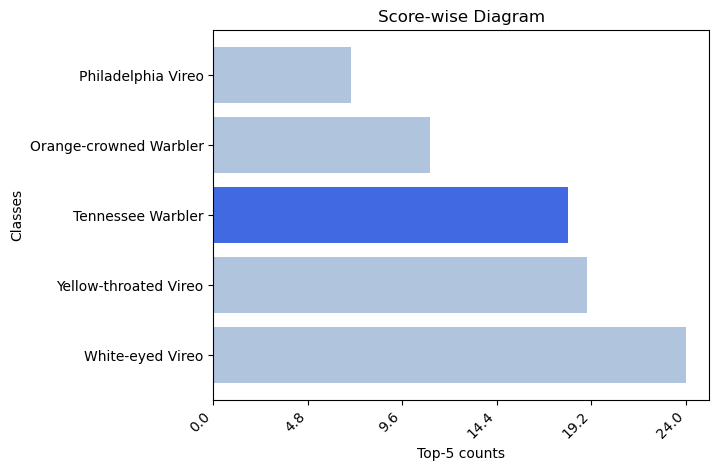

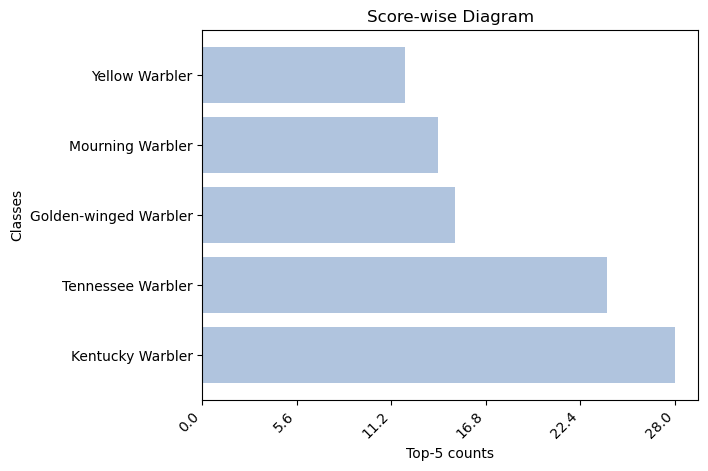

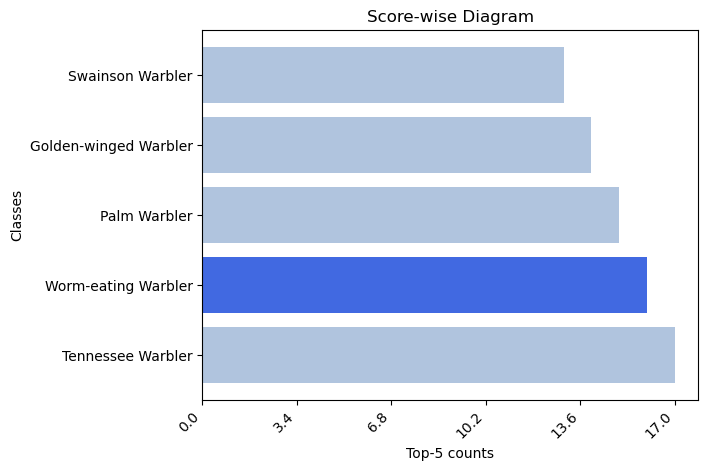

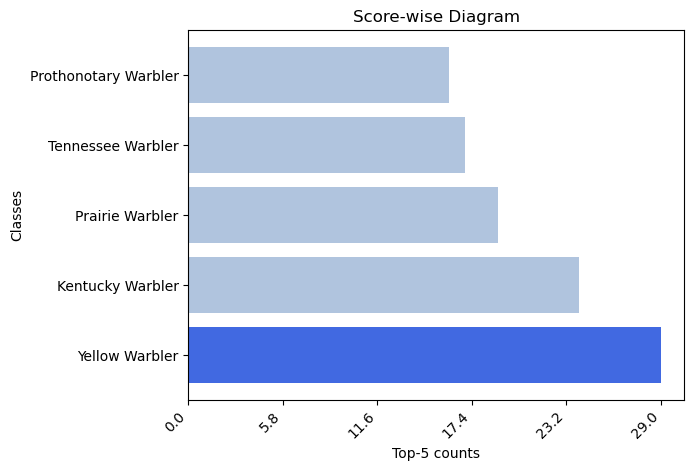

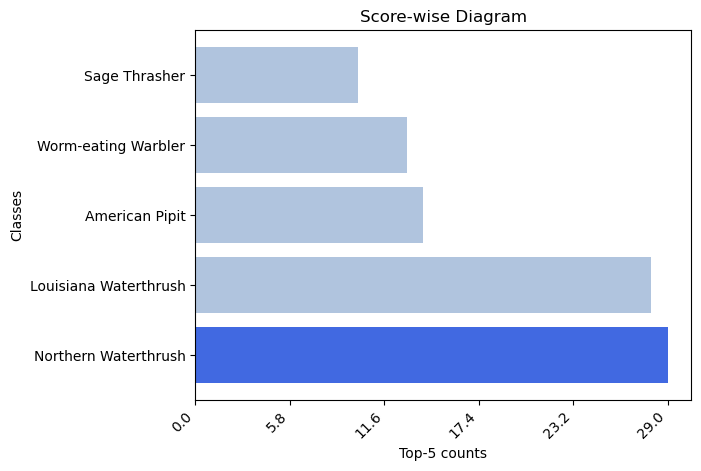

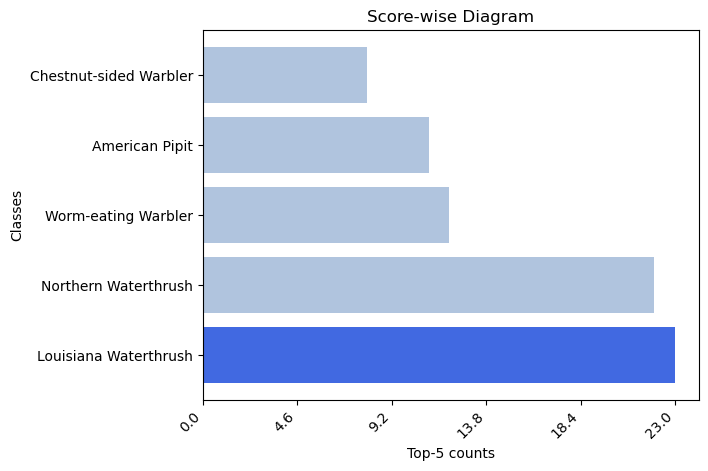

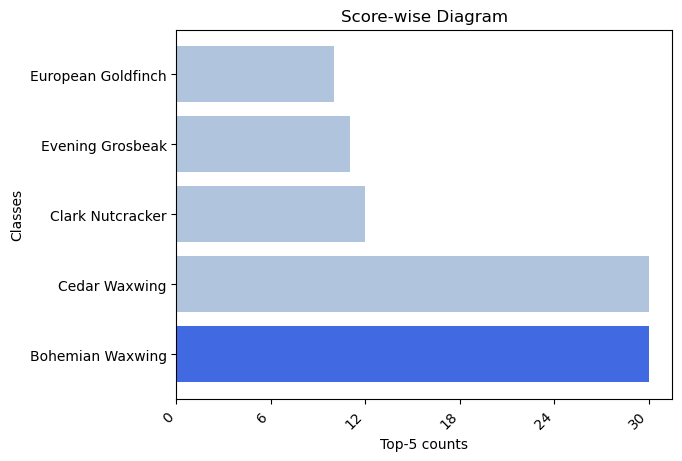

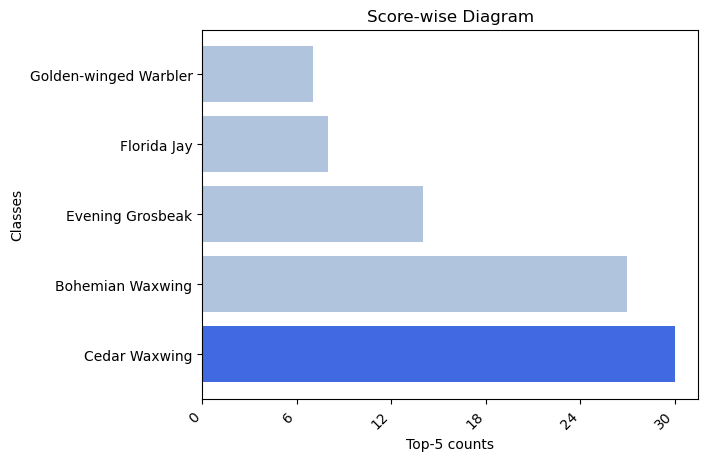

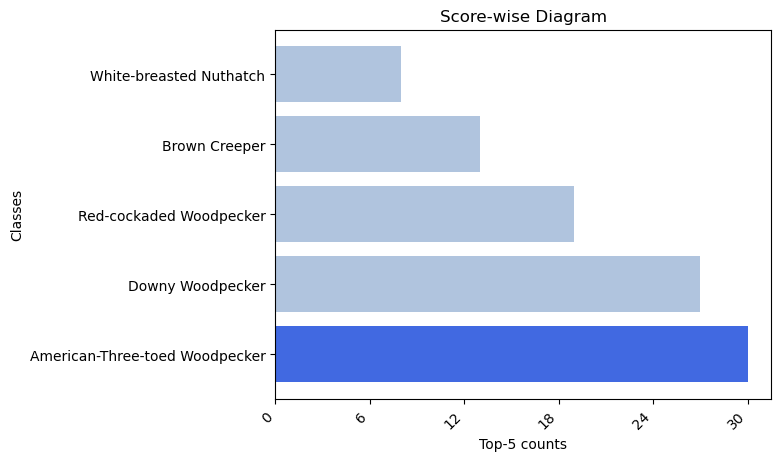

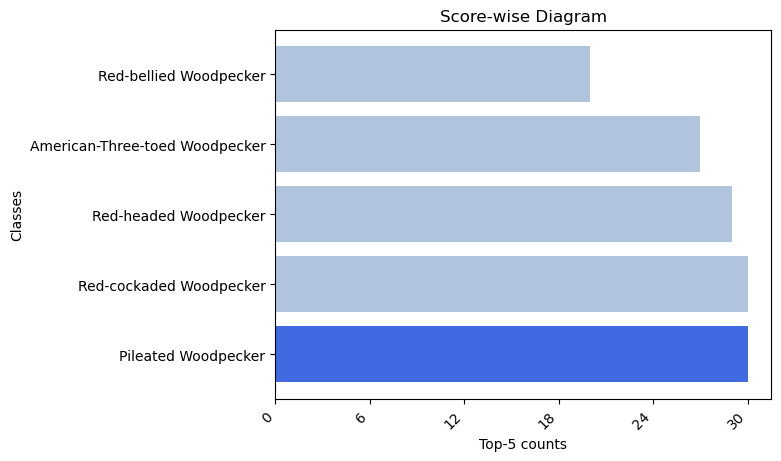

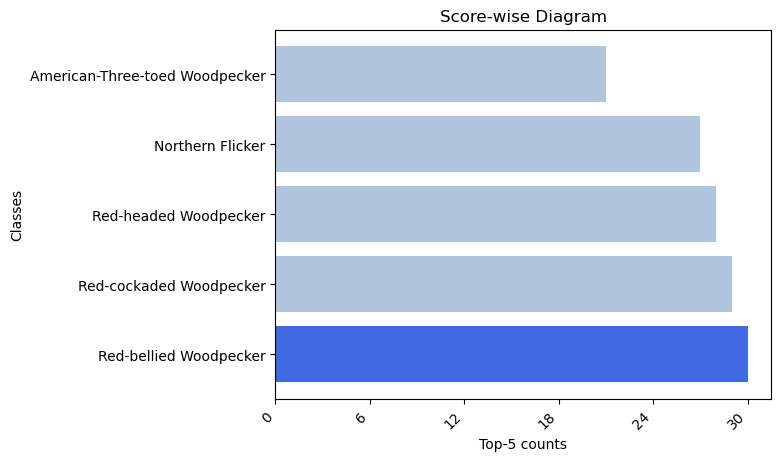

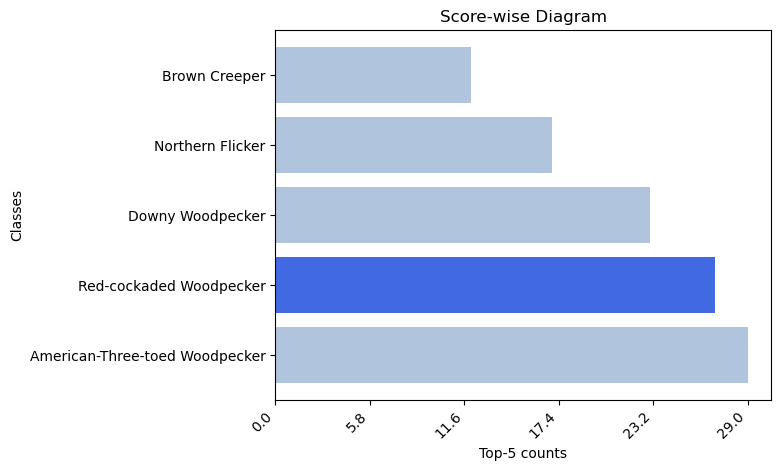

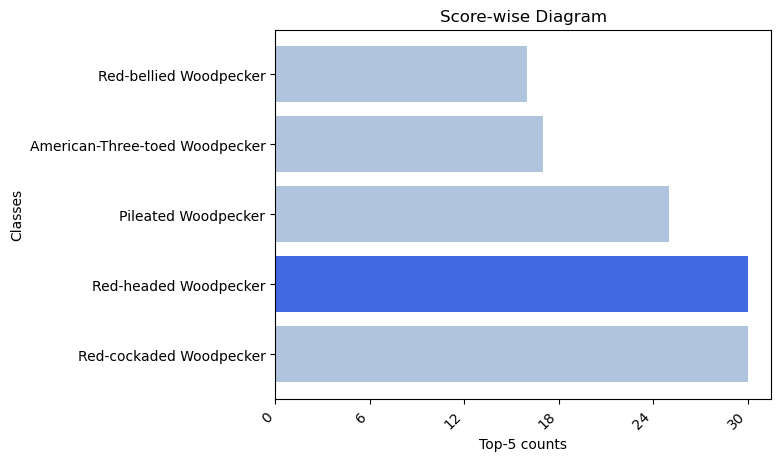

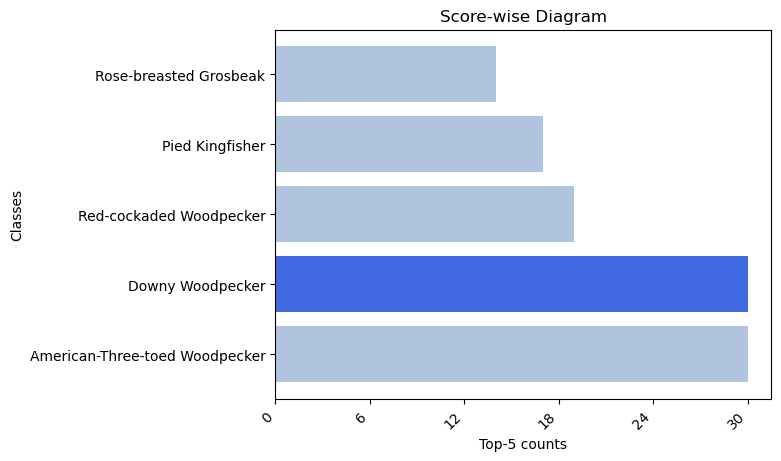

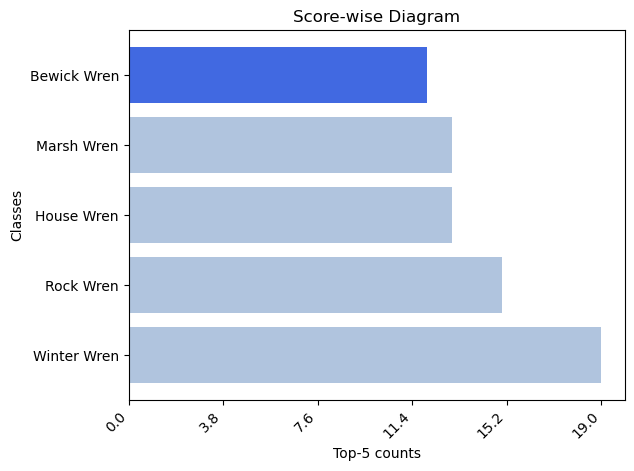

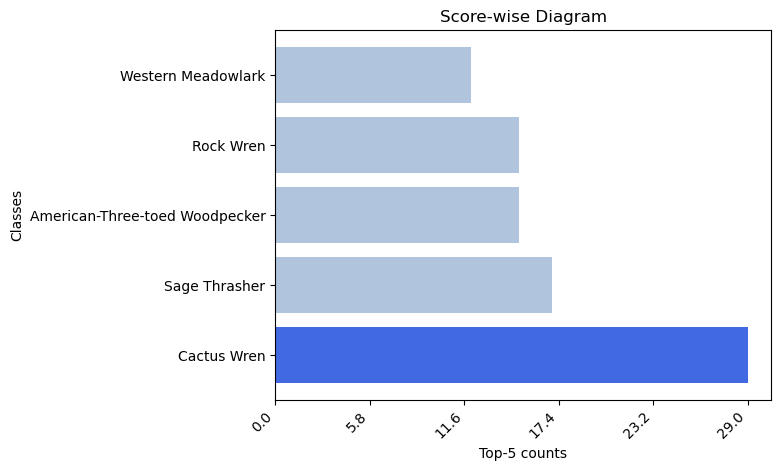

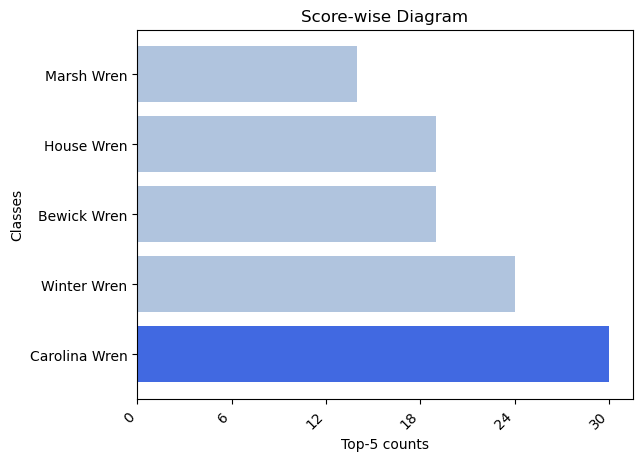

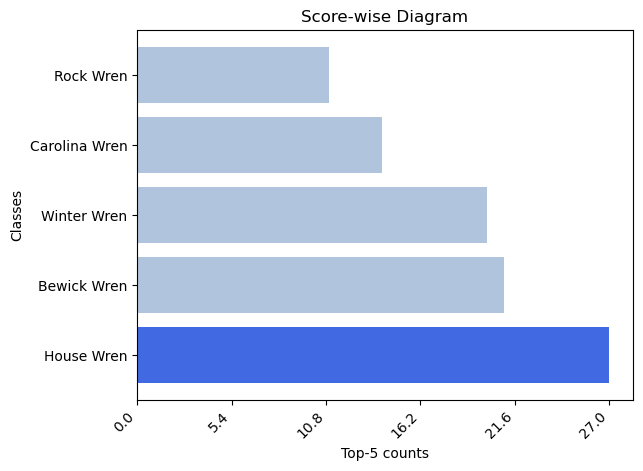

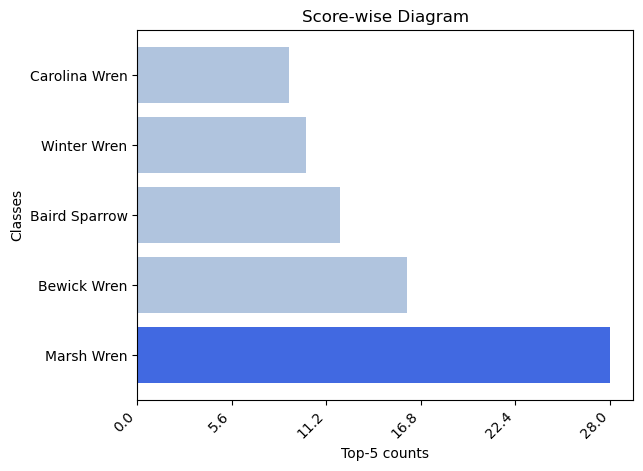

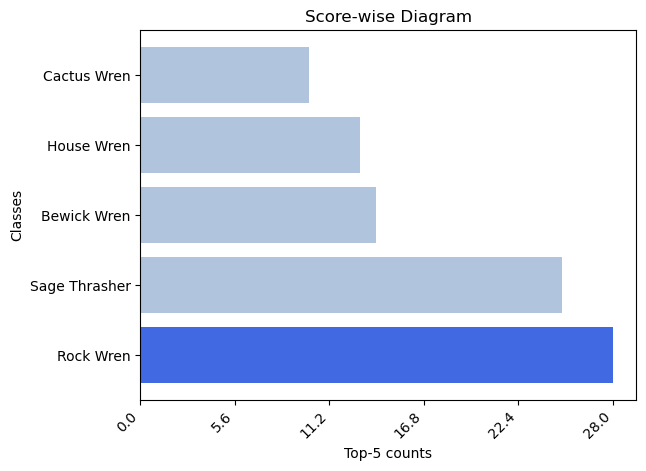

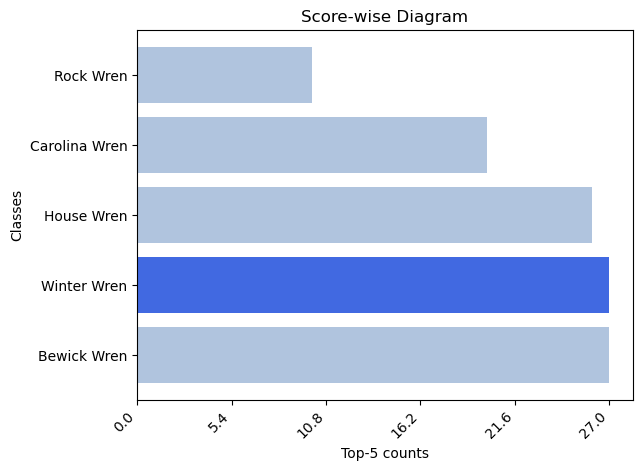

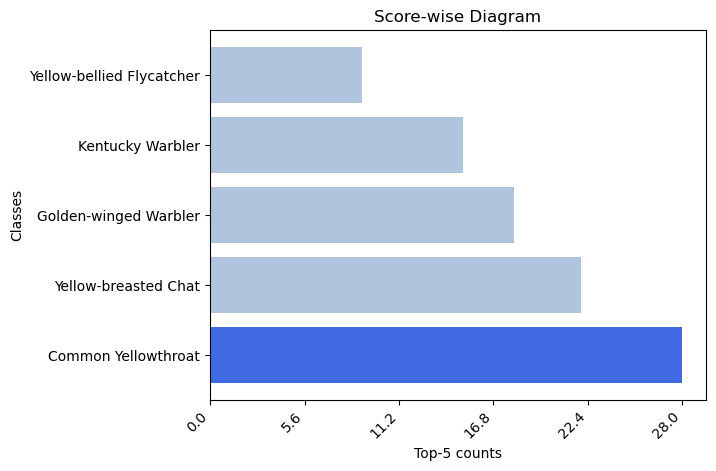

In [41]:
with open('top5_cub.json', 'r') as file:
    top5 = json.load(file)

for class_ in top5.keys():
    create_graph(class_, top5[class_][0:5])

In [42]:
top5[class_][0:5]

[['Common Yellowthroat', 28],
 ['Yellow-breasted Chat', 22],
 ['Golden-winged Warbler', 18],
 ['Kentucky Warbler', 15],
 ['Yellow-bellied Flycatcher', 9]]

# Logging

In [4]:
logging.basicConfig(
    level=logging.DEBUG,            # Set the minimum log level to DEBUG
    filename='gpt_3_my_cub.log',        # Specify the log file name
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)

logger = logging.getLogger(__name__)

In [5]:
def get_completion(prompt, logger, model="gpt-3.5-turbo", temperature=0., max_tokens=300):
    messages = [{'role':'system', 'content':"""
    Use this as an example to generate you answers for user's query. Give the answer in a JSON format just like given in the example

    ```Q: What are useful visual features for distinguishing a tiger from a lion in a photo?
       A: There are several useful visual features to tell the difference between a tiger and a lion in a photo:-


        {
            "tiger": [
                     "have orange coats with vertical 'black' stripes",
                     "are generally larger and robust",
                     "often have a more rounded face with prominent cheekbones",
                     "ears are usually smaller and rounded",
                     "tails are long and have a characteristic 'white spot' at the tip",
                     "are found in a variety of habitats, including dense forests and grasslands"
                     ],

            "lion": [
                    "typically have a tawny or 'beige coat', and their fur is often smoother and they have a mane",
                    "have a more compact and muscular build",
                    "lions may have a more squared-off face",
                    "ears are large and often have a more pointed shape",
                    "tails are shorter, ending in a tuft of hair",
                    "habitats are savannas and open woodlands"
                    ]
        }
        ```
    Remember not to use the first class name in the response of second class and vice-a-versa. For example here, in the answer for tiger do not use lion and in answer for lion do not use the word tiger.
"""},
    {"role": "user", "content": prompt}]
    
    try:
        logger.debug(f'Input: {messages}')
        response = openai.ChatCompletion.create(
            model=model,
            messages=messages,
            temperature=temperature,
            max_tokens=max_tokens
        )
        logger.debug(f'Output: {response}')
    except Exception as e:
        logger.error(f'error: {str(e)}')
        raise e
    return response.choices[0].message["content"]

In [6]:
birds = ['Black-footed Albatross', 'Laysan Albatross', 'Sooty Albatross', 'Groove-billed Ani', 'Crested Auklet', 'Least Auklet', 'Parakeet Auklet', 'Rhinoceros Auklet', 'Brewer Blackbird', 'Red-winged Blackbird', 'Rusty Blackbird', 'Yellow-headed Blackbird', 'Bobolink', 'Indigo Bunting', 'Lazuli Bunting', 'Painted Bunting', 'Cardinal', 'Spotted Catbird', 'Gray Catbird', 'Yellow-breasted Chat', 'Eastern Towhee', 'Chuck-will Widow', 'Brandt Cormorant', 'Red-faced Cormorant', 'Pelagic Cormorant', 'Bronzed Cowbird', 'Shiny Cowbird', 'Brown Creeper', 'American Crow', 'Fish Crow', 'Black-billed Cuckoo', 'Mangrove Cuckoo', 'Yellow-billed Cuckoo', 'Gray-crowned-Rosy Finch', 'Purple Finch', 'Northern Flicker', 'Acadian Flycatcher', 'Great-Crested Flycatcher', 'Least Flycatcher', 'Olive-sided Flycatcher', 'Scissor-tailed Flycatcher', 'Vermilion Flycatcher', 'Yellow-bellied Flycatcher', 'Frigatebird', 'Northern Fulmar', 'Gadwall', 'American Goldfinch', 'European Goldfinch', 'Boat-tailed Grackle', 'Eared Grebe', 'Horned Grebe', 'Pied-billed Grebe', 'Western Grebe', 'Blue Grosbeak', 'Evening Grosbeak', 'Pine Grosbeak', 'Rose-breasted Grosbeak', 'Pigeon Guillemot', 'California Gull', 'Glaucous-winged Gull', 'Heermann Gull', 'Herring Gull', 'Ivory Gull', 'Ring-billed Gull', 'Slaty-backed Gull', 'Western Gull', 'Anna Hummingbird', 'Ruby-throated Hummingbird', 'Rufous Hummingbird', 'Green Violetear', 'Long-tailed Jaeger', 'Pomarine Jaeger', 'Blue Jay', 'Florida Jay', 'Green Jay', 'Dark-eyed Junco', 'Tropical Kingbird', 'Gray Kingbird', 'Belted Kingfisher', 'Green Kingfisher', 'Pied Kingfisher', 'Ringed Kingfisher', 'White-breasted Kingfisher', 'Red-legged Kittiwake', 'Horned Lark', 'Pacific Loon', 'Mallard', 'Western Meadowlark', 'Hooded Merganser', 'Red-breasted Merganser', 'Mockingbird', 'Nighthawk', 'Clark Nutcracker', 'White-breasted Nuthatch', 'Baltimore Oriole', 'Hooded Oriole', 'Orchard Oriole', 'Scott Oriole', 'Ovenbird', 'Brown Pelican', 'White Pelican', 'Western-Wood Pewee', 'Sayornis', 'American Pipit', 'Whip-poor Will', 'Horned Puffin', 'Common Raven', 'White-necked Raven', 'American Redstart', 'Geococcyx', 'Loggerhead Shrike', 'Great-Grey Shrike', 'Baird Sparrow', 'Black-throated Sparrow', 'Brewer Sparrow', 'Chipping Sparrow', 'Clay-colored Sparrow', 'House Sparrow', 'Field Sparrow', 'Fox Sparrow', 'Grasshopper Sparrow', 'Harris Sparrow', 'Henslow Sparrow', 'Le-Conte Sparrow', 'Lincoln Sparrow', 'Nelson-Sharp-tailed Sparrow', 'Savannah Sparrow', 'Seaside Sparrow', 'Song Sparrow', 'Tree Sparrow', 'Vesper Sparrow', 'White-crowned Sparrow', 'White-throated Sparrow', 'Cape-Glossy Starling', 'Bank Swallow', 'Barn Swallow', 'Cliff Swallow', 'Tree Swallow', 'Scarlet Tanager', 'Summer Tanager', 'Artic Tern', 'Black Tern', 'Caspian Tern', 'Common Tern', 'Elegant Tern', 'Forsters Tern', 'Least Tern', 'Green-tailed Towhee', 'Brown Thrasher', 'Sage Thrasher', 'Black-capped Vireo', 'Blue-headed Vireo', 'Philadelphia Vireo', 'Red-eyed Vireo', 'Warbling Vireo', 'White-eyed Vireo', 'Yellow-throated Vireo', 'Bay-breasted Warbler', 'Black-and-white Warbler', 'Black-throated-Blue Warbler', 'Blue-winged Warbler', 'Canada Warbler', 'Cape-May Warbler', 'Cerulean Warbler', 'Chestnut-sided Warbler', 'Golden-winged Warbler', 'Hooded Warbler', 'Kentucky Warbler', 'Magnolia Warbler', 'Mourning Warbler', 'Myrtle Warbler', 'Nashville Warbler', 'Orange-crowned Warbler', 'Palm Warbler', 'Pine Warbler', 'Prairie Warbler', 'Prothonotary Warbler', 'Swainson Warbler', 'Tennessee Warbler', 'Wilson Warbler', 'Worm-eating Warbler', 'Yellow Warbler', 'Northern Waterthrush', 'Louisiana Waterthrush', 'Bohemian Waxwing', 'Cedar Waxwing', 'American-Three-toed Woodpecker', 'Pileated Woodpecker', 'Red-bellied Woodpecker', 'Red-cockaded Woodpecker', 'Red-headed Woodpecker', 'Downy Woodpecker', 'Bewick Wren', 'Cactus Wren', 'Carolina Wren', 'House Wren', 'Marsh Wren', 'Rock Wren', 'Winter Wren', 'Common Yellowthroat']
attributes = ['has_bill_shape::curved_(up_or_down)', 'has_bill_shape::dagger', 'has_bill_shape::hooked', 'has_bill_shape::needle', 'has_bill_shape::hooked_seabird', 'has_bill_shape::spatulate', 'has_bill_shape::all-purpose', 'has_bill_shape::cone', 'has_bill_shape::specialized', 'has_wing_color::blue', 'has_wing_color::brown', 'has_wing_color::iridescent', 'has_wing_color::purple', 'has_wing_color::rufous', 'has_wing_color::grey', 'has_wing_color::yellow', 'has_wing_color::olive', 'has_wing_color::green', 'has_wing_color::pink', 'has_wing_color::orange', 'has_wing_color::black', 'has_wing_color::white', 'has_wing_color::red', 'has_wing_color::buff', 'has_upperparts_color::blue', 'has_upperparts_color::brown', 'has_upperparts_color::iridescent', 'has_upperparts_color::purple', 'has_upperparts_color::rufous', 'has_upperparts_color::grey', 'has_upperparts_color::yellow', 'has_upperparts_color::olive', 'has_upperparts_color::green', 'has_upperparts_color::pink', 'has_upperparts_color::orange', 'has_upperparts_color::black', 'has_upperparts_color::white', 'has_upperparts_color::red', 'has_upperparts_color::buff', 'has_underparts_color::blue', 'has_underparts_color::brown', 'has_underparts_color::iridescent', 'has_underparts_color::purple', 'has_underparts_color::rufous', 'has_underparts_color::grey', 'has_underparts_color::yellow', 'has_underparts_color::olive', 'has_underparts_color::green', 'has_underparts_color::pink', 'has_underparts_color::orange', 'has_underparts_color::black', 'has_underparts_color::white', 'has_underparts_color::red', 'has_underparts_color::buff', 'has_breast_pattern::solid', 'has_breast_pattern::spotted', 'has_breast_pattern::striped', 'has_breast_pattern::multi-colored', 'has_back_color::blue', 'has_back_color::brown', 'has_back_color::iridescent', 'has_back_color::purple', 'has_back_color::rufous', 'has_back_color::grey', 'has_back_color::yellow', 'has_back_color::olive', 'has_back_color::green', 'has_back_color::pink', 'has_back_color::orange', 'has_back_color::black', 'has_back_color::white', 'has_back_color::red', 'has_back_color::buff', 'has_tail_shape::forked_tail', 'has_tail_shape::rounded_tail', 'has_tail_shape::notched_tail', 'has_tail_shape::fan-shaped_tail', 'has_tail_shape::pointed_tail', 'has_tail_shape::squared_tail', 'has_upper_tail_color::blue', 'has_upper_tail_color::brown', 'has_upper_tail_color::iridescent', 'has_upper_tail_color::purple', 'has_upper_tail_color::rufous', 'has_upper_tail_color::grey', 'has_upper_tail_color::yellow', 'has_upper_tail_color::olive', 'has_upper_tail_color::green', 'has_upper_tail_color::pink', 'has_upper_tail_color::orange', 'has_upper_tail_color::black', 'has_upper_tail_color::white', 'has_upper_tail_color::red', 'has_upper_tail_color::buff', 'has_head_pattern::spotted', 'has_head_pattern::malar', 'has_head_pattern::crested', 'has_head_pattern::masked', 'has_head_pattern::unique_pattern', 'has_head_pattern::eyebrow', 'has_head_pattern::eyering', 'has_head_pattern::plain', 'has_head_pattern::eyeline', 'has_head_pattern::striped', 'has_head_pattern::capped', 'has_breast_color::blue', 'has_breast_color::brown', 'has_breast_color::iridescent', 'has_breast_color::purple', 'has_breast_color::rufous', 'has_breast_color::grey', 'has_breast_color::yellow', 'has_breast_color::olive', 'has_breast_color::green', 'has_breast_color::pink', 'has_breast_color::orange', 'has_breast_color::black', 'has_breast_color::white', 'has_breast_color::red', 'has_breast_color::buff', 'has_throat_color::blue', 'has_throat_color::brown', 'has_throat_color::iridescent', 'has_throat_color::purple', 'has_throat_color::rufous', 'has_throat_color::grey', 'has_throat_color::yellow', 'has_throat_color::olive', 'has_throat_color::green', 'has_throat_color::pink', 'has_throat_color::orange', 'has_throat_color::black', 'has_throat_color::white', 'has_throat_color::red', 'has_throat_color::buff', 'has_eye_color::blue', 'has_eye_color::brown', 'has_eye_color::purple', 'has_eye_color::rufous', 'has_eye_color::grey', 'has_eye_color::yellow', 'has_eye_color::olive', 'has_eye_color::green', 'has_eye_color::pink', 'has_eye_color::orange', 'has_eye_color::black', 'has_eye_color::white', 'has_eye_color::red', 'has_eye_color::buff', 'has_bill_length::about_the_same_as_head', 'has_bill_length::longer_than_head', 'has_bill_length::shorter_than_head', 'has_forehead_color::blue', 'has_forehead_color::brown', 'has_forehead_color::iridescent', 'has_forehead_color::purple', 'has_forehead_color::rufous', 'has_forehead_color::grey', 'has_forehead_color::yellow', 'has_forehead_color::olive', 'has_forehead_color::green', 'has_forehead_color::pink', 'has_forehead_color::orange', 'has_forehead_color::black', 'has_forehead_color::white', 'has_forehead_color::red', 'has_forehead_color::buff', 'has_under_tail_color::blue', 'has_under_tail_color::brown', 'has_under_tail_color::iridescent', 'has_under_tail_color::purple', 'has_under_tail_color::rufous', 'has_under_tail_color::grey', 'has_under_tail_color::yellow', 'has_under_tail_color::olive', 'has_under_tail_color::green', 'has_under_tail_color::pink', 'has_under_tail_color::orange', 'has_under_tail_color::black', 'has_under_tail_color::white', 'has_under_tail_color::red', 'has_under_tail_color::buff', 'has_nape_color::blue', 'has_nape_color::brown', 'has_nape_color::iridescent', 'has_nape_color::purple', 'has_nape_color::rufous', 'has_nape_color::grey', 'has_nape_color::yellow', 'has_nape_color::olive', 'has_nape_color::green', 'has_nape_color::pink', 'has_nape_color::orange', 'has_nape_color::black', 'has_nape_color::white', 'has_nape_color::red', 'has_nape_color::buff', 'has_belly_color::blue', 'has_belly_color::brown', 'has_belly_color::iridescent', 'has_belly_color::purple', 'has_belly_color::rufous', 'has_belly_color::grey', 'has_belly_color::yellow', 'has_belly_color::olive', 'has_belly_color::green', 'has_belly_color::pink', 'has_belly_color::orange', 'has_belly_color::black', 'has_belly_color::white', 'has_belly_color::red', 'has_belly_color::buff', 'has_wing_shape::rounded-wings', 'has_wing_shape::pointed-wings', 'has_wing_shape::broad-wings', 'has_wing_shape::tapered-wings', 'has_wing_shape::long-wings', 'has_size::large_(16_-_32_in)', 'has_size::small_(5_-_9_in)', 'has_size::very_large_(32_-_72_in)', 'has_size::medium_(9_-_16_in)', 'has_size::very_small_(3_-_5_in)', 'has_shape::upright-perching_water-like', 'has_shape::chicken-like-marsh', 'has_shape::long-legged-like', 'has_shape::duck-like', 'has_shape::owl-like', 'has_shape::gull-like', 'has_shape::hummingbird-like', 'has_shape::pigeon-like', 'has_shape::tree-clinging-like', 'has_shape::hawk-like', 'has_shape::sandpiper-like', 'has_shape::upland-ground-like', 'has_shape::swallow-like', 'has_shape::perching-like', 'has_back_pattern::solid', 'has_back_pattern::spotted', 'has_back_pattern::striped', 'has_back_pattern::multi-colored', 'has_tail_pattern::solid', 'has_tail_pattern::spotted', 'has_tail_pattern::striped', 'has_tail_pattern::multi-colored', 'has_belly_pattern::solid', 'has_belly_pattern::spotted', 'has_belly_pattern::striped', 'has_belly_pattern::multi-colored', 'has_primary_color::blue', 'has_primary_color::brown', 'has_primary_color::iridescent', 'has_primary_color::purple', 'has_primary_color::rufous', 'has_primary_color::grey', 'has_primary_color::yellow', 'has_primary_color::olive', 'has_primary_color::green', 'has_primary_color::pink', 'has_primary_color::orange', 'has_primary_color::black', 'has_primary_color::white', 'has_primary_color::red', 'has_primary_color::buff', 'has_leg_color::blue', 'has_leg_color::brown', 'has_leg_color::iridescent', 'has_leg_color::purple', 'has_leg_color::rufous', 'has_leg_color::grey', 'has_leg_color::yellow', 'has_leg_color::olive', 'has_leg_color::green', 'has_leg_color::pink', 'has_leg_color::orange', 'has_leg_color::black', 'has_leg_color::white', 'has_leg_color::red', 'has_leg_color::buff', 'has_bill_color::blue', 'has_bill_color::brown', 'has_bill_color::iridescent', 'has_bill_color::purple', 'has_bill_color::rufous', 'has_bill_color::grey', 'has_bill_color::yellow', 'has_bill_color::olive', 'has_bill_color::green', 'has_bill_color::pink', 'has_bill_color::orange', 'has_bill_color::black', 'has_bill_color::white', 'has_bill_color::red', 'has_bill_color::buff', 'has_crown_color::blue', 'has_crown_color::brown', 'has_crown_color::iridescent', 'has_crown_color::purple', 'has_crown_color::rufous', 'has_crown_color::grey', 'has_crown_color::yellow', 'has_crown_color::olive', 'has_crown_color::green', 'has_crown_color::pink', 'has_crown_color::orange', 'has_crown_color::black', 'has_crown_color::white', 'has_crown_color::red', 'has_crown_color::buff', 'has_wing_pattern::solid', 'has_wing_pattern::spotted', 'has_wing_pattern::striped', 'has_wing_pattern::multi-colored']

In [7]:
# gpt_responses = ['- Large seabird\n- Black feathers on the back and wings\n- White feathers on the belly and head\n- Long, narrow wingspan\n- Yellow bill with a dark tip\n- Webbed feet\n- Dark eye color', '- Large seabird\n- White plumage with black wings and back\n- Long, slender wingspan\n- Yellow bill with a dark tip\n- Webbed feet\n- Graceful and soaring flight pattern\n- Distinctive black eye patch\n- Long, thin neck', '- Large seabird\n- Dark brown or black plumage\n- White underparts\n- Long, narrow wings\n- Yellow bill with a dark tip\n- Dark eye patch\n- Long, slender neck\n- Webbed feet for swimming and diving', '- Medium-sized bird\n- Black plumage with a greenish sheen\n- Long, curved bill with distinct grooves\n- Red eyes\n- Long tail with white tips\n- White patches on the wings\n- Yellow legs and feet', '- Small to medium-sized seabird\n- Black body with white underparts\n- Distinctive crested plume on the top of the head\n- Bright orange bill\n- White eye patch\n- Short wings\n- Webbed feet for swimming and diving', '- Small seabird\n- Black or dark gray plumage\n- White underparts\n- Short, stubby bill\n- White spot behind the eye\n- Short wings\n- Webbed feet for swimming and diving', '- Small seabird\n- Black and white plumage\n- Bright orange bill\n- Short wings\n- Short tail\n- White underparts\n- Black cap on the head\n- Yellowish or greenish tinge on the back', '- Medium-sized seabird\n- Black and white plumage\n- Long, thin bill with a distinctive horn-like projection on the upper mandible\n- Red eyes\n- Short wings\n- Webbed feet\n- Short tail\n- White underparts', '- Medium-sized bird\n- Black feathers\n- Bright yellow eyes\n- Yellow or orange beak\n- Long tail\n- Male has a glossy black body with a purple sheen\n- Female has a brown body with lighter streaks\n- Often seen in flocks or groups', '- Medium-sized blackbird\n- Male has black feathers with red and yellow shoulder patches\n- Female has brown feathers with streaks and a pale eyebrow\n- Pointed beak\n- Long tail\n- Perches on tall grass or reeds\n- Often seen near wetlands or marshes', '- Medium-sized blackbird\n- Glossy black plumage\n- Rusty brown feathers on the head and back\n- Yellow eyes\n- Yellowish or greenish legs and feet\n- Thin bill\n- White or pale yellow patches on the wing feathers', '- Medium-sized blackbird\n- Bright yellow head and breast\n- Black body\n- White wing patches\n- Long, pointed bill\n- Red eyes\n- Males have a distinctive white patch on their wings\n- Females have a more subdued coloration with a yellowish head and breast', '- Small to medium-sized bird\n- Black and white plumage\n- Distinctive white patch on the back of the head and neck\n- Yellowish or buff-colored underparts\n- Long, pointed wings\n- Short, pointed bill\n- Short tail with white edges\n- Males have a black patch on the breast during breeding season\n- Females have a more subdued coloration with streaks on the breast', '- Small bird\n- Vibrant blue plumage\n- Black wings and tail\n- Short, pointed beak\n- White belly\n- Brownish back and sides\n- Thin legs and feet', '- Small bird\n- Bright blue plumage on the head, back, and wings\n- Rust-colored breast and belly\n- White belly and undertail coverts\n- Black mask around the eyes\n- Short, pointed beak\n- Thin, pointed wings\n- Long, notched tail', '- Small bird\n- Vibrant and colorful plumage\n- Blue head and upper body\n- Red underparts\n- Green back and wings\n- Black beak\n- White wing bars\n- Short tail', '- Bright red plumage (males) or reddish-brown plumage (females)\n- Crest on the head\n- Black mask around the eyes\n- Short, thick beak\n- Strong, sturdy body\n- Long tail\n- White patches on the wings\n- Black legs and feet', '- Medium-sized bird\n- Dark grey or black feathers\n- White spots on the wings and tail\n- Bright red eyes\n- Long, curved beak\n- Short, rounded wings\n- Long, slender tail\n- White or pale grey underparts', '- Medium-sized bird\n- Gray overall plumage\n- Black cap on the head\n- Black tail with white edges\n- Dark eyes\n- Thin, straight bill\n- Long, rounded wings\n- Long, slender tail\n- White undertail coverts', '- Medium-sized songbird\n- Bright yellow breast\n- Olive-green back and wings\n- White belly\n- Dark mask around the eyes\n- Long tail\n- Thick bill\n- Black legs and feet', '- Medium-sized bird\n- Black head and upper body\n- White belly\n- Red eyes\n- White wing bars\n- Rust-colored sides\n- Dark tail with white corners\n- Thick, conical bill', '- Medium-sized bird\n- Brown or grayish-brown plumage\n- Long, pointed wings\n- Large head with a wide mouth\n- White throat patch\n- Short legs and feet\n- No visible crest or tuft on the head\n- Camouflaged pattern on the feathers for blending in with the surroundings', '- Medium-sized seabird\n- Black or dark brown feathers\n- Long neck and body\n- Yellow or orange facial skin\n- Hooked bill\n- Webbed feet\n- White or light-colored patch on the thigh\n- Often seen perched on rocks or swimming in the water', '- Medium-sized seabird\n- Black body with a reddish-brown face and throat\n- Long neck and sharp, pointed bill\n- Webbed feet for swimming\n- Dark wings with white patches\n- Yellow or orange eyes\n- Distinctive white patch on the thigh\n- Often seen perched on rocks or cliffs near the water', '- Medium-sized seabird\n- Black or dark brown feathers\n- Long neck and body\n- Long, hooked bill\n- Webbed feet\n- White or pale throat patch\n- Bright blue or green eyes\n- Often seen perched on rocks or cliffs near the ocean', '- Medium-sized bird\n- Black plumage with a metallic sheen\n- Brown eyes\n- Stout bill\n- Long tail\n- White patches on the wings\n- In males, a bronzed or iridescent throat and chest\n- In females, a lighter brown plumage with streaks or spots', '- Small to medium-sized bird\n- Glossy black plumage\n- Bright yellow eyes\n- Short, thick bill\n- Long tail with rounded tips\n- White patches on the wings\n- Males have a shiny blue-black head and neck\n- Females have a brownish-black plumage with lighter underparts', '- Small bird\n- Brown and white plumage\n- Long, curved bill\n- Thin, pointed tail\n- Camouflaged pattern on back\n- White underparts\n- Short wings\n- Clinging behavior on tree trunks', '- Black feathers\n- Medium-sized bird\n- Stout body\n- Strong, straight bill\n- Dark eyes\n- Short legs\n- Rounded wings\n- Distinctive cawing call', '- Medium-sized bird\n- Black feathers\n- Slightly smaller than a common crow\n- Distinctive call, a nasal "caw"\n- Short, stout bill\n- Dark eyes\n- Long, rounded tail\n- Often found near water bodies', '- Medium-sized bird\n- Brownish-gray overall coloration\n- Long, slender body\n- Long tail with white tips\n- Black bill\n- White underparts with dark barring\n- Reddish-brown wings with white spots\n- White eye ring\n- Greenish sheen on back and wings', '- Medium-sized bird\n- Brownish overall coloration\n- Long, curved bill\n- White throat and belly\n- Rufous wings and tail\n- Black mask around the eyes\n- Long tail with white tips\n- Reddish legs and feet', '- Medium-sized bird\n- Brownish-gray overall coloration\n- Long, slender body\n- Long tail with white tips\n- Yellow bill\n- White underparts with brown streaks\n- Reddish-brown wings with white spots\n- Red eye ring\n- White crescent-shaped patch on the nape of the neck', '- Small bird\n- Gray or brown feathers on the body\n- Pink or rosy color on the head and breast\n- White or grayish belly\n- Short, pointed beak\n- Black or dark wings with white or gray wing bars\n- Black or dark tail with white or gray outer feathers\n- Small, round eyes', '- Small bird\n- Plumage varies from reddish-purple to brownish-gray\n- Males have a reddish cap on their heads\n- Females have a more subdued coloration\n- Short, conical beak\n- White belly and undertail coverts\n- Brown wings with white wing bars\n- Forked tail', '- Medium-sized woodpecker\n- Brown or tan body with black bars or spots\n- White rump patch visible in flight\n- Red or yellow feathers on the nape of the neck\n- Black crescent-shaped mark on the chest\n- Long, slightly curved bill\n- Strong, sturdy legs and feet for clinging to trees\n- White or yellow underparts with black spots or bars on the belly', '- Small to medium-sized bird\n- Olive-green or yellowish-green plumage\n- White or pale yellow throat and belly\n- Dark wings and tail\n- Prominent eye ring\n- Short bill\n- Long wings and tail relative to body size\n- Insect-catching behavior, such as perching and sallying', '- Medium-sized bird\n- Olive-brown upperparts\n- Bright yellow belly\n- Gray throat and breast\n- Distinctive rusty-colored tail\n- Prominent crest on the head\n- Long, pointed bill\n- White eye-ring\n- White wing bars\n- Black bill and legs', '- Small size (about 5-5.5 inches in length)\n- Olive-brown upperparts\n- Pale yellowish underparts\n- White eye ring\n- Dark bill\n- Short wings\n- Long tail with white edges\n- Habit of perching upright on branches\n- Insect-catching behavior', '- Medium-sized songbird\n- Dark grayish-brown plumage on the upperparts\n- White or light grayish underparts\n- Distinctive white patch on the sides of the breast\n- Short, stout bill\n- Long wings with white wing bars\n- Forked tail\n- Perches upright on exposed branches or treetops', '- Long, scissor-like tail with white outer feathers\n- Slim body with a grayish-brown back and white underparts\n- Pinkish or peach-colored flanks\n- Black eye stripe and bill\n- Long wings with white patches\n- Active and agile in flight, often seen catching insects in mid-air\n- Typically found in open habitats, such as grasslands or savannas', '- Small bird\n- Bright red plumage on the head and breast\n- Black mask around the eyes\n- White or pale underparts\n- Long, thin bill\n- Long tail with white edges\n- Black wings with white wing bars\n- Perches prominently on branches or wires', '- Small bird\n- Yellowish belly\n- Olive-green upperparts\n- White eye ring\n- Pale yellow throat\n- Dark wings with white wing bars\n- Long, thin bill\n- Short tail', '- Large size, with a wingspan of up to 7.5 feet\n- Long, pointed wings\n- Black feathers\n- Distinctive red throat pouch in males\n- Long, forked tail\n- Sharp, hooked beak\n- Agile and graceful in flight\n- Often seen soaring or gliding in coastal areas', '- Medium-sized seabird\n- White or light grey plumage\n- Dark wingtips\n- Thick neck and short, stout bill\n- Webbed feet\n- Long, pointed wings\n- Flies with a stiff, gliding motion\n- Often seen in large flocks over the ocean', '- Medium-sized duck\n- Males have a grey body with a black rear end and a white belly\n- Females have a mottled brown body with a dark eye stripe\n- Both males and females have a white speculum (wing patch) bordered by black\n- Males have a black bill, while females have a dark bill with an orange stripe\n- Both males and females have a white patch on their sides\n- Both males and females have a slightly peaked head shape', '- Small bird\n- Bright yellow plumage (in males)\n- Black wings with white wing bars\n- Black cap on the head\n- White underbelly\n- Short, conical beak\n- Small size compared to other birds', '- Small bird\n- Bright yellow plumage on the body\n- Black and white wings with yellow patches\n- Red face and black cap on the head\n- Thin beak\n- Brownish-gray back and tail\n- White patches on the wings\n- Black tail feathers with white edges', '- Medium-sized blackbird\n- Glossy black plumage\n- Long, keel-shaped tail (hence the name "Boat-tailed")\n- Yellow eyes\n- Long, slender bill\n- Male has iridescent blue or purple feathers on the head and neck\n- Female has brownish-gray feathers with lighter streaks\n- Both male and female have long legs and walk with a distinctive strut', '- Small to medium-sized waterbird\n- Black head and neck\n- Red eyes\n- White underparts\n- Dark back and wings\n- Thin, pointed bill\n- Reddish-brown tufts of feathers behind the eyes (during breeding season)\n- White patch on the sides of the face (during breeding season)\n- Black and white striped pattern on the neck (during breeding season)\n- Webbed feet for swimming', '- Small to medium-sized waterbird\n- Black and white plumage\n- Red eyes\n- Distinctive black "horns" on the head during breeding season\n- White face and neck\n- Black back and wings\n- White underparts\n- Thin, pointed bill\n- Reddish-brown neck and sides during breeding season', '- Small to medium-sized bird\n- Brown or grayish-brown plumage\n- White or light-colored throat and breast\n- Black bill with a distinctive black band near the tip\n- Short tail\n- Reddish eye\n- Compact body shape\n- Webbed feet for swimming', '- Large size, about 20-30 inches long\n- Long neck and body\n- Black head and neck with a white patch on the cheeks and throat\n- Red eyes\n- Long, slender bill\n- Black back and wings\n- White underparts\n- Long, thin black and white striped neck feathers during breeding season\n- Webbed feet for swimming', '- Medium-sized songbird\n- Bright blue plumage on the head, back, and wings\n- Rust-colored breast and belly\n- Thick, conical beak\n- Black mask around the eyes\n- Short, rounded wings\n- Long, notched tail\n- White wing bars', '- Medium-sized bird\n- Stocky body\n- Large, conical beak\n- Yellow plumage on the head, back, and wings\n- Black wings with white patches\n- Black tail with white edges\n- White underparts\n- Males have a black forehead and throat\n- Females have a grayish-brown head and throat', '- Medium-sized bird\n- Red or pinkish-red plumage on males, gray or brown plumage on females\n- Thick bill\n- Rounded head\n- White wing bars\n- Black tail with white edges\n- Short, stout legs\n- Often found in coniferous forests', '- Medium-sized songbird\n- Black head and back\n- White breast with a large red patch\n- White wing bars\n- Thick, conical bill\n- Brown wings and tail\n- Pinkish legs and feet', '- Medium-sized seabird\n- Black body with white wing patches\n- Bright red feet and legs\n- Long, slender bill\n- White underparts\n- Dark eyes\n- Short tail\n- Agile and fast-flying', '- Medium-sized bird\n- White body with grey wings\n- Yellow bill\n- Red spot on the lower part of the bill\n- Black wingtips with white spots\n- Yellow legs and feet\n- Webbed feet for swimming\n- Long, slender wings\n- Rounded head shape', '- Large size, with a wingspan of around 4-5 feet\n- White plumage on the body\n- Gray wings with white tips\n- Yellow bill with a red spot near the tip\n- Pink legs and feet\n- Dark gray or black eyes\n- Webbed feet for swimming and walking on land\n- Long, slender wings for soaring and gliding in flight', '- Medium-sized gull\n- White head and body\n- Dark gray wings and back\n- Red-orange bill\n- Yellow legs and feet\n- Black wingtips with white spots\n- Dark eye\n- Long, slender wings\n- Forked tail', '- Large size, typically around 20-26 inches in length\n- White head and body\n- Grey wings with black tips\n- Yellow bill with a red spot near the tip\n- Pink legs and feet\n- White tail with black banding\n- Yellow eyes\n- Distinctive call, often described as a "laughing" sound', '- White plumage\n- Black eyes\n- Yellow bill\n- Black legs and feet\n- Medium-sized body\n- Rounded wings\n- Short tail\n- Arctic habitat', '- Medium-sized bird\n- White body with grey wings\n- Yellow bill with a black ring near the tip\n- Yellow legs and feet\n- White head with a black ring around the eye\n- Black wingtips with white spots\n- Long, slender wings\n- Webbed feet for swimming and walking on land', '- Medium to large-sized bird\n- Grey or slaty-black back and wings\n- White head, neck, and underparts\n- Yellow bill with red spot near the tip\n- Yellow legs and feet\n- White tail with black band near the tip\n- Black wingtips with white spots\n- Red eye ring', '- Large size, with a wingspan of around 4 feet\n- White head and body\n- Grey wings with black tips\n- Yellow bill with a red spot near the tip\n- Pink legs and feet\n- Dark eyes\n- Long, slender shape\n- Webbed feet for swimming and diving', '- Small size (about 3.9 inches in length)\n- Green feathers on the back and head\n- Red throat (known as a gorget)\n- White belly\n- Long, thin beak\n- Wings that beat rapidly\n- Ability to hover in mid-air\n- Feeding on nectar from flowers', '- Small size (around 3-4 inches in length)\n- Bright green feathers on the back and wings\n- White or grayish underparts\n- Ruby-red throat patch (only present in males)\n- Long, thin bill\n- Wings that beat rapidly (up to 80 times per second)\n- Ability to hover in mid-air\n- Rapid flight movements and quick changes in direction', '- Small size\n- Bright orange or reddish-brown feathers on the back and sides\n- White breast and belly\n- Green or bronze-colored feathers on the head and neck\n- Long, thin beak\n- Wings that appear slightly curved or pointed\n- Rapid wing beats\n- Ability to hover in mid-air\n- Feeding on nectar from flowers', '- Medium-sized hummingbird\n- Bright green plumage on the head, back, and wings\n- Violet or blue throat patch\n- White or pale underparts\n- Long, thin bill\n- Short tail\n- Dark eye mask or stripe\n- Green or bronze iridescent feathers on the back and wings', '- Medium-sized seabird\n- Long, pointed wings\n- Forked tail\n- Dark brown or black plumage\n- White underparts\n- Yellow or orange bill\n- Dark eye patch\n- Agile flight pattern\n- Often seen near coastlines or bodies of water', '- Medium-sized seabird\n- Dark brown or black plumage\n- Long, pointed wings\n- Forked tail\n- Yellow bill with a black tip\n- White patch on the underwing\n- Agile and acrobatic flight pattern\n- Often seen chasing and harassing other birds', '- Medium-sized bird\n- Blue feathers on the upper body\n- White underparts\n- Black collar around the neck\n- Black crest on the head\n- Black markings on the face\n- White patches on the wings and tail\n- Long, pointed beak\n- Strong, sturdy legs', '- Blue and grey plumage\n- Black crest on the head\n- White throat and underparts\n- Black facial markings around the eyes\n- Long tail\n- Medium-sized bird\n- Strong beak\n- Agile and active demeanor', '- Bright green feathers on the body\n- Blue feathers on the wings and tail\n- Black feathers on the head and throat\n- White feathers on the belly\n- Long tail feathers\n- Crest on the head\n- Black beak\n- Black legs and feet', '- Small bird\n- Gray or brown body\n- White belly\n- Dark head with a gray or black hood\n- White outer tail feathers\n- Pink or yellow bill\n- Dark eyes\n- Short, stubby beak\n- Thin legs and feet', '- Medium-sized bird\n- Bright yellow belly and breast\n- Olive-green back and wings\n- Long, black tail with white edges\n- Black mask around the eyes\n- Thin, pointed bill\n- Perches on exposed branches or wires\n- Often seen in open habitats such as fields, gardens, or forest edges', '- Medium-sized bird\n- Gray plumage\n- Black mask around the eyes\n- Long, pointed bill\n- Long tail\n- White underparts\n- Black wings with white patches\n- Strong and agile flier\n- Often seen perched on exposed branches or wires', '- Medium-sized bird\n- Blue and white plumage\n- Crest on the head\n- Long, pointed bill\n- White collar or "belt" across the chest\n- Short legs and feet\n- Short tail\n- Often seen perched near water bodies', '- Small to medium-sized bird\n- Bright green plumage on the back and wings\n- White or cream-colored underparts\n- Short, stout bill\n- Crest on the head\n- Red or orange legs and feet\n- Long, pointed wings\n- Short tail\n- Often seen perched near water bodies', '- Medium-sized bird\n- Black and white plumage\n- Crest on the head\n- Long, pointed bill\n- Large, round head\n- Short neck\n- Short legs\n- Long, pointed wings\n- Tail with white tips\n- Ability to hover above water before diving for fish', '- Medium-sized bird\n- Blue and white plumage\n- Crest on the head\n- Long, pointed bill\n- White collar around the neck\n- Reddish-brown breast band\n- Long, pointed tail\n- Strong, sturdy legs and feet', '- Medium-sized bird\n- White breast and belly\n- Blue wings and back\n- Red beak\n- Crest on the head\n- Long, pointed bill\n- Short legs\n- Perches on branches or wires near water bodies', '- Medium-sized seabird\n- Black head and upperparts\n- White underparts\n- Red legs and feet\n- Yellow bill with a black tip\n- White wingtips with black markings\n- Short, pointed wings\n- Forked tail', '- Small to medium-sized bird\n- Brown or grayish-brown plumage\n- Black or dark brown markings on the face and chest\n- White or pale yellow throat and belly\n- Short, pointed bill\n- Black or dark brown "horns" or tufts of feathers on the head\n- Long, slender tail\n- Often seen in open grassy or sandy areas', '- Medium-sized waterbird\n- Black head and neck\n- White underparts\n- Grey back and wings\n- Red eyes\n- Long, slender bill\n- White lines on the back and sides\n- Black and white checkered pattern on the upperparts\n- Webbed feet for swimming', '- Medium-sized duck\n- Green head with a white ring around the neck\n- Brownish-gray body\n- Yellow bill\n- Blue speculum (wing patch)\n- Orange legs and feet\n- Male has a curled black tail feather\n- Female has a mottled brown body with a dark bill', '- Medium-sized songbird\n- Yellow underparts with black V-shaped bib on the chest\n- Brown upperparts with black streaks\n- Long, pointed bill\n- Yellow face with black eye stripe\n- White outer tail feathers with black tips\n- Short, rounded wings\n- Habitat preference for grasslands and meadows', '- Small to medium-sized duck\n- Distinctive black and white plumage\n- Crest on the head that can be raised or lowered\n- Yellow eyes\n- Long, thin bill\n- White patch on the wings\n- Males have a large white patch on the head that can be raised to form a "hood"\n- Females have a smaller, reddish-brown crest on the head', '- Medium-sized diving duck\n- Reddish-brown head with a shaggy crest\n- White neck and breast with black streaks\n- Grey back and wings\n- Long, thin bill with a hooked tip\n- Red eyes\n- Long, slender body\n- Webbed feet for swimming and diving', '- Medium-sized bird\n- Grey or brown feathers\n- White patches on wings and tail\n- Long tail with white outer feathers\n- Thin, pointed beak\n- Dark eyes\n- White or light-colored belly\n- Mimicking behavior, such as imitating other bird songs', '- Medium-sized bird\n- Dark brown or black plumage\n- Long, pointed wings\n- Short, hooked beak\n- Large eyes\n- White patches on the wings or tail\n- Agile and acrobatic flight patterns\n- Insectivorous diet', '- Medium-sized bird\n- Grayish-blue plumage\n- Black wings with white patches\n- White belly and chest\n- Black bill with a hooked tip\n- Short tail\n- Strong, sturdy legs and feet\n- Often seen with a distinctive black cap on its head', '- Small bird\n- Blue-grey upperparts\n- White underparts\n- Black cap on the head\n- Long, pointed bill\n- Short tail\n- White face with a black stripe through the eye\n- Strong feet and claws for climbing trees', '- Bright orange plumage on the breast, belly, and sides\n- Black head, back, and wings\n- White wing bars\n- Black beak\n- Black eyes\n- Long, pointed wings\n- Medium-sized body\n- Perching on branches or in trees', '- Bright yellow plumage\n- Black mask around the eyes\n- White wing bars\n- Long, pointed beak\n- Medium-sized bird\n- Black tail feathers with white edges\n- In flight, shows a flash of white on the wings\n- Typically found in trees or shrubs', '- Small to medium-sized bird\n- Bright orange or yellow-orange plumage on the male\n- Olive-green or yellow-green plumage on the female\n- Black wings with white wing bars\n- Black mask around the eyes\n- Thin, pointed beak\n- Short tail\n- Typically found in trees or shrubs in orchards or open woodlands', '- Bright yellow plumage\n- Black wings with white wing bars\n- Black mask around the eyes\n- Long, pointed beak\n- Thin, pointed tail\n- Medium-sized bird\n- Typically found in open woodlands or forest edges', '- Small to medium-sized bird\n- Brown or olive-brown plumage\n- White or pale underparts with streaks or spots\n- Long, thin bill\n- Dark eye with a white eyering\n- Short tail\n- Often seen on the ground or low in vegetation\n- Distinctive behavior of flicking its tail up and down', '- Large, long-bodied bird\n- Brown or grey-brown plumage\n- Long, slender bill with a pouch\n- Long neck and wings\n- Webbed feet for swimming\n- Distinctive white head and neck during breeding season\n- Yellow or pale eyes\n- Black feathers on the back and wings', '- Large, white bird\n- Long, straight bill\n- Distinctive pouch under the bill\n- Black flight feathers\n- Yellow eyes\n- Webbed feet\n- Long wingspan\n- Typically seen in groups or flocks near bodies of water', '- Small to medium-sized bird\n- Olive-brown or grayish-brown plumage\n- Pale throat and breast\n- Dark wings with two white wing bars\n- Short bill\n- Dark legs and feet\n- Often perches on branches or wires\n- Insectivorous diet', '- Small to medium-sized bird\n- Olive or grayish-brown plumage\n- Pale yellow or white belly\n- Dark wings and tail\n- Long, pointed bill\n- White eye-ring\n- Short legs and feet\n- Often seen perched on branches or wires near water', '- Small, slender bird\n- Brownish-gray upperparts\n- White underparts with streaks on the breast and sides\n- Thin bill\n- Long, slender legs\n- White outer tail feathers that are visible in flight\n- Habit of wagging its tail up and down while foraging', '- Medium-sized bird\n- Brown or grayish-brown plumage\n- Long wings and tail\n- Short bill\n- Large eyes\n- White throat and belly\n- Mottled or streaked patterns on the body\n- Camouflage-like coloration for blending into the environment', '- Black and white plumage\n- Bright orange bill\n- White face with black eye patches\n- Horn-like projections on the sides of the head\n- Short wings\n- Webbed feet\n- Compact body shape\n- Short tail', '- Large size, similar to a crow but larger\n- Glossy black feathers\n- Thick, curved black beak\n- Shaggy throat feathers\n- Wedge-shaped tail\n- Intelligent and alert expression\n- Often seen in pairs or small groups\n- Known for their loud and varied vocalizations', '- Large size (around 56-69 cm in length)\n- Black feathers with a white patch on the back of the neck\n- Strong, curved black beak\n- Shaggy throat feathers\n- Long, pointed wings\n- Long, graduated tail\n- Dark eyes\n- Strong, sturdy legs and feet', '- Small songbird\n- Black and orange plumage\n- White belly\n- Black wings with white patches\n- Long, thin tail\n- Thin, pointed bill\n- Active and agile movements\n- Often seen flicking its wings and tail\n- Typically found in wooded areas or near water', '- Medium-sized bird\n- Long legs and tail\n- Brown or gray feathers\n- Crest on the head\n- Long, curved beak\n- White or light-colored underparts\n- Fast runners\n- Often seen on the ground or perched on low branches', '- Medium-sized songbird\n- Grayish-brown upperparts and white underparts\n- Black mask across the eyes\n- Hooked bill\n- Black wings with white patches\n- Long tail with white outer feathers\n- Perches on exposed branches or wires\n- Known for impaling prey on thorns or barbed wire', '- Medium-sized bird\n- Grey plumage with black wings and tail\n- White underparts\n- Black mask across the eyes\n- Hooked bill\n- Long tail with white outer feathers\n- Perches prominently on branches or wires\n- Known for impaling prey on thorns or barbed wire', '- Small size, about 5-6 inches in length\n- Brown or grayish-brown feathers\n- White or pale underparts\n- Streaked or mottled breast and sides\n- Short, rounded wings\n- Short, pointed bill\n- Dark eye with a pale eyering\n- Long tail with white outer feathers\n- Habitat preference for grasslands or open areas', '- Small bird\n- Black throat patch\n- White eyebrow stripe\n- Grayish-brown back and wings\n- White belly\n- Short tail\n- Thin beak\n- Brownish legs', '- Small size, about 5-6 inches in length\n- Brown or grayish-brown plumage\n- White or pale gray underparts\n- Dark streaks or spots on the breast and sides\n- Short, rounded wings\n- Short, pointed bill\n- Dark eye with a pale eyering\n- Long, notched tail\n- Often found in open grasslands or shrubby areas', '- Small size, about 5-6 inches in length\n- Brownish-gray back and wings\n- Rust-colored cap on the head\n- White eyebrow stripe\n- Pale underparts with streaks on the breast\n- Thin bill\n- Black eye line\n- Short tail with white edges\n- Pink legs', '- Small bird\n- Brownish-gray overall coloration\n- Pale gray or white underparts\n- Dark streaks on the back and sides\n- White eye ring\n- Pinkish bill\n- Black and white stripes on the head\n- Short tail\n- Small size compared to other sparrows', '- Small size, about 5-6 inches in length\n- Brown or grayish-brown feathers\n- Black bib on the throat and upper breast\n- White cheeks\n- Short, thick bill\n- Short, rounded wings\n- Long, notched tail\n- Pink or yellowish legs and feet', '- Small size, about 5-6 inches in length\n- Brown or grayish-brown feathers on the back and wings\n- White or pale gray breast with streaks or spots\n- Rust-colored cap on the head\n- Pink or flesh-colored bill\n- Dark eye with a white eyering\n- Short, rounded tail\n- Often seen foraging on the ground or in low vegetation', '- Medium-sized sparrow\n- Rusty brown or reddish-brown plumage\n- White or grayish underparts with streaks or spots\n- Dark brown or black streaks on the back and wings\n- Thick bill\n- Long tail\n- White or pale throat\n- White or pale eyebrow stripe\n- Pink or orange legs and feet', '- Small size (about 5-6 inches in length)\n- Brownish overall coloration with streaks on the back and wings\n- Pale underparts with fine streaking\n- Short, rounded tail\n- Short, thin bill\n- White eye ring\n- Dark patch on the side of the neck\n- Habit of perching on tall grass or shrubs', '- Medium-sized bird\n- Grayish-brown overall plumage\n- Black crown and bib\n- White throat and underparts\n- Pink bill\n- Pink legs and feet\n- White wing bars\n- Dark tail with white outer feathers', '- Small size (about 5-6 inches in length)\n- Brownish overall coloration\n- Streaked back and wings\n- Pale underparts with fine streaking\n- Short tail\n- White eye ring\n- Short, thin bill\n- Pinkish legs and feet', '- Small size (about 5-6 inches in length)\n- Brown or grayish-brown plumage\n- White or pale gray underparts\n- Streaked or mottled back and wings\n- Short, rounded tail\n- Thin bill\n- Dark eye with a pale eyering\n- Pink or flesh-colored legs and feet', '- Small size, about 5-6 inches in length\n- Brownish-gray overall coloration\n- Streaked breast and sides\n- White belly with fine streaks\n- Gray face with a white eye ring\n- Short, pointed bill\n- Short tail with white outer feathers\n- Dark streaks on the back and wings\n- Pinkish legs and feet', '- Small size, about 4.5-5.5 inches in length\n- Brown or grayish-brown plumage\n- Streaked or mottled appearance on the back and sides\n- Pale or whitish underparts with fine streaking\n- Short, pointed bill\n- Dark eyeline and pale supercilium (eyebrow)\n- Short tail with rounded tips\n- Habitat preference for saltmarshes and coastal areas', '- Small size, about 5-6 inches in length\n- Brown and white plumage\n- Streaked back and wings\n- Yellowish or whitish breast with dark streaks\n- Short, pointed bill\n- Dark eye stripe\n- Pink or yellowish legs\n- Habit of perching on low vegetation or the ground', '- Small size, about 5-6 inches in length\n- Brown or grayish-brown feathers\n- White or pale gray underparts\n- Dark streaks or spots on the breast and sides\n- Short, pointed bill\n- Dark eye with a pale eyering\n- Short, rounded wings\n- Long, slender legs\n- Inhabits coastal marshes and salt marshes', '- Small bird\n- Brown or grayish-brown feathers\n- Streaked breast and sides\n- White or light-colored belly\n- Dark brown or blackish cap on the head\n- Short, rounded wings\n- Long, slender bill\n- Pink or grayish legs and feet', '- Small bird\n- Brown and grey plumage\n- White belly\n- Black patch on the throat\n- Chestnut crown on the head\n- Short, conical beak\n- Black and white stripes on the wings\n- Long tail with white edges', '- Small to medium-sized bird\n- Brown or grayish-brown feathers\n- White or pale yellowish breast with streaks\n- White eye-ring\n- Brown or blackish crown with pale central stripe\n- Long, pointed tail\n- Pink or yellowish bill\n- Black or dark brown legs and feet', '- Small bird\n- Gray or brown feathers\n- White and black striped crown on the head\n- White throat and breast\n- Brown wings with white bars\n- Pink or yellow bill\n- Long tail\n- Thin legs and feet', '- Small bird\n- Brown and white plumage\n- White throat patch\n- Yellow spot between eye and bill\n- Black and white striped crown\n- Pink or yellow bill\n- Dark wings with white bars\n- Short tail', '- Glossy black feathers with a metallic sheen\n- Bright yellow eyes\n- Yellow bill\n- Long tail\n- Medium-sized bird\n- White speckles on the wings\n- Short, stout legs\n- In flight, shows a flash of white on the underwings', '- Small size, about 5-5.5 inches in length\n- Brownish-gray upperparts and white underparts\n- Dark brown band across the chest\n- Long, pointed wings\n- Forked tail\n- Small, black bill\n- Dark eye patch\n- White throat and chin', '- Small bird\n- Long, pointed wings\n- Forked tail\n- Blue-black upperparts\n- Reddish-brown throat and forehead\n- Pale underparts\n- White underparts with dark streaks\n- Reddish-brown face mask', '- Small bird\n- Brownish-black upperparts\n- White underparts\n- Rusty-colored forehead and throat\n- Short, forked tail\n- Broad wings\n- White spots on the outer feathers of the wings\n- Nest made of mud and attached to vertical surfaces, such as cliffs or buildings', '- Small bird\n- Bright blue or greenish-blue feathers on the back and wings\n- White or light-colored underparts\n- Forked tail\n- Dark, glossy head and neck\n- Thin, pointed bill\n- Agile and acrobatic flight patterns', '- Bright red body\n- Black wings and tail\n- Black beak\n- Black legs and feet\n- Black eyes\n- Yellow patches on the wings and tail\n- Medium-sized bird\n- Distinctive song and call', '- Medium-sized songbird\n- Bright red plumage (males) or yellowish-green plumage (females)\n- Thick, conical bill\n- Dark wings and tail\n- White undertail coverts\n- Black legs and feet\n- Dark eyes', '- Medium-sized seabird\n- White plumage on the body\n- Black cap on the head\n- Long, pointed wings\n- Forked tail\n- Orange-red beak\n- Red legs and feet\n- Graceful and agile in flight', '- Small size, about 9-10 inches in length\n- Black head, neck, and upper body\n- White underparts\n- Long, slender wings\n- Forked tail\n- Red legs and feet\n- Black beak\n- White patch on the wings, visible in flight', '- Large size, with a wingspan of around 1 meter\n- White plumage on the body and wings\n- Black cap on the head\n- Bright red-orange bill\n- Long, slender body shape\n- Long, pointed wings\n- Forked tail\n- Black legs and feet', '- Medium-sized bird\n- Slender body\n- Long, pointed wings\n- Forked tail\n- White underparts\n- Pale grey upperparts\n- Black cap on the head\n- Red bill\n- Black legs and feet', '- Medium-sized seabird\n- White body with a black cap on the head\n- Long, slender wings\n- Forked tail\n- Orange-red bill\n- Black legs and feet\n- Graceful and agile in flight\n- Often seen near coastal areas or bodies of water', '- Medium-sized bird\n- Slender body\n- Long, pointed wings\n- Forked tail\n- Black cap on the head\n- White underparts\n- Grey back and wings\n- Orange-red bill\n- Black legs and feet', '- Small size, about 9-10 inches in length\n- White plumage on the belly and underparts\n- Pale grey upperparts\n- Black cap on the head during breeding season\n- Yellow bill with a black tip\n- Forked tail\n- Long, pointed wings\n- Black legs and feet', '- Small to medium-sized bird\n- Olive-green or grayish-brown plumage\n- Bright yellow or greenish-yellow rump\n- White or pale gray underparts\n- Dark wings with white wing bars\n- Long tail with white outer feathers\n- Black or dark gray bill\n- Red or pink legs and feet', '- Medium-sized bird\n- Brown upperparts with streaks\n- White underparts with dark streaks\n- Long, curved bill\n- Yellow eyes\n- Long tail with white corners\n- Rust-colored wings\n- White wing bars\n- Bold, black streaking on the breast and sides', '- Medium-sized songbird\n- Brownish-gray overall coloration\n- Pale underparts with streaks\n- Long, thin bill\n- Dark eye with a pale eyering\n- Long tail with white outer feathers\n- White wing bars\n- Habitually perches on shrubs or low branches', '- Small songbird\n- Black cap on the head\n- White spectacles around the eyes\n- Grayish-brown upperparts\n- Pale underparts\n- Short, pointed bill\n- Thin, black legs\n- Short tail with white outer feathers', '- Small to medium-sized songbird\n- Blue-gray head and upperparts\n- White underparts\n- White eye-ring\n- Black eyeline\n- Thin bill\n- Short wings\n- Long tail\n- Greenish-yellow legs and feet', '- Small songbird\n- Olive-green or yellowish-green plumage\n- White or yellowish underparts\n- Dark eye line\n- Thin, pointed bill\n- Short tail\n- Yellow wing bars\n- White wing patches\n- Active and agile in flight', '- Small to medium-sized songbird\n- Olive-green upperparts\n- White underparts\n- Red eyes\n- Thin, pointed bill\n- White wing bars\n- Dark legs and feet\n- Often seen perched upright in trees or shrubs', '- Small songbird\n- Olive-green or grayish upperparts\n- White underparts\n- Yellowish wash on sides and flanks\n- Dark eye line\n- Thin bill\n- Short tail\n- Often seen perched high in trees or shrubs', '- Small songbird\n- Olive-green upperparts\n- White underparts\n- White eye ring\n- Yellow spectacles around the eyes\n- Short, thick bill\n- Short wings\n- Long tail\n- Legs and feet are pink or flesh-colored', '- Small to medium-sized songbird\n- Yellow throat and breast\n- Olive-green back and wings\n- White belly and undertail coverts\n- Black and white stripes on the head\n- Dark eye with a white eyering\n- Thin, pointed bill\n- Short tail\n- Active and agile in flight', '- Small songbird\n- Brownish-gray upperparts\n- Pinkish-red crown and sides of the breast\n- Black face mask\n- White underparts\n- Black streaks on the sides and flanks\n- Thin, pointed bill\n- Yellowish legs and feet', '- Small, songbird size\n- Black and white striped pattern on the body\n- White belly and throat\n- Black cap on the head\n- Thin, pointed beak\n- Long, slender legs\n- Often seen climbing up and down tree trunks', '- Small songbird\n- Male has a black throat and face, blue upperparts, and white underparts\n- Female has a duller coloration with a grayish-blue back and yellowish underparts\n- White wing bars\n- Thin, pointed bill\n- Short tail\n- Active and agile in flight\n- Often found in wooded areas or near water sources', '- Small bird\n- Bright yellow plumage on the head and underparts\n- Blue-gray wings and back\n- White wing bars\n- Black eye line\n- Short, pointed bill\n- Thin, black legs\n- In flight, shows white outer tail feathers', '- Small songbird\n- Olive-green upperparts\n- Yellow throat and breast\n- White eye ring\n- Black necklace-like streaks on the breast\n- White belly\n- Thin bill\n- Short tail', '- Small songbird\n- Yellowish-green plumage\n- Black streaks on the breast and sides\n- White wing bars\n- Black face mask\n- Yellow patch on the nape of the neck\n- Thin bill\n- Small size compared to other warblers', '- Small songbird\n- Bright blue upperparts\n- White underparts\n- Black streaks on the back and sides\n- White wing bars\n- Short, thin bill\n- Black legs and feet', '- Small songbird\n- Bright yellow head and chest\n- White belly\n- Chestnut-colored flanks\n- Olive-green back\n- White eye ring\n- Black eye stripe\n- Thin black bill\n- Short tail', '- Small songbird\n- Yellow head and underparts\n- Black eye patch\n- White wing bars\n- Gray back and wings\n- Black tail with white outer feathers\n- Thin bill\n- Short legs', '- Small songbird\n- Bright yellow plumage on the body\n- Black hood covering the head and neck\n- White patches on the wings\n- Thin, pointed beak\n- Dark legs and feet', '- Small bird\n- Yellow underparts\n- Olive-green upperparts\n- Black mask across the eyes\n- White eye ring\n- Short, rounded wings\n- Short, dark bill\n- Pink legs and feet', '- Small songbird\n- Bright yellow underparts\n- Black streaks on the sides and back\n- White wing bars\n- Greenish-gray upperparts\n- White eye ring\n- Thin bill\n- Short tail', '- Small size, about 4.7-5.1 inches in length\n- Olive-green upperparts\n- Yellow underparts with black streaks\n- Gray head with a black mask extending from the eye to the nape\n- White eye crescents\n- Thin white wing bars\n- Pink legs and feet\n- Short, pointed bill', '- Small songbird\n- Yellowish or olive-green plumage\n- White belly and undertail coverts\n- Black streaks on the sides and back\n- White wing bars\n- Yellow patches on the head and chest\n- Dark eye line\n- Thin bill', '- Small size, about 4.5 inches in length\n- Olive-green upperparts\n- Yellow underparts\n- White eye ring\n- Grayish head with a yellow crown\n- Thin pointed bill\n- Short tail\n- Thin black streaks on the breast and sides\n- Yellowish wing bars', '- Small songbird\n- Olive-green or grayish-brown plumage\n- Pale yellow or orange crown patch (may not always be visible)\n- Thin, pointed bill\n- White or pale yellow underparts\n- Dark wings with white wing bars\n- Short tail\n- Active and agile movements in trees and shrubs', '- Small songbird\n- Olive-brown upperparts\n- Yellow underparts with streaks\n- Pale eyebrow stripe\n- Yellow throat and chest\n- Dark streaks on the sides\n- Thin pointed bill\n- Long tail with white outer feathers', '- Small songbird\n- Olive-green or yellowish-green plumage\n- White or pale yellow underparts\n- Thin, pointed bill\n- Black streaks on the sides and back\n- White wing bars\n- Yellowish eyebrow stripe\n- Dark legs and feet', '- Small songbird\n- Yellow plumage with black streaks on the sides and back\n- Black eye stripe\n- White belly\n- Olive-green wings and tail\n- Thin, pointed bill\n- Short, rounded tail\n- Active and energetic behavior', '- Bright yellow or golden plumage on the head and breast\n- Blue-gray wings and back\n- White belly\n- Long, pointed bill\n- Black eye stripe\n- Short tail\n- Small size, about 4.5-5 inches in length\n- Often found near water or wetland habitats', '- Small size (about 5-6 inches in length)\n- Brownish or olive-green coloration\n- White or pale yellow underparts\n- Dark streaks on the breast and sides\n- Long, thin bill\n- Short tail\n- Eye ring or eye stripe\n- Thin, pointed wings\n- Habit of skulking in dense vegetation', '- Small size, about 4.3-5.1 inches in length\n- Olive-green upperparts\n- Yellow underparts\n- White eye ring\n- Thin, pointed bill\n- Dark wings with two white wing bars\n- White belly with streaks on the sides\n- Short tail\n- Active and energetic behavior', '- Small bird\n- Bright yellow plumage on the belly and chest\n- Olive-green back and wings\n- Black cap on the head\n- White eye-ring\n- Thin, pointed beak\n- Short tail\n- Active and energetic behavior', '- Small bird\n- Brownish-gray upperparts\n- White underparts with streaks\n- Yellowish throat and breast\n- Black streaks on sides and flanks\n- Thin, pointed bill\n- Short tail\n- Olive-green wings with white wing bars\n- White eye ring\n- Habitat preference for dense undergrowth and leaf litter', '- Small songbird\n- Bright yellow plumage\n- Black streaks on the breast and sides\n- White belly and undertail coverts\n- Thin, pointed bill\n- Black legs and feet\n- Dark eyes\n- Short wings and tail', '- Small to medium-sized bird\n- Brownish or olive-brown upperparts\n- White or pale yellow underparts with streaks or spots\n- White or pale eyebrow stripe\n- Long, thin bill\n- Pink or yellow legs\n- White throat and breast\n- Dark streaks on the sides and flanks\n- Short tail with white outer feathers', '- Small to medium-sized bird\n- Brownish upperparts and white underparts\n- White eye stripe\n- Long, pinkish legs\n- Long, slender bill\n- White throat and breast with streaks\n- Dark streaks on the sides and flanks\n- White belly\n- Short tail with white outer feathers', '- Medium-sized bird\n- Grayish-brown overall coloration\n- Black mask around the eyes\n- Yellow-tipped tail feathers\n- Red wax-like tips on secondary wing feathers\n- Crest on the head\n- Yellow or white markings on the wings\n- Short, stout beak', '- Medium-sized bird\n- Brownish-gray overall coloration\n- Black mask around the eyes\n- Yellow-tipped tail feathers\n- Crest on the head\n- Red wax-like tips on the secondary flight feathers\n- Yellow belly\n- Thin bill\n- Short, rounded wings', '- Medium-sized bird\n- Black and white plumage\n- White undersides with black spots\n- Black wings with white spots\n- Red crown on the head of males\n- Three toes on each foot\n- Strong, pointed beak for drilling into wood\n- Clinging behavior on tree trunks or branches', '- Large size (about 16-19 inches long)\n- Black body with white stripes on the face and neck\n- Red crest on the head\n- Long, chisel-like bill\n- Strong, sturdy legs and feet for clinging to trees\n- White underwings with black flight feathers\n- Distinctive flight pattern with deep, undulating wingbeats\n- Habit of drumming on trees to create loud, resonating sounds', '- Medium-sized bird\n- Red cap on the head (more prominent in males)\n- Black and white striped back\n- Pale belly with a red tinge\n- White rump\n- Black wings with white spots\n- Long, chisel-like bill\n- Strong, curved claws for climbing trees\n- Often seen clinging to tree trunks or branches', "- Small to medium-sized woodpecker\n- Black and white plumage\n- White cheek patches\n- Red cap on the male's head\n- Black back with white horizontal stripes\n- White underparts\n- Long, chisel-like bill\n- Clinging behavior on tree trunks\n- Habit of excavating cavities in live pine trees", '- Medium-sized bird\n- Red head and neck\n- Black back and wings\n- White belly\n- White patches on the wings\n- Black tail with white outer feathers\n- Strong, chisel-like bill\n- Clinging behavior on tree trunks\n- Drumming sound produced by pecking on wood', '- Small size (about 6-7 inches long)\n- Black and white plumage\n- White undersides with black spots\n- Black wings with white spots\n- White face with black stripes\n- Short bill\n- Red patch on the back of the head (only in males)\n- Clinging to tree trunks or branches\n- Pecking at wood to find insects', '- Small bird\n- Brown or grayish-brown feathers\n- White or light-colored throat and belly\n- Long, thin beak\n- Short tail that is often held upright\n- Dark bars or streaks on the wings and back\n- White or light-colored eyebrows or eye stripes\n- Often seen perched on branches or hopping on the ground', '- Medium-sized bird\n- Brown or gray feathers\n- White or light-colored eyebrows\n- Long, curved beak\n- Short, rounded wings\n- Long, graduated tail\n- Distinctive white spots on the wings\n- Habitat in desert or arid regions', '- Small bird\n- Brownish-red color on back and wings\n- White or light-colored underparts\n- Bold white eyebrow stripe\n- Short, curved bill\n- Long tail that is often held upright\n- Black and white bars on wings\n- Loud and melodious song', '- Small bird\n- Brown or grayish-brown feathers\n- White or light-colored throat and belly\n- Dark barring on wings and tail\n- Short, thin beak\n- Short, rounded wings\n- Long, slender tail\n- Active and energetic behavior', '- Small bird\n- Brown or grayish-brown feathers\n- White or light-colored throat and breast\n- Dark streaks or bars on the back and wings\n- Short, thin bill\n- Long, slender tail\n- Often seen in marshy or wetland habitats', '- Small bird\n- Brown or gray plumage\n- White or light-colored throat and belly\n- Short, thin beak\n- Long, slender legs\n- Short, rounded wings\n- Tail with black and white bars\n- Habitually perches on rocks or low vegetation', '- Small size (about 4-5 inches in length)\n- Brown or reddish-brown plumage\n- Short wings and tail\n- Thin, pointed bill\n- White or light-colored throat and belly\n- Dark barring or streaking on the back and wings\n- Dark eye stripe or line through the eye\n- Often seen in low vegetation or on the ground', '- Small songbird\n- Olive-green upperparts\n- Yellow throat and breast\n- Black mask across the eyes\n- White belly\n- Short, rounded wings\n- Thin, pointed bill\n- Males have a black crown on top of the head\n- Females have a lighter crown with some black streaks']

In [8]:
gpt_responses = []

In [9]:
print(len(gpt_responses))
gpt_responses

0


[]

In [8]:
def get_completion_dummy(prompt):
    print("Prompt: ", prompt)
    return "OK!"

# Calling GPT

In [9]:
# for index, bird in enumerate(birds):
#     if index < len(gpt_responses):
#         continue
#     bird = bird.split('.')[-1].replace('_', ' ')
#     bird = bird.split(' ')
#     if len(bird) > 2: 
#         bird = '-'.join(bird[:-1]) + " " + bird[-1]
#     else:
#         bird = ' '.join(bird)
    
#     prompt = f"""
#     Q: What are useful features for distinguishing a {bird} in a photo?
#     A: There are several useful visual features to tell there is a {bird} in a photo:
#     """
#     print(prompt)
#     try:
#         response = get_completion(prompt)
# #         response = get_completion_dummy(prompt)
#         gpt_responses.append(response)
#         print(response)
#     except Exception as e:
#         print(f'error: {str(e)}')
#         html_string = f'<font color="red">{str(e)}</font>'
#         # Display the HTML in the Jupyter Notebook cell
#         display(HTML(html_string))
#         gpt_responses.append(f'{bird}: {gpt_responses}: na')
    
#     print("\n")
#     print(f"{index+1}/{len(birds)}")
#     print(gpt_responses)
#     print("--"*20)
#     print("\n")



In [10]:
responses = [response.split('\n') for response in gpt_responses]
modified_responses = []
for list_response in responses:
    new_response_list = []
    for desc in list_response:
        new_response_list.append(desc.replace('-', ''))
    modified_responses.append(new_response_list)

In [11]:
modified_responses

[]

# Graphs

In [12]:
def create_graph(actual_label, top5_pred):
    top5labels = list(map(lambda x: x[0], top5_pred))
    top5counts = list(map(lambda x: x[1], top5_pred))
    colors = ['royalblue' if label == actual_label else 'lightsteelblue' for label in top5labels]
    plt.barh(top5labels, top5counts, color=colors)

    num_ticks = 6  # Adjust the number of ticks as needed
    tick_positions = np.linspace(0, max(top5counts), num_ticks)
    plt.xticks(tick_positions, rotation=45, ha='right')  # Set the rotation and horizontal alignment

    plt.xlabel('Top-5 counts')
    plt.ylabel('Classes')
    plt.title('Score-wise Diagram')
    
    # Show the plot
    plt.show()


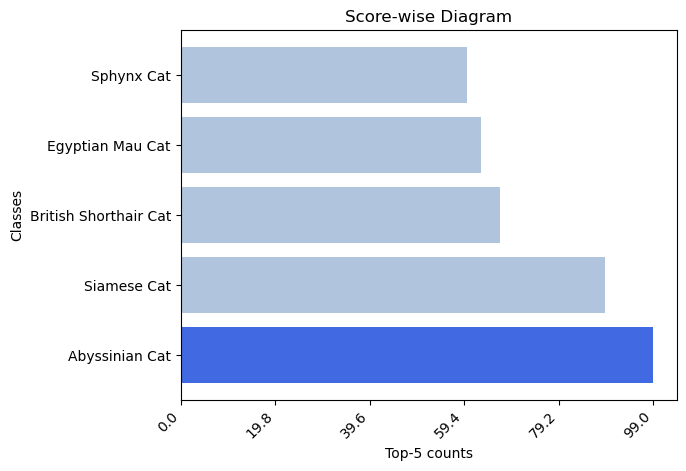

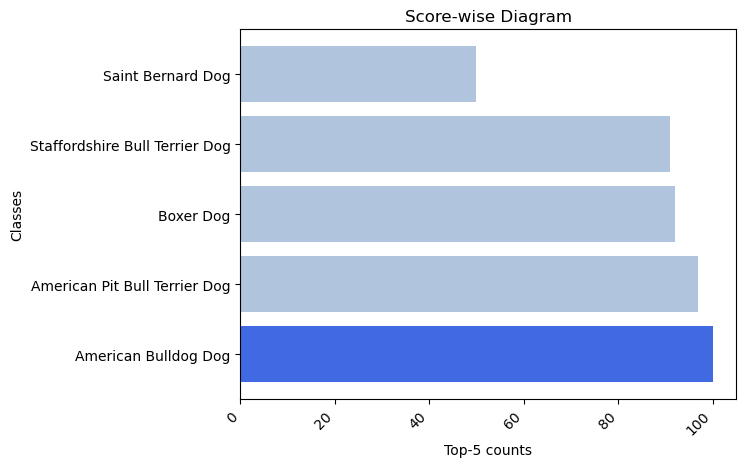

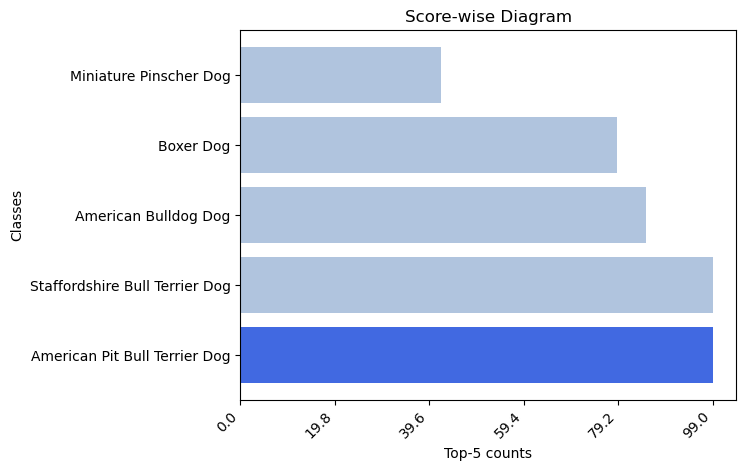

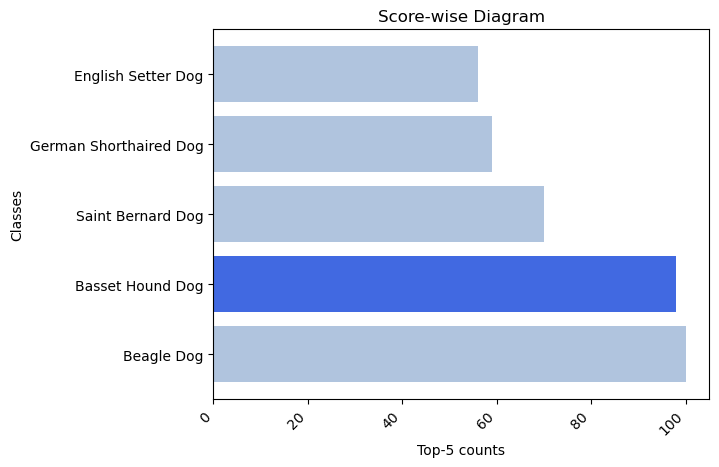

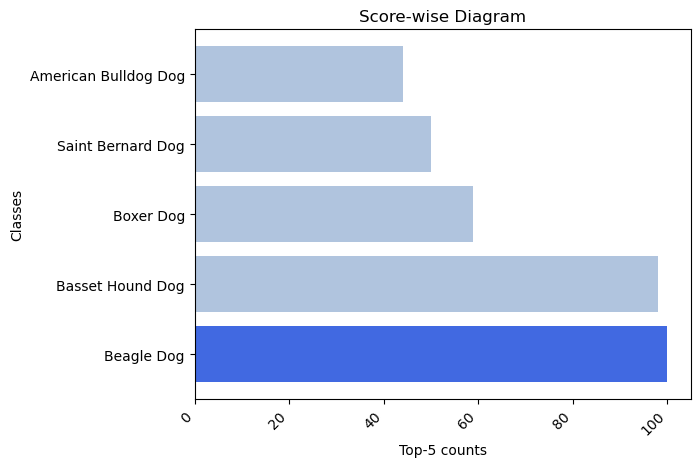

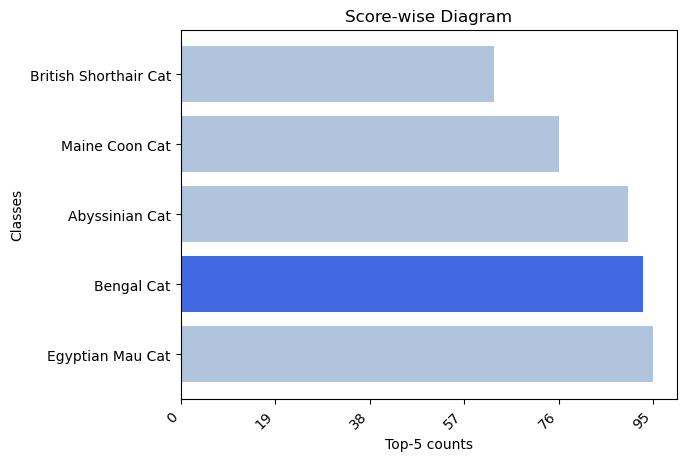

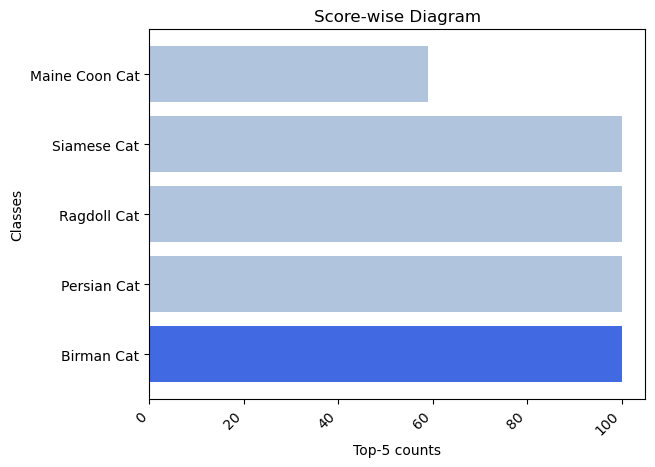

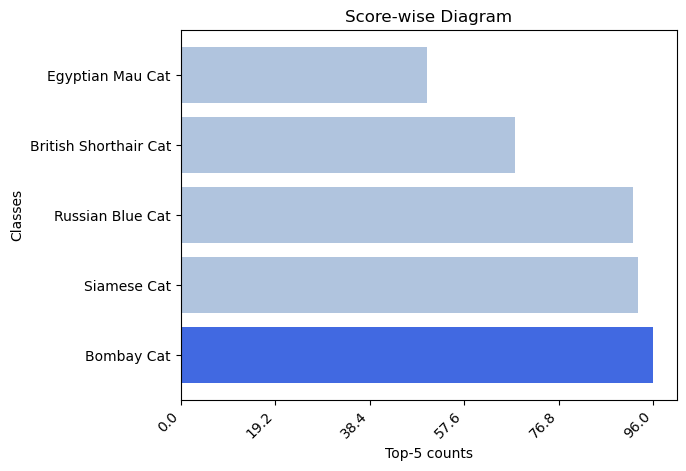

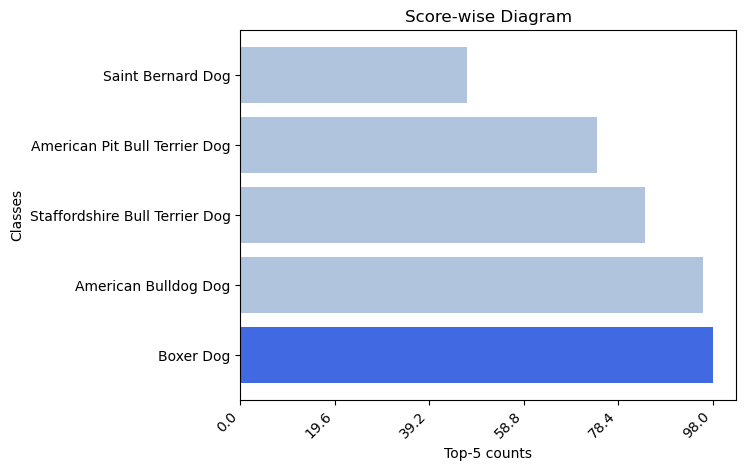

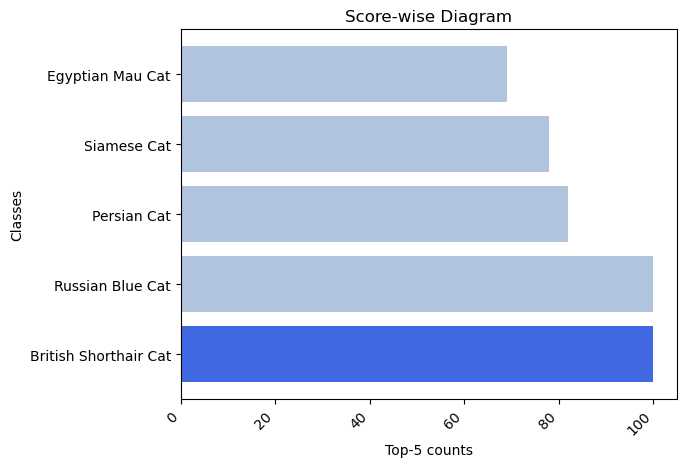

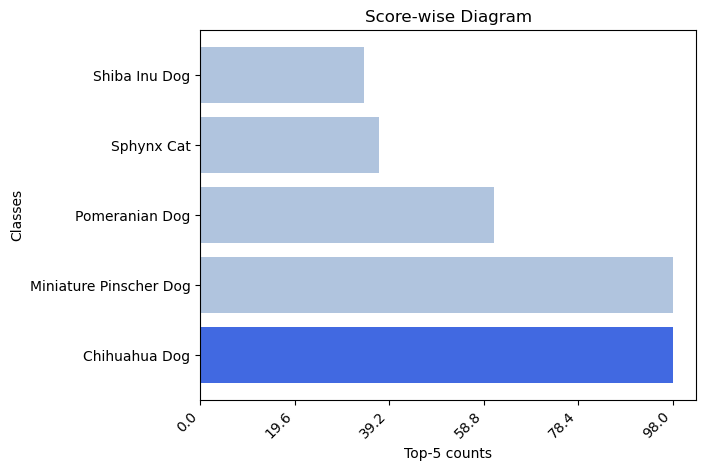

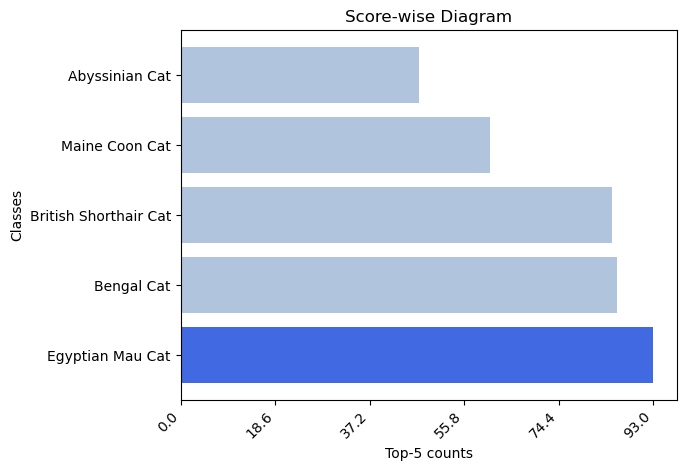

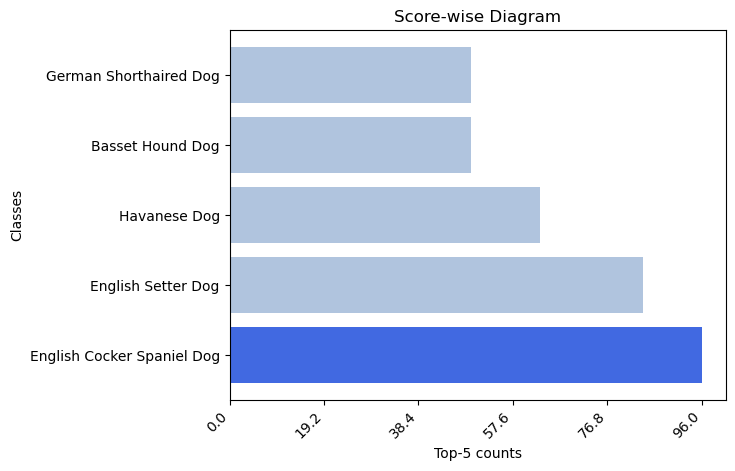

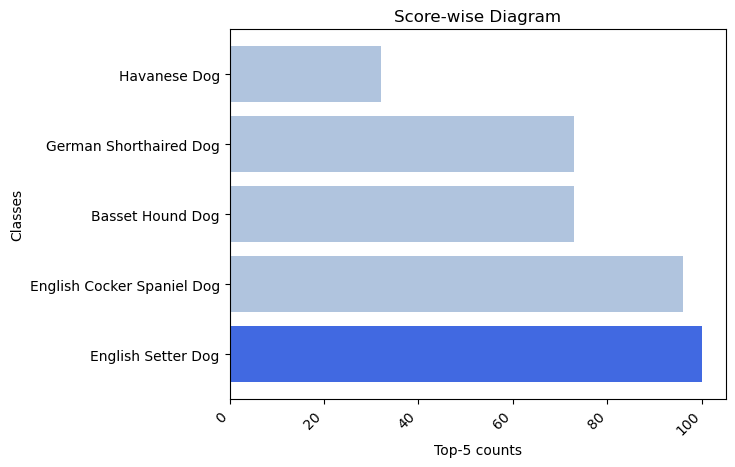

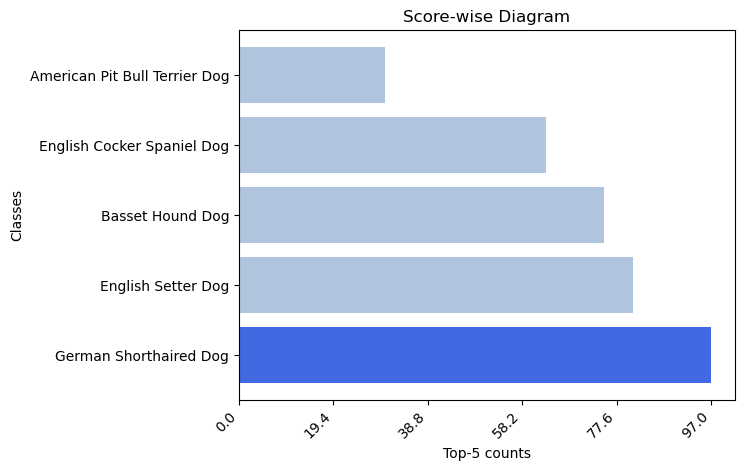

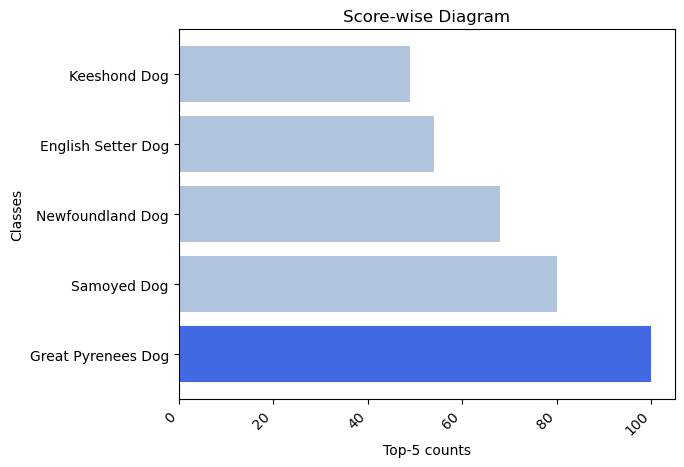

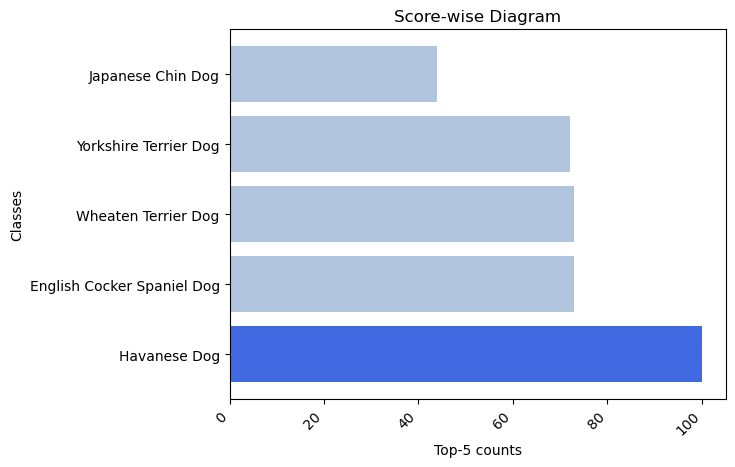

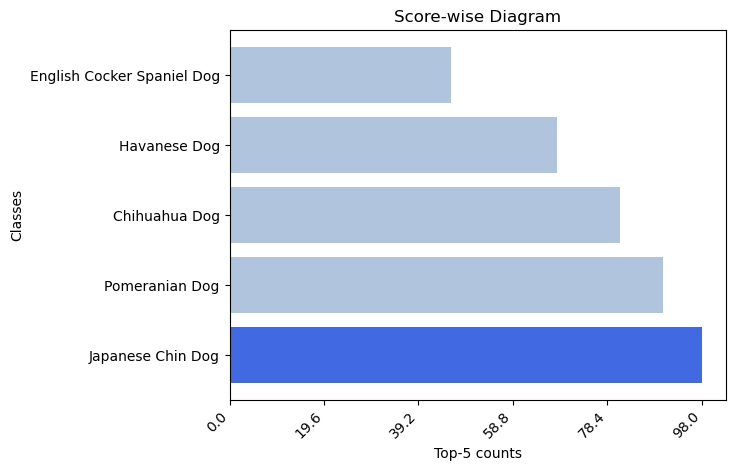

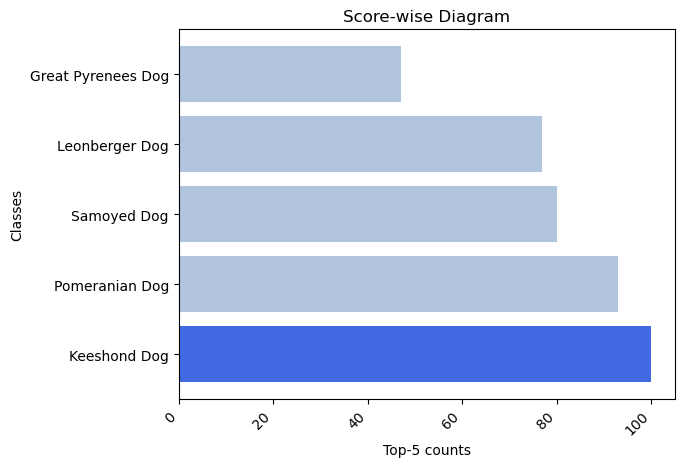

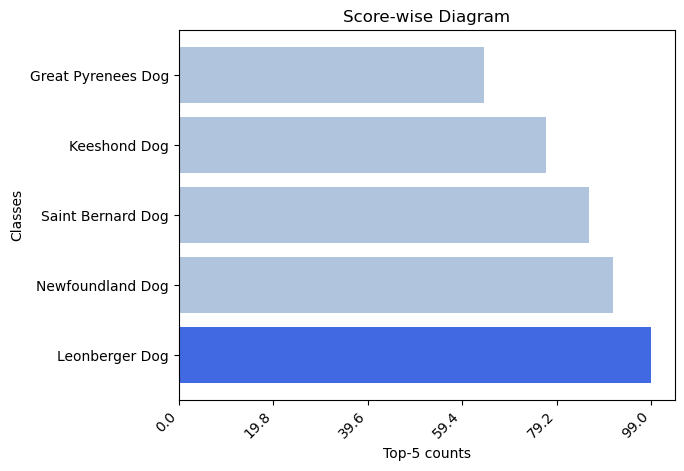

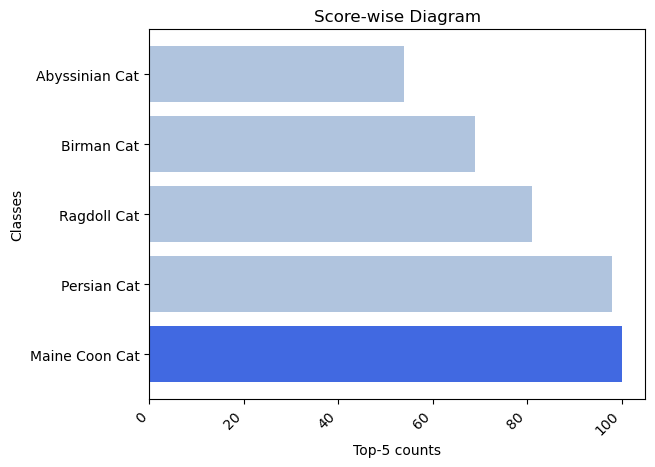

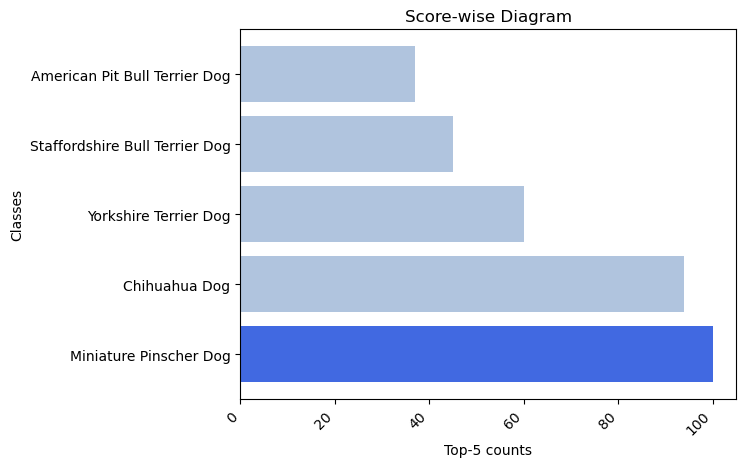

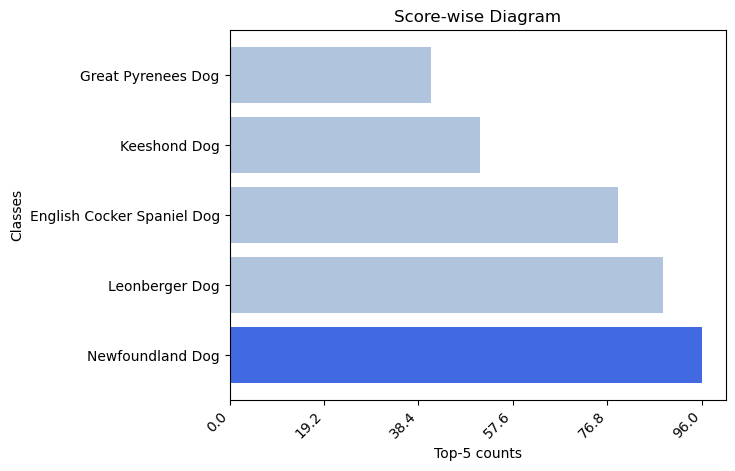

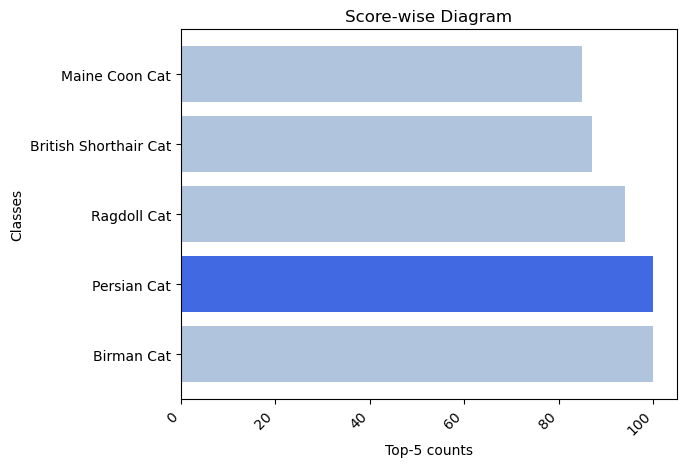

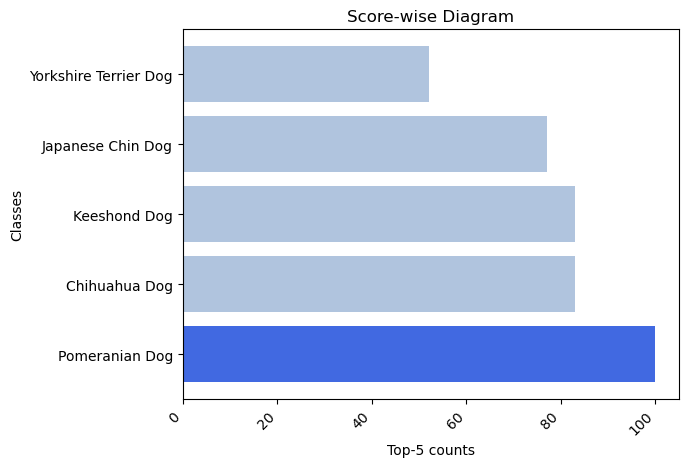

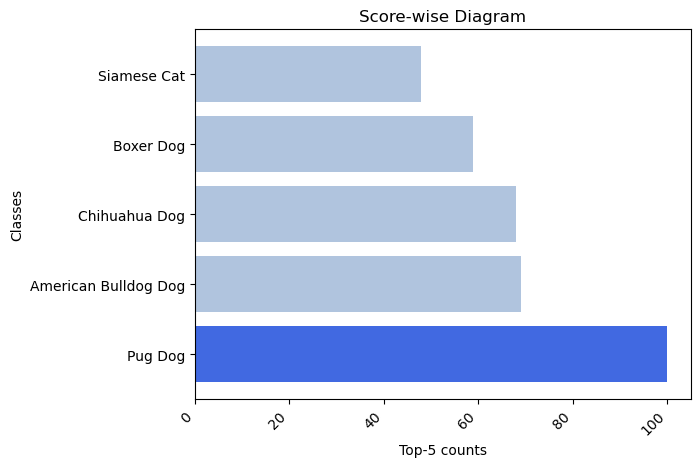

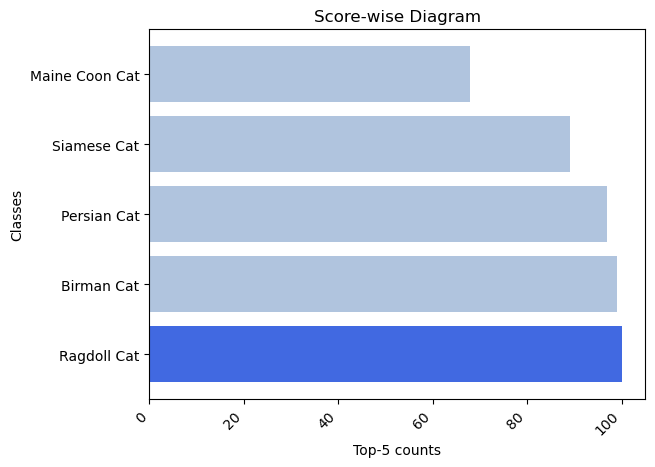

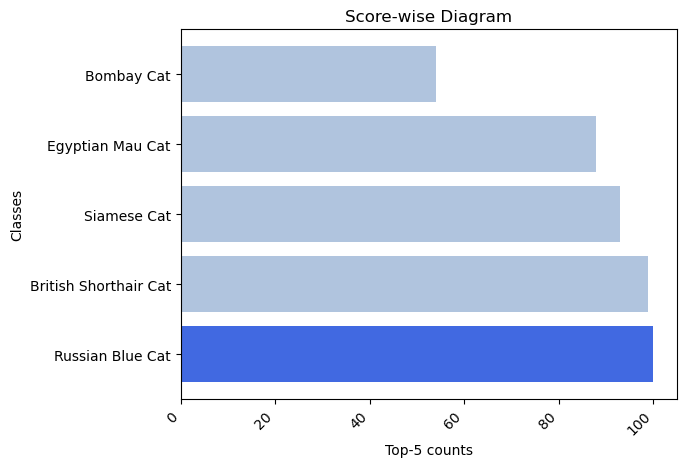

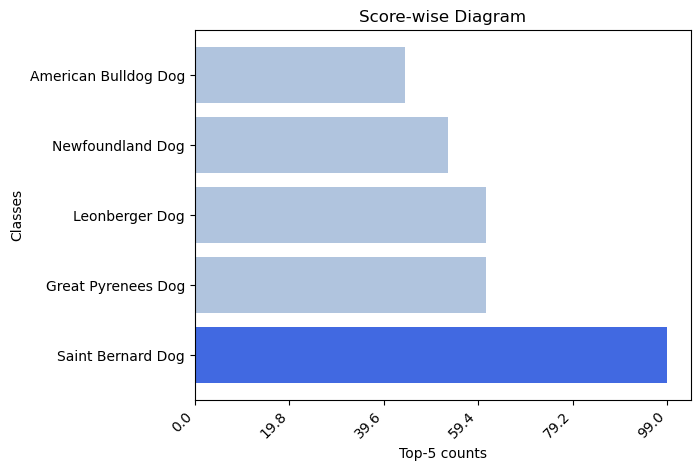

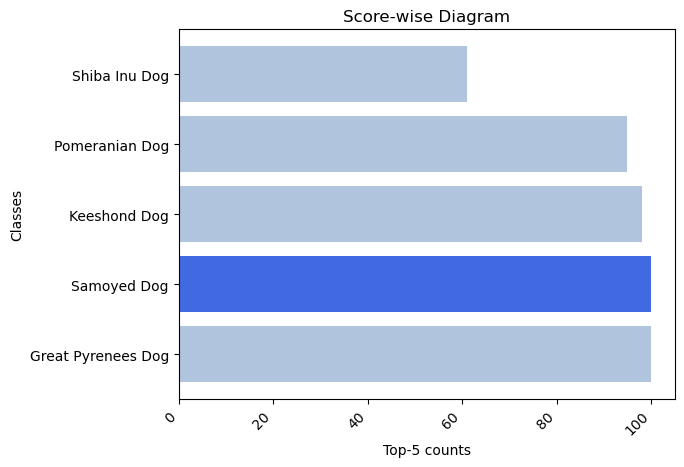

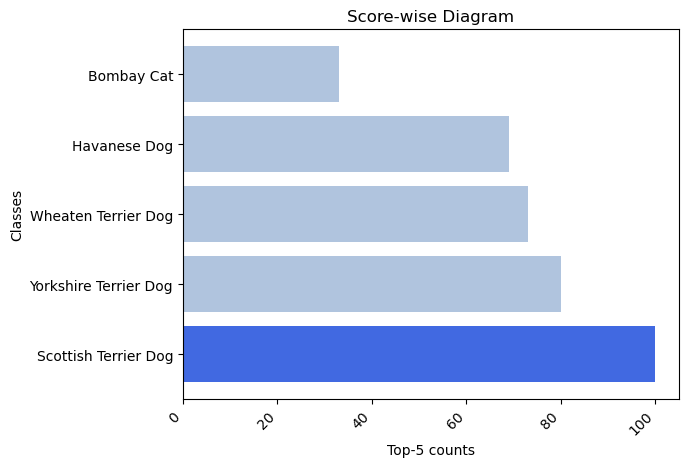

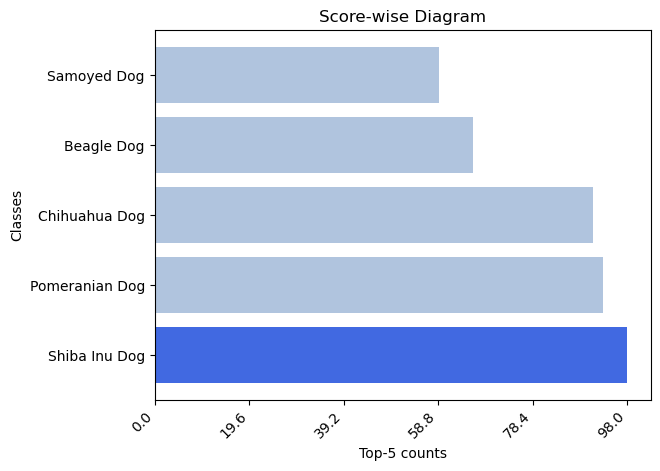

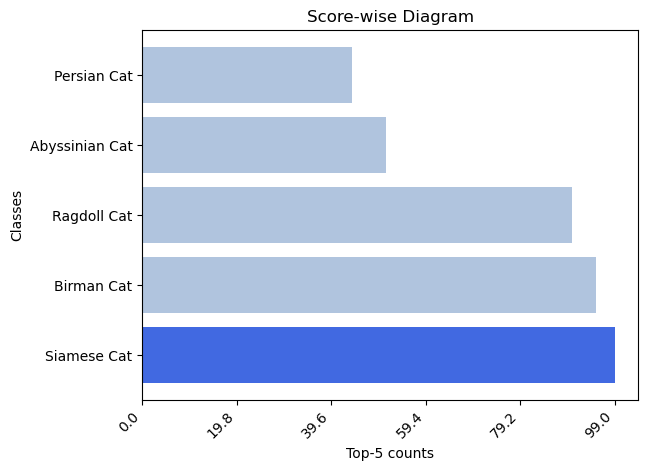

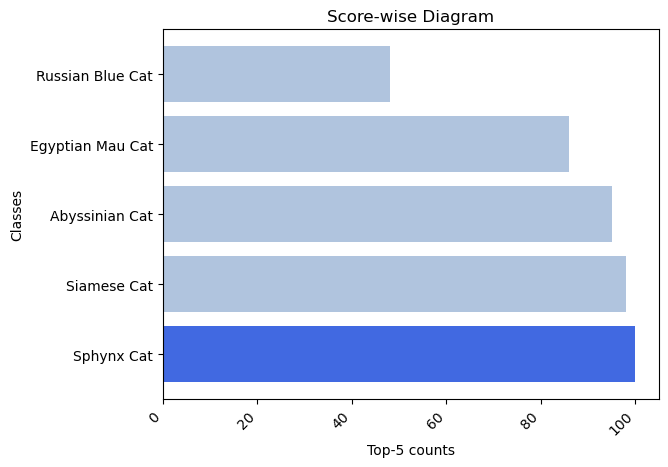

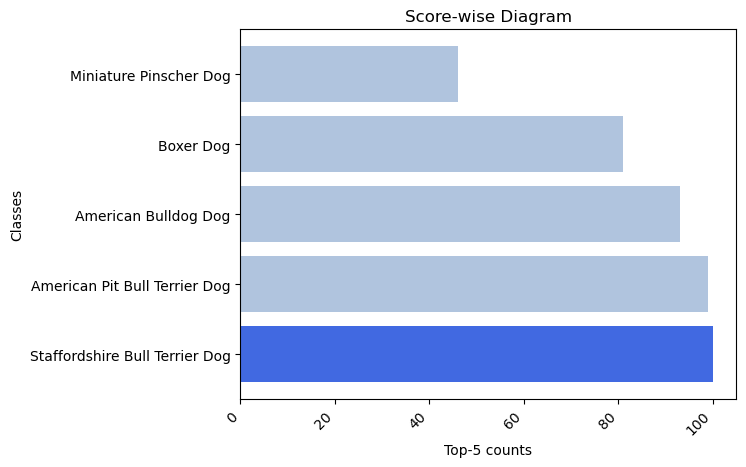

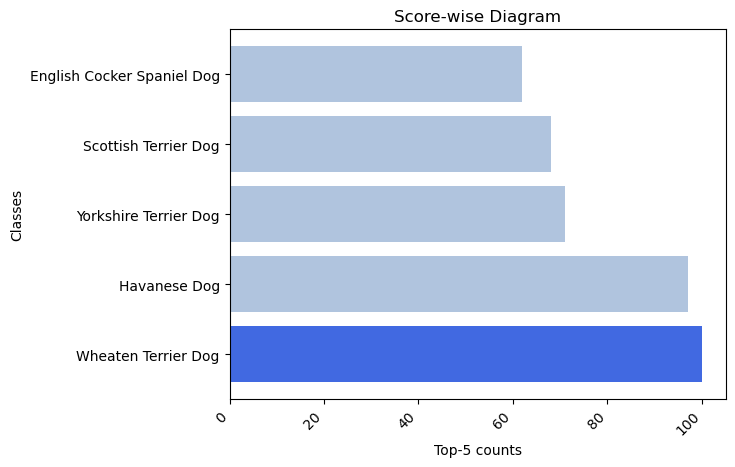

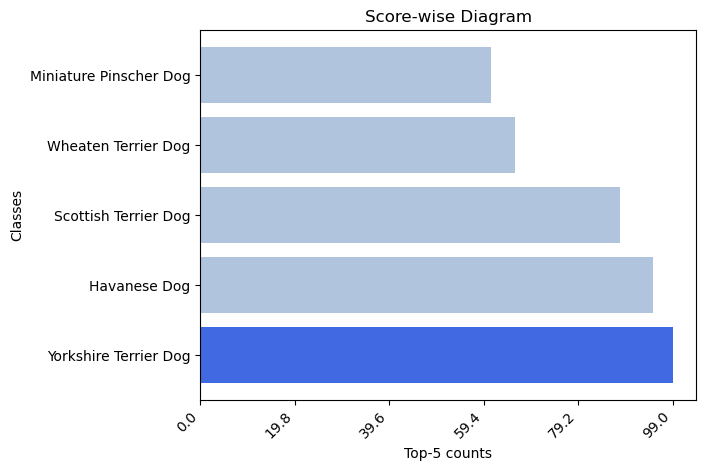

In [13]:
with open('top5.txt', 'r') as file:
    top5 = json.load(file)

for class_ in top5.keys():
    create_graph(class_, top5[class_][0:5])

# Generate attributes functions

In [43]:
def logs():
    logging.basicConfig(
        level=logging.DEBUG,            # Set the minimum log level to DEBUG
        filename='gpt_3_my_cub.log',        # Specify the log file name
        format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
    )

    logger = logging.getLogger(__name__)
    return logger


In [44]:
def get_completion(prompt, logger, model="gpt-3.5-turbo", temperature=0., max_tokens=300):
    messages = [{'role':'system', 'content':"""
    Use this as an example to generate you answers for user's query. Give the answer in a JSON format just like given in the example

    ```Q: What are useful visual features for distinguishing a tiger from a lion in a photo?
       A: There are several useful visual features to tell the difference between a tiger and a lion in a photo:-


        {
            "tiger": [
                     "have orange coats with vertical 'black' stripes",
                     "are generally larger and robust",
                     "often have a more rounded face with prominent cheekbones",
                     "ears are usually smaller and rounded",
                     "tails are long and have a characteristic 'white spot' at the tip",
                     "are found in a variety of habitats, including dense forests and grasslands"
                     ],

            "lion": [
                    "typically have a tawny or 'beige coat', and their fur is often smoother and they have a mane",
                    "have a more compact and muscular build",
                    "lions may have a more squared-off face",
                    "ears are large and often have a more pointed shape",
                    "tails are shorter, ending in a tuft of hair",
                    "habitats are savannas and open woodlands"
                    ]
        }
        ```
    Remember not to use the first class name in the response of second class and vice-a-versa. For example here, in the answer for tiger do not use lion and in answer for lion do not use the word tiger.
"""},
    {"role": "user", "content": prompt}]
    
    try:
        logger.debug(f'Input: {messages}')
        response = openai.ChatCompletion.create(
            model=model,
            messages=messages,
            temperature=temperature,
            max_tokens=max_tokens
        )
        logger.debug(f'Output: {response}')
    except Exception as e:
        logger.error(f'error: {str(e)}')
        raise e
    return response.choices[0].message["content"]

# Create Attributes of Pairs from Top-5 Distribution

In [45]:
def generate_attributes(class1, class2):
    logger = logs()
    
    prompt = f"""
    Q: What are useful features for distinguishing a {class1} from {class2} in a photo?
    A: There are several useful visual features to tell the difference between a {class1} and a {class2} in a photo
    """
    print(prompt)
    response = get_completion(prompt, logger)
#     response = get_completion_dummy(prompt)
    answer = response
    print(response)
    
    return answer

In [46]:
def generate_attributes_dummy(class1, class2):
    logger = logs()
    
    prompt = f"""
    Q: What are useful features for distinguishing a {class1} from {class2} in a photo?
    A: There are several useful visual features to tell the difference between a {class1} and a {class2} in a photo
    """
#     print(prompt)
    return """aasdasd
    asfasfasfdas
    {
    "Laysan Albatross": [
    "have a white head and neck with a dark eye patch",
    "have a black upperwing with a white trailing edge",
    "underside is mostly white with dark edges on the underwing",
    "have a pink bill with a dark tip",
    "are generally medium-sized with a wingspan of around 6 feet",
    "nest in the Northwestern Hawaiian Islands"
    ],

    "Sooty Albatross": [
        "have a dark plumage overall, including the head and neck",
        "have a uniformly dark upperwing without a distinct pattern",
        "underside is dark, often with paler edges on the underwing",
        "have a dark bill without significant markings",
        "are larger in size with a wingspan of around 7 feet",
        "nest on sub-Antarctic islands and some isolated islands in the Southern Ocean"
    ]
    }sfsdfsdfsdf"""

In [47]:
def process_response(response):
    try:
        json_response = response
        json.loads(json_response)
    except Exception as e:
        lines = response.split('\n')
        json_response = ''
        for index, line in enumerate(lines):
            if line.find('{') != -1:
                json_response = line[line.find('{'):] + "\n"
                index += 1
                while index < len(lines) and lines[index].find('}') == -1:
                    json_response += lines[index]
                    index += 1
                if index < len(lines) and lines[index].find('}') != -1:
                    json_response += lines[index][:lines[index].find('}')+1]
                    break
                else:
                    html_string = f'<font color="red">{str(response)}</font>'
                    display(HTML(html_string))
    return json.loads(json_response)

In [48]:
def convert_to_json(dict_set):
    json_dict = dict_set.copy()
    for key in dict_set.keys():
        json_dict[key] = list(dict_set[key])
    return json.dumps(json_dict, indent=4)

In [49]:
descriptor_dict = dict()
already_seen = set()
total_pairs = 0

In [53]:
for class_ in tqdm(top5.keys()):
    number_of_pairs = 0
    for top_class, count in top5[class_][0:4]:
        if class_ == top_class or (class_, top_class) in already_seen or number_of_pairs >=5:
            continue
        response = generate_attributes(class_, top_class)
        try:
            json_response = process_response(response)
        except:
            print("Could not process the input, continue...")
            continue
        for key in json_response.keys():
            if key in descriptor_dict:
                descriptor_dict[key] |= set(json_response[key])
            else:
                descriptor_dict[key] = set(json_response[key])
        already_seen.add((class_, top_class))
        already_seen.add((top_class, class_))
        number_of_pairs += 1
        total_pairs += 1
        
        descriptor_json = convert_to_json(descriptor_dict)
                
        with open(f'descriptors_cub.json', 'w') as file:
            file.write(descriptor_json)
    

  0%|                                                   | 0/200 [00:00<?, ?it/s]


    Q: What are useful features for distinguishing a Black-footed Albatross from Sooty Albatross in a photo?
    A: There are several useful visual features to tell the difference between a Black-footed Albatross and a Sooty Albatross in a photo
    
{
    "Black-footed Albatross": [
        "have a black back and wings",
        "have a white head and underparts",
        "have a yellow bill with a dark tip",
        "have black feet",
        "have a wingspan of about 6 feet"
    ],
    "Sooty Albatross": [
        "have a dark brown or blackish back and wings",
        "have a white head and underparts",
        "have a pale yellow bill",
        "have pink feet",
        "have a wingspan of about 7 feet"
    ]
}

    Q: What are useful features for distinguishing a Black-footed Albatross from Laysan Albatross in a photo?
    A: There are several useful visual features to tell the difference between a Black-footed Albatross and a Laysan Albatross in a photo
    
{
    "Black-footed

  0%|▏                                          | 1/200 [00:15<52:11, 15.74s/it]

{
    "Black-footed Albatross": [
        "have a black back and wings",
        "have a white head and underparts",
        "have a long, slender bill",
        "have a wingspan of around 6 feet",
        "have webbed feet for swimming and diving",
        "are found primarily in the North Pacific Ocean"
    ],
    "Northern Fulmar": [
        "have a gray back and wings",
        "have a white head and underparts",
        "have a shorter, thicker bill",
        "have a wingspan of around 4 feet",
        "have webbed feet for swimming and diving",
        "are found in the North Atlantic and Arctic Oceans"
    ]
}

    Q: What are useful features for distinguishing a Laysan Albatross from Sooty Albatross in a photo?
    A: There are several useful visual features to tell the difference between a Laysan Albatross and a Sooty Albatross in a photo
    
{
    "Laysan Albatross": [
        "have a white head and neck",
        "have a dark gray back and wings",
        "have a yellow bil

  1%|▍                                          | 2/200 [00:28<45:52, 13.90s/it]

{
    "Laysan Albatross": [
        "have a white body with black wings and a black tail",
        "have a large wingspan, measuring up to 6.5 feet",
        "have a long, slender bill",
        "have webbed feet for swimming and diving",
        "are typically found near coastal areas and open ocean"
    ],
    "Long-tailed Jaeger": [
        "have a dark brown body with a lighter brown head and neck",
        "have long, pointed wings",
        "have a short, hooked bill",
        "have long, forked tails",
        "are typically found in Arctic and subarctic regions"
    ]
}

    Q: What are useful features for distinguishing a Sooty Albatross from Long-tailed Jaeger in a photo?
    A: There are several useful visual features to tell the difference between a Sooty Albatross and a Long-tailed Jaeger in a photo
    


  2%|▋                                          | 3/200 [00:34<33:29, 10.20s/it]

{
    "Sooty Albatross": [
        "have a dark brown or blackish plumage",
        "have a large wingspan and a long, slender body",
        "have a hooked bill",
        "have a white patch on the underwing",
        "are typically found in open ocean habitats"
    ],
    "Long-tailed Jaeger": [
        "have a gray or brown plumage",
        "have a medium-sized body with a long, pointed tail",
        "have a slender, pointed bill",
        "have a dark band across the underwing",
        "are typically found in coastal or tundra habitats"
    ]
}

    Q: What are useful features for distinguishing a Groove-billed Ani from White-necked Raven in a photo?
    A: There are several useful visual features to tell the difference between a Groove-billed Ani and a White-necked Raven in a photo
    
{
    "Groove-billed Ani": [
        "have a black body with a long tail",
        "have a distinctive curved bill with a groove along the upper mandible",
        "have a white patch on the win

  2%|▊                                          | 4/200 [00:51<41:59, 12.85s/it]

{
    "Groove-billed Ani": [
        "have a long, curved bill with distinct grooves",
        "have a black body with a brownish back and a white belly",
        "have a long tail with a rounded tip",
        "have a small crest on their head",
        "have a slender body shape"
    ],
    "Common Raven": [
        "have a large, stout bill",
        "have all-black feathers",
        "have a wedge-shaped tail",
        "have a shaggy throat feathers",
        "have a larger body size compared to Groove-billed Ani"
    ]
}

    Q: What are useful features for distinguishing a Crested Auklet from Rhinoceros Auklet in a photo?
    A: There are several useful visual features to tell the difference between a Crested Auklet and a Rhinoceros Auklet in a photo
    
{
    "Crested Auklet": [
        "have a distinctive crest on their head that extends from the forehead to the back of the head",
        "have a black body with white patches on the sides and belly",
        "have a bright oran

  2%|█                                          | 5/200 [01:10<49:26, 15.21s/it]

{
    "Crested Auklet": [
        "have a distinctive crest on their head",
        "have a black body with white patches on the face and neck",
        "have a bright orange bill",
        "have bright orange legs and feet",
        "have a white patch on the back",
        "have a short, stubby tail"
    ],
    "Parakeet Auklet": [
        "have a smaller crest or no crest at all",
        "have a black body with a white patch on the face",
        "have a dark bill",
        "have dark legs and feet",
        "have a dark back",
        "have a longer, more pointed tail"
    ]
}

    Q: What are useful features for distinguishing a Least Auklet from Parakeet Auklet in a photo?
    A: There are several useful visual features to tell the difference between a Least Auklet and a Parakeet Auklet in a photo
    
{
    "Least Auklet": [
        "have a dark gray or black plumage",
        "are small in size, measuring about 15-18 cm in length",
        "have a short, stubby bill",
        

  3%|█▎                                         | 6/200 [01:25<48:39, 15.05s/it]

{
    "Least Auklet": [
        "have a small body size, measuring about 15-20 cm in length",
        "have a dark gray or black plumage",
        "have a short, stubby bill",
        "have a white patch on the underwing",
        "have a white spot behind the eye",
        "have a short, rounded tail"
    ],
    "Rhinoceros Auklet": [
        "have a larger body size, measuring about 30-40 cm in length",
        "have a black plumage with a white belly",
        "have a long, slender bill with a distinctive horn-like projection on the upper mandible",
        "have a dark patch on the underwing",
        "have a dark patch around the eye",
        "have a longer, pointed tail"
    ]
}

    Q: What are useful features for distinguishing a Parakeet Auklet from Rhinoceros Auklet in a photo?
    A: There are several useful visual features to tell the difference between a Parakeet Auklet and a Rhinoceros Auklet in a photo
    


  4%|█▌                                         | 7/200 [01:31<38:48, 12.06s/it]

{
    "Parakeet Auklet": [
        "have a smaller size and more slender build",
        "have a dark gray or black body with a white belly",
        "have a distinctive bright orange bill",
        "have a short, rounded tail",
        "have a white patch on the side of the head"
    ],
    "Rhinoceros Auklet": [
        "are larger and more robust",
        "have a dark brown or black body with a white belly",
        "have a distinctive horn-like projection on the bill during breeding season",
        "have a longer, pointed tail",
        "have a dark patch on the side of the head"
    ]
}

    Q: What are useful features for distinguishing a Rhinoceros Auklet from Pigeon Guillemot in a photo?
    A: There are several useful visual features to tell the difference between a Rhinoceros Auklet and a Pigeon Guillemot in a photo
    


  4%|█▋                                         | 8/200 [01:37<33:18, 10.41s/it]

{
    "Rhinoceros Auklet": [
        "have a distinctive horn-like projection on their bill",
        "have a black body with white underparts",
        "have a white patch on their face that extends from the eye to the bill",
        "have a short, stout body with a thick neck",
        "have short wings and a short, rounded tail",
        "are typically found in coastal areas and breed in burrows"
    ],
    "Pigeon Guillemot": [
        "have a black body with white wing patches",
        "have a slender body with a long neck",
        "have a pointed bill",
        "have long wings and a long, pointed tail",
        "have bright red feet",
        "are typically found in rocky coastal areas and breed in crevices"
    ]
}

    Q: What are useful features for distinguishing a Brewer Blackbird from Boat-tailed Grackle in a photo?
    A: There are several useful visual features to tell the difference between a Brewer Blackbird and a Boat-tailed Grackle in a photo
    
{
    "Brewer Bla

  4%|█▉                                         | 9/200 [02:04<48:54, 15.36s/it]

{
    "Brewer Blackbird": [
        "have a glossy black plumage",
        "males have yellow eyes and a yellow iris",
        "females have dark brown eyes",
        "have a long, slender bill",
        "have a slightly curved culmen",
        "have a shorter tail compared to American Crows",
        "have a more slender body shape"
    ],
    "American Crow": [
        "have a glossy black plumage",
        "have a large, robust body",
        "have a longer tail compared to Brewer Blackbirds",
        "have a heavier bill",
        "have a straight culmen",
        "have a more rounded head shape",
        "have a deeper voice"
    ]
}

    Q: What are useful features for distinguishing a Red-winged Blackbird from Orchard Oriole in a photo?
    A: There are several useful visual features to tell the difference between a Red-winged Blackbird and a Orchard Oriole in a photo
    
{
    "Red-winged Blackbird": [
        "have a black body with red and yellow shoulder patches",
        "

  5%|██                                        | 10/200 [02:23<52:24, 16.55s/it]

{
    "Red-winged Blackbird": [
        "have a black body with red and yellow shoulder patches",
        "males have a distinctive red patch with a yellow border on their wings",
        "females have a smaller, less distinct patch",
        "have a conical bill",
        "have a slender body shape",
        "habitat includes wetlands, marshes, and grasslands"
    ],
    "Yellow-headed Blackbird": [
        "have a black body with a bright yellow head and breast",
        "males have a larger and more vibrant yellow head compared to females",
        "have a conical bill",
        "have a stocky body shape",
        "habitat includes wetlands, marshes, and open fields"
    ]
}

    Q: What are useful features for distinguishing a Rusty Blackbird from Boat-tailed Grackle in a photo?
    A: There are several useful visual features to tell the difference between a Rusty Blackbird and a Boat-tailed Grackle in a photo
    
{
    "Rusty Blackbird": [
        "have a glossy black plumage",
 

  6%|██▎                                       | 11/200 [02:41<53:06, 16.86s/it]

{
    "Rusty Blackbird": [
        "have a dark, glossy black plumage",
        "have a yellow eye",
        "have a slightly rusty or reddish-brown coloration on the edges of their feathers, especially on the head and back",
        "have a slender body shape",
        "have a relatively short tail",
        "have a straight bill"
    ],
    "Shiny Cowbird": [
        "have a shiny black plumage",
        "have a dark eye",
        "have a uniform black coloration without any rusty or reddish-brown edges on their feathers",
        "have a stocky body shape",
        "have a relatively long tail",
        "have a curved bill"
    ]
}

    Q: What are useful features for distinguishing a Yellow-headed Blackbird from Yellow-breasted Chat in a photo?
    A: There are several useful visual features to tell the difference between a Yellow-headed Blackbird and a Yellow-breasted Chat in a photo
    
{
    "Yellow-headed Blackbird": [
        "have a black body with a bright yellow head",
   

  6%|██▌                                       | 12/200 [03:02<57:37, 18.39s/it]

{
    "Yellow-headed Blackbird": [
        "have a black body with a bright yellow head",
        "have a long, pointed bill",
        "males have a distinctive white wing patch",
        "females have a more subdued coloration with a yellowish head",
        "often found in wetland habitats"
    ],
    "Hooded Oriole": [
        "have a black body with a bright yellow hood",
        "have a slightly curved bill",
        "males have a black throat and upper breast",
        "females have a more olive coloration with a yellowish hood",
        "often found in open woodlands and gardens"
    ]
}

    Q: What are useful features for distinguishing a Bobolink from Red-winged Blackbird in a photo?
    A: There are several useful visual features to tell the difference between a Bobolink and a Red-winged Blackbird in a photo
    
{
    "Bobolink": [
        "have a black body with white markings on the back and underparts",
        "have a distinctive white patch on the back of the head",
  

  6%|██▋                                       | 13/200 [03:17<53:55, 17.30s/it]

{
    "Bobolink": [
        "have black and white plumage with a yellow patch on the back of the head",
        "males have a distinctive white patch on the upper back and a black V-shaped bib on the chest",
        "females have a more subdued coloration with brown streaks on the back and breast",
        "have a short, conical bill",
        "have a slender body shape and long tail feathers"
    ],
    "Yellow-breasted Chat": [
        "have a bright yellow breast and belly",
        "have olive-green upperparts and a grayish head",
        "have a thick bill and a prominent white eye-ring",
        "have a stocky body shape and short tail feathers",
        "often have a secretive behavior and are more likely to be found in dense vegetation"
    ]
}

    Q: What are useful features for distinguishing a Indigo Bunting from Lazuli Bunting in a photo?
    A: There are several useful visual features to tell the difference between a Indigo Bunting and a Lazuli Bunting in a photo
    
{
 

  7%|██▉                                       | 14/200 [03:33<52:23, 16.90s/it]

{
    "Indigo Bunting": [
        "have bright blue plumage",
        "males have darker blue coloration than females",
        "have a conical bill",
        "have a stocky build",
        "have a short tail",
        "are often found in open habitats such as fields and meadows"
    ],
    "Cerulean Warbler": [
        "have light blue plumage",
        "males have a black necklace-like pattern on their throat",
        "have a thin, pointed bill",
        "have a slender build",
        "have a long tail",
        "are often found in deciduous forests"
    ]
}

    Q: What are useful features for distinguishing a Lazuli Bunting from Blue Grosbeak in a photo?
    A: There are several useful visual features to tell the difference between a Lazuli Bunting and a Blue Grosbeak in a photo
    
{
    "Lazuli Bunting": [
        "have bright blue plumage on their head, back, and wings",
        "have a white belly and breast",
        "have a thin, pointed bill",
        "have a short tail",

  8%|███▏                                      | 15/200 [03:47<48:58, 15.89s/it]

{
    "Lazuli Bunting": [
        "have bright blue plumage on their head, back, and wings",
        "have a white belly and chest",
        "males have a distinctive dark blue throat and breast",
        "females have a lighter blue coloration overall",
        "have a slender body shape",
        "have a short, pointed bill"
    ],
    "Cerulean Warbler": [
        "have a bright blue coloration on their head, back, and wings",
        "have a white belly and chest",
        "males have a black necklace-like band across their chest",
        "females have a lighter blue coloration overall",
        "have a slender body shape",
        "have a thin, pointed bill"
    ]
}

    Q: What are useful features for distinguishing a Painted Bunting from Indigo Bunting in a photo?
    A: There are several useful visual features to tell the difference between a Painted Bunting and a Indigo Bunting in a photo
    
{
    "Painted Bunting": [
        "have bright and vibrant plumage with a combinat

  8%|███▎                                      | 16/200 [04:07<52:56, 17.26s/it]

{
    "Painted Bunting": [
        "have bright and vibrant plumage with a combination of blue, green, and red colors",
        "are larger in size compared to hummingbirds",
        "have a stout body with a short tail",
        "have a conical beak",
        "are primarily ground-dwelling birds"
    ],
    "Rufous Hummingbird": [
        "have iridescent reddish-brown plumage",
        "are small in size with a slender body and long wings",
        "have a long, thin beak adapted for feeding on nectar",
        "have a long, forked tail",
        "are agile flyers and can hover in mid-air"
    ]
}

    Q: What are useful features for distinguishing a Cardinal from Summer Tanager in a photo?
    A: There are several useful visual features to tell the difference between a Cardinal and a Summer Tanager in a photo
    
{
    "Cardinal": [
        "have bright red plumage",
        "have a distinctive crest on their head",
        "have a black face mask",
        "have a thick, cone-shap

  8%|███▌                                      | 17/200 [04:24<52:12, 17.12s/it]

{
    "Cardinal": [
        "have bright red plumage",
        "have a distinctive crest on their head",
        "have a black mask around their eyes",
        "have a thick, cone-shaped bill",
        "are larger in size compared to Vermilion Flycatcher",
        "have a longer tail"
    ],
    "Vermilion Flycatcher": [
        "have bright red plumage",
        "have a small crest on their head",
        "have a white throat and belly",
        "have a slender, pointed bill",
        "are smaller in size compared to Cardinal",
        "have a shorter tail"
    ]
}

    Q: What are useful features for distinguishing a Spotted Catbird from Green Jay in a photo?
    A: There are several useful visual features to tell the difference between a Spotted Catbird and a Green Jay in a photo
    
{
    "Spotted Catbird": [
        "have a dark gray or black plumage with white spots on their chest and belly",
        "have a long, slender bill",
        "have a crest on their head that can be ra

  9%|███▊                                      | 18/200 [04:42<52:48, 17.41s/it]

{
    "Spotted Catbird": [
        "have a dark gray or black plumage with white spots on their chest and belly",
        "have a long tail and a slender body",
        "have a distinctive black mask around their eyes",
        "have a short, curved bill",
        "are found in rainforests and dense vegetation"
    ],
    "Yellow-breasted Chat": [
        "have a bright yellow plumage on their chest and belly",
        "have a round body shape",
        "have a white eye ring and a white patch on their wings",
        "have a long, straight bill",
        "are found in open woodlands and shrubby areas"
    ]
}

    Q: What are useful features for distinguishing a Gray Catbird from Spotted Catbird in a photo?
    A: There are several useful visual features to tell the difference between a Gray Catbird and a Spotted Catbird in a photo
    
{
    "Gray Catbird": [
        "have gray feathers with a black cap on their head",
        "have a long, slender body shape",
        "have a thin, 

 10%|███▉                                      | 19/200 [05:00<52:48, 17.51s/it]

{
    "Gray Catbird": [
        "have a gray overall plumage",
        "have a black cap on their head",
        "have a long, slender bill",
        "have a long, rounded tail",
        "have a small patch of chestnut under their tail",
        "have a thin white line above their eyes"
    ],
    "Gray Kingbird": [
        "have a gray overall plumage",
        "have a white throat and belly",
        "have a large, heavy bill",
        "have a short, square tail",
        "have a yellow crown on their head",
        "have a broad white band on their wings"
    ]
}

    Q: What are useful features for distinguishing a Yellow-breasted Chat from Yellow-bellied Flycatcher in a photo?
    A: There are several useful visual features to tell the difference between a Yellow-breasted Chat and a Yellow-bellied Flycatcher in a photo
    
{
    "Yellow-breasted Chat": [
        "have a yellow breast and belly",
        "have a grayish-brown back and wings",
        "have a long tail",
        "h

 10%|████▏                                     | 20/200 [05:15<50:08, 16.71s/it]

{
    "Yellow-breasted Chat": [
        "have a yellow breast and belly",
        "have a grayish-brown back and wings",
        "have a long tail",
        "have a black mask around the eyes",
        "have a white throat",
        "have a bulky body shape"
    ],
    "Hooded Oriole": [
        "have a bright yellow body",
        "have a black bib on the throat and upper chest",
        "have black wings with white wing bars",
        "have a long, pointed bill",
        "have a slender body shape",
        "have a black eye stripe"
    ]
}

    Q: What are useful features for distinguishing a Eastern Towhee from Orchard Oriole in a photo?
    A: There are several useful visual features to tell the difference between a Eastern Towhee and a Orchard Oriole in a photo
    
{
    "Eastern Towhee": [
        "have a black head and upper body",
        "have a white belly",
        "have rufous sides",
        "have white wing bars",
        "have a long tail",
        "have a red eye",
  

 10%|████▍                                     | 21/200 [05:31<49:55, 16.74s/it]

{
    "Eastern Towhee": [
        "have a black head and upper body with rufous sides",
        "have white bellies",
        "have white spots on their wings",
        "have a long tail with white outer feathers",
        "have a distinctive red eye",
        "have a chunky body shape"
    ],
    "Dark-eyed Junco": [
        "have a dark gray or brown head and upper body",
        "have white bellies",
        "have white outer tail feathers that are visible in flight",
        "have a pale pink or yellow bill",
        "have a slender body shape",
        "have a dark eye"
    ]
}

    Q: What are useful features for distinguishing a Chuck-will Widow from Cactus Wren in a photo?
    A: There are several useful visual features to tell the difference between a Chuck-will Widow and a Cactus Wren in a photo
    
{
    "Chuck-will Widow": [
        "have a mottled brown and gray plumage",
        "have a long, slender body with a large head",
        "have a distinctive white patch on the

 11%|████▌                                     | 22/200 [05:56<56:29, 19.04s/it]

{
    "Chuck-will Widow": [
        "have a dark brown or blackish-brown plumage",
        "have a large head and a wide mouth",
        "have a long, pointed tail",
        "have a white patch on the throat",
        "have a mottled pattern on the wings",
        "are larger in size compared to Rusty Blackbirds"
    ],
    "Rusty Blackbird": [
        "have a glossy black plumage",
        "have a smaller head and a slender bill",
        "have a shorter, rounded tail",
        "have a yellow eye",
        "have a rusty or reddish-brown coloration on the edges of their feathers",
        "are smaller in size compared to Chuck-will Widows"
    ]
}

    Q: What are useful features for distinguishing a Brandt Cormorant from Pelagic Cormorant in a photo?
    A: There are several useful visual features to tell the difference between a Brandt Cormorant and a Pelagic Cormorant in a photo
    
{
    "Brandt Cormorant": [
        "have a black body with a white patch on their thighs",
        

 12%|████▊                                     | 23/200 [06:13<54:43, 18.55s/it]

{
    "Brandt Cormorant": [
        "have a dark brown or black body with a slender neck",
        "have a long, hooked bill",
        "have a small white patch on the throat",
        "have a shorter wingspan compared to the Black-footed Albatross",
        "are usually found near coastal areas"
    ],
    "Black-footed Albatross": [
        "have a white body with black wings and back",
        "have a long, thin bill",
        "have a black patch around the eyes",
        "have a longer wingspan compared to the Brandt Cormorant",
        "are usually found in open ocean habitats"
    ]
}

    Q: What are useful features for distinguishing a Red-faced Cormorant from Pelagic Cormorant in a photo?
    A: There are several useful visual features to tell the difference between a Red-faced Cormorant and a Pelagic Cormorant in a photo
    
{
    "Red-faced Cormorant": [
        "have a red face and throat",
        "have a dark brown or black body",
        "have a long, slender neck",
   

 12%|█████                                     | 24/200 [06:25<48:02, 16.38s/it]

{
    "Red-faced Cormorant": [
        "have a red face and throat during breeding season",
        "have a long, slender body with a long neck",
        "have a hooked bill",
        "have black feathers with a metallic sheen",
        "have webbed feet for swimming",
        "are usually found near coastal areas"
    ],
    "Rhinoceros Auklet": [
        "have a distinctive horn-like projection on their bill during breeding season",
        "have a stocky body with a short neck",
        "have a stout, pointed bill",
        "have black feathers with white patches on the face",
        "have webbed feet for swimming",
        "are usually found in the northern Pacific Ocean"
    ]
}

    Q: What are useful features for distinguishing a Pelagic Cormorant from Pacific Loon in a photo?
    A: There are several useful visual features to tell the difference between a Pelagic Cormorant and a Pacific Loon in a photo
    


 12%|█████▎                                    | 25/200 [06:32<39:56, 13.69s/it]

{
    "Pelagic Cormorant": [
        "have a black body with a slender neck and a long, hooked bill",
        "have a white patch on their thighs",
        "have a small head with a short, rounded tail",
        "have webbed feet for swimming and diving",
        "are often seen perched on rocks or floating in the water"
    ],
    "Pacific Loon": [
        "have a black head and neck with a white throat and underparts",
        "have a long, slender body with a pointed bill",
        "have a distinctive black and white checkered pattern on their back",
        "have webbed feet for swimming and diving",
        "are often seen swimming on the water or diving for fish"
    ]
}

    Q: What are useful features for distinguishing a Bronzed Cowbird from Boat-tailed Grackle in a photo?
    A: There are several useful visual features to tell the difference between a Bronzed Cowbird and a Boat-tailed Grackle in a photo
    
{
    "Bronzed Cowbird": [
        "have a glossy black plumage",
  

 13%|█████▍                                    | 26/200 [06:51<44:33, 15.36s/it]

{
    "Bronzed Cowbird": [
        "have a glossy black plumage",
        "have a brownish-bronze sheen on their wings and back",
        "have a relatively long tail",
        "have a slender bill",
        "have a small crest on their head"
    ],
    "American Crow": [
        "have a glossy black plumage",
        "have a squared-off tail",
        "have a stout bill",
        "have a large size",
        "have a distinct cawing call"
    ]
}

    Q: What are useful features for distinguishing a Shiny Cowbird from American Crow in a photo?
    A: There are several useful visual features to tell the difference between a Shiny Cowbird and a American Crow in a photo
    
{
    "Shiny Cowbird": [
        "have a shiny black plumage",
        "have a shorter and more rounded tail",
        "have a shorter and thicker bill",
        "have a smaller body size"
    ],
    "American Crow": [
        "have a black plumage",
        "have a longer and more squared-off tail",
        "have a l

 14%|█████▋                                    | 27/200 [07:01<39:46, 13.79s/it]

{
    "Shiny Cowbird": [
        "have a shiny black plumage",
        "males have a bright red eye",
        "have a slender body shape",
        "have a slightly curved bill",
        "have a shorter tail compared to the Boat-tailed Grackle",
        "have a shorter crest on the head"
    ],
    "Boat-tailed Grackle": [
        "have a glossy black plumage",
        "males have a yellow eye",
        "have a larger and more robust body shape",
        "have a longer and straighter bill",
        "have a longer tail compared to the Shiny Cowbird",
        "have a longer crest on the head"
    ]
}

    Q: What are useful features for distinguishing a Brown Creeper from American-Three-toed Woodpecker in a photo?
    A: There are several useful visual features to tell the difference between a Brown Creeper and a American-Three-toed Woodpecker in a photo
    
{
    "Brown Creeper": [
        "have a brown and white mottled plumage",
        "have a long, curved bill",
        "have a thin

 14%|█████▉                                    | 28/200 [07:19<43:01, 15.01s/it]

{
    "Brown Creeper": [
        "have a brown and white mottled plumage",
        "have a long, slender body with a curved bill",
        "have a streaked brown back and a white underside",
        "have a long, stiff tail that they use to prop themselves against tree trunks",
        "have a thin, pointed beak for probing bark for insects"
    ],
    "Red-cockaded Woodpecker": [
        "have a black and white plumage",
        "have a medium-sized body with a straight bill",
        "have a black back with white spots and a white underside",
        "have a short, stiff tail",
        "have a chisel-like beak for drilling holes in trees"
    ]
}

    Q: What are useful features for distinguishing a American Crow from Common Raven in a photo?
    A: There are several useful visual features to tell the difference between a American Crow and a Common Raven in a photo
    
{
    "American Crow": [
        "have a smaller size compared to Common Ravens",
        "have a more rounded tail

 14%|██████                                    | 29/200 [07:35<43:41, 15.33s/it]

{
    "American Crow": [
        "have a larger body size",
        "have a more rounded head shape",
        "have a deeper, hoarser call",
        "have a more uniform pitch in their calls",
        "have a more pronounced nasal bristle",
        "have a steeper forehead",
        "have a more robust bill"
    ],
    "Fish Crow": [
        "have a smaller body size",
        "have a flatter head shape",
        "have a higher-pitched, nasal call",
        "have a more variable pitch in their calls",
        "have a less pronounced nasal bristle",
        "have a less steep forehead",
        "have a more slender bill"
    ]
}

    Q: What are useful features for distinguishing a Fish Crow from Common Raven in a photo?
    A: There are several useful visual features to tell the difference between a Fish Crow and a Common Raven in a photo
    
{
    "Fish Crow": [
        "have a smaller size compared to Common Ravens",
        "have a more slender body shape",
        "have a shorter 

 15%|██████▎                                   | 30/200 [07:47<40:14, 14.20s/it]

{
    "Fish Crow": [
        "have a smaller size compared to White-necked Ravens",
        "have a dark black coloration all over their body",
        "have a shorter and less curved bill",
        "have a more rounded head shape",
        "have a less pronounced throat hackle",
        "have a less prominent neck collar"
    ],
    "White-necked Raven": [
        "are larger in size compared to Fish Crows",
        "have a black coloration with a white neck collar",
        "have a longer and more curved bill",
        "have a more elongated head shape",
        "have a more pronounced throat hackle",
        "have a more prominent neck collar"
    ]
}

    Q: What are useful features for distinguishing a Black-billed Cuckoo from Yellow-billed Cuckoo in a photo?
    A: There are several useful visual features to tell the difference between a Black-billed Cuckoo and a Yellow-billed Cuckoo in a photo
    
{
    "Black-billed Cuckoo": [
        "have a black bill",
        "have a brown

 16%|██████▌                                   | 31/200 [08:04<42:09, 14.97s/it]

{
    "Black-billed Cuckoo": [
        "have a slender body shape",
        "have a long tail with white spots on the underside",
        "have a black bill",
        "have a brownish-gray plumage",
        "have a white belly",
        "have a distinct white patch on the side of the neck"
    ],
    "Olive-sided Flycatcher": [
        "have a stocky body shape",
        "have a short tail",
        "have a dark bill",
        "have a dark grayish-brown plumage",
        "have a white throat and belly",
        "have distinctive white patches on the sides of the breast"
    ]
}

    Q: What are useful features for distinguishing a Mangrove Cuckoo from Yellow-billed Cuckoo in a photo?
    A: There are several useful visual features to tell the difference between a Mangrove Cuckoo and a Yellow-billed Cuckoo in a photo
    
{
    "Mangrove Cuckoo": [
        "have a dark brown or blackish upper body",
        "have a long, curved bill",
        "have a white or buff-colored throat and bel

 16%|██████▋                                   | 32/200 [08:16<39:24, 14.07s/it]

{
    "Mangrove Cuckoo": [
        "have a long, curved bill",
        "have a brownish-gray plumage with a white belly",
        "have a long tail with white tips on the outer feathers",
        "have a distinctive white patch on the side of the neck",
        "are generally larger in size"
    ],
    "White-breasted Nuthatch": [
        "have a short, straight bill",
        "have a blue-gray upper body with a white belly",
        "have a short tail with no white tips on the feathers",
        "have a black cap on the head",
        "are generally smaller in size"
    ]
}

    Q: What are useful features for distinguishing a Yellow-billed Cuckoo from Tropical Kingbird in a photo?
    A: There are several useful visual features to tell the difference between a Yellow-billed Cuckoo and a Tropical Kingbird in a photo
    


 16%|██████▉                                   | 33/200 [08:23<33:10, 11.92s/it]

{
    "Yellow-billed Cuckoo": [
        "have a long, slender body shape",
        "have a yellow bill that is curved downward",
        "have a brownish-gray plumage with a white belly",
        "have a long tail with white spots on the underside",
        "have a distinctive pattern on the wings with white and black bars",
        "are often found in wooded areas and near water sources"
    ],
    "Tropical Kingbird": [
        "have a medium-sized body with a compact build",
        "have a black bill that is straight",
        "have a grayish-brown plumage with a yellow belly",
        "have a short tail with no spots",
        "have plain wings without any distinctive patterns",
        "are often found in open habitats such as fields and gardens"
    ]
}

    Q: What are useful features for distinguishing a Gray-crowned-Rosy Finch from Baird Sparrow in a photo?
    A: There are several useful visual features to tell the difference between a Gray-crowned-Rosy Finch and a Baird Spa

 17%|███████▏                                  | 34/200 [08:40<37:45, 13.65s/it]

{
    "Gray-crowned-Rosy Finch": [
        "have a gray crown and nape",
        "have a pinkish-red breast and sides",
        "have a white belly and undertail coverts",
        "have black wings with white wing bars",
        "have a short, conical bill"
    ],
    "Pine Grosbeak": [
        "have a red or pinkish-red plumage",
        "have a large, heavy bill",
        "have a grayish head and back",
        "have a white belly and undertail coverts",
        "have black wings with white wing bars"
    ]
}

    Q: What are useful features for distinguishing a Purple Finch from Rose-breasted Grosbeak in a photo?
    A: There are several useful visual features to tell the difference between a Purple Finch and a Rose-breasted Grosbeak in a photo
    
{
    "Purple Finch": [
        "have a reddish-purple plumage on their head, breast, and back",
        "have a brownish color on their wings and tail",
        "have a short, conical beak",
        "have a streaked belly",
        "mal

 18%|███████▎                                  | 35/200 [08:56<39:01, 14.19s/it]

{
    "Purple Finch": [
        "have a reddish or purple plumage on their head, breast, and back",
        "have a white or pale belly",
        "have a thick, conical beak",
        "have brown wings with white streaks",
        "have a short tail"
    ],
    "Gray-crowned-Rosy Finch": [
        "have a gray or brown plumage on their head, breast, and back",
        "have a white or pale belly",
        "have a thin, pointed beak",
        "have gray wings with black streaks",
        "have a long tail"
    ]
}

    Q: What are useful features for distinguishing a Northern Flicker from Red-cockaded Woodpecker in a photo?
    A: There are several useful visual features to tell the difference between a Northern Flicker and a Red-cockaded Woodpecker in a photo
    
{
    "Northern Flicker": [
        "have a brownish body with black bars on the back and wings",
        "have a white rump patch that is visible in flight",
        "have a black crescent on the upper breast",
        "have

 18%|███████▌                                  | 36/200 [09:14<42:15, 15.46s/it]

{
    "Northern Flicker": [
        "have a brown body with black bars on the back and wings",
        "have a white rump patch that is visible in flight",
        "have a black crescent on the chest",
        "have a red patch on the nape of the neck",
        "have a long, slightly curved bill",
        "have a white belly with black spots"
    ],
    "American-Three-toed Woodpecker": [
        "have a black body with white bars on the back and wings",
        "have a white patch on the back",
        "have a black crown and nape",
        "have a short, straight bill",
        "have a white belly without any spots",
        "have three toes instead of four like other woodpeckers"
    ]
}

    Q: What are useful features for distinguishing a Acadian Flycatcher from Olive-sided Flycatcher in a photo?
    A: There are several useful visual features to tell the difference between a Acadian Flycatcher and a Olive-sided Flycatcher in a photo
    
{
    "Acadian Flycatcher": [
        "hav

 18%|███████▊                                  | 37/200 [09:30<42:14, 15.55s/it]

{
    "Acadian Flycatcher": [
        "have olive-green upperparts and a pale yellowish throat and breast",
        "have a distinct white eye-ring",
        "have a relatively long primary projection",
        "have a relatively long and broad bill",
        "have a relatively short tail"
    ],
    "Least Flycatcher": [
        "have grayish-brown upperparts and a pale yellowish throat and breast",
        "have a faint eye-ring or no eye-ring at all",
        "have a relatively short primary projection",
        "have a relatively short and narrow bill",
        "have a relatively long tail"
    ]
}

    Q: What are useful features for distinguishing a Great-Crested Flycatcher from Olive-sided Flycatcher in a photo?
    A: There are several useful visual features to tell the difference between a Great-Crested Flycatcher and a Olive-sided Flycatcher in a photo
    
{
    "Great-Crested Flycatcher": [
        "have a bright yellow belly and breast",
        "have a grayish-brown back 

 19%|███████▉                                  | 38/200 [09:43<40:24, 14.97s/it]

{
    "Great-Crested Flycatcher": [
        "have a grayish-brown upper body with a yellow belly",
        "have a distinct crest on their head",
        "have a black bill and black wings with white wing bars",
        "have a long tail with white outer tail feathers",
        "have a white throat and breast with a yellow wash",
        "have a bold and contrasting facial pattern with a dark eye stripe"
    ],
    "Yellow-bellied Flycatcher": [
        "have an olive-green upper body with a yellow belly",
        "have a small crest on their head",
        "have a pale bill and olive-green wings with two white wing bars",
        "have a short tail with no white outer tail feathers",
        "have a pale throat and breast with a faint yellow wash",
        "have a subtle and less contrasting facial pattern with a faint eye stripe"
    ]
}

    Q: What are useful features for distinguishing a Least Flycatcher from Great-Crested Flycatcher in a photo?
    A: There are several useful vis

 20%|████████▏                                 | 39/200 [10:01<42:12, 15.73s/it]

{
    "Least Flycatcher": [
        "have a small size and compact body shape",
        "have a grayish-brown upper body with a pale throat and breast",
        "have a distinct white eye ring",
        "have short wings and a short tail",
        "have a relatively plain appearance with minimal markings"
    ],
    "Olive-sided Flycatcher": [
        "have a larger size and more slender body shape",
        "have a dark brown or grayish-brown upper body with a contrasting white throat and breast",
        "have a distinct white patch on the sides of the breast",
        "have long wings and a long tail",
        "have a more striking appearance with bold markings"
    ]
}

    Q: What are useful features for distinguishing a Olive-sided Flycatcher from Western-Wood Pewee in a photo?
    A: There are several useful visual features to tell the difference between a Olive-sided Flycatcher and a Western-Wood Pewee in a photo
    


 20%|████████▍                                 | 40/200 [10:08<35:08, 13.18s/it]

{
    "Olive-sided Flycatcher": [
        "have a dark brownish-gray back and wings",
        "have a white or light gray breast and belly",
        "have a distinct white patch on the sides of the breast",
        "have a large head with a short bill",
        "have a short tail with white edges",
        "have a bold white or light gray eye-ring"
    ],
    "Western-Wood Pewee": [
        "have a dark gray or olive-brown back and wings",
        "have a pale yellow or whitish breast and belly",
        "have a faint or no white patch on the sides of the breast",
        "have a small head with a long bill",
        "have a long tail with no white edges",
        "have a faint or no eye-ring"
    ]
}

    Q: What are useful features for distinguishing a Scissor-tailed Flycatcher from Great-Grey Shrike in a photo?
    A: There are several useful visual features to tell the difference between a Scissor-tailed Flycatcher and a Great-Grey Shrike in a photo
    
{
    "Scissor-tailed Flyca

 20%|████████▌                                 | 41/200 [10:29<40:47, 15.40s/it]

{
    "Scissor-tailed Flycatcher": [
        "have a long, scissor-like tail with white outer feathers",
        "have a pale gray head and upperparts",
        "have a salmon-pink belly and undertail coverts",
        "have a black eye stripe and a white throat",
        "have a slender bill with a slight downward curve"
    ],
    "Loggerhead Shrike": [
        "have a shorter, square-shaped tail",
        "have a gray head and back",
        "have a white breast and belly",
        "have a black mask across the eyes",
        "have a hooked bill with a slight downward curve"
    ]
}

    Q: What are useful features for distinguishing a Vermilion Flycatcher from Scarlet Tanager in a photo?
    A: There are several useful visual features to tell the difference between a Vermilion Flycatcher and a Scarlet Tanager in a photo
    
{
    "Vermilion Flycatcher": [
        "have bright red plumage",
        "have a crest on their head",
        "have a long, thin bill",
        "have a whit

 21%|████████▊                                 | 42/200 [10:39<36:39, 13.92s/it]

{
    "Vermilion Flycatcher": [
        "have bright red plumage on their head, breast, and back",
        "have a black mask around their eyes",
        "have a long, thin bill",
        "have a slender body shape",
        "have a white belly and undertail coverts"
    ],
    "Summer Tanager": [
        "have a bright red plumage overall",
        "have a thicker bill",
        "have a stockier body shape",
        "have a darker red color on their wings and tail",
        "have a pale grayish throat and belly"
    ]
}

    Q: What are useful features for distinguishing a Yellow-bellied Flycatcher from Acadian Flycatcher in a photo?
    A: There are several useful visual features to tell the difference between a Yellow-bellied Flycatcher and a Acadian Flycatcher in a photo
    
{
    "Yellow-bellied Flycatcher": [
        "have olive-green upperparts and a yellowish belly",
        "have a distinct white eye-ring",
        "have two white wing bars",
        "have a relatively short 

 22%|█████████                                 | 43/200 [10:50<34:18, 13.11s/it]

{
    "Yellow-bellied Flycatcher": [
        "have a yellowish belly",
        "have a grayish-brown back and wings",
        "have a white throat and breast",
        "have a distinct eye ring",
        "have a relatively short bill"
    ],
    "Olive-sided Flycatcher": [
        "have a white belly",
        "have a dark brown back and wings",
        "have a grayish throat and breast",
        "have a distinct white patch on the sides",
        "have a relatively long bill"
    ]
}

    Q: What are useful features for distinguishing a Frigatebird from Laysan Albatross in a photo?
    A: There are several useful visual features to tell the difference between a Frigatebird and a Laysan Albatross in a photo
    
{
    "Frigatebird": [
        "have long, slender wings with a wingspan of up to 7 feet",
        "have a forked tail",
        "have a dark plumage, often black or dark brown",
        "have a hooked bill",
        "have a distinctive red throat pouch that inflates during cou

 22%|█████████▏                                | 44/200 [11:09<38:16, 14.72s/it]

{
    "Frigatebird": [
        "have a large wingspan and long, pointed wings",
        "have a forked tail",
        "have a black plumage with a glossy sheen",
        "have a hooked bill",
        "have a distinctive red throat pouch that is inflated during courtship displays",
        "are often seen soaring high in the sky"
    ],
    "Red-faced Cormorant": [
        "have a smaller wingspan and shorter wings",
        "have a rounded tail",
        "have a dark brown plumage",
        "have a straight bill",
        "have a red face and throat",
        "are often seen swimming and diving in the water"
    ]
}

    Q: What are useful features for distinguishing a Northern Fulmar from Red-legged Kittiwake in a photo?
    A: There are several useful visual features to tell the difference between a Northern Fulmar and a Red-legged Kittiwake in a photo
    
{
    "Northern Fulmar": [
        "have a white body with a gray back and wings",
        "have a thick, hooked bill",
        

 22%|█████████▍                                | 45/200 [11:28<41:09, 15.93s/it]

{
    "Northern Fulmar": [
        "have a white body with a gray back and wings",
        "have a thick, stubby bill",
        "have a rounded head and a short neck",
        "have a wingspan of about 100-110 cm",
        "have a more streamlined body shape"
    ],
    "Slaty-backed Gull": [
        "have a dark gray to black back and wings",
        "have a yellow bill with a red spot near the tip",
        "have a more slender body with a longer neck",
        "have a wingspan of about 140-160 cm",
        "have a more robust and bulky appearance"
    ]
}

    Q: What are useful features for distinguishing a Gadwall from Pied-billed Grebe in a photo?
    A: There are several useful visual features to tell the difference between a Gadwall and a Pied-billed Grebe in a photo
    
{
    "Gadwall": [
        "have a brownish-gray body with a black rear end",
        "have a white belly and a distinctive black patch on the tail",
        "have a grayish-brown head with a white patch near 

 23%|█████████▋                                | 46/200 [11:51<46:43, 18.20s/it]

{
    "Gadwall": [
        "have a grayish-brown body with a black rear end",
        "have a white belly and a distinctive white patch on the wings",
        "have a small, black bill",
        "males have a grayish-brown head with a black patch on the face",
        "females have a mottled brown body with a dark eye stripe"
    ],
    "Hooded Merganser": [
        "have a black body with white patches on the sides",
        "have a large, fan-shaped crest on the head",
        "have a long, thin bill that is black with a yellow tip",
        "males have a black head with a large white patch on the face",
        "females have a brownish head with a smaller crest"
    ]
}

    Q: What are useful features for distinguishing a American Goldfinch from Evening Grosbeak in a photo?
    A: There are several useful visual features to tell the difference between a American Goldfinch and a Evening Grosbeak in a photo
    
{
    "American Goldfinch": [
        "have bright yellow plumage during

 24%|█████████▊                                | 47/200 [12:13<49:24, 19.38s/it]

{
    "American Goldfinch": [
        "have bright yellow plumage during breeding season",
        "have black wings with white wing bars",
        "have a black cap on their head",
        "have a small, pointed bill",
        "have a slender body shape",
        "are smaller in size compared to Hooded Orioles"
    ],
    "Hooded Oriole": [
        "have bright orange-yellow plumage",
        "have black wings with white wing patches",
        "have a black bib on their throat",
        "have a long, curved bill",
        "have a more robust body shape",
        "are larger in size compared to American Goldfinches"
    ]
}

    Q: What are useful features for distinguishing a European Goldfinch from Evening Grosbeak in a photo?
    A: There are several useful visual features to tell the difference between a European Goldfinch and a Evening Grosbeak in a photo
    
{
    "European Goldfinch": [
        "have a bright yellow body with black and white wings",
        "have a red face and

 24%|██████████                                | 48/200 [12:27<44:59, 17.76s/it]

{
    "European Goldfinch": [
        "have a bright yellow body with black and white wings",
        "have a red face and black cap on their head",
        "have a slender body and a pointed beak",
        "have a distinctive black and white pattern on their tail feathers",
        "are typically found in open woodlands and gardens"
    ],
    "Gray-crowned-Rosy Finch": [
        "have a gray body with a pinkish hue on their breast and head",
        "have a short, stout body and a thick beak",
        "have a gray crown on their head",
        "have a white patch on their wings",
        "are typically found in alpine and subalpine habitats"
    ]
}

    Q: What are useful features for distinguishing a Boat-tailed Grackle from Cape-Glossy Starling in a photo?
    A: There are several useful visual features to tell the difference between a Boat-tailed Grackle and a Cape-Glossy Starling in a photo
    


 24%|██████████▎                               | 49/200 [12:34<36:32, 14.52s/it]

{
    "Boat-tailed Grackle": [
        "have a long, keel-shaped tail",
        "males have iridescent black feathers with a blue-green sheen",
        "females have dark brown feathers with lighter streaks",
        "have a long, slender bill",
        "have yellow eyes",
        "are found in wetland habitats, such as marshes and swamps"
    ],
    "Cape-Glossy Starling": [
        "have a shorter, rounded tail",
        "have glossy black feathers with a metallic sheen",
        "have a short, stout bill",
        "have red eyes",
        "are found in open woodlands and savannas",
        "may have white spots on their wings"
    ]
}

    Q: What are useful features for distinguishing a Eared Grebe from Horned Grebe in a photo?
    A: There are several useful visual features to tell the difference between a Eared Grebe and a Horned Grebe in a photo
    
{
    "Eared Grebe": [
        "have a black head and neck with a distinctive golden ear tuft",
        "have a white eye ring",
 

 25%|██████████▌                               | 50/200 [12:54<40:20, 16.14s/it]

{
    "Eared Grebe": [
        "have a black head and neck with a distinctive golden ear tuft",
        "have a white body with black feathers on the back and wings",
        "have a long, slender bill that is slightly upturned",
        "have red eyes",
        "have black legs and feet"
    ],
    "Pied-billed Grebe": [
        "have a brownish-black body with a white patch on the bill",
        "have a short, thick bill that is pale in color",
        "have a dark eye",
        "have dark legs and feet",
        "have a rounded head and neck"
    ]
}

    Q: What are useful features for distinguishing a Horned Grebe from Western Grebe in a photo?
    A: There are several useful visual features to tell the difference between a Horned Grebe and a Western Grebe in a photo
    
{
    "Horned Grebe": [
        "have a black head with a distinctive golden 'horn' on the side",
        "have a white neck and underparts",
        "have a dark back and wings",
        "have red eyes",
       

 26%|██████████▋                               | 51/200 [13:09<39:23, 15.86s/it]

{
    "Horned Grebe": [
        "have a black head with a distinctive golden 'horn' on the side",
        "have a white face and neck",
        "have a black back and wings",
        "have a white belly",
        "have a thin, pointed bill",
        "have red eyes"
    ],
    "Red-breasted Merganser": [
        "have a reddish-brown head with a shaggy crest",
        "have a white neck and breast",
        "have a gray back and wings",
        "have a white belly",
        "have a long, thin, serrated bill",
        "have yellow eyes"
    ]
}

    Q: What are useful features for distinguishing a Pied-billed Grebe from Horned Grebe in a photo?
    A: There are several useful visual features to tell the difference between a Pied-billed Grebe and a Horned Grebe in a photo
    


 26%|██████████▉                               | 52/200 [13:19<34:19, 13.92s/it]

{
    "Pied-billed Grebe": [
        "have a black bill with a distinctive white band near the tip",
        "have a brownish body with a lighter underside",
        "have a short tail that is often held upright",
        "have a small, rounded head",
        "have a relatively plain appearance with no distinct markings"
    ],
    "Horned Grebe": [
        "have a black bill that is slightly upturned",
        "have a black and white body with a reddish neck and sides",
        "have a longer tail that is often held flat or slightly raised",
        "have a larger, more angular head with a distinctive 'horned' appearance",
        "have distinct black and white markings on the face and neck"
    ]
}

    Q: What are useful features for distinguishing a Western Grebe from Pacific Loon in a photo?
    A: There are several useful visual features to tell the difference between a Western Grebe and a Pacific Loon in a photo
    


 26%|███████████▏                              | 53/200 [13:26<29:24, 12.00s/it]

{
    "Western Grebe": [
        "have a long, slender neck",
        "have a black cap on their head that extends down the back of their neck",
        "have a white face and throat",
        "have a long, straight bill",
        "have a black back and wings",
        "have white underparts",
        "have long, lobed toes",
        "are larger in size compared to Pacific Loons"
    ],
    "Pacific Loon": [
        "have a shorter, thicker neck",
        "have a black head and neck with a white throat patch",
        "have a short, slightly upturned bill",
        "have a black back and wings",
        "have a white underbelly",
        "have short, webbed toes",
        "are smaller in size compared to Western Grebes"
    ]
}

    Q: What are useful features for distinguishing a Blue Grosbeak from Painted Bunting in a photo?
    A: There are several useful visual features to tell the difference between a Blue Grosbeak and a Painted Bunting in a photo
    


 27%|███████████▎                              | 54/200 [13:34<26:06, 10.73s/it]

{
    "Blue Grosbeak": [
        "have a deep blue plumage with black wings and tail",
        "males have a distinctive rusty-brown breast patch",
        "females have a lighter blue color with streaks on the breast",
        "have a thick, conical bill",
        "are slightly larger in size compared to Painted Buntings",
        "are often found in open habitats such as grasslands and shrubby areas"
    ],
    "Painted Bunting": [
        "males have a vibrant plumage with a mix of bright blue, green, and red",
        "females have a more subdued green color with yellowish underparts",
        "have a small, pointed bill",
        "are smaller in size compared to Blue Grosbeaks",
        "are often found in dense vegetation such as thickets and brushy areas",
        "have a distinctive song that is often heard during breeding season"
    ]
}

    Q: What are useful features for distinguishing a Evening Grosbeak from Yellow-breasted Chat in a photo?
    A: There are several useful 

 28%|███████████▌                              | 55/200 [13:47<27:18, 11.30s/it]

{
    "Evening Grosbeak": [
        "have a large, conical bill that is thick and heavy",
        "have a black head with a bright yellow body",
        "wings are black with white patches",
        "tails are black with white edges",
        "have a stocky build"
    ],
    "Hooded Oriole": [
        "have a slender, pointed bill that is curved",
        "have a black head with a bright orange or yellow body",
        "wings are black with white patches",
        "tails are black with white edges",
        "have a sleek and slender build"
    ]
}

    Q: What are useful features for distinguishing a Pine Grosbeak from Vermilion Flycatcher in a photo?
    A: There are several useful visual features to tell the difference between a Pine Grosbeak and a Vermilion Flycatcher in a photo
    
{
    "Pine Grosbeak": [
        "have a plump body with a large head",
        "males have a bright red or pinkish-red plumage",
        "females have a duller plumage with a mix of gray, brown, and re

 28%|███████████▊                              | 56/200 [14:00<28:56, 12.06s/it]

{
    "Pine Grosbeak": [
        "have a reddish-pink plumage",
        "are larger in size compared to Cardinals",
        "have a thick, conical beak",
        "have a crest on their head",
        "have a white patch on their wings",
        "are found in northern regions"
    ],
    "Cardinal": [
        "have a bright red plumage",
        "are smaller in size compared to Pine Grosbeaks",
        "have a short, thick beak",
        "have a prominent crest on their head",
        "have black markings around their face",
        "are found in North America"
    ]
}

    Q: What are useful features for distinguishing a Rose-breasted Grosbeak from Red-headed Woodpecker in a photo?
    A: There are several useful visual features to tell the difference between a Rose-breasted Grosbeak and a Red-headed Woodpecker in a photo
    
{
    "Rose-breasted Grosbeak": [
        "have a black head and back with a white breast and belly",
        "males have a distinctive rose-red patch on their b

 28%|███████████▉                              | 57/200 [14:20<34:20, 14.41s/it]

{
    "Rose-breasted Grosbeak": [
        "have a black head and back with a white belly and breast",
        "males have a distinctive rose-red patch on their breast",
        "have a thick, conical bill",
        "have a medium-sized body with a rounded shape",
        "have short wings and a short tail"
    ],
    "American-Three-toed Woodpecker": [
        "have a black and white pattern on their body",
        "males have a yellow crown patch",
        "have a long, chisel-like bill",
        "have a slender body with a straight posture",
        "have long wings and a medium-length tail"
    ]
}

    Q: What are useful features for distinguishing a Pigeon Guillemot from Least Auklet in a photo?
    A: There are several useful visual features to tell the difference between a Pigeon Guillemot and a Least Auklet in a photo
    
{
    "Pigeon Guillemot": [
        "have black bodies with white wing patches",
        "have bright red feet and legs",
        "have a slender body shape"

 29%|████████████▏                             | 58/200 [14:31<31:15, 13.20s/it]

{
    "Pigeon Guillemot": [
        "have black bodies with white wing patches",
        "have bright red feet and legs",
        "have a slender body shape",
        "have a pointed beak",
        "are typically found near rocky coastlines"
    ],
    "Parakeet Auklet": [
        "have a dark brown or black body",
        "have a short, stout body shape",
        "have a short, thick beak",
        "have white patches on their face",
        "are typically found in open ocean habitats"
    ]
}

    Q: What are useful features for distinguishing a California Gull from Western Gull in a photo?
    A: There are several useful visual features to tell the difference between a California Gull and a Western Gull in a photo
    
{
    "California Gull": [
        "have a white head and body",
        "have gray wings with black tips",
        "have a yellow bill with a red spot",
        "have pink legs",
        "have a slightly smaller size compared to Western Gulls",
        "have a more d

 30%|████████████▍                             | 59/200 [14:46<32:35, 13.87s/it]

{
    "California Gull": [
        "have a white head and body",
        "have gray wings with black tips",
        "have a yellow bill with a red spot near the tip",
        "have pink legs"
    ],
    "Ring-billed Gull": [
        "have a white head and body",
        "have gray wings with black tips",
        "have a yellow bill with a black ring near the tip",
        "have yellow legs"
    ]
}

    Q: What are useful features for distinguishing a Glaucous-winged Gull from Slaty-backed Gull in a photo?
    A: There are several useful visual features to tell the difference between a Glaucous-winged Gull and a Slaty-backed Gull in a photo
    
{
    "Glaucous-winged Gull": [
        "have a white head and body",
        "have gray wings with white tips",
        "have pink legs and feet",
        "have a yellow bill with a red spot near the tip",
        "have a medium-sized body",
        "are commonly found in coastal areas"
    ],
    "Slaty-backed Gull": [
        "have a dark gr

 30%|████████████▌                             | 60/200 [15:04<35:27, 15.20s/it]

{
    "Glaucous-winged Gull": [
        "have pale gray wings with white tips",
        "have a white head and body",
        "have pink legs",
        "have a yellow bill with a red spot on the lower mandible",
        "have a slightly smaller size compared to Herring Gulls",
        "have a more rounded head shape"
    ],
    "Herring Gull": [
        "have gray wings with black tips",
        "have a pale gray head and body",
        "have yellow legs",
        "have a yellow bill with a red spot on the lower mandible",
        "have a slightly larger size compared to Glaucous-winged Gulls",
        "have a more angular head shape"
    ]
}

    Q: What are useful features for distinguishing a Heermann Gull from Western Gull in a photo?
    A: There are several useful visual features to tell the difference between a Heermann Gull and a Western Gull in a photo
    
{
    "Heermann Gull": [
        "have a dark gray body with a black head and bright red bill",
        "have a white eye

 30%|████████████▊                             | 61/200 [15:27<40:29, 17.48s/it]

{
    "Heermann Gull": [
        "have a dark gray body with a black head and bright red bill",
        "have a white eye-ring",
        "have a slender body shape",
        "have long, slender wings",
        "have a deeply forked tail",
        "are typically found in coastal areas"
    ],
    "Slaty-backed Gull": [
        "have a dark gray body with a white head and pale yellow bill",
        "have a yellow eye-ring",
        "have a bulky body shape",
        "have broad wings",
        "have a square or slightly rounded tail",
        "are typically found in northern coastal areas and arctic regions"
    ]
}

    Q: What are useful features for distinguishing a Herring Gull from Western Gull in a photo?
    A: There are several useful visual features to tell the difference between a Herring Gull and a Western Gull in a photo
    
{
    "Herring Gull": [
        "have a white head and body with gray wings and back",
        "have yellow eyes",
        "have pink legs and feet",
  

 31%|█████████████                             | 62/200 [15:39<35:55, 15.62s/it]

{
    "Herring Gull": [
        "have a white head and body",
        "have gray wings with black tips",
        "have yellow legs and a yellow bill",
        "have a red spot on the lower bill",
        "have a slightly rounded head shape"
    ],
    "Slaty-backed Gull": [
        "have a dark gray to black head and body",
        "have white wings with black tips",
        "have pink legs and a yellow bill",
        "have a black spot on the lower bill",
        "have a more angular head shape"
    ]
}

    Q: What are useful features for distinguishing a Ivory Gull from Ring-billed Gull in a photo?
    A: There are several useful visual features to tell the difference between a Ivory Gull and a Ring-billed Gull in a photo
    
{
    "Ivory Gull": [
        "have a pure white plumage",
        "have a small, delicate body",
        "have a short, thin bill",
        "have black eyes",
        "have black legs and feet"
    ],
    "Ring-billed Gull": [
        "have a white head and b

 32%|█████████████▏                            | 63/200 [15:52<34:27, 15.09s/it]

{
    "Ivory Gull": [
        "have a pure white plumage",
        "have a small and delicate build",
        "have a short, thin bill",
        "have black eyes",
        "have black legs and feet"
    ],
    "Western Gull": [
        "have a grayish-brown plumage",
        "have a larger and more robust build",
        "have a longer and thicker bill",
        "have yellow eyes",
        "have pink legs and feet"
    ]
}

    Q: What are useful features for distinguishing a Ring-billed Gull from Slaty-backed Gull in a photo?
    A: There are several useful visual features to tell the difference between a Ring-billed Gull and a Slaty-backed Gull in a photo
    
{
    "Ring-billed Gull": [
        "have a white body with gray wings and back",
        "have a yellow bill with a black ring near the tip",
        "have yellow legs",
        "have a white head with a black ring around the eye",
        "have a red spot on the lower bill during breeding season"
    ],
    "Slaty-backed Gull

 32%|█████████████▍                            | 64/200 [16:03<31:20, 13.83s/it]

{
    "Ring-billed Gull": [
        "have a white body with gray wings and back",
        "have a yellow bill with a black ring near the tip",
        "have yellow legs",
        "have a white head with a black ring around the eye",
        "have a red spot on the lower bill during breeding season"
    ],
    "Western Gull": [
        "have a gray body with dark gray wings and back",
        "have a yellow bill with a red spot near the tip",
        "have pink legs",
        "have a white head with a dark gray mask around the eye",
        "have a yellow eye"
    ]
}

    Q: What are useful features for distinguishing a Slaty-backed Gull from Western Gull in a photo?
    A: There are several useful visual features to tell the difference between a Slaty-backed Gull and a Western Gull in a photo
    


 32%|█████████████▋                            | 65/200 [16:10<26:16, 11.68s/it]

{
    "Slaty-backed Gull": [
        "have a dark gray or slate-colored back and wings",
        "have a white head and underparts",
        "have a yellow bill with a red spot near the tip",
        "have pink legs",
        "are larger in size compared to Western Gulls",
        "have a more robust body shape"
    ],
    "Western Gull": [
        "have a light gray back and wings",
        "have a white head and underparts",
        "have a yellow bill with a red spot near the tip",
        "have pink legs",
        "are smaller in size compared to Slaty-backed Gulls",
        "have a more slender body shape"
    ]
}

    Q: What are useful features for distinguishing a Anna Hummingbird from Rufous Hummingbird in a photo?
    A: There are several useful visual features to tell the difference between a Anna Hummingbird and a Rufous Hummingbird in a photo
    
{
    "Anna Hummingbird": [
        "have a green back and head",
        "have a red throat and crown",
        "have a white 

 34%|██████████████                            | 67/200 [16:25<21:42,  9.79s/it]

{
    "Anna Hummingbird": [
        "have a bright red crown and throat",
        "have a metallic green back and wings",
        "have a short, straight bill",
        "have a relatively small size",
        "have a white breast and belly"
    ],
    "Green Violetear": [
        "have a metallic green head and body",
        "have a long, curved bill",
        "have a larger size",
        "have a violet patch on the sides of the head",
        "have a dark throat and breast"
    ]
}

    Q: What are useful features for distinguishing a Ruby-throated Hummingbird from Rufous Hummingbird in a photo?
    A: There are several useful visual features to tell the difference between a Ruby-throated Hummingbird and a Rufous Hummingbird in a photo
    
{
    "Ruby-throated Hummingbird": [
        "have a bright red throat patch, known as a ruby throat",
        "have a green back and wings",
        "have a white belly",
        "have a slender body shape",
        "have a straight bill",
     

 34%|██████████████▎                           | 68/200 [16:36<22:22, 10.17s/it]

{
    "Ruby-throated Hummingbird": [
        "have a vibrant green color on their upperparts",
        "have a ruby-red throat patch in males",
        "have a slender body with long wings",
        "have a long, thin bill for feeding on nectar",
        "have a short tail that is slightly forked"
    ],
    "Least Flycatcher": [
        "have a dull olive-green color on their upperparts",
        "have a pale yellow wash on their underparts",
        "have a compact body with short wings",
        "have a short, wide bill for catching insects",
        "have a relatively long tail that is not forked"
    ]
}

    Q: What are useful features for distinguishing a Rufous Hummingbird from Vermilion Flycatcher in a photo?
    A: There are several useful visual features to tell the difference between a Rufous Hummingbird and a Vermilion Flycatcher in a photo
    


 34%|██████████████▍                           | 69/200 [16:45<21:10,  9.70s/it]

{
    "Rufous Hummingbird": [
        "have a reddish-brown or rufous-colored throat and upperparts",
        "have a white breast and belly",
        "have a long, thin bill for feeding on nectar",
        "have short wings and a long tail",
        "are small in size, about 3-4 inches long",
        "have a curved bill for catching insects in mid-air"
    ],
    "Vermilion Flycatcher": [
        "have a bright red plumage on the head, breast, and back",
        "have a white belly and undertail coverts",
        "have a short, thick bill for catching insects",
        "have long wings and a medium-length tail",
        "are slightly larger in size, about 5-6 inches long",
        "have a crest on the head that can be raised or lowered"
    ]
}

    Q: What are useful features for distinguishing a Green Violetear from Ruby-throated Hummingbird in a photo?
    A: There are several useful visual features to tell the difference between a Green Violetear and a Ruby-throated Hummingbird in

 35%|██████████████▋                           | 70/200 [16:57<22:17, 10.29s/it]

{
    "Green Violetear": [
        "have a metallic green plumage on their upperparts",
        "have a violet-blue throat patch",
        "have a relatively long and straight bill",
        "have a relatively large size compared to other hummingbirds",
        "have a relatively short tail"
    ],
    "Rufous Hummingbird": [
        "have a reddish-brown plumage on their upperparts",
        "have a white breast and belly",
        "have a relatively short and slightly curved bill",
        "have a relatively small size compared to other hummingbirds",
        "have a relatively long and forked tail"
    ]
}

    Q: What are useful features for distinguishing a Long-tailed Jaeger from Black Tern in a photo?
    A: There are several useful visual features to tell the difference between a Long-tailed Jaeger and a Black Tern in a photo
    
{
    "Long-tailed Jaeger": [
        "have a long, pointed tail",
        "have a dark brown or blackish-brown plumage",
        "have a slender bod

 36%|██████████████▉                           | 71/200 [17:09<23:02, 10.72s/it]

{
    "Long-tailed Jaeger": [
        "have a long, pointed tail",
        "have a dark brown or blackish-brown plumage",
        "have a slender body shape",
        "have a hooked bill",
        "have a white belly and underparts",
        "have a pale gray or white head and neck"
    ],
    "Forsters Tern": [
        "have a forked tail",
        "have a light gray or white plumage",
        "have a medium-sized body shape",
        "have a straight bill",
        "have a gray back and wings",
        "have a black cap on the head"
    ]
}

    Q: What are useful features for distinguishing a Pomarine Jaeger from Long-tailed Jaeger in a photo?
    A: There are several useful visual features to tell the difference between a Pomarine Jaeger and a Long-tailed Jaeger in a photo
    
{
    "Pomarine Jaeger": [
        "have a larger and bulkier build",
        "have a dark brown or blackish-brown plumage",
        "have a distinctive white patch on the upperwing",
        "have a thicker

 36%|███████████████                           | 72/200 [17:30<29:08, 13.66s/it]

{
    "Pomarine Jaeger": [
        "have a dark brown or blackish-brown plumage",
        "have a stocky build with a short neck and broad wings",
        "have a sharply pointed bill with a hooked tip",
        "have a distinctive white patch on the upperwing",
        "have a forked tail",
        "are often seen in coastal areas and open ocean"
    ],
    "Sooty Albatross": [
        "have a dark brown or blackish plumage",
        "have a large and slender build with a long neck and narrow wings",
        "have a long, slender bill",
        "have a uniform dark coloration without any distinctive markings",
        "have a rounded tail",
        "are typically found in the Southern Ocean and breed on remote islands"
    ]
}

    Q: What are useful features for distinguishing a Blue Jay from Florida Jay in a photo?
    A: There are several useful visual features to tell the difference between a Blue Jay and a Florida Jay in a photo
    
{
    "Blue Jay": [
        "have blue feather

 36%|███████████████▎                          | 73/200 [17:47<31:31, 14.89s/it]

{
    "Blue Jay": [
        "have a blue crest on their head",
        "have a white face and throat",
        "have a black collar around their neck",
        "have a blue back and wings",
        "have a white belly",
        "have a long tail with white tips"
    ],
    "Cerulean Warbler": [
        "have a blue-gray color on their upperparts",
        "have a white underbelly",
        "have a black necklace-like band across their chest",
        "have a thin white eye-ring",
        "have a short tail",
        "have thin, pointed bills"
    ]
}

    Q: What are useful features for distinguishing a Florida Jay from Lazuli Bunting in a photo?
    A: There are several useful visual features to tell the difference between a Florida Jay and a Lazuli Bunting in a photo
    
{
    "Florida Jay": [
        "have a blue head and upper body",
        "have a black mask around the eyes",
        "have a white throat and underparts",
        "have a long tail with white outer feathers",
    

 37%|███████████████▌                          | 74/200 [17:59<29:26, 14.02s/it]

{
    "Florida Jay": [
        "have a blue body with a black head and white throat",
        "have a crest on their head that can be raised or lowered",
        "have a long tail with white outer feathers",
        "have a stout bill",
        "are typically found in Florida and parts of the southeastern United States"
    ],
    "Tree Swallow": [
        "have a shiny blue-green body",
        "have a white belly and throat",
        "have a short, forked tail",
        "have a slender bill",
        "are typically found in open habitats near water, such as marshes and ponds"
    ]
}

    Q: What are useful features for distinguishing a Green Jay from Yellow-breasted Chat in a photo?
    A: There are several useful visual features to tell the difference between a Green Jay and a Yellow-breasted Chat in a photo
    
{
    "Green Jay": [
        "have bright green plumage",
        "have a black mask around the eyes",
        "have a long tail with white tips",
        "have a short, s

 38%|███████████████▊                          | 75/200 [18:19<32:52, 15.78s/it]

{
    "Green Jay": [
        "have bright green plumage with blue and black markings",
        "have a distinctive crest on their head",
        "have a long tail with white tips",
        "have a black mask around their eyes",
        "have a yellow belly",
        "are larger in size compared to Yellow-bellied Flycatcher"
    ],
    "Yellow-bellied Flycatcher": [
        "have olive-green or grayish-brown plumage",
        "have a pale yellow or white belly",
        "have a short tail",
        "have a pale eye-ring",
        "have a small bill",
        "are smaller in size compared to Green Jay"
    ]
}

    Q: What are useful features for distinguishing a Dark-eyed Junco from Gray-crowned-Rosy Finch in a photo?
    A: There are several useful visual features to tell the difference between a Dark-eyed Junco and a Gray-crowned-Rosy Finch in a photo
    
{
    "Dark-eyed Junco": [
        "have a dark gray or black head and upper body",
        "have a white or light gray belly and 

 38%|███████████████▉                          | 76/200 [18:34<32:03, 15.51s/it]

{
    "Dark-eyed Junco": [
        "have a dark gray or brownish-gray body",
        "have a white belly and white outer tail feathers",
        "have a pink or flesh-colored bill",
        "have a rounded head with a short, stubby bill",
        "have a white flash in the tail that is visible in flight",
        "are typically found in forested areas or shrubby habitats"
    ],
    "Least Auklet": [
        "have a black or dark gray body",
        "have a white belly and white undertail coverts",
        "have a short, stubby bill that is black or dark gray",
        "have a rounded head with a small, dark eye",
        "have short wings and a short, square tail",
        "are typically found in marine environments, often near cliffs or rocky shores"
    ]
}

    Q: What are useful features for distinguishing a Tropical Kingbird from Yellow-bellied Flycatcher in a photo?
    A: There are several useful visual features to tell the difference between a Tropical Kingbird and a Yellow-be

 38%|████████████████▏                         | 77/200 [18:52<33:08, 16.16s/it]

{
    "Tropical Kingbird": [
        "have a bright yellow belly and breast",
        "have a gray head and back",
        "have a long, black tail with white outer feathers",
        "have a small crest on their head",
        "have a thin black bill"
    ],
    "Great-Crested Flycatcher": [
        "have a yellow belly and breast with a gray throat and chest",
        "have a brownish-olive head and back",
        "have a long, rusty tail with no white outer feathers",
        "have a large crest on their head",
        "have a thick black bill"
    ]
}

    Q: What are useful features for distinguishing a Gray Kingbird from Loggerhead Shrike in a photo?
    A: There are several useful visual features to tell the difference between a Gray Kingbird and a Loggerhead Shrike in a photo
    
{
    "Gray Kingbird": [
        "have a gray plumage with a white belly",
        "have a long, thin bill",
        "have a slender body shape",
        "have a distinctive black cap on their head",


 39%|████████████████▍                         | 78/200 [19:09<33:12, 16.33s/it]

{
    "Gray Kingbird": [
        "have a gray plumage with a white belly",
        "have a long, thin bill",
        "have a slender body shape",
        "have a distinctive black mask around the eyes",
        "have a long, forked tail"
    ],
    "Great-Grey Shrike": [
        "have a gray plumage with a white belly",
        "have a hooked bill",
        "have a stocky body shape",
        "have a black mask that extends from the eyes to the beak",
        "have a shorter, rounded tail"
    ]
}

    Q: What are useful features for distinguishing a Belted Kingfisher from White-breasted Kingfisher in a photo?
    A: There are several useful visual features to tell the difference between a Belted Kingfisher and a White-breasted Kingfisher in a photo
    
{
    "Belted Kingfisher": [
        "have a blue-gray plumage with a white belly",
        "have a shaggy crest on their head",
        "have a long, pointed bill",
        "have a white collar around their neck",
        "have a broa

 40%|████████████████▌                         | 79/200 [19:27<34:02, 16.88s/it]

{
    "Belted Kingfisher": [
        "have a blue-gray upper body with a white belly",
        "have a shaggy crest on their head",
        "have a long, straight bill that is black in color",
        "have a white collar around their neck",
        "have a broad white stripe across their chest",
        "have a short tail"
    ],
    "Green Kingfisher": [
        "have a green upper body with a white belly",
        "have a small crest on their head",
        "have a short, straight bill that is black in color",
        "have a white throat and chest",
        "have a narrow white stripe across their chest",
        "have a long tail"
    ]
}

    Q: What are useful features for distinguishing a Green Kingfisher from White-breasted Kingfisher in a photo?
    A: There are several useful visual features to tell the difference between a Green Kingfisher and a White-breasted Kingfisher in a photo
    
{
    "Green Kingfisher": [
        "have a greenish-blue plumage on their upperparts",


 40%|████████████████▊                         | 80/200 [19:38<30:31, 15.26s/it]

{
    "Green Kingfisher": [
        "have a greenish-blue plumage on their upperparts",
        "have a white throat and belly",
        "have a short, straight bill",
        "have a small crest on their head",
        "have a white collar around their neck",
        "have a short tail"
    ],
    "Ringed Kingfisher": [
        "have a blue-gray plumage on their upperparts",
        "have a white throat and belly with a blue band across the breast",
        "have a long, curved bill",
        "have a large crest on their head",
        "have a white collar around their neck",
        "have a long tail"
    ]
}

    Q: What are useful features for distinguishing a Pied Kingfisher from Belted Kingfisher in a photo?
    A: There are several useful visual features to tell the difference between a Pied Kingfisher and a Belted Kingfisher in a photo
    
{
    "Pied Kingfisher": [
        "have black and white plumage",
        "have a crest on their head",
        "have a long, pointed bill

 40%|█████████████████                         | 81/200 [19:53<30:06, 15.18s/it]

{
    "Pied Kingfisher": [
        "have a black and white plumage",
        "have a long, pointed bill",
        "have a crest on their head",
        "have a white belly",
        "have a black band across their chest",
        "have a long, slender body"
    ],
    "American-Three-toed Woodpecker": [
        "have a black and white plumage with a yellow crown",
        "have a short, chisel-like bill",
        "have a white belly with black spots",
        "have a black band across their back",
        "have a compact body",
        "have three toes on each foot"
    ]
}

    Q: What are useful features for distinguishing a Ringed Kingfisher from White-breasted Kingfisher in a photo?
    A: There are several useful visual features to tell the difference between a Ringed Kingfisher and a White-breasted Kingfisher in a photo
    


 41%|█████████████████▏                        | 82/200 [19:59<24:10, 12.29s/it]

{
    "Ringed Kingfisher": [
        "have a larger size and more robust build",
        "have a shaggy crest on their head",
        "have a blue-gray back and wings",
        "have a white belly and chest",
        "have a distinctive black band across their chest",
        "have a long, thick bill"
    ],
    "White-breasted Kingfisher": [
        "have a smaller size and slimmer build",
        "have a smooth crest on their head",
        "have a blue back and wings",
        "have a white belly and chest",
        "do not have a black band across their chest",
        "have a shorter, thinner bill"
    ]
}

    Q: What are useful features for distinguishing a White-breasted Kingfisher from Red-breasted Merganser in a photo?
    A: There are several useful visual features to tell the difference between a White-breasted Kingfisher and a Red-breasted Merganser in a photo
    
{
    "White-breasted Kingfisher": [
        "have a white breast and belly",
        "have a blue back and w

 42%|█████████████████▍                        | 83/200 [20:10<23:27, 12.03s/it]

{
    "White-breasted Kingfisher": [
        "have a white breast and belly",
        "have a blue back and wings",
        "have a long, pointed bill",
        "have a crest on their head",
        "have a red beak and legs"
    ],
    "Red-cockaded Woodpecker": [
        "have a black and white striped back",
        "have a white belly",
        "have a black cap on their head",
        "have a short, chisel-like bill",
        "have a red patch on the sides of their head"
    ]
}

    Q: What are useful features for distinguishing a Red-legged Kittiwake from Slaty-backed Gull in a photo?
    A: There are several useful visual features to tell the difference between a Red-legged Kittiwake and a Slaty-backed Gull in a photo
    
{
    "Red-legged Kittiwake": [
        "have a white body with a gray back and wings",
        "have red legs and a red bill",
        "have a black cap on their head",
        "have a slender body shape",
        "have a forked tail"
    ],
    "Slaty-backe

 42%|█████████████████▋                        | 84/200 [20:22<22:55, 11.86s/it]

{
    "Red-legged Kittiwake": [
        "have a black cap on their head",
        "have red legs",
        "have a white body with gray wings",
        "have a short, thin bill",
        "have a smaller size compared to Glaucous-winged Gulls",
        "have a more slender and streamlined body shape"
    ],
    "Glaucous-winged Gull": [
        "have a white head and body",
        "have gray wings with white tips",
        "have pink legs",
        "have a larger size compared to Red-legged Kittiwakes",
        "have a thicker and longer bill",
        "have a more robust and bulky body shape"
    ]
}

    Q: What are useful features for distinguishing a Horned Lark from Baird Sparrow in a photo?
    A: There are several useful visual features to tell the difference between a Horned Lark and a Baird Sparrow in a photo
    
{
    "Horned Lark": [
        "have a pale brown or grayish-brown plumage",
        "have a distinct black mask across their face",
        "have a small, slender b

 42%|█████████████████                       | 85/200 [22:10<1:18:19, 40.86s/it]

{
    "Horned Lark": [
        "have a pale brown or grayish-brown coloration",
        "have a distinct black mask across their face",
        "have a short, pointed bill",
        "have a small crest on their head",
        "have a streaked or mottled pattern on their back",
        "have a white belly with dark streaks"
    ],
    "White-crowned Sparrow": [
        "have a gray or brown coloration",
        "have a distinct black and white striped crown",
        "have a conical bill",
        "have a plain head without a crest",
        "have a plain or lightly streaked back",
        "have a white belly with dark streaks"
    ]
}

    Q: What are useful features for distinguishing a Pacific Loon from Red-breasted Merganser in a photo?
    A: There are several useful visual features to tell the difference between a Pacific Loon and a Red-breasted Merganser in a photo
    


 43%|██████████████████                        | 86/200 [22:18<58:34, 30.83s/it]

{
    "Pacific Loon": [
        "have a black head and neck with a white chin and throat",
        "have a slender body shape with a long, thin bill",
        "have a dark back and wings with white underparts",
        "have a distinctive white patch on the upperwing",
        "have a straighter posture when swimming",
        "are typically found in freshwater lakes and ponds"
    ],
    "Red-breasted Merganser": [
        "have a reddish-brown head with a shaggy crest",
        "have a slender body shape with a long, thin bill",
        "have a dark back and wings with a white underbody",
        "have a distinctive white patch on the upperwing",
        "have a more upright posture when swimming",
        "are typically found in saltwater habitats such as coastal areas and estuaries"
    ]
}

    Q: What are useful features for distinguishing a Mallard from Red-breasted Merganser in a photo?
    A: There are several useful visual features to tell the difference between a Mallard and

 44%|██████████████████▎                       | 87/200 [22:29<46:55, 24.91s/it]

{
    "Mallard": [
        "have a green head and neck",
        "have a white ring around their neck",
        "have a brownish-gray body",
        "have a yellow bill",
        "have orange legs and feet",
        "have a curled black tail feather"
    ],
    "Pacific Loon": [
        "have a black head and neck",
        "have a white throat and underparts",
        "have a gray back",
        "have a straight black bill",
        "have black legs and feet",
        "have a straight tail"
    ]
}

    Q: What are useful features for distinguishing a Western Meadowlark from Yellow-breasted Chat in a photo?
    A: There are several useful visual features to tell the difference between a Western Meadowlark and a Yellow-breasted Chat in a photo
    
{
    "Western Meadowlark": [
        "have a bright yellow breast with a black V-shaped bib",
        "have a brown back with black streaks",
        "have a long, pointed bill",
        "have a yellow throat and belly",
        "have a dis

 44%|██████████████████▍                       | 88/200 [22:48<43:30, 23.31s/it]

{
    "Western Meadowlark": [
        "have bright yellow underparts with black streaks",
        "have a black V-shaped bib on their chest",
        "have a long, pointed bill",
        "have a distinctive black and white pattern on their wings",
        "have a short tail with white outer feathers",
        "are often found in open grasslands and meadows"
    ],
    "Cactus Wren": [
        "have brownish-gray plumage with dark streaks",
        "have a white eyebrow stripe and a white throat",
        "have a long, curved bill",
        "have a barred pattern on their wings",
        "have a long, graduated tail",
        "are often found in desert and arid regions with cacti"
    ]
}

    Q: What are useful features for distinguishing a Hooded Merganser from Red-breasted Merganser in a photo?
    A: There are several useful visual features to tell the difference between a Hooded Merganser and a Red-breasted Merganser in a photo
    
{
    "Hooded Merganser": [
        "have a disti

 44%|██████████████████▋                       | 89/200 [23:10<41:57, 22.68s/it]

{
    "Hooded Merganser": [
        "have a distinctive black and white crest on their head",
        "have a dark brown body with white patches on the sides",
        "have a long, thin bill that is dark in color",
        "have a short neck and a compact body shape",
        "have a white belly and undertail coverts"
    ],
    "Pacific Loon": [
        "have a sleek and streamlined body shape",
        "have a dark gray or black head and neck",
        "have a white throat and underparts",
        "have a long, straight bill that is dark in color",
        "have a pointed tail and long, slender wings"
    ]
}

    Q: What are useful features for distinguishing a Red-breasted Merganser from Western Grebe in a photo?
    A: There are several useful visual features to tell the difference between a Red-breasted Merganser and a Western Grebe in a photo
    
{
    "Red-breasted Merganser": [
        "have a long, slender body shape",
        "have a red-brown head with a shaggy crest",
  

 45%|██████████████████▉                       | 90/200 [23:31<41:02, 22.39s/it]

{
    "Red-breasted Merganser": [
        "have a long, slender body shape",
        "have a long, thin bill with a hooked tip",
        "have a shaggy crest on the back of the head",
        "have a reddish-brown breast and sides",
        "have a white belly",
        "have a black back and wings with white patches",
        "have a long, thin tail"
    ],
    "Pigeon Guillemot": [
        "have a compact body shape",
        "have a short, stout bill",
        "have a black head and upperparts",
        "have a white underparts",
        "have a distinctive white wing patch",
        "have bright red legs and feet",
        "have a short, square tail"
    ]
}

    Q: What are useful features for distinguishing a Mockingbird from Gray Kingbird in a photo?
    A: There are several useful visual features to tell the difference between a Mockingbird and a Gray Kingbird in a photo
    
{
    "Mockingbird": [
        "have a grayish-brown plumage with white underparts",
        "have long

 46%|███████████████████                       | 91/200 [23:53<40:05, 22.07s/it]

{
    "Mockingbird": [
        "have a gray or brownish-gray plumage",
        "have a slender body with a long tail",
        "have a thin, curved bill",
        "have white patches on their wings and tail feathers",
        "have a white or light-colored belly",
        "have a black or dark-colored eye",
        "have a distinctive song and ability to mimic other bird calls"
    ],
    "Clark Nutcracker": [
        "have a black or dark-colored plumage",
        "have a stocky body with a short tail",
        "have a thick, straight bill",
        "have white patches on their wings and tail feathers",
        "have a gray or light-colored belly",
        "have a white or light-colored eye",
        "have a harsh, raspy call"
    ]
}

    Q: What are useful features for distinguishing a Nighthawk from Cactus Wren in a photo?
    A: There are several useful visual features to tell the difference between a Nighthawk and a Cactus Wren in a photo
    
{
    "Nighthawk": [
        "have a

 46%|███████████████████▎                      | 92/200 [24:19<41:50, 23.25s/it]

{
    "Nighthawk": [
        "have a dark brown or blackish plumage",
        "have long, pointed wings",
        "have a short, forked tail",
        "have a small, round head",
        "have a wide mouth with a large gape",
        "have a mottled or streaked pattern on their underparts"
    ],
    "Pomarine Jaeger": [
        "have a dark brown or blackish plumage",
        "have long, pointed wings",
        "have a long, pointed tail",
        "have a slender body",
        "have a sharp, hooked bill",
        "have a pale or white belly"
    ]
}

    Q: What are useful features for distinguishing a Clark Nutcracker from Gray Catbird in a photo?
    A: There are several useful visual features to tell the difference between a Clark Nutcracker and a Gray Catbird in a photo
    
{
    "Clark Nutcracker": [
        "have a black head and neck",
        "have a gray body with white patches on the wings and tail",
        "have a long, pointed bill",
        "have a short, square-shaped

 46%|███████████████████▌                      | 93/200 [24:37<38:51, 21.79s/it]

{
    "Clark Nutcracker": [
        "have a black head and neck with a white face and throat",
        "have a gray body with black wings and tail",
        "have a long, pointed bill",
        "have a short, square-shaped tail",
        "have a prominent crest on their head"
    ],
    "Great-Grey Shrike": [
        "have a gray head, back, and wings with a white belly",
        "have a black mask across their eyes",
        "have a hooked bill",
        "have a long, narrow tail",
        "have a small crest on their head"
    ]
}

    Q: What are useful features for distinguishing a White-breasted Nuthatch from Black-throated-Blue Warbler in a photo?
    A: There are several useful visual features to tell the difference between a White-breasted Nuthatch and a Black-throated-Blue Warbler in a photo
    
{
    "White-breasted Nuthatch": [
        "have a white face and underparts",
        "have a blue-gray back and wings",
        "have a black cap on their head",
        "have a lon

 47%|███████████████████▋                      | 94/200 [24:56<37:14, 21.08s/it]

{
    "White-breasted Nuthatch": [
        "have a white face and underparts",
        "have a blue-gray back and wings",
        "have a black cap on their head",
        "have a long, straight bill",
        "have a short tail that is often held upright",
        "are often seen climbing down tree trunks"
    ],
    "Black-and-white Warbler": [
        "have a black and white striped pattern on their back and wings",
        "have a white face and underparts",
        "have a black cap on their head",
        "have a thin, pointed bill",
        "have a long tail that is often held horizontally",
        "are often seen hopping along tree branches"
    ]
}

    Q: What are useful features for distinguishing a Baltimore Oriole from Hooded Oriole in a photo?
    A: There are several useful visual features to tell the difference between a Baltimore Oriole and a Hooded Oriole in a photo
    
{
    "Baltimore Oriole": [
        "have bright orange plumage on their underparts",
        "ha

 48%|███████████████████▉                      | 95/200 [25:17<36:48, 21.03s/it]

{
    "Baltimore Oriole": [
        "have bright orange plumage on their underparts and black plumage on their head, back, and wings",
        "have a distinct black bib on their throat",
        "have a thin white line above their eye",
        "have a longer and more pointed bill",
        "are typically found in the eastern and central parts of North America"
    ],
    "Scott Oriole": [
        "have bright yellow plumage on their underparts and black plumage on their head, back, and wings",
        "do not have a black bib on their throat",
        "have a thicker white line above their eye",
        "have a shorter and more curved bill",
        "are typically found in the southwestern parts of North America"
    ]
}

    Q: What are useful features for distinguishing a Hooded Oriole from Orchard Oriole in a photo?
    A: There are several useful visual features to tell the difference between a Hooded Oriole and a Orchard Oriole in a photo
    


 48%|████████████████████▏                     | 96/200 [25:23<28:27, 16.42s/it]

{
    "Hooded Oriole": [
        "have bright yellow plumage",
        "have a black bib on their throat and upper breast",
        "have a black mask around their eyes",
        "have a long, slender bill",
        "have a slightly curved bill",
        "have a pointed tail"
    ],
    "Orchard Oriole": [
        "have a bright orange plumage",
        "have a black throat and upper breast",
        "have a black eye line",
        "have a shorter, thicker bill",
        "have a straight bill",
        "have a rounded tail"
    ]
}

    Q: What are useful features for distinguishing a Orchard Oriole from American Redstart in a photo?
    A: There are several useful visual features to tell the difference between a Orchard Oriole and a American Redstart in a photo
    


 48%|████████████████████▎                     | 97/200 [25:30<23:06, 13.46s/it]

{
    "Orchard Oriole": [
        "have a black head and upper body with a bright orange breast and belly",
        "wings are black with white wing bars",
        "have a short, pointed bill",
        "tails are relatively short and square-shaped",
        "habitat includes orchards, woodlands, and gardens"
    ],
    "American Redstart": [
        "have a black head and upper body with bright orange patches on the sides and belly",
        "wings are black with large white patches",
        "have a thin, pointed bill",
        "tails are relatively long and have wide, white patches on the outer feathers",
        "habitat includes forests, wetlands, and shrubby areas"
    ]
}

    Q: What are useful features for distinguishing a Scott Oriole from Hooded Oriole in a photo?
    A: There are several useful visual features to tell the difference between a Scott Oriole and a Hooded Oriole in a photo
    
{
    "Scott Oriole": [
        "have bright yellow plumage",
        "have a black m

 49%|████████████████████▌                     | 98/200 [25:46<24:17, 14.28s/it]

{
    "Scott Oriole": [
        "have bright orange plumage with black wings and tail",
        "have a black mask around the eyes",
        "have a slender body shape",
        "have a slightly curved bill",
        "are typically found in open woodlands and scrubby areas"
    ],
    "Yellow-breasted Chat": [
        "have a yellow breast and belly with olive-green upperparts",
        "have a white eyering",
        "have a stocky body shape",
        "have a thick and slightly curved bill",
        "are typically found in dense thickets and shrubby habitats"
    ]
}

    Q: What are useful features for distinguishing a Ovenbird from Northern Waterthrush in a photo?
    A: There are several useful visual features to tell the difference between a Ovenbird and a Northern Waterthrush in a photo
    
{
    "Ovenbird": [
        "have a brownish upper body with dark streaks",
        "have a white breast with dark spots",
        "have a distinct black stripe on the head that extends from

 50%|████████████████████▊                     | 99/200 [26:04<25:53, 15.38s/it]

{
    "Ovenbird": [
        "have a brownish upper body with dark streaks",
        "have a white breast with dark spots",
        "have a distinct black stripe on the crown of their head",
        "have a relatively long tail",
        "have a relatively short beak"
    ],
    "Acadian Flycatcher": [
        "have a greenish upper body with a pale yellow belly",
        "have a distinct white eye-ring",
        "have a relatively short tail",
        "have a relatively long beak",
        "have a faint wing bar"
    ]
}

    Q: What are useful features for distinguishing a Brown Pelican from Pelagic Cormorant in a photo?
    A: There are several useful visual features to tell the difference between a Brown Pelican and a Pelagic Cormorant in a photo
    
{
    "Brown Pelican": [
        "have a brown body with a white head and neck",
        "have a long bill with a pouch that is used for catching fish",
        "have a wingspan of about 6 to 7.5 feet",
        "have short legs and web

 50%|████████████████████▌                    | 100/200 [26:24<28:18, 16.99s/it]

{
    "Brown Pelican": [
        "have a large, stocky body with a long neck and a long, hooked bill",
        "have a brownish-gray plumage with a white head and neck during breeding season",
        "have a distinctive pouch under their bill that they use for catching fish",
        "have short legs and webbed feet for swimming and diving",
        "are usually found near coastal areas and estuaries"
    ],
    "Brandt Cormorant": [
        "have a slender body with a long neck and a thin, pointed bill",
        "have a black plumage with a white patch on their flanks",
        "do not have a pouch under their bill",
        "have longer legs and webbed feet for swimming and diving",
        "are usually found near rocky coastlines and offshore islands"
    ]
}

    Q: What are useful features for distinguishing a White Pelican from Laysan Albatross in a photo?
    A: There are several useful visual features to tell the difference between a White Pelican and a Laysan Albatross in a p

 50%|████████████████████▋                    | 101/200 [26:36<25:10, 15.25s/it]

{
    "White Pelican": [
        "have a large wingspan, typically around 9 feet",
        "have a white plumage with black flight feathers",
        "have a long, straight bill with a yellow pouch",
        "have a stocky body with short legs",
        "often seen in groups or flocks near bodies of water"
    ],
    "Western Gull": [
        "have a wingspan of around 4 feet",
        "have a gray and white plumage",
        "have a yellow bill with a red spot",
        "have a slender body with long legs",
        "often seen near coastal areas and beaches"
    ]
}

    Q: What are useful features for distinguishing a Western-Wood Pewee from Acadian Flycatcher in a photo?
    A: There are several useful visual features to tell the difference between a Western-Wood Pewee and a Acadian Flycatcher in a photo
    
{
    "Western-Wood Pewee": [
        "have a grayish-brown coloration on their upperparts",
        "have a pale throat and breast",
        "have a darker grayish-brown crown

 51%|████████████████████▉                    | 102/200 [26:47<23:10, 14.18s/it]

{
    "Western-Wood Pewee": [
        "have a grayish-brown coloration on their upperparts",
        "have a pale throat and breast",
        "have a darker grayish-brown crown and back",
        "have two white wing bars",
        "have a relatively long primary projection",
        "have a relatively long tail"
    ],
    "Least Flycatcher": [
        "have a greenish-brown coloration on their upperparts",
        "have a white throat and breast",
        "have a darker olive-green crown and back",
        "have a single pale wing bar",
        "have a relatively short primary projection",
        "have a relatively short tail"
    ]
}

    Q: What are useful features for distinguishing a Sayornis from Olive-sided Flycatcher in a photo?
    A: There are several useful visual features to tell the difference between a Sayornis and a Olive-sided Flycatcher in a photo
    
{
    "Sayornis": [
        "have a grayish-brown coloration",
        "have a white throat and belly",
        "hav

 52%|█████████████████████                    | 103/200 [27:06<25:01, 15.48s/it]

{
    "Sayornis": [
        "have a brownish-gray upper body",
        "have a white throat and belly",
        "have a black bill",
        "have a distinct white eye-ring",
        "have a long tail with white outer feathers"
    ],
    "Gray Kingbird": [
        "have a gray upper body",
        "have a white throat and belly",
        "have a thick black bill",
        "have a faint white eye-ring",
        "have a shorter tail with gray outer feathers"
    ]
}

    Q: What are useful features for distinguishing a American Pipit from Northern Waterthrush in a photo?
    A: There are several useful visual features to tell the difference between a American Pipit and a Northern Waterthrush in a photo
    
{
    "American Pipit": [
        "have a slender body with a long, thin bill",
        "have a streaked brown back and a white belly",
        "have a white eyering and a dark line through the eye",
        "have a long tail that is often held in an upward position",
        "are of

 52%|█████████████████████▎                   | 104/200 [27:24<25:50, 16.15s/it]

{
    "American Pipit": [
        "have a slender body with a long tail",
        "have a streaked brown back and a white belly",
        "have a thin bill",
        "have a pale eyebrow stripe",
        "have pinkish legs"
    ],
    "Vesper Sparrow": [
        "have a plump body with a short tail",
        "have a streaked brown back and a white belly",
        "have a thick bill",
        "have a distinct white eye-ring",
        "have yellowish legs"
    ]
}

    Q: What are useful features for distinguishing a Whip-poor Will from American-Three-toed Woodpecker in a photo?
    A: There are several useful visual features to tell the difference between a Whip-poor Will and a American-Three-toed Woodpecker in a photo
    
{
    "Whip-poor Will": [
        "have a mottled brown and gray plumage",
        "have a long, slender body with a small head",
        "have a wide mouth and large eyes",
        "have a short tail with white corners",
        "have a distinctive call that sounds 

 52%|█████████████████████▌                   | 105/200 [27:47<29:16, 18.48s/it]

{
    "Whip-poor Will": [
        "have a mottled brown and gray plumage",
        "have a long, slender body with a short tail",
        "have a large head with a wide mouth",
        "have a distinctive white patch on the throat",
        "have long wings with white patches on the tips",
        "are nocturnal and have large eyes"
    ],
    "Spotted Catbird": [
        "have a dark gray plumage with white spots",
        "have a compact body with a long tail",
        "have a small head with a pointed bill",
        "have a white patch on the side of the neck",
        "have short wings with white patches on the tips",
        "are diurnal and have small eyes"
    ]
}

    Q: What are useful features for distinguishing a Horned Puffin from Parakeet Auklet in a photo?
    A: There are several useful visual features to tell the difference between a Horned Puffin and a Parakeet Auklet in a photo
    
{
    "Horned Puffin": [
        "have black bodies with white underparts",
        "h

 53%|█████████████████████▋                   | 106/200 [28:07<29:33, 18.86s/it]

{
    "Horned Puffin": [
        "have a black body with a white face and belly",
        "have a distinctive bright orange beak with a yellow tip",
        "have small wings and a stocky build",
        "have short legs and webbed feet",
        "have small, round eyes",
        "are typically found in coastal areas and cliffs"
    ],
    "Laysan Albatross": [
        "have a white body with black wings and back",
        "have a long, slender beak",
        "have long wings and a graceful flying posture",
        "have long legs and webbed feet",
        "have large, dark eyes",
        "are typically found in open ocean and coastal areas"
    ]
}

    Q: What are useful features for distinguishing a Common Raven from White-necked Raven in a photo?
    A: There are several useful visual features to tell the difference between a Common Raven and a White-necked Raven in a photo
    


 54%|█████████████████████▉                   | 107/200 [28:13<23:06, 14.91s/it]

{
    "Common Raven": [
        "have all-black feathers",
        "have a larger body size",
        "have a longer and thicker bill",
        "have a shaggy throat feathers",
        "have a wedge-shaped tail",
        "are found in a wide range of habitats, including forests, deserts, and urban areas"
    ],
    "White-necked Raven": [
        "have black feathers with a distinct white patch on the back of the neck",
        "have a smaller body size",
        "have a shorter and thinner bill",
        "have smooth throat feathers",
        "have a rounded tail",
        "are found in arid and semi-arid regions"
    ]
}

    Q: What are useful features for distinguishing a American Redstart from Yellow-breasted Chat in a photo?
    A: There are several useful visual features to tell the difference between a American Redstart and a Yellow-breasted Chat in a photo
    
{
    "American Redstart": [
        "have black upperparts with bright orange patches on their wings and tail",
    

 55%|██████████████████████▎                  | 109/200 [28:28<17:28, 11.53s/it]

{
    "American Redstart": [
        "have black upperparts with bright orange patches on their wings, tail, and sides",
        "have a black face with a bright yellow-orange throat and breast",
        "have white patches on their belly and undertail coverts",
        "have a slender body and a long, thin tail",
        "are smaller in size compared to Baltimore Orioles",
        "are often found in wooded areas and near water sources"
    ],
    "Baltimore Oriole": [
        "have bright orange plumage on their underparts, including the breast, belly, and undertail coverts",
        "have black upperparts with white wing bars",
        "have a black head and throat with a distinctive orange patch on the sides of the neck",
        "have a sturdy body and a medium-length tail",
        "are larger in size compared to American Redstarts",
        "are often found in open woodlands, gardens, and orchards"
    ]
}

    Q: What are useful features for distinguishing a Geococcyx from Sage

 55%|██████████████████████▌                  | 110/200 [28:52<21:55, 14.62s/it]

{
    "Geococcyx": [
        "have a long tail and a slender body",
        "have a mottled brown and white plumage",
        "have a long, curved bill",
        "have a crest on their head",
        "are larger in size compared to American Pipit",
        "are often found in arid habitats"
    ],
    "American Pipit": [
        "have a slender body and a short tail",
        "have a streaked brown and white plumage",
        "have a thin, straight bill",
        "do not have a crest on their head",
        "are smaller in size compared to Geococcyx",
        "are often found in open grasslands and wetlands"
    ]
}

    Q: What are useful features for distinguishing a Loggerhead Shrike from Great-Grey Shrike in a photo?
    A: There are several useful visual features to tell the difference between a Loggerhead Shrike and a Great-Grey Shrike in a photo
    
{
    "Loggerhead Shrike": [
        "have a gray head and back",
        "have a black mask that extends from the bill to the eye

 56%|██████████████████████▊                  | 111/200 [29:04<20:42, 13.96s/it]

{
    "Loggerhead Shrike": [
        "have a grayish-brown back and wings",
        "have a black mask that extends from the bill to the eyes",
        "have a white breast and belly",
        "have a hooked bill",
        "have a long tail with white edges",
        "are smaller in size"
    ],
    "Clark Nutcracker": [
        "have a black head, wings, and tail",
        "have a grayish-blue back",
        "have a white belly",
        "have a straight bill",
        "have a shorter tail",
        "are larger in size"
    ]
}

    Q: What are useful features for distinguishing a Baird Sparrow from Savannah Sparrow in a photo?
    A: There are several useful visual features to tell the difference between a Baird Sparrow and a Savannah Sparrow in a photo
    
{
    "Baird Sparrow": [
        "have a streaked brown back and wings",
        "have a white throat and breast with fine streaks",
        "have a distinct white eye-ring",
        "have a short tail",
        "have a buffy-col

 56%|███████████████████████▏                 | 113/200 [29:28<18:49, 12.98s/it]

{
    "Baird Sparrow": [
        "have a streaked brown back and wings",
        "have a white throat and breast with fine streaks",
        "have a distinct white eye-ring",
        "have a short tail with white outer feathers",
        "have a buffy-colored face with a dark line through the eye"
    ],
    "Grasshopper Sparrow": [
        "have a plain brown back and wings",
        "have a buffy-colored throat and breast with heavier streaks",
        "have a faint eye-ring",
        "have a longer tail with no white outer feathers",
        "have a pale face with a dark line through the eye"
    ]
}

    Q: What are useful features for distinguishing a Black-throated Sparrow from Baird Sparrow in a photo?
    A: There are several useful visual features to tell the difference between a Black-throated Sparrow and a Baird Sparrow in a photo
    
{
    "Black-throated Sparrow": [
        "have a black throat patch",
        "have a white belly",
        "have a grayish-brown back",
   

 57%|███████████████████████▎                 | 114/200 [29:47<20:50, 14.54s/it]

{
    "Black-throated Sparrow": [
        "have a black throat and upper breast",
        "have a white belly and undertail coverts",
        "have a gray head with a white supercilium (eyebrow)",
        "have a white stripe above the eye",
        "have a black crown and nape",
        "have a gray back with black streaks",
        "have white outer tail feathers"
    ],
    "White-throated Sparrow": [
        "have a white throat and upper breast",
        "have a gray belly and undertail coverts",
        "have a black and white striped head pattern",
        "have a yellow spot between the eye and bill",
        "have a black and white crown",
        "have a brown back with black streaks",
        "have white outer tail feathers"
    ]
}

    Q: What are useful features for distinguishing a Brewer Sparrow from Baird Sparrow in a photo?
    A: There are several useful visual features to tell the difference between a Brewer Sparrow and a Baird Sparrow in a photo
    
{
    "Brewer 

 57%|███████████████████████▌                 | 115/200 [30:06<22:04, 15.59s/it]

{
    "Brewer Sparrow": [
        "have a grayish-brown overall coloration",
        "have a distinct white eye-ring",
        "have streaks on their back and sides",
        "have a short tail",
        "have a thin bill"
    ],
    "Vesper Sparrow": [
        "have a brownish overall coloration",
        "have a white eye-ring that is less distinct",
        "have a distinct central breast spot",
        "have a longer tail",
        "have a thicker bill"
    ]
}

    Q: What are useful features for distinguishing a Chipping Sparrow from Nelson-Sharp-tailed Sparrow in a photo?
    A: There are several useful visual features to tell the difference between a Chipping Sparrow and a Nelson-Sharp-tailed Sparrow in a photo
    
{
    "Chipping Sparrow": [
        "have a reddish-brown cap on their head",
        "have a grayish-brown back and wings",
        "have a white breast and belly",
        "have a black eye line that extends behind the eye",
        "have a thin bill",
        "ha

 58%|███████████████████████▊                 | 116/200 [30:23<22:18, 15.93s/it]

{
    "Chipping Sparrow": [
        "have a reddish-brown cap on their head",
        "have a grayish-brown back and wings",
        "have a white belly and chest with black streaks",
        "have a thin bill",
        "have a black eye line",
        "have a short tail"
    ],
    "Baird Sparrow": [
        "have a streaked brown back and wings",
        "have a buff-colored belly and chest with dark streaks",
        "have a thick bill",
        "have a pale eye line",
        "have a long tail"
    ]
}

    Q: What are useful features for distinguishing a Clay-colored Sparrow from Baird Sparrow in a photo?
    A: There are several useful visual features to tell the difference between a Clay-colored Sparrow and a Baird Sparrow in a photo
    
{
    "Clay-colored Sparrow": [
        "have a grayish-brown overall coloration",
        "have a distinct white eyering",
        "have a thin black line through the eye",
        "have a pale gray breast with fine streaks",
        "have a s

 58%|███████████████████████▉                 | 117/200 [30:45<24:26, 17.67s/it]

{
    "Clay-colored Sparrow": [
        "have a grayish-brown overall coloration",
        "have a distinct white eyering",
        "have a thin, black line through the eye",
        "have a streaked breast and belly",
        "have a short, notched tail"
    ],
    "Grasshopper Sparrow": [
        "have a brownish overall coloration",
        "have a short, flat head",
        "have a pale stripe above the eye",
        "have a plain breast and belly",
        "have a long, rounded tail"
    ]
}

    Q: What are useful features for distinguishing a House Sparrow from Baird Sparrow in a photo?
    A: There are several useful visual features to tell the difference between a House Sparrow and a Baird Sparrow in a photo
    
{
    "House Sparrow": [
        "have a brownish-gray back and wings",
        "have a grayish-white breast and belly",
        "males have a black bib on their throat",
        "females have a lighter-colored bib",
        "have a short, conical bill",
        "have

 59%|████████████████████████▏                | 118/200 [31:02<23:54, 17.50s/it]

{
    "House Sparrow": [
        "have a grayish-brown back and wings",
        "have a black bib on their throat and chest",
        "have a gray cap on their head",
        "have a stout and rounded body shape",
        "have a short and thick bill",
        "have a short and square tail"
    ],
    "Clay-colored Sparrow": [
        "have a brownish-gray back and wings",
        "have a pale gray or buff-colored throat and chest",
        "have a pale crown on their head",
        "have a slender and elongated body shape",
        "have a thin and pointed bill",
        "have a long and notched tail"
    ]
}

    Q: What are useful features for distinguishing a Field Sparrow from Clay-colored Sparrow in a photo?
    A: There are several useful visual features to tell the difference between a Field Sparrow and a Clay-colored Sparrow in a photo
    
{
    "Field Sparrow": [
        "have a brownish overall coloration",
        "have a distinct white eye ring",
        "have a pinkish b

 60%|████████████████████████▍                | 119/200 [31:18<22:57, 17.00s/it]

{
    "Field Sparrow": [
        "have a brownish-gray overall coloration",
        "have a distinct white eye ring",
        "have a pinkish bill",
        "have streaks on their breast and sides",
        "have a long tail with rounded tips"
    ],
    "Le-Conte Sparrow": [
        "have a buffy overall coloration",
        "have a faint eye ring",
        "have a dark bill",
        "have a heavily streaked breast and sides",
        "have a short tail with pointed tips"
    ]
}

    Q: What are useful features for distinguishing a Fox Sparrow from Song Sparrow in a photo?
    A: There are several useful visual features to tell the difference between a Fox Sparrow and a Song Sparrow in a photo
    
{
    "Fox Sparrow": [
        "have a reddish-brown or gray-brown plumage",
        "have a heavily streaked breast and belly",
        "often have a bold, dark spot in the center of their breast",
        "have a long, rounded tail",
        "have a thick bill",
        "are larger in s

 60%|████████████████████████▌                | 120/200 [31:37<23:27, 17.59s/it]

{
    "Fox Sparrow": [
        "have a reddish-brown or gray-brown plumage",
        "have a heavily streaked breast and belly",
        "often have a distinct reddish tail",
        "have a larger and more robust body",
        "have a longer and more rounded tail",
        "have a thick bill"
    ],
    "Henslow Sparrow": [
        "have a brown or olive-brown plumage",
        "have a lightly streaked breast and belly",
        "have a shorter and less distinct tail",
        "have a smaller and more slender body",
        "have a thin bill"
    ]
}

    Q: What are useful features for distinguishing a Grasshopper Sparrow from Le-Conte Sparrow in a photo?
    A: There are several useful visual features to tell the difference between a Grasshopper Sparrow and a Le-Conte Sparrow in a photo
    
{
    "Grasshopper Sparrow": [
        "have a streaked brown back and wings",
        "have a pale yellowish breast with fine streaks",
        "have a white throat and belly",
        "have a

 60%|████████████████████████▊                | 121/200 [31:49<21:05, 16.01s/it]

{
    "Grasshopper Sparrow": [
        "have a streaked brown back and wings",
        "have a pale yellowish breast with fine streaks",
        "have a distinct white eye-ring",
        "have a short tail with white outer feathers",
        "have a small bill"
    ],
    "Savannah Sparrow": [
        "have a streaked brown back and wings",
        "have a pale yellowish breast with heavier streaks",
        "have a yellowish eyebrow stripe",
        "have a longer tail with no white outer feathers",
        "have a slightly larger bill"
    ]
}

    Q: What are useful features for distinguishing a Harris Sparrow from Baird Sparrow in a photo?
    A: There are several useful visual features to tell the difference between a Harris Sparrow and a Baird Sparrow in a photo
    
{
    "Harris Sparrow": [
        "have a black crown and face with a white throat and breast",
        "have a grayish-brown back and wings",
        "have a long tail with white outer feathers",
        "have a pin

 61%|█████████████████████████                | 122/200 [32:12<23:28, 18.06s/it]

{
    "Harris Sparrow": [
        "have a black crown and face with a white throat",
        "have a gray breast and belly",
        "have a large bill",
        "have a longer tail",
        "have a streaked back and wings"
    ],
    "Savannah Sparrow": [
        "have a yellowish eyebrow stripe",
        "have a streaked breast and belly",
        "have a small bill",
        "have a shorter tail",
        "have a plain back and wings"
    ]
}

    Q: What are useful features for distinguishing a Henslow Sparrow from Le-Conte Sparrow in a photo?
    A: There are several useful visual features to tell the difference between a Henslow Sparrow and a Le-Conte Sparrow in a photo
    
{
    "Henslow Sparrow": [
        "have a streaked brown back and wings",
        "have a pale yellowish breast with fine streaks",
        "have a distinct white eye-ring",
        "have a short tail",
        "have a small bill"
    ],
    "Le-Conte Sparrow": [
        "have a reddish-brown back and wings

 62%|█████████████████████████▏               | 123/200 [32:31<23:28, 18.30s/it]

{
    "Henslow Sparrow": [
        "have a streaked brown back and wings",
        "have a pale yellowish breast with fine streaks",
        "have a distinct white eye-ring",
        "have a short tail with white outer feathers",
        "have a small bill with a yellowish base"
    ],
    "Grasshopper Sparrow": [
        "have a plain brown back and wings",
        "have a buffy breast with heavier streaks",
        "have a faint eye-ring",
        "have a longer tail with no white outer feathers",
        "have a larger bill with a pinkish base"
    ]
}

    Q: What are useful features for distinguishing a Le-Conte Sparrow from Savannah Sparrow in a photo?
    A: There are several useful visual features to tell the difference between a Le-Conte Sparrow and a Savannah Sparrow in a photo
    


 62%|█████████████████████████▍               | 124/200 [32:36<18:20, 14.48s/it]

{
    "Le-Conte Sparrow": [
        "have a streaked brown back and wings",
        "have a pale gray breast with fine streaks",
        "have a distinct white eye-ring",
        "have a short tail",
        "have a small bill"
    ],
    "Savannah Sparrow": [
        "have a streaked brown back and wings",
        "have a pale yellow breast with dark streaks",
        "have a yellowish eyebrow stripe",
        "have a longer tail",
        "have a slightly larger bill"
    ]
}

    Q: What are useful features for distinguishing a Lincoln Sparrow from Henslow Sparrow in a photo?
    A: There are several useful visual features to tell the difference between a Lincoln Sparrow and a Henslow Sparrow in a photo
    
{
    "Lincoln Sparrow": [
        "have a brownish-gray overall coloration",
        "have a distinct white eye ring",
        "have fine streaks on their breast and sides",
        "have a thin, pointed bill",
        "have a short tail"
    ],
    "Henslow Sparrow": [
       

 62%|█████████████████████████▋               | 125/200 [33:03<22:42, 18.17s/it]

{
    "Lincoln Sparrow": [
        "have a brownish-gray back with fine streaks",
        "have a white throat and breast with fine streaks",
        "have a distinct buffy-colored eye ring",
        "have a thin white stripe above the eye",
        "have a short tail with white outer feathers"
    ],
    "Nelson-Sharp-tailed Sparrow": [
        "have a brownish back with heavy streaks",
        "have a buffy-colored throat and breast with heavy streaks",
        "have a faint eye ring",
        "have a thin white stripe above the eye",
        "have a long tail with white outer feathers"
    ]
}

    Q: What are useful features for distinguishing a Nelson-Sharp-tailed Sparrow from Le-Conte Sparrow in a photo?
    A: There are several useful visual features to tell the difference between a Nelson-Sharp-tailed Sparrow and a Le-Conte Sparrow in a photo
    
{
    "Nelson-Sharp-tailed Sparrow": [
        "have a streaked brown back and wings",
        "have a white throat and breast with 

 63%|█████████████████████████▊               | 126/200 [33:22<22:29, 18.24s/it]

{
    "Nelson-Sharp-tailed Sparrow": [
        "have a streaked brown back and wings",
        "have a white throat and breast with fine streaks",
        "have a distinct white eye-ring",
        "have a short tail",
        "have a relatively short bill"
    ],
    "Henslow Sparrow": [
        "have a streaked brown back and wings",
        "have a buff-colored throat and breast with heavier streaks",
        "have a faint eye-ring",
        "have a longer tail",
        "have a relatively longer bill"
    ]
}

    Q: What are useful features for distinguishing a Savannah Sparrow from American Pipit in a photo?
    A: There are several useful visual features to tell the difference between a Savannah Sparrow and a American Pipit in a photo
    


 64%|██████████████████████████               | 127/200 [33:27<17:31, 14.40s/it]

{
    "Savannah Sparrow": [
        "have a streaked brown back and wings",
        "have a white or pale yellow breast with streaks",
        "have a distinct yellow eyebrow stripe",
        "have a short, notched tail",
        "have a small, conical bill"
    ],
    "American Pipit": [
        "have a plain brown back and wings",
        "have a white or pale yellow breast without streaks",
        "have a plain face without distinct markings",
        "have a long, slender tail",
        "have a thin, pointed bill"
    ]
}

    Q: What are useful features for distinguishing a Seaside Sparrow from Le-Conte Sparrow in a photo?
    A: There are several useful visual features to tell the difference between a Seaside Sparrow and a Le-Conte Sparrow in a photo
    
{
    "Seaside Sparrow": [
        "have a brownish-gray overall coloration",
        "have a streaked breast and belly",
        "have a short, conical bill",
        "have a distinct white eye-ring",
        "have a relativel

 64%|██████████████████████████▏              | 128/200 [33:52<21:07, 17.61s/it]

{
    "Seaside Sparrow": [
        "have a streaked brown back and wings",
        "have a grayish-white breast and belly",
        "have a distinct white eye-ring",
        "have a short, pointed bill",
        "have a relatively long tail",
        "are typically found in coastal saltmarsh habitats"
    ],
    "Nelson-Sharp-tailed Sparrow": [
        "have a streaked brown back and wings",
        "have a buffy breast and belly",
        "have a faint eye-ring",
        "have a longer, more curved bill",
        "have a relatively short tail",
        "are typically found in freshwater marsh habitats"
    ]
}

    Q: What are useful features for distinguishing a Song Sparrow from Savannah Sparrow in a photo?
    A: There are several useful visual features to tell the difference between a Song Sparrow and a Savannah Sparrow in a photo
    
{
    "Song Sparrow": [
        "have a streaked brown back and wings",
        "have a grayish-white breast with dark streaks",
        "have a di

 64%|██████████████████████████▍              | 129/200 [34:04<18:47, 15.88s/it]

{
    "Song Sparrow": [
        "have a brown back with streaks",
        "have a grayish-white breast with dark streaks",
        "have a distinct dark spot on the center of their breast",
        "have a long tail with rounded tips",
        "have a conical bill",
        "have a brown cap on their head"
    ],
    "Baird Sparrow": [
        "have a buffy or grayish-brown back with fine streaks",
        "have a pale breast with faint streaks",
        "do not have a distinct dark spot on their breast",
        "have a short tail with pointed tips",
        "have a small, thin bill",
        "have a pale crown on their head"
    ]
}

    Q: What are useful features for distinguishing a Tree Sparrow from Clay-colored Sparrow in a photo?
    A: There are several useful visual features to tell the difference between a Tree Sparrow and a Clay-colored Sparrow in a photo
    
{
    "Tree Sparrow": [
        "have a chestnut crown and nape",
        "have a black spot on their cheek",
     

 65%|██████████████████████████▋              | 130/200 [34:22<19:16, 16.52s/it]

{
    "Tree Sparrow": [
        "have a brown back and wings",
        "have a grayish-white breast and belly",
        "have a distinct black patch on their cheeks",
        "have a small black bib on their throat",
        "have a reddish-brown cap on their head",
        "have a short, conical bill"
    ],
    "Baird Sparrow": [
        "have a streaked back and wings",
        "have a pale buff breast and belly",
        "have a faint black patch on their cheeks",
        "have a faint black bib on their throat",
        "have a pale crown on their head",
        "have a long, pointed bill"
    ]
}

    Q: What are useful features for distinguishing a Vesper Sparrow from Savannah Sparrow in a photo?
    A: There are several useful visual features to tell the difference between a Vesper Sparrow and a Savannah Sparrow in a photo
    
{
    "Vesper Sparrow": [
        "have a white eye-ring",
        "have a white outer tail with dark central feathers",
        "have a streaked breast

 66%|██████████████████████████▊              | 131/200 [34:34<17:28, 15.20s/it]

{
    "Vesper Sparrow": [
        "have a brownish-gray back with streaks",
        "have a white eye ring",
        "have a white belly with dark streaks",
        "have a white outer tail with dark bars",
        "have a distinct white wing bar"
    ],
    "Henslow Sparrow": [
        "have a greenish-brown back with fine streaks",
        "have a pale eye ring",
        "have a buff-colored belly with faint streaks",
        "have a short tail with no distinct bars",
        "have a faint wing bar"
    ]
}

    Q: What are useful features for distinguishing a White-crowned Sparrow from Nelson-Sharp-tailed Sparrow in a photo?
    A: There are several useful visual features to tell the difference between a White-crowned Sparrow and a Nelson-Sharp-tailed Sparrow in a photo
    
{
    "White-crowned Sparrow": [
        "have a white crown with black stripes on their head",
        "have a grayish-brown back and wings",
        "have a white breast and belly",
        "have a long tail w

 66%|███████████████████████████              | 132/200 [34:52<18:16, 16.12s/it]

{
    "White-crowned Sparrow": [
        "have a white crown with black stripes on their head",
        "have a grayish-brown back and wings",
        "have a white breast and belly",
        "have a long tail with white outer feathers",
        "have a thin bill",
        "have a distinct black eye-line"
    ],
    "Baird Sparrow": [
        "have a streaked brown back and wings",
        "have a buff-colored breast and belly",
        "have a short tail with no white outer feathers",
        "have a thick bill",
        "have a faint eye-line or no eye-line"
    ]
}

    Q: What are useful features for distinguishing a White-throated Sparrow from Nelson-Sharp-tailed Sparrow in a photo?
    A: There are several useful visual features to tell the difference between a White-throated Sparrow and a Nelson-Sharp-tailed Sparrow in a photo
    
{
    "White-throated Sparrow": [
        "have a white throat and a black and white striped head pattern",
        "have a grayish-brown back and wi

 66%|███████████████████████████▎             | 133/200 [35:08<17:54, 16.03s/it]

{
    "White-throated Sparrow": [
        "have a white throat and a black and white striped head pattern",
        "have a grayish-brown back and wings",
        "have a white belly and a yellow spot between the eye and the bill",
        "have a long tail with white outer feathers",
        "have pink legs"
    ],
    "Baird Sparrow": [
        "have a streaked brown back and wings",
        "have a buff-colored breast and belly",
        "have a pale eyebrow stripe",
        "have a short tail with white outer feathers",
        "have dark legs"
    ]
}

    Q: What are useful features for distinguishing a Cape-Glossy Starling from Bronzed Cowbird in a photo?
    A: There are several useful visual features to tell the difference between a Cape-Glossy Starling and a Bronzed Cowbird in a photo
    
{
    "Cape-Glossy Starling": [
        "have glossy black feathers with a metallic sheen",
        "have a short, stout beak",
        "have bright yellow eyes",
        "have a long, slen

 67%|███████████████████████████▍             | 134/200 [35:19<15:59, 14.54s/it]

{
    "Cape-Glossy Starling": [
        "have glossy black feathers with a metallic sheen",
        "have a long, slender bill",
        "have bright yellow eyes",
        "have a short tail",
        "have a distinctive white patch on their wings"
    ],
    "Shiny Cowbird": [
        "have black feathers with a glossy sheen",
        "have a shorter, thicker bill",
        "have dark eyes",
        "have a longer tail",
        "do not have a white patch on their wings"
    ]
}

    Q: What are useful features for distinguishing a Bank Swallow from Olive-sided Flycatcher in a photo?
    A: There are several useful visual features to tell the difference between a Bank Swallow and a Olive-sided Flycatcher in a photo
    
{
    "Bank Swallow": [
        "have a brownish-gray back and wings",
        "have a white underbelly",
        "have a forked tail",
        "have a small bill",
        "have a slender body shape"
    ],
    "Olive-sided Flycatcher": [
        "have a dark brown ba

 68%|███████████████████████████▋             | 135/200 [35:36<16:31, 15.26s/it]

{
    "Bank Swallow": [
        "have a brownish-gray back and wings",
        "have a white underbelly",
        "have a dark band across the chest",
        "have a short, forked tail",
        "have a small bill",
        "are usually found near bodies of water, such as rivers and lakes"
    ],
    "Tree Swallow": [
        "have a metallic blue-green back and wings",
        "have a white underbelly",
        "do not have a dark band across the chest",
        "have a long, slightly forked tail",
        "have a slender bill",
        "are often found in open habitats, such as fields and meadows"
    ]
}

    Q: What are useful features for distinguishing a Barn Swallow from Bank Swallow in a photo?
    A: There are several useful visual features to tell the difference between a Barn Swallow and a Bank Swallow in a photo
    
{
    "Barn Swallow": [
        "have a long forked tail",
        "have a dark blue back and wings",
        "have a rusty-red throat and forehead",
        

 68%|███████████████████████████▉             | 136/200 [35:54<17:05, 16.02s/it]

{
    "Barn Swallow": [
        "have a long, forked tail",
        "have a dark blue back and wings",
        "have a reddish-brown throat and forehead",
        "have a white belly and underparts",
        "have a deeply forked tail",
        "have a slender body shape"
    ],
    "Blue Grosbeak": [
        "have a stout, conical bill",
        "have a blue body with black wings and tail",
        "have a rusty-brown patch on the wings",
        "have a black face and throat",
        "have a large, stocky body shape",
        "have a short, square tail"
    ]
}

    Q: What are useful features for distinguishing a Cliff Swallow from Bank Swallow in a photo?
    A: There are several useful visual features to tell the difference between a Cliff Swallow and a Bank Swallow in a photo
    
{
    "Cliff Swallow": [
        "have a dark, glossy blue-black back and wings",
        "have a rusty-colored forehead and throat",
        "have a distinct white patch on the forehead",
        "hav

 68%|████████████████████████████             | 137/200 [36:05<15:08, 14.42s/it]

{
    "Cliff Swallow": [
        "have a dark blue-black back and wings",
        "have a rusty-colored forehead and throat",
        "have a distinct white patch on the forehead",
        "have a short, forked tail",
        "have a slightly curved bill"
    ],
    "Tree Swallow": [
        "have a shiny, iridescent blue-green back and wings",
        "have a white belly and breast",
        "have a long, slender body",
        "have a deeply forked tail",
        "have a straight bill"
    ]
}

    Q: What are useful features for distinguishing a Tree Swallow from Cerulean Warbler in a photo?
    A: There are several useful visual features to tell the difference between a Tree Swallow and a Cerulean Warbler in a photo
    
{
    "Tree Swallow": [
        "have iridescent blue-green upperparts and white underparts",
        "have a slender body with long, pointed wings",
        "have a forked tail",
        "have a dark eye patch",
        "have a short, straight bill"
    ],
    "Ce

 69%|████████████████████████████▎            | 138/200 [36:17<14:23, 13.93s/it]

{
    "Tree Swallow": [
        "have iridescent blue-green upperparts and white underparts",
        "have a slender body with long, pointed wings",
        "have a forked tail",
        "have a small, black bill",
        "have a dark eye",
        "are often seen in flight, swooping and gliding over open water or fields"
    ],
    "Black-throated-Blue Warbler": [
        "have a black throat and face with a blue-gray back and white underparts",
        "have a compact body with short wings",
        "have a rounded tail",
        "have a thin, pointed bill",
        "have a white eye ring",
        "are often seen foraging in trees and shrubs, hopping and flitting between branches"
    ]
}

    Q: What are useful features for distinguishing a Scarlet Tanager from Summer Tanager in a photo?
    A: There are several useful visual features to tell the difference between a Scarlet Tanager and a Summer Tanager in a photo
    
{
    "Scarlet Tanager": [
        "have bright red plumage w

 70%|████████████████████████████▍            | 139/200 [36:31<13:54, 13.68s/it]

{
    "Scarlet Tanager": [
        "have bright red plumage with black wings and tail",
        "have a stout, conical bill",
        "males have black wings and tail with a black back and head",
        "females have olive-green upperparts and yellow underparts",
        "have a distinctive black face with a red crown"
    ],
    "Orchard Oriole": [
        "have bright orange plumage with black wings and tail",
        "have a slender, pointed bill",
        "males have black wings and tail with a black head and back",
        "females have olive-green upperparts and yellow underparts",
        "have a distinctive black face with an orange crown"
    ]
}

    Q: What are useful features for distinguishing a Artic Tern from Common Tern in a photo?
    A: There are several useful visual features to tell the difference between a Artic Tern and a Common Tern in a photo
    
{
    "Artic Tern": [
        "have a white body with a black cap on their head",
        "have a long, slender bil

 70%|████████████████████████████▉            | 141/200 [36:47<11:00, 11.19s/it]

{
    "Artic Tern": [
        "have a white body with a black cap on their head",
        "have a long, forked tail",
        "have a slender body and long wings",
        "have a sharp, pointed beak",
        "have a red beak and legs"
    ],
    "Elegant Tern": [
        "have a gray body with a black cap on their head",
        "have a long, slightly forked tail",
        "have a medium-sized body and medium-length wings",
        "have a slightly curved beak",
        "have a black beak and legs"
    ]
}

    Q: What are useful features for distinguishing a Black Tern from Artic Tern in a photo?
    A: There are several useful visual features to tell the difference between a Black Tern and a Artic Tern in a photo
    
{
    "Black Tern": [
        "have black plumage with a grayish back and wings",
        "have a forked tail",
        "have a slender body shape",
        "have a black cap on their head",
        "have a red beak",
        "are typically found in freshwater habitat

 71%|█████████████████████████████            | 142/200 [37:03<11:55, 12.33s/it]

{
    "Black Tern": [
        "have black plumage with a white underside",
        "have a forked tail",
        "have a slender body shape",
        "have a dark bill",
        "have red legs"
    ],
    "Forsters Tern": [
        "have gray plumage with a white underside",
        "have a deeply forked tail",
        "have a stocky body shape",
        "have a orange bill",
        "have yellow legs"
    ]
}

    Q: What are useful features for distinguishing a Caspian Tern from Common Tern in a photo?
    A: There are several useful visual features to tell the difference between a Caspian Tern and a Common Tern in a photo
    
{
    "Caspian Tern": [
        "have a larger body size",
        "have a longer and thicker bill",
        "have a black cap on their head that extends to the back of the neck",
        "have a white body with grayish upperparts",
        "have a deeply forked tail",
        "have a loud and harsh call"
    ],
    "Common Tern": [
        "have a smaller bod

 72%|█████████████████████████████▎           | 143/200 [37:24<13:50, 14.57s/it]

{
    "Caspian Tern": [
        "have a large size with a wingspan of about 4 feet",
        "have a black cap on their head that extends to the back of the neck",
        "have a bright red bill",
        "have a white body with grayish upperparts",
        "have long, slender wings",
        "have a deeply forked tail"
    ],
    "Forsters Tern": [
        "have a smaller size with a wingspan of about 2 feet",
        "have a black cap on their head that does not extend to the back of the neck",
        "have a black-tipped orange bill",
        "have a pale gray body with white underparts",
        "have shorter, broader wings",
        "have a less deeply forked tail"
    ]
}

    Q: What are useful features for distinguishing a Common Tern from Elegant Tern in a photo?
    A: There are several useful visual features to tell the difference between a Common Tern and a Elegant Tern in a photo
    
{
    "Common Tern": [
        "have a black cap on their head during breeding season",

 72%|█████████████████████████████▌           | 144/200 [37:36<12:53, 13.80s/it]

{
    "Common Tern": [
        "have a black cap on their head during breeding season",
        "have a red bill with a black tip",
        "have a white belly and underparts",
        "have a forked tail",
        "have a slender body shape",
        "have a gray back and wings"
    ],
    "Forsters Tern": [
        "have a black cap that extends down the nape of the neck",
        "have a orange bill with a black tip",
        "have a white belly and underparts",
        "have a deeply forked tail",
        "have a stocky body shape",
        "have a pale gray back and wings"
    ]
}

    Q: What are useful features for distinguishing a Elegant Tern from Caspian Tern in a photo?
    A: There are several useful visual features to tell the difference between a Elegant Tern and a Caspian Tern in a photo
    


 72%|█████████████████████████████▋           | 145/200 [37:43<11:04, 12.09s/it]

{
    "Elegant Tern": [
        "have a black cap on their head that extends down to their eyes",
        "have a white body with gray wings",
        "have a long, slender bill that is orange-red in color",
        "have a forked tail",
        "are smaller in size compared to Caspian Terns",
        "are often found in coastal areas"
    ],
    "Caspian Tern": [
        "have a black cap on their head that extends down to their eyes",
        "have a white body with gray wings",
        "have a large, thick bill that is bright red in color",
        "have a slightly rounded tail",
        "are larger in size compared to Elegant Terns",
        "are often found near large bodies of water, such as lakes and rivers"
    ]
}

    Q: What are useful features for distinguishing a Forsters Tern from Elegant Tern in a photo?
    A: There are several useful visual features to tell the difference between a Forsters Tern and a Elegant Tern in a photo
    


 73%|█████████████████████████████▉           | 146/200 [37:49<09:12, 10.24s/it]

{
    "Forsters Tern": [
        "have a black cap on their head",
        "have a white body with gray wings",
        "have a long, slender bill",
        "have a forked tail",
        "have a black patch on their outer primaries"
    ],
    "Elegant Tern": [
        "have a black cap that extends down the back of their neck",
        "have a white body with pale gray wings",
        "have a thicker, more robust bill",
        "have a deeply forked tail",
        "have a black patch on their inner primaries"
    ]
}

    Q: What are useful features for distinguishing a Least Tern from Artic Tern in a photo?
    A: There are several useful visual features to tell the difference between a Least Tern and a Artic Tern in a photo
    
{
    "Least Tern": [
        "have a white body with a gray back and wings",
        "have a black cap on their head",
        "have a yellow bill",
        "have a forked tail",
        "are smaller in size"
    ],
    "Arctic Tern": [
        "have a whit

 74%|██████████████████████████████▏          | 147/200 [38:05<10:31, 11.92s/it]

{
    "Least Tern": [
        "have a white body with a black cap on their head",
        "have a yellow bill with a black tip",
        "wings are gray with a black leading edge",
        "tail is forked",
        "are smaller in size compared to Forsters Tern"
    ],
    "Forsters Tern": [
        "have a white body with a black cap on their head",
        "have an orange bill with a black tip",
        "wings are gray with a white leading edge",
        "tail is not forked",
        "are larger in size compared to Least Tern"
    ]
}

    Q: What are useful features for distinguishing a Green-tailed Towhee from Orange-crowned Warbler in a photo?
    A: There are several useful visual features to tell the difference between a Green-tailed Towhee and a Orange-crowned Warbler in a photo
    
{
    "Green-tailed Towhee": [
        "have a greenish-gray back and wings",
        "have a black face with a white stripe above the eye",
        "have a long tail with white outer feathers",
  

 74%|██████████████████████████████▎          | 148/200 [38:25<12:24, 14.31s/it]

{
    "Green-tailed Towhee": [
        "have a greenish-gray back and wings",
        "have a black face with a white stripe above the eye",
        "have a rusty-red cap on the head",
        "have a white belly with black streaks",
        "have a long tail with white outer feathers",
        "are typically found in shrubby habitats"
    ],
    "Gray-crowned-Rosy Finch": [
        "have a gray back and wings",
        "have a gray crown on the head",
        "have a pinkish-red breast and belly",
        "have a short tail",
        "have a white patch on the wings",
        "are typically found in alpine and subalpine habitats"
    ]
}

    Q: What are useful features for distinguishing a Brown Thrasher from Sage Thrasher in a photo?
    A: There are several useful visual features to tell the difference between a Brown Thrasher and a Sage Thrasher in a photo
    
{
    "Brown Thrasher": [
        "have a brownish coloration with streaks on their back and wings",
        "have a long

 74%|██████████████████████████████▌          | 149/200 [38:37<11:35, 13.64s/it]

{
    "Brown Thrasher": [
        "have a brown upper body with streaks and a white belly",
        "have a long, curved bill",
        "have a long tail with white corners",
        "have bright yellow eyes",
        "have a distinctive pattern on their wings"
    ],
    "Ovenbird": [
        "have a brown body with a white belly and a bold black streak on their head",
        "have a round body shape",
        "have a short, straight bill",
        "have a short tail",
        "have dark eyes"
    ]
}

    Q: What are useful features for distinguishing a Sage Thrasher from American Pipit in a photo?
    A: There are several useful visual features to tell the difference between a Sage Thrasher and a American Pipit in a photo
    
{
    "Sage Thrasher": [
        "have a streaked brown back and wings",
        "have a pale throat and breast with dark streaks",
        "have a long, curved bill",
        "have a longer tail compared to body size",
        "are often found in sagebrush h

 75%|██████████████████████████████▊          | 150/200 [38:55<12:28, 14.96s/it]

{
    "Sage Thrasher": [
        "have a streaked brown back and wings",
        "have a pale grayish-white breast with dark streaks",
        "have a long, thin bill",
        "have a white eye ring",
        "have a long tail with white outer feathers"
    ],
    "Western Meadowlark": [
        "have a bright yellow breast with a black V-shaped bib",
        "have a brown back with black streaks",
        "have a short, thick bill",
        "have a yellow eye stripe",
        "have a short tail with white outer feathers"
    ]
}

    Q: What are useful features for distinguishing a Black-capped Vireo from Yellow-throated Vireo in a photo?
    A: There are several useful visual features to tell the difference between a Black-capped Vireo and a Yellow-throated Vireo in a photo
    
{
    "Black-capped Vireo": [
        "have a black cap on their head",
        "have a grayish-white throat",
        "have a pale yellow belly",
        "have a white eye-ring",
        "have a dark gray b

 76%|██████████████████████████████▉          | 151/200 [39:11<12:25, 15.21s/it]

{
    "Black-capped Vireo": [
        "have a black cap on their head",
        "have a grayish-white throat and underparts",
        "have a pale yellowish-green back and wings",
        "have a short, stout bill",
        "have a relatively short tail"
    ],
    "Blue-headed Vireo": [
        "have a blue-gray head and upperparts",
        "have a white throat and underparts",
        "have two white wing bars",
        "have a longer, slender bill",
        "have a longer tail"
    ]
}

    Q: What are useful features for distinguishing a Blue-headed Vireo from White-eyed Vireo in a photo?
    A: There are several useful visual features to tell the difference between a Blue-headed Vireo and a White-eyed Vireo in a photo
    
{
    "Blue-headed Vireo": [
        "have a blue-gray head and upperparts",
        "have a white eyering",
        "have a white throat and underparts",
        "have a darker gray back and wings",
        "have a short, stout bill"
    ],
    "White-eyed Vir

 76%|███████████████████████████████▏         | 152/200 [39:22<11:08, 13.94s/it]

{
    "Blue-headed Vireo": [
        "have a blue-gray head and upperparts",
        "have a white eyering",
        "have a yellow throat and breast",
        "have a white belly",
        "have two white wingbars",
        "have a short, stout bill"
    ],
    "Yellow-throated Vireo": [
        "have a yellow head and underparts",
        "have a white eyering",
        "have a grayish back",
        "have two white wingbars",
        "have a long, slender bill",
        "have a white belly"
    ]
}

    Q: What are useful features for distinguishing a Philadelphia Vireo from White-eyed Vireo in a photo?
    A: There are several useful visual features to tell the difference between a Philadelphia Vireo and a White-eyed Vireo in a photo
    
{
    "Philadelphia Vireo": [
        "have a yellowish-green plumage",
        "have a white throat and belly",
        "have a grayish head with a distinct white eyering",
        "have olive-green wings and tail",
        "have a slender bill"


 76%|███████████████████████████████▎         | 153/200 [39:42<12:26, 15.87s/it]

{
    "Philadelphia Vireo": [
        "have a yellowish-green plumage",
        "have a white eye-ring",
        "have a grayish head and back",
        "have a yellow throat and breast",
        "have darker wings with two white wing bars",
        "have a short, straight bill"
    ],
    "Tennessee Warbler": [
        "have a olive-green plumage",
        "have a white eye-ring",
        "have a grayish head and back",
        "have a yellow throat and breast",
        "have pale wings with two white wing bars",
        "have a thin, pointed bill"
    ]
}

    Q: What are useful features for distinguishing a Red-eyed Vireo from White-eyed Vireo in a photo?
    A: There are several useful visual features to tell the difference between a Red-eyed Vireo and a White-eyed Vireo in a photo
    
{
    "Red-eyed Vireo": [
        "have a red eye ring",
        "have a grayish-green upper body",
        "have a white underbody",
        "have a long, slender bill",
        "have a faint wing 

 77%|███████████████████████████████▌         | 154/200 [40:03<13:10, 17.19s/it]

{
    "Red-eyed Vireo": [
        "have a grayish-green upper body with a white belly",
        "have a distinct red eye",
        "have a thick bill",
        "have a faint wing bar",
        "have a longer tail"
    ],
    "Philadelphia Vireo": [
        "have a yellowish-green upper body with a white belly",
        "have a dark eye",
        "have a thinner bill",
        "have a prominent wing bar",
        "have a shorter tail"
    ]
}

    Q: What are useful features for distinguishing a Warbling Vireo from White-eyed Vireo in a photo?
    A: There are several useful visual features to tell the difference between a Warbling Vireo and a White-eyed Vireo in a photo
    
{
    "Warbling Vireo": [
        "have a grayish-green upper body with a white belly",
        "have a thin, pointed bill",
        "have a faint white eyebrow stripe",
        "have a plain face without any distinct markings",
        "have a longer tail compared to the White-eyed Vireo",
        "are usually fou

 78%|███████████████████████████████▊         | 155/200 [40:14<11:41, 15.59s/it]

{
    "Warbling Vireo": [
        "have a grayish-green upper body with a white belly",
        "have a distinct white eyebrow stripe",
        "have a thin bill",
        "have a longer tail",
        "have a more slender build"
    ],
    "Philadelphia Vireo": [
        "have a yellowish-green upper body with a white belly",
        "have a faint eyebrow stripe",
        "have a thicker bill",
        "have a shorter tail",
        "have a more compact build"
    ]
}

    Q: What are useful features for distinguishing a White-eyed Vireo from Yellow-throated Vireo in a photo?
    A: There are several useful visual features to tell the difference between a White-eyed Vireo and a Yellow-throated Vireo in a photo
    
{
    "White-eyed Vireo": [
        "have a white eye ring around their eyes",
        "have a yellowish-green body color",
        "have a grayish head and back",
        "have a distinct black line through their eyes",
        "have a short, thick bill"
    ],
    "Yellow

 78%|███████████████████████████████▉         | 156/200 [40:26<10:37, 14.48s/it]

{
    "White-eyed Vireo": [
        "have a bright yellow throat and breast",
        "have a white eye ring",
        "have olive-green upperparts",
        "have a grayish-white belly",
        "have a short, thick bill"
    ],
    "Yellow-bellied Flycatcher": [
        "have a yellow belly and undertail coverts",
        "have a pale yellow eye ring",
        "have olive-green upperparts",
        "have a white throat and breast",
        "have a long, thin bill"
    ]
}

    Q: What are useful features for distinguishing a Yellow-throated Vireo from Blue-winged Warbler in a photo?
    A: There are several useful visual features to tell the difference between a Yellow-throated Vireo and a Blue-winged Warbler in a photo
    


 78%|████████████████████████████████▏        | 157/200 [40:32<08:35, 12.00s/it]

{
    "Yellow-throated Vireo": [
        "have a yellow throat and breast",
        "have a grayish-blue back and wings",
        "have a white belly",
        "have a black eye-line extending from the bill to the back of the head",
        "have a thin white eye-ring",
        "have a short, thick bill"
    ],
    "Blue-winged Warbler": [
        "have a yellow throat and breast",
        "have a bluish-gray back and wings",
        "have a white belly",
        "have a white eye-ring",
        "have a short, thin bill",
        "have a black eye-line extending from the bill to the back of the head"
    ]
}

    Q: What are useful features for distinguishing a Bay-breasted Warbler from Chestnut-sided Warbler in a photo?
    A: There are several useful visual features to tell the difference between a Bay-breasted Warbler and a Chestnut-sided Warbler in a photo
    
{
    "Bay-breasted Warbler": [
        "have a black face with a white eyeline",
        "have a chestnut-colored crown a

 79%|████████████████████████████████▍        | 158/200 [40:51<09:49, 14.04s/it]

{
    "Bay-breasted Warbler": [
        "have a black face with a white eyeline",
        "have a chestnut-colored crown and sides",
        "have a black throat and upper breast",
        "have a white belly and undertail coverts",
        "have black wings with white wing bars",
        "have a yellow patch on the sides of the breast"
    ],
    "Orchard Oriole": [
        "have a black head and upper breast",
        "have a chestnut-colored back and wings",
        "have a white belly and undertail coverts",
        "have black wings with white wing bars",
        "have a yellow patch on the sides of the breast",
        "have a pointed bill"
    ]
}

    Q: What are useful features for distinguishing a Black-and-white Warbler from Black-throated-Blue Warbler in a photo?
    A: There are several useful visual features to tell the difference between a Black-and-white Warbler and a Black-throated-Blue Warbler in a photo
    
{
    "Black-and-white Warbler": [
        "have black and 

 80%|████████████████████████████████▌        | 159/200 [41:09<10:23, 15.21s/it]

{
    "Black-and-white Warbler": [
        "have black and white striped patterns on their body",
        "have a black crown and white underparts",
        "have a thin, pointed bill",
        "have a black tail with white spots",
        "have black streaks on their back and wings"
    ],
    "Myrtle Warbler": [
        "have yellow underparts with white streaks",
        "have a yellow throat and yellow patches on their sides",
        "have a yellow rump",
        "have a thin, pointed bill",
        "have black streaks on their back and wings"
    ]
}

    Q: What are useful features for distinguishing a Black-throated-Blue Warbler from Cerulean Warbler in a photo?
    A: There are several useful visual features to tell the difference between a Black-throated-Blue Warbler and a Cerulean Warbler in a photo
    
{
    "Black-throated-Blue Warbler": [
        "have a black throat and upper breast",
        "have a blue back and wings",
        "have a white belly",
        "have a wh

 80%|████████████████████████████████▊        | 160/200 [41:22<09:33, 14.33s/it]

{
    "Black-throated-Blue Warbler": [
        "have a black throat and upper breast",
        "have a blue back and wings",
        "have a white belly",
        "have a white patch on the wings",
        "have a thin, pointed bill",
        "are small in size"
    ],
    "Olive-sided Flycatcher": [
        "have an olive-brown back and wings",
        "have a white belly with streaks",
        "have a dark gray throat and breast",
        "have a large head and a short neck",
        "have a wide, flat bill",
        "are medium-sized"
    ]
}

    Q: What are useful features for distinguishing a Blue-winged Warbler from Golden-winged Warbler in a photo?
    A: There are several useful visual features to tell the difference between a Blue-winged Warbler and a Golden-winged Warbler in a photo
    
{
    "Blue-winged Warbler": [
        "have blue-gray wings with a distinct white wing bar",
        "have a yellow throat and breast",
        "have a white belly",
        "have a black e

 80%|█████████████████████████████████        | 161/200 [41:38<09:48, 15.09s/it]

{
    "Blue-winged Warbler": [
        "have blue-gray wings with white wing bars",
        "have a yellow throat and breast",
        "have a white belly",
        "have a black eye line",
        "have a white eyebrow stripe",
        "have a black cap on the head"
    ],
    "Tennessee Warbler": [
        "have greenish-yellow wings with no wing bars",
        "have a pale yellow throat and breast",
        "have a white belly with faint streaks",
        "have a faint eye line",
        "have a faint eyebrow stripe",
        "have a grayish-green cap on the head"
    ]
}

    Q: What are useful features for distinguishing a Canada Warbler from Magnolia Warbler in a photo?
    A: There are several useful visual features to tell the difference between a Canada Warbler and a Magnolia Warbler in a photo
    
{
    "Canada Warbler": [
        "have a grayish-blue back and wings",
        "have a yellow throat and breast with black streaks",
        "have a white eye ring",
        "have

 81%|█████████████████████████████████▏       | 162/200 [41:55<09:52, 15.59s/it]

{
    "Canada Warbler": [
        "have a grayish-blue back and wings",
        "have a yellow throat and breast",
        "have a white eye-ring",
        "have a black necklace-like band across the breast",
        "have a white belly",
        "have a thin bill"
    ],
    "Yellow-breasted Chat": [
        "have a bright yellow throat and breast",
        "have a grayish-brown back and wings",
        "have a white eye-ring",
        "have a long tail",
        "have a thick bill",
        "have a white belly"
    ]
}

    Q: What are useful features for distinguishing a Cape-May Warbler from Magnolia Warbler in a photo?
    A: There are several useful visual features to tell the difference between a Cape-May Warbler and a Magnolia Warbler in a photo
    
{
    "Cape-May Warbler": [
        "have a yellow throat and breast",
        "have a distinctive black patch on the chest",
        "have streaked black and white wings",
        "have a yellow rump",
        "have a black crown 

 82%|█████████████████████████████████▍       | 163/200 [42:14<10:18, 16.70s/it]

{
    "Cape-May Warbler": [
        "have a yellow throat and breast with streaks",
        "have a distinctive black patch on the chest",
        "have a black face mask that extends to the sides of the neck",
        "have a white belly and undertail coverts",
        "have a greenish back and wings with white wing bars",
        "have a short, thin bill"
    ],
    "Prairie Warbler": [
        "have a yellow throat and breast without streaks",
        "have a yellow face with a black eye line",
        "have a yellow belly and undertail coverts",
        "have olive-green back and wings with yellow wing bars",
        "have a short, thin bill",
        "have a streaked back and sides"
    ]
}

    Q: What are useful features for distinguishing a Cerulean Warbler from Blue-headed Vireo in a photo?
    A: There are several useful visual features to tell the difference between a Cerulean Warbler and a Blue-headed Vireo in a photo
    


 82%|█████████████████████████████████▌       | 164/200 [42:20<08:05, 13.48s/it]

{
    "Cerulean Warbler": [
        "have a bright blue upper body with a white belly",
        "have a distinct black necklace-like band across their chest",
        "have a thin, pointed bill",
        "have a short tail",
        "have white wing bars",
        "are smaller in size compared to Blue-headed Vireos"
    ],
    "Blue-headed Vireo": [
        "have a bluish-gray head and upper body",
        "have a white belly",
        "have a thicker, hooked bill",
        "have a longer tail",
        "have yellow wing bars",
        "are larger in size compared to Cerulean Warblers"
    ]
}

    Q: What are useful features for distinguishing a Chestnut-sided Warbler from Black-capped Vireo in a photo?
    A: There are several useful visual features to tell the difference between a Chestnut-sided Warbler and a Black-capped Vireo in a photo
    
{
    "Chestnut-sided Warbler": [
        "have a bright yellow breast and belly",
        "have a chestnut-colored patch on the sides",
    

 82%|█████████████████████████████████▊       | 165/200 [42:37<08:23, 14.39s/it]

{
    "Chestnut-sided Warbler": [
        "have a bright yellow breast and belly",
        "have a chestnut-colored patch on the sides",
        "have a white eye-ring",
        "have black streaks on the back and wings",
        "have a thin bill",
        "have a greenish back"
    ],
    "White-eyed Vireo": [
        "have a yellowish-green body",
        "have a white eye-ring",
        "have a gray crown and face",
        "have a thick bill",
        "have olive-green wings and back",
        "have yellowish underparts"
    ]
}

    Q: What are useful features for distinguishing a Golden-winged Warbler from Chestnut-sided Warbler in a photo?
    A: There are several useful visual features to tell the difference between a Golden-winged Warbler and a Chestnut-sided Warbler in a photo
    
{
    "Golden-winged Warbler": [
        "have a yellow crown and black mask on their face",
        "have white wing bars and a golden patch on their wings",
        "have a grayish-blue back and

 83%|██████████████████████████████████       | 166/200 [42:48<07:37, 13.46s/it]

{
    "Golden-winged Warbler": [
        "have a black mask on their face",
        "have bright yellow plumage on their wings",
        "have a white belly and throat",
        "have a grayish-blue back and head",
        "have a short, thin beak"
    ],
    "Tennessee Warbler": [
        "have a plain olive-green plumage",
        "have a white belly and undertail coverts",
        "have a grayish head with a faint eyering",
        "have a short, thin beak",
        "have a slightly longer tail compared to the Golden-winged Warbler"
    ]
}

    Q: What are useful features for distinguishing a Hooded Warbler from Kentucky Warbler in a photo?
    A: There are several useful visual features to tell the difference between a Hooded Warbler and a Kentucky Warbler in a photo
    
{
    "Hooded Warbler": [
        "have a black hood that extends down to the chest",
        "have bright yellow underparts",
        "have olive-green upperparts",
        "have a thin white eye-ring",
        

 84%|██████████████████████████████████▏      | 167/200 [43:05<07:54, 14.38s/it]

{
    "Hooded Warbler": [
        "have a black hood that covers the head and neck",
        "have a bright yellow face and underparts",
        "have olive-green upperparts",
        "have a thin white eye-ring",
        "have a short, thin bill",
        "have white outer tail feathers that are visible in flight"
    ],
    "Yellow-breasted Chat": [
        "have a yellow breast and belly",
        "have a gray back and wings",
        "have a white eyering",
        "have a long, heavy bill",
        "have a dark mask around the eyes",
        "have white patches on the outer tail feathers"
    ]
}

    Q: What are useful features for distinguishing a Kentucky Warbler from Golden-winged Warbler in a photo?
    A: There are several useful visual features to tell the difference between a Kentucky Warbler and a Golden-winged Warbler in a photo
    
{
    "Kentucky Warbler": [
        "have a bright yellow underbelly",
        "have a black mask on their face",
        "have a dark oliv

 84%|██████████████████████████████████▍      | 168/200 [43:14<06:55, 12.99s/it]

{
    "Kentucky Warbler": [
        "have a bright yellow underbelly",
        "have a black cap on their head",
        "have a white eye-ring",
        "have a dark olive-green back",
        "have a short, rounded tail"
    ],
    "Common Yellowthroat": [
        "have a yellow throat and breast",
        "have a black mask across their face",
        "have a white belly",
        "have a olive-green back",
        "have a long, slender tail"
    ]
}

    Q: What are useful features for distinguishing a Magnolia Warbler from Kentucky Warbler in a photo?
    A: There are several useful visual features to tell the difference between a Magnolia Warbler and a Kentucky Warbler in a photo
    


 84%|██████████████████████████████████▋      | 169/200 [43:20<05:33, 10.75s/it]

{
    "Magnolia Warbler": [
        "have a bright yellow chest and belly",
        "have black streaks on their back and sides",
        "have a black mask around their eyes",
        "have white wing bars",
        "have a white undertail coverts"
    ],
    "Kentucky Warbler": [
        "have a yellow underbelly and olive-green upperparts",
        "have a black mask that extends from the eyes to the throat",
        "have a bright yellow throat and breast",
        "have a white patch on the undertail coverts",
        "have a short, rounded tail"
    ]
}

    Q: What are useful features for distinguishing a Mourning Warbler from Nashville Warbler in a photo?
    A: There are several useful visual features to tell the difference between a Mourning Warbler and a Nashville Warbler in a photo
    
{
    "Mourning Warbler": [
        "have a black face mask that extends from the bill to the eye",
        "have a yellow throat and breast",
        "have a grayish-blue back and wings",
 

 85%|██████████████████████████████████▊      | 170/200 [43:37<06:15, 12.52s/it]

{
    "Mourning Warbler": [
        "have a black hood on their head",
        "have a yellow chest and belly",
        "have a grayish-green back",
        "have a white eye-ring",
        "have a thin beak",
        "have a relatively small size"
    ],
    "Yellow-throated Vireo": [
        "have a yellow throat and chest",
        "have a greenish back",
        "have a white belly",
        "have a white eye-ring",
        "have a thicker beak",
        "have a relatively larger size"
    ]
}

    Q: What are useful features for distinguishing a Myrtle Warbler from Cape-May Warbler in a photo?
    A: There are several useful visual features to tell the difference between a Myrtle Warbler and a Cape-May Warbler in a photo
    
{
    "Myrtle Warbler": [
        "have a yellow throat and breast",
        "have a white belly and undertail coverts",
        "have a black cap on the head",
        "have white wing bars",
        "have streaked back and sides",
        "have yellow rump"

 86%|███████████████████████████████████      | 171/200 [43:53<06:39, 13.79s/it]

{
    "Myrtle Warbler": [
        "have a yellow throat and breast",
        "have a white belly and undertail coverts",
        "have a black cap on the head",
        "have white wing bars",
        "have streaked back and sides",
        "have a thin bill"
    ],
    "Acadian Flycatcher": [
        "have a greenish-brown upper body",
        "have a pale yellow belly",
        "have a white eye ring",
        "have a short bill",
        "have a long primary projection",
        "have a distinct eye ring"
    ]
}

    Q: What are useful features for distinguishing a Nashville Warbler from Tennessee Warbler in a photo?
    A: There are several useful visual features to tell the difference between a Nashville Warbler and a Tennessee Warbler in a photo
    
{
    "Nashville Warbler": [
        "have a bright yellow throat and breast",
        "have a grayish-green back and wings",
        "have a white eye ring",
        "have a thin white eyebrow",
        "have a short tail",
       

 86%|███████████████████████████████████▎     | 172/200 [44:10<06:52, 14.73s/it]

{
    "Nashville Warbler": [
        "have a bright yellow throat and breast",
        "have a grayish-green back and wings",
        "have a white eye ring",
        "have a thin white eyebrow stripe",
        "have a thin black line through the eye",
        "have a short, thin bill"
    ],
    "Yellow-throated Vireo": [
        "have a yellow throat and breast",
        "have a olive-green back and wings",
        "have a white eye ring",
        "have a thick white eyebrow stripe",
        "have a dark line through the eye",
        "have a medium-sized, slightly hooked bill"
    ]
}

    Q: What are useful features for distinguishing a Orange-crowned Warbler from Tennessee Warbler in a photo?
    A: There are several useful visual features to tell the difference between a Orange-crowned Warbler and a Tennessee Warbler in a photo
    
{
    "Orange-crowned Warbler": [
        "have olive-green upperparts and pale underparts",
        "have a plain face with no distinct markings",
 

 86%|███████████████████████████████████▍     | 173/200 [44:27<06:51, 15.24s/it]

{
    "Orange-crowned Warbler": [
        "have olive-green upperparts and pale underparts",
        "have a plain face with a pale eyering",
        "have a thin bill",
        "have a yellow undertail coverts",
        "have streaks on their back and sides"
    ],
    "Yellow-throated Vireo": [
        "have bright yellow underparts and olive-green upperparts",
        "have a distinct yellow throat",
        "have a thicker bill",
        "have white wing bars",
        "have a white undertail coverts"
    ]
}

    Q: What are useful features for distinguishing a Palm Warbler from Tennessee Warbler in a photo?
    A: There are several useful visual features to tell the difference between a Palm Warbler and a Tennessee Warbler in a photo
    
{
    "Palm Warbler": [
        "have a yellowish-brown overall coloration",
        "have a distinct rusty cap on their head",
        "have a pale eyering",
        "have a streaked breast and belly",
        "have a relatively long tail",
   

 87%|███████████████████████████████████▋     | 174/200 [44:44<06:53, 15.89s/it]

{
    "Palm Warbler": [
        "have a yellowish-brown plumage with streaks on the breast and belly",
        "have a distinct rusty cap on the head",
        "have a relatively long tail",
        "often seen wagging their tails up and down",
        "have a thin bill",
        "are usually found in shrubby habitats or near water"
    ],
    "American Pipit": [
        "have a streaked brownish-gray plumage",
        "have a white belly and undertail coverts",
        "have a relatively short tail",
        "do not wag their tails like Palm Warblers",
        "have a slender bill",
        "are often found in open grasslands or fields"
    ]
}

    Q: What are useful features for distinguishing a Pine Warbler from Kentucky Warbler in a photo?
    A: There are several useful visual features to tell the difference between a Pine Warbler and a Kentucky Warbler in a photo
    
{
    "Pine Warbler": [
        "have yellowish-green plumage",
        "have a thin, pointed bill",
        "ha

 88%|███████████████████████████████████▉     | 175/200 [44:59<06:32, 15.70s/it]

{
    "Pine Warbler": [
        "have yellowish-green plumage",
        "have a thin white eyering",
        "have streaks on their breast and sides",
        "have a thin bill",
        "have a longer tail"
    ],
    "Tennessee Warbler": [
        "have olive-green plumage",
        "have a faint eyering",
        "have a clean white breast and sides",
        "have a short, pointed bill",
        "have a shorter tail"
    ]
}

    Q: What are useful features for distinguishing a Prairie Warbler from Golden-winged Warbler in a photo?
    A: There are several useful visual features to tell the difference between a Prairie Warbler and a Golden-winged Warbler in a photo
    
{
    "Prairie Warbler": [
        "have a bright yellow throat and breast",
        "have black streaks on their sides and back",
        "have a black mask across their eyes",
        "have olive-green upperparts",
        "have a white belly",
        "have a thin, pointed bill"
    ],
    "Golden-winged Warbler"

 88%|████████████████████████████████████     | 176/200 [45:11<05:44, 14.37s/it]

{
    "Prairie Warbler": [
        "have bright yellow underparts with black streaks",
        "have a grayish-brown back and wings",
        "have a black face mask that extends from the eyes to the throat",
        "have a thin, pointed bill",
        "have short, rounded wings",
        "have a relatively long tail"
    ],
    "Kentucky Warbler": [
        "have bright yellow underparts without streaks",
        "have a rich olive-green back and wings",
        "have a black face mask that extends from the eyes to the throat",
        "have a relatively short, stout bill",
        "have long, rounded wings",
        "have a relatively short tail"
    ]
}

    Q: What are useful features for distinguishing a Prothonotary Warbler from Kentucky Warbler in a photo?
    A: There are several useful visual features to tell the difference between a Prothonotary Warbler and a Kentucky Warbler in a photo
    
{
    "Prothonotary Warbler": [
        "have bright yellow plumage",
        "have 

 88%|████████████████████████████████████▎    | 177/200 [45:29<05:57, 15.53s/it]

{
    "Prothonotary Warbler": [
        "have bright yellow-orange plumage on their head and breast",
        "have a blue-gray back and wings",
        "have a relatively long, thin bill",
        "have a short tail",
        "are smaller in size compared to Yellow-breasted Chats",
        "are often found in wetland habitats, such as swamps and marshes"
    ],
    "Yellow-breasted Chat": [
        "have a yellow breast and belly",
        "have a grayish-brown back and wings",
        "have a relatively large, heavy bill",
        "have a long tail",
        "are larger in size compared to Prothonotary Warblers",
        "are often found in shrubby habitats, such as thickets and brushy areas"
    ]
}

    Q: What are useful features for distinguishing a Swainson Warbler from Worm-eating Warbler in a photo?
    A: There are several useful visual features to tell the difference between a Swainson Warbler and a Worm-eating Warbler in a photo
    
{
    "Swainson Warbler": [
        "hav

 89%|████████████████████████████████████▍    | 178/200 [45:44<05:40, 15.48s/it]

{
    "Swainson Warbler": [
        "have a yellowish-brown coloration on their upperparts",
        "have a distinct white eye-ring",
        "have a long, thin bill",
        "have a relatively short tail",
        "have a streaked breast and belly"
    ],
    "Acadian Flycatcher": [
        "have a greenish coloration on their upperparts",
        "have a distinct white eye-ring",
        "have a relatively large head",
        "have a relatively long tail",
        "have a pale yellow belly"
    ]
}

    Q: What are useful features for distinguishing a Tennessee Warbler from White-eyed Vireo in a photo?
    A: There are several useful visual features to tell the difference between a Tennessee Warbler and a White-eyed Vireo in a photo
    
{
    "Tennessee Warbler": [
        "have a yellowish-green plumage",
        "have a white belly and undertail coverts",
        "have a grayish head with a white eyering",
        "have a thin, pointed bill",
        "have a short tail",
      

 90%|████████████████████████████████████▋    | 179/200 [45:56<05:04, 14.50s/it]

{
    "Tennessee Warbler": [
        "have olive-green upperparts and pale underparts",
        "have a distinct white eye ring",
        "have a thin, pointed bill",
        "have a yellowish wash on the throat and breast",
        "have two white wing bars",
        "have a short tail"
    ],
    "Yellow-throated Vireo": [
        "have olive-green upperparts and yellow underparts",
        "have a distinct yellow throat and breast",
        "have a thicker, hooked bill",
        "have a white eye ring",
        "have two white wing bars",
        "have a longer tail"
    ]
}

    Q: What are useful features for distinguishing a Wilson Warbler from Kentucky Warbler in a photo?
    A: There are several useful visual features to tell the difference between a Wilson Warbler and a Kentucky Warbler in a photo
    
{
    "Wilson Warbler": [
        "have bright yellow plumage",
        "have a black cap on their head",
        "have a thin black eye-line",
        "have a white belly",
   

 90%|████████████████████████████████████▉    | 180/200 [46:16<05:21, 16.10s/it]

{
    "Wilson Warbler": [
        "have bright yellow plumage",
        "have a black cap on their head",
        "have a thin black eye-line",
        "have a white belly",
        "have olive-green wings and back"
    ],
    "Mourning Warbler": [
        "have a grayish-brown plumage",
        "have a black mask on their face",
        "have a yellow throat and chest",
        "have a white belly",
        "have olive-green wings and back"
    ]
}

    Q: What are useful features for distinguishing a Worm-eating Warbler from Tennessee Warbler in a photo?
    A: There are several useful visual features to tell the difference between a Worm-eating Warbler and a Tennessee Warbler in a photo
    
{
    "Worm-eating Warbler": [
        "have a brownish-gray upper body with streaks",
        "have a white belly and undertail coverts",
        "have a distinct black line through the eye",
        "have a thin bill",
        "have a shorter tail",
        "have a more olive-green color on th

 90%|█████████████████████████████████████    | 181/200 [46:35<05:19, 16.83s/it]

{
    "Worm-eating Warbler": [
        "have a brownish-gray upper body with streaks",
        "have a white belly and undertail coverts",
        "have a distinct black line through the eye",
        "have a thin bill",
        "have a plain face without any markings",
        "have a short tail"
    ],
    "Golden-winged Warbler": [
        "have a blue-gray upper body with black wings and tail",
        "have a yellow crown and face",
        "have a white belly and undertail coverts",
        "have a distinct black line through the eye",
        "have a thin bill",
        "have a short tail"
    ]
}

    Q: What are useful features for distinguishing a Yellow Warbler from Kentucky Warbler in a photo?
    A: There are several useful visual features to tell the difference between a Yellow Warbler and a Kentucky Warbler in a photo
    
{
    "Yellow Warbler": [
        "have bright yellow plumage",
        "have a thin, pointed bill",
        "have a black eye line and a yellow eyebr

 91%|█████████████████████████████████████▎   | 182/200 [46:51<04:59, 16.65s/it]

{
    "Yellow Warbler": [
        "have bright yellow plumage",
        "have a thin, pointed bill",
        "have a black eye line that extends behind the eye",
        "have a yellow breast with streaks",
        "have yellow undertail coverts",
        "have a relatively long tail"
    ],
    "Tennessee Warbler": [
        "have olive-green plumage",
        "have a short, pointed bill",
        "have a white eye ring",
        "have a white belly with faint streaks",
        "have white undertail coverts",
        "have a relatively short tail"
    ]
}

    Q: What are useful features for distinguishing a Northern Waterthrush from Louisiana Waterthrush in a photo?
    A: There are several useful visual features to tell the difference between a Northern Waterthrush and a Louisiana Waterthrush in a photo
    
{
    "Northern Waterthrush": [
        "have a streaked brown back and wings",
        "have a white throat and breast with bold dark streaks",
        "have a white eyebrow st

 92%|█████████████████████████████████████▌   | 183/200 [47:03<04:16, 15.10s/it]

{
    "Northern Waterthrush": [
        "have a streaked brown back and wings",
        "have a white throat and breast with bold dark streaks",
        "have a white eyebrow stripe",
        "have a long, pinkish bill",
        "have pink legs",
        "have a white belly with faint streaking"
    ],
    "Worm-eating Warbler": [
        "have a plain olive-brown back and wings",
        "have a buff-colored throat and breast with faint streaks",
        "have a faint eyebrow stripe",
        "have a short, dark bill",
        "have dark legs",
        "have a buff-colored belly with no streaking"
    ]
}

    Q: What are useful features for distinguishing a Louisiana Waterthrush from Worm-eating Warbler in a photo?
    A: There are several useful visual features to tell the difference between a Louisiana Waterthrush and a Worm-eating Warbler in a photo
    


 92%|█████████████████████████████████████▋   | 184/200 [47:09<03:22, 12.65s/it]

{
    "Louisiana Waterthrush": [
        "have a white throat and breast with bold black streaks",
        "have a long, downward-curving bill",
        "have a white eyebrow stripe",
        "have a buffy belly",
        "have a white undertail coverts with black streaks",
        "have a longer tail"
    ],
    "Worm-eating Warbler": [
        "have a plain olive-brown back and wings",
        "have a pale yellow throat and breast with faint streaks",
        "have a short, straight bill",
        "have a dark eyeline",
        "have a white undertail coverts without streaks",
        "have a shorter tail"
    ]
}

    Q: What are useful features for distinguishing a Bohemian Waxwing from Cedar Waxwing in a photo?
    A: There are several useful visual features to tell the difference between a Bohemian Waxwing and a Cedar Waxwing in a photo
    
{
    "Bohemian Waxwing": [
        "have a grayish-brown body with a black mask on their face",
        "have a yellow-tipped tail and a ye

 92%|█████████████████████████████████████▉   | 185/200 [47:30<03:44, 14.98s/it]

{
    "Bohemian Waxwing": [
        "have a sleek grayish-brown body with a black mask on their face",
        "have a crest on their head that can be raised or lowered",
        "have a yellow-tipped tail and yellow wing feathers",
        "have a small black patch on their throat",
        "have a thin bill that is slightly curved downwards"
    ],
    "Evening Grosbeak": [
        "have a stocky body with a large head and a thick bill",
        "have a bright yellow body with black wings and tail",
        "have a black patch on their forehead and a white patch on their wings",
        "have a distinctive call that sounds like a high-pitched whistle",
        "have a short tail and rounded wings"
    ]
}

    Q: What are useful features for distinguishing a Cedar Waxwing from Evening Grosbeak in a photo?
    A: There are several useful visual features to tell the difference between a Cedar Waxwing and a Evening Grosbeak in a photo
    
{
    "Cedar Waxwing": [
        "have a sleek,

 93%|██████████████████████████████████████▏  | 186/200 [47:45<03:30, 15.03s/it]

{
    "Cedar Waxwing": [
        "have a sleek, brownish-gray plumage",
        "have a black mask around their eyes and a crest on their head",
        "have a yellow belly and a yellow-tipped tail",
        "have a small, pointed beak",
        "have a thin, black band on the tip of their tail feathers",
        "are often found in flocks and are known for their acrobatic flight"
    ],
    "Florida Jay": [
        "have a blue plumage with white patches on their wings and tail",
        "have a black crest on their head",
        "have a white throat and belly",
        "have a thick, curved beak",
        "have a long, rounded tail",
        "are often found in pairs or small groups and are known for their loud calls"
    ]
}

    Q: What are useful features for distinguishing a American-Three-toed Woodpecker from Downy Woodpecker in a photo?
    A: There are several useful visual features to tell the difference between a American-Three-toed Woodpecker and a Downy Woodpecker in a p

 94%|██████████████████████████████████████▎  | 187/200 [47:57<03:05, 14.25s/it]

{
    "American-Three-toed Woodpecker": [
        "have black and white plumage",
        "have a white patch on their back",
        "have three toes on each foot",
        "have a longer bill",
        "have a larger size"
    ],
    "Red-cockaded Woodpecker": [
        "have black and white plumage",
        "have a small red patch on their head",
        "have four toes on each foot",
        "have a shorter bill",
        "have a smaller size"
    ]
}

    Q: What are useful features for distinguishing a Pileated Woodpecker from Red-cockaded Woodpecker in a photo?
    A: There are several useful visual features to tell the difference between a Pileated Woodpecker and a Red-cockaded Woodpecker in a photo
    
{
    "Pileated Woodpecker": [
        "have a black body with a white stripe running down the neck and a red crest on the head",
        "are larger in size, measuring about 16-19 inches in length",
        "have a long, chisel-like bill",
        "have a prominent white wing

 94%|██████████████████████████████████████▌  | 188/200 [48:21<03:23, 16.96s/it]

{
    "Pileated Woodpecker": [
        "have a black body with a white stripe running down the neck and a red crest on the head",
        "are larger in size with a wingspan of about 26 inches",
        "have a long, chisel-like bill",
        "have a prominent white patch on the wings that is visible in flight",
        "have a distinctive call that sounds like a loud, high-pitched laugh"
    ],
    "American-Three-toed Woodpecker": [
        "have a black body with white spots on the wings and back",
        "are smaller in size with a wingspan of about 15 inches",
        "have a shorter bill",
        "have three toes instead of four like most woodpeckers",
        "have a quieter call that sounds like a soft tapping"
    ]
}

    Q: What are useful features for distinguishing a Red-bellied Woodpecker from Red-cockaded Woodpecker in a photo?
    A: There are several useful visual features to tell the difference between a Red-bellied Woodpecker and a Red-cockaded Woodpecker in a pho

 94%|██████████████████████████████████████▋  | 189/200 [48:33<02:50, 15.52s/it]

{
    "Red-bellied Woodpecker": [
        "have a red cap on the back of their head",
        "have a black and white striped pattern on their back",
        "have a white belly with a red tinge",
        "have a black and white barred pattern on their wings",
        "have a long, slightly curved bill"
    ],
    "Red-headed Woodpecker": [
        "have a completely red head",
        "have a black back and wings",
        "have a white belly and breast",
        "have a short, straight bill",
        "have a black tail with white patches"
    ]
}

    Q: What are useful features for distinguishing a Red-cockaded Woodpecker from Downy Woodpecker in a photo?
    A: There are several useful visual features to tell the difference between a Red-cockaded Woodpecker and a Downy Woodpecker in a photo
    


 95%|██████████████████████████████████████▉  | 190/200 [48:38<02:03, 12.36s/it]

{
    "Red-cockaded Woodpecker": [
        "have black and white striped backs",
        "have a small white cheek patch",
        "have a black cap on the head",
        "have a white belly",
        "have a long, sturdy bill"
    ],
    "Downy Woodpecker": [
        "have black and white striped backs",
        "have a small white patch on the back",
        "have a white belly",
        "have a black cap on the head",
        "have a short, thin bill"
    ]
}

    Q: What are useful features for distinguishing a Red-headed Woodpecker from Red-cockaded Woodpecker in a photo?
    A: There are several useful visual features to tell the difference between a Red-headed Woodpecker and a Red-cockaded Woodpecker in a photo
    
{
    "Red-headed Woodpecker": [
        "have a solid red head and neck",
        "have a black back and wings",
        "have a white belly",
        "have a black tail with white outer feathers",
        "have a white patch on the wings that is visible in flight"


 96%|███████████████████████████████████████▏ | 191/200 [48:53<01:57, 13.05s/it]

{
    "Red-headed Woodpecker": [
        "have a bright red head and neck",
        "have a black back and wings",
        "have a white belly",
        "have a black tail with white patches",
        "have a sturdy build",
        "have a straight bill"
    ],
    "American-Three-toed Woodpecker": [
        "have a black and white barred back",
        "have a white belly",
        "have a black crown",
        "have a white patch on the side of the head",
        "have a slender build",
        "have a slightly curved bill"
    ]
}

    Q: What are useful features for distinguishing a Downy Woodpecker from Pied Kingfisher in a photo?
    A: There are several useful visual features to tell the difference between a Downy Woodpecker and a Pied Kingfisher in a photo
    


 96%|███████████████████████████████████████▎ | 192/200 [48:59<01:27, 10.99s/it]

{
    "Downy Woodpecker": [
        "have black and white plumage",
        "have a small size, about 6-7 inches long",
        "have a short bill",
        "have a white belly and black wings with white spots",
        "have a black cap on the head",
        "have a white patch on the back"
    ],
    "Pied Kingfisher": [
        "have black and white plumage",
        "have a larger size, about 10-12 inches long",
        "have a long, pointed bill",
        "have a white belly and black wings with white patches",
        "have a black cap on the head",
        "have a black band across the breast"
    ]
}

    Q: What are useful features for distinguishing a Bewick Wren from Winter Wren in a photo?
    A: There are several useful visual features to tell the difference between a Bewick Wren and a Winter Wren in a photo
    
{
    "Bewick Wren": [
        "have a white eyebrow stripe that extends behind the eye",
        "have a white throat and breast with fine dark streaks",
       

 96%|███████████████████████████████████████▌ | 193/200 [49:23<01:45, 15.03s/it]

{
    "Bewick Wren": [
        "have a white eyebrow stripe that extends behind the eye",
        "have a white throat and breast with fine black streaks",
        "have a brown back with white bars",
        "have a long, thin bill",
        "have a short tail that is often held cocked upward"
    ],
    "Marsh Wren": [
        "have a dark cap that extends to the back of the head",
        "have a brown back with white streaks",
        "have a white throat and breast with thicker black streaks",
        "have a short, thick bill",
        "have a long, rounded tail that is often held straight down"
    ]
}

    Q: What are useful features for distinguishing a Cactus Wren from Sage Thrasher in a photo?
    A: There are several useful visual features to tell the difference between a Cactus Wren and a Sage Thrasher in a photo
    
{
    "Cactus Wren": [
        "have a brownish-gray plumage with bold white stripes on their wings and tail",
        "have a long, curved bill",
        "h

 97%|███████████████████████████████████████▊ | 194/200 [49:43<01:39, 16.59s/it]

{
    "Cactus Wren": [
        "have a brownish-gray overall coloration",
        "have a long, curved bill",
        "have a white eyebrow stripe",
        "have a bold black and white pattern on their tail feathers",
        "have a longer tail compared to their body size",
        "are typically found in desert and arid habitats"
    ],
    "Rock Wren": [
        "have a grayish-brown overall coloration",
        "have a shorter, straight bill",
        "have a faint eyebrow stripe or no stripe at all",
        "have a plain brown tail with no distinct pattern",
        "have a shorter tail compared to their body size",
        "are typically found in rocky habitats, such as cliffs and boulder fields"
    ]
}

    Q: What are useful features for distinguishing a Carolina Wren from Winter Wren in a photo?
    A: There are several useful visual features to tell the difference between a Carolina Wren and a Winter Wren in a photo
    
{
    "Carolina Wren": [
        "have a reddish-bro

 98%|███████████████████████████████████████▉ | 195/200 [50:00<01:23, 16.64s/it]

{
    "Carolina Wren": [
        "have a reddish-brown upper body with a white eyebrow stripe",
        "have a long, curved bill",
        "have a longer tail that is often held upright",
        "have a louder and more melodious song"
    ],
    "House Wren": [
        "have a brown upper body with darker barring on the wings and tail",
        "have a shorter, straight bill",
        "have a shorter tail that is often held downward",
        "have a softer and more rapid song"
    ]
}

    Q: What are useful features for distinguishing a House Wren from Winter Wren in a photo?
    A: There are several useful visual features to tell the difference between a House Wren and a Winter Wren in a photo
    


 98%|████████████████████████████████████████▏| 196/200 [50:11<00:59, 14.90s/it]

{
    "House Wren": [
        "have a brownish overall coloration",
        "have a lighter throat and belly",
        "have a short and straight bill",
        "have a slightly longer tail",
        "have a more upright posture"
    ],
    "Winter Wren": [
        "have a darker overall coloration",
        "have a darker throat and belly",
        "have a longer and slightly curved bill",
        "have a shorter tail",
        "have a more hunched posture"
    ]
}

    Q: What are useful features for distinguishing a Marsh Wren from Baird Sparrow in a photo?
    A: There are several useful visual features to tell the difference between a Marsh Wren and a Baird Sparrow in a photo
    
{
    "Marsh Wren": [
        "have a brownish overall coloration with darker streaks on their back and wings",
        "have a white throat and breast with dark streaks",
        "have a long, thin bill",
        "have a short tail that is often held upright",
        "are smaller in size compared to Ba

 98%|████████████████████████████████████████▍| 197/200 [50:26<00:44, 14.90s/it]

{
    "Marsh Wren": [
        "have a brownish overall coloration with darker streaks on their back and wings",
        "have a white throat and breast with a dark streaked belly",
        "have a long and slender bill",
        "have a short and stubby tail",
        "are typically found in marshy habitats with tall grasses and reeds"
    ],
    "Winter Wren": [
        "have a dark brown overall coloration with a lighter belly",
        "have a short and stubby bill",
        "have a long and rounded tail",
        "have a distinctive upright posture",
        "are typically found in forests and woodlands"
    ]
}

    Q: What are useful features for distinguishing a Rock Wren from Sage Thrasher in a photo?
    A: There are several useful visual features to tell the difference between a Rock Wren and a Sage Thrasher in a photo
    
{
    "Rock Wren": [
        "have a brownish-gray coloration with darker streaks on their back and wings",
        "have a pale throat and breast with a 

 99%|████████████████████████████████████████▌| 198/200 [50:39<00:28, 14.42s/it]

{
    "Rock Wren": [
        "have a brownish-gray coloration with darker streaks on their back and wings",
        "have a pale throat and breast with faint streaking",
        "have a long, slightly curved bill",
        "have a short tail that is often held upright",
        "are typically found in rocky habitats, such as cliffs and boulder fields"
    ],
    "House Wren": [
        "have a brown coloration with a darker back and wings",
        "have a white throat and breast with bold dark streaking",
        "have a short, straight bill",
        "have a long tail that is often held downward",
        "are typically found in a variety of habitats, including forests, woodlands, and gardens"
    ]
}

    Q: What are useful features for distinguishing a Common Yellowthroat from Yellow-breasted Chat in a photo?
    A: There are several useful visual features to tell the difference between a Common Yellowthroat and a Yellow-breasted Chat in a photo
    
{
    "Common Yellowthroat": [


100%|█████████████████████████████████████████| 200/200 [50:50<00:00, 15.25s/it]

{
    "Common Yellowthroat": [
        "have a yellow throat and breast",
        "have a black mask across their face",
        "have olive-green upperparts",
        "have a white belly",
        "have a short tail",
        "have a relatively small size"
    ],
    "Golden-winged Warbler": [
        "have a yellow crown and face",
        "have black markings on their face",
        "have blue-gray upperparts",
        "have a white belly",
        "have a long tail",
        "have a relatively small size"
    ]
}


In [65]:
def load_json(filename):
    if not filename.endswith('.json'):
        filename += '.json'
    with open(filename, 'r') as fp:
        return json.load(fp)
    

In [62]:
gpt_descriptions = load_json('descriptors_cub.json')
for key in gpt_descriptions.keys():
    if key not in cub_dataset.classes:
        print(key)

In [68]:
from collections import OrderedDict
ordDict = OrderedDict()
for class_ in cub_dataset.classes:
    ordDict[class_] = gpt_descriptions[class_]

In [73]:
with open(f'descriptors_cub.json', 'w') as file:
    json_string = json.dumps(ordDict, indent=4)
    file.write(json_string)

# CUB

# Oxford Pets